# DeepLabv3 for Object segmentation

### import cell

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pdb
from PIL import Image
from scipy.io import loadmat
from torch.autograd import Variable
from torchvision import transforms
from tqdm import tqdm

import deeplab
from pascal import VOCSegmentation
from cityscapes import Cityscapes
from utils import AverageMeter, inter_and_union

### parameters init

In [2]:
_train = True #training mode
_exp = 'bn_lr7e-3' #name of experiment
_gpu = 0 #test time gpu device id
_backbone = 'resnet101' 
_dataset = 'pascal' #model: pascal or cityscapes
_groups = None #num of groups for group normalization
_epochs = 50 #num of training epochs
_batch_size = 8 #batch size
_base_lr = 0.007 #base learning rate
_last_mult = 1.0 #learning rate multiplier for last layers
_scratch = False #train from scratch
_freeze_bn = False #freeze batch normalization parameters
_weight_std = False #weight standardization
_beta = False #resnet101 beta
_crop_size = 513 #image crop size
_resume = None #path to checkpoint to resume from
_workers = 4 #number of data loading workers

### dataset/model init

In [3]:
print('GPU is used.' if torch.cuda.is_available() else 'CPU used only.')
torch.backends.cudnn.benchmark = True
model_fname = 'data/deeplab_{0}_{1}_v3_{2}_epoch%d.pth'.format(_backbone, _dataset, _exp)
if _dataset == 'pascal':
    dataset = VOCSegmentation('data/VOCdevkit', train=_train, crop_size=_crop_size)
elif _dataset == 'cityscapes':
    dataset = Cityscapes('data/cityscapes', train=_train, crop_size=_crop_size)
else:
    raise ValueError('Unknown dataset: {}'.format(_dataset))
if _backbone == 'resnet101':
    model = getattr(deeplab, 'resnet101')(
                pretrained=(not _scratch),
                num_classes=len(dataset.CLASSES),
                num_groups=_groups,
                weight_std=_weight_std,
                beta=_beta)
else:
    raise ValueError('Unknown backbone: {}'.format(_backbone))

GPU is used.


### train preparation

In [4]:
criterion = nn.CrossEntropyLoss(ignore_index=255)
model = nn.DataParallel(model)
model.train()
if _freeze_bn:
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            m.weight.requires_grad = False
            m.bias.requires_grad = False
backbone_params = (
    list(model.module.conv1.parameters()) +
    list(model.module.bn1.parameters()) +
    list(model.module.layer1.parameters()) +
    list(model.module.layer2.parameters()) +
    list(model.module.layer3.parameters()) +
    list(model.module.layer4.parameters()))
    
last_params = list(model.module.aspp.parameters())
optimizer = optim.SGD([
        {'params': filter(lambda p: p.requires_grad, backbone_params)},
        {'params': filter(lambda p: p.requires_grad, last_params)}],
        lr=_base_lr, momentum=0.9, weight_decay=0.0001)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=_batch_size, 
                                             shuffle=_train, pin_memory=True, num_workers=_workers)
max_iter = _epochs * len(dataset_loader)
losses = AverageMeter()
start_epoch = 0
    
if _resume:
    if os.path.isfile(_resume):
        print('=> loading checkpoint {0}'.format(_resume))
        checkpoint = torch.load(_resume)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('=> loaded checkpoint {0} (epoch {1})'.format(
                _resume, checkpoint['epoch']))
    else:
        print('=> no checkpoint found at {0}'.format(_resume))

### train cell

In [4]:
for epoch in range(start_epoch, _epochs):
    for i, (inputs, target) in enumerate(dataset_loader):
        cur_iter = epoch * len(dataset_loader) + i
        lr = _base_lr * (1 - float(cur_iter) / max_iter) ** 0.9
        optimizer.param_groups[0]['lr'] = lr
        optimizer.param_groups[1]['lr'] = lr * _last_mult

        inputs = Variable(inputs.cuda())
        target = Variable(target.cuda())
        outputs = model(inputs)
        loss = criterion(outputs, target)
        if np.isnan(loss.item()) or np.isinf(loss.item()):
            pdb.set_trace()
        losses.update(loss.item(), _batch_size)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print('epoch: {0}\t'
              'iter: {1}/{2}\t'
              'lr: {3:.6f}\t'
              'loss: {loss.val:.4f} ({loss.ema:.4f})'.format(
              epoch + 1, i + 1, len(dataset_loader), lr, loss=losses))

    if epoch % 10 == 9:
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),}, model_fname % (epoch + 1))

/home/aimmlab/anaconda3/envs/mllab/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch: 1	iter: 1/1323	lr: 0.007000	loss: 8.7985 (8.7985)
epoch: 1	iter: 2/1323	lr: 0.007000	loss: 6.7566 (8.7781)
epoch: 1	iter: 3/1323	lr: 0.007000	loss: 4.9236 (8.7395)
epoch: 1	iter: 4/1323	lr: 0.007000	loss: 3.0884 (8.6830)
epoch: 1	iter: 5/1323	lr: 0.007000	loss: 2.5721 (8.6219)
epoch: 1	iter: 6/1323	lr: 0.007000	loss: 2.2179 (8.5579)
epoch: 1	iter: 7/1323	lr: 0.006999	loss: 3.1854 (8.5041)
epoch: 1	iter: 8/1323	lr: 0.006999	loss: 2.9841 (8.4489)
epoch: 1	iter: 9/1323	lr: 0.006999	loss: 2.6574 (8.3910)
epoch: 1	iter: 10/1323	lr: 0.006999	loss: 1.9632 (8.3268)
epoch: 1	iter: 11/1323	lr: 0.006999	loss: 1.8240 (8.2617)
epoch: 1	iter: 12/1323	lr: 0.006999	loss: 1.8414 (8.1975)
epoch: 1	iter: 13/1323	lr: 0.006999	loss: 1.9750 (8.1353)
epoch: 1	iter: 14/1323	lr: 0.006999	loss: 1.5682 (8.0696)
epoch: 1	iter: 15/1323	lr: 0.006999	loss: 1.7568 (8.0065)
epoch: 1	iter: 16/1323	lr: 0.006999	loss: 1.3594 (7.9400)
epoch: 1	iter: 17/1323	lr: 0.006998	loss: 2.4137 (7.8848)
epoch: 1	iter: 18/1323	

epoch: 1	iter: 142/1323	lr: 0.006987	loss: 1.5057 (3.2181)
epoch: 1	iter: 143/1323	lr: 0.006986	loss: 1.0179 (3.1961)
epoch: 1	iter: 144/1323	lr: 0.006986	loss: 0.9770 (3.1739)
epoch: 1	iter: 145/1323	lr: 0.006986	loss: 1.2627 (3.1548)
epoch: 1	iter: 146/1323	lr: 0.006986	loss: 1.0603 (3.1338)
epoch: 1	iter: 147/1323	lr: 0.006986	loss: 0.7702 (3.1102)
epoch: 1	iter: 148/1323	lr: 0.006986	loss: 2.0601 (3.0997)
epoch: 1	iter: 149/1323	lr: 0.006986	loss: 1.4298 (3.0830)
epoch: 1	iter: 150/1323	lr: 0.006986	loss: 1.2786 (3.0650)
epoch: 1	iter: 151/1323	lr: 0.006986	loss: 1.1745 (3.0461)
epoch: 1	iter: 152/1323	lr: 0.006986	loss: 0.8083 (3.0237)
epoch: 1	iter: 153/1323	lr: 0.006986	loss: 1.2324 (3.0058)
epoch: 1	iter: 154/1323	lr: 0.006985	loss: 1.7166 (2.9929)
epoch: 1	iter: 155/1323	lr: 0.006985	loss: 0.9377 (2.9723)
epoch: 1	iter: 156/1323	lr: 0.006985	loss: 1.1542 (2.9541)
epoch: 1	iter: 157/1323	lr: 0.006985	loss: 0.7526 (2.9321)
epoch: 1	iter: 158/1323	lr: 0.006985	loss: 1.1510 (2.914

epoch: 1	iter: 281/1323	lr: 0.006973	loss: 1.4378 (1.6100)
epoch: 1	iter: 282/1323	lr: 0.006973	loss: 0.9675 (1.6036)
epoch: 1	iter: 283/1323	lr: 0.006973	loss: 1.0818 (1.5984)
epoch: 1	iter: 284/1323	lr: 0.006973	loss: 1.3616 (1.5960)
epoch: 1	iter: 285/1323	lr: 0.006973	loss: 1.1870 (1.5919)
epoch: 1	iter: 286/1323	lr: 0.006973	loss: 2.0516 (1.5965)
epoch: 1	iter: 287/1323	lr: 0.006973	loss: 0.8581 (1.5891)
epoch: 1	iter: 288/1323	lr: 0.006973	loss: 1.0781 (1.5840)
epoch: 1	iter: 289/1323	lr: 0.006973	loss: 0.7766 (1.5759)
epoch: 1	iter: 290/1323	lr: 0.006972	loss: 1.0541 (1.5707)
epoch: 1	iter: 291/1323	lr: 0.006972	loss: 0.9840 (1.5649)
epoch: 1	iter: 292/1323	lr: 0.006972	loss: 0.6823 (1.5560)
epoch: 1	iter: 293/1323	lr: 0.006972	loss: 0.6449 (1.5469)
epoch: 1	iter: 294/1323	lr: 0.006972	loss: 1.3655 (1.5451)
epoch: 1	iter: 295/1323	lr: 0.006972	loss: 1.0440 (1.5401)
epoch: 1	iter: 296/1323	lr: 0.006972	loss: 0.9269 (1.5340)
epoch: 1	iter: 297/1323	lr: 0.006972	loss: 0.6481 (1.525

epoch: 1	iter: 420/1323	lr: 0.006960	loss: 1.4705 (1.1519)
epoch: 1	iter: 421/1323	lr: 0.006960	loss: 0.6412 (1.1468)
epoch: 1	iter: 422/1323	lr: 0.006960	loss: 1.9067 (1.1544)
epoch: 1	iter: 423/1323	lr: 0.006960	loss: 1.1089 (1.1539)
epoch: 1	iter: 424/1323	lr: 0.006960	loss: 0.6996 (1.1494)
epoch: 1	iter: 425/1323	lr: 0.006960	loss: 0.7911 (1.1458)
epoch: 1	iter: 426/1323	lr: 0.006960	loss: 0.9165 (1.1435)
epoch: 1	iter: 427/1323	lr: 0.006959	loss: 0.8261 (1.1403)
epoch: 1	iter: 428/1323	lr: 0.006959	loss: 0.7633 (1.1365)
epoch: 1	iter: 429/1323	lr: 0.006959	loss: 1.0156 (1.1353)
epoch: 1	iter: 430/1323	lr: 0.006959	loss: 1.2159 (1.1361)
epoch: 1	iter: 431/1323	lr: 0.006959	loss: 1.2755 (1.1375)
epoch: 1	iter: 432/1323	lr: 0.006959	loss: 0.9753 (1.1359)
epoch: 1	iter: 433/1323	lr: 0.006959	loss: 1.0142 (1.1347)
epoch: 1	iter: 434/1323	lr: 0.006959	loss: 0.6788 (1.1301)
epoch: 1	iter: 435/1323	lr: 0.006959	loss: 0.6151 (1.1250)
epoch: 1	iter: 436/1323	lr: 0.006959	loss: 0.6789 (1.120

epoch: 1	iter: 559/1323	lr: 0.006947	loss: 0.8334 (0.8787)
epoch: 1	iter: 560/1323	lr: 0.006947	loss: 0.5977 (0.8759)
epoch: 1	iter: 561/1323	lr: 0.006947	loss: 0.5852 (0.8730)
epoch: 1	iter: 562/1323	lr: 0.006947	loss: 0.5875 (0.8701)
epoch: 1	iter: 563/1323	lr: 0.006946	loss: 0.3373 (0.8648)
epoch: 1	iter: 564/1323	lr: 0.006946	loss: 0.7033 (0.8632)
epoch: 1	iter: 565/1323	lr: 0.006946	loss: 0.3388 (0.8579)
epoch: 1	iter: 566/1323	lr: 0.006946	loss: 1.2973 (0.8623)
epoch: 1	iter: 567/1323	lr: 0.006946	loss: 1.0366 (0.8641)
epoch: 1	iter: 568/1323	lr: 0.006946	loss: 0.7515 (0.8630)
epoch: 1	iter: 569/1323	lr: 0.006946	loss: 0.8083 (0.8624)
epoch: 1	iter: 570/1323	lr: 0.006946	loss: 0.5132 (0.8589)
epoch: 1	iter: 571/1323	lr: 0.006946	loss: 0.5191 (0.8555)
epoch: 1	iter: 572/1323	lr: 0.006946	loss: 0.5762 (0.8527)
epoch: 1	iter: 573/1323	lr: 0.006946	loss: 0.6919 (0.8511)
epoch: 1	iter: 574/1323	lr: 0.006945	loss: 0.5992 (0.8486)
epoch: 1	iter: 575/1323	lr: 0.006945	loss: 0.9035 (0.849

epoch: 1	iter: 698/1323	lr: 0.006934	loss: 0.5965 (0.7536)
epoch: 1	iter: 699/1323	lr: 0.006933	loss: 1.1654 (0.7577)
epoch: 1	iter: 700/1323	lr: 0.006933	loss: 0.4725 (0.7548)
epoch: 1	iter: 701/1323	lr: 0.006933	loss: 0.6105 (0.7534)
epoch: 1	iter: 702/1323	lr: 0.006933	loss: 0.8822 (0.7547)
epoch: 1	iter: 703/1323	lr: 0.006933	loss: 0.6490 (0.7536)
epoch: 1	iter: 704/1323	lr: 0.006933	loss: 0.9061 (0.7551)
epoch: 1	iter: 705/1323	lr: 0.006933	loss: 1.0119 (0.7577)
epoch: 1	iter: 706/1323	lr: 0.006933	loss: 0.5706 (0.7558)
epoch: 1	iter: 707/1323	lr: 0.006933	loss: 0.4871 (0.7531)
epoch: 1	iter: 708/1323	lr: 0.006933	loss: 1.0490 (0.7561)
epoch: 1	iter: 709/1323	lr: 0.006933	loss: 0.5512 (0.7540)
epoch: 1	iter: 710/1323	lr: 0.006932	loss: 0.5145 (0.7517)
epoch: 1	iter: 711/1323	lr: 0.006932	loss: 0.6111 (0.7502)
epoch: 1	iter: 712/1323	lr: 0.006932	loss: 1.1335 (0.7541)
epoch: 1	iter: 713/1323	lr: 0.006932	loss: 0.7375 (0.7539)
epoch: 1	iter: 714/1323	lr: 0.006932	loss: 0.3648 (0.750

epoch: 1	iter: 837/1323	lr: 0.006920	loss: 0.5316 (0.7114)
epoch: 1	iter: 838/1323	lr: 0.006920	loss: 0.5941 (0.7102)
epoch: 1	iter: 839/1323	lr: 0.006920	loss: 0.8137 (0.7113)
epoch: 1	iter: 840/1323	lr: 0.006920	loss: 0.8014 (0.7122)
epoch: 1	iter: 841/1323	lr: 0.006920	loss: 0.3433 (0.7085)
epoch: 1	iter: 842/1323	lr: 0.006920	loss: 0.8829 (0.7102)
epoch: 1	iter: 843/1323	lr: 0.006920	loss: 0.9163 (0.7123)
epoch: 1	iter: 844/1323	lr: 0.006920	loss: 0.4313 (0.7095)
epoch: 1	iter: 845/1323	lr: 0.006920	loss: 0.7720 (0.7101)
epoch: 1	iter: 846/1323	lr: 0.006919	loss: 0.3734 (0.7067)
epoch: 1	iter: 847/1323	lr: 0.006919	loss: 0.8704 (0.7084)
epoch: 1	iter: 848/1323	lr: 0.006919	loss: 0.6057 (0.7073)
epoch: 1	iter: 849/1323	lr: 0.006919	loss: 1.3632 (0.7139)
epoch: 1	iter: 850/1323	lr: 0.006919	loss: 0.5304 (0.7121)
epoch: 1	iter: 851/1323	lr: 0.006919	loss: 0.5456 (0.7104)
epoch: 1	iter: 852/1323	lr: 0.006919	loss: 1.0681 (0.7140)
epoch: 1	iter: 853/1323	lr: 0.006919	loss: 0.2932 (0.709

epoch: 1	iter: 976/1323	lr: 0.006907	loss: 0.3863 (0.7090)
epoch: 1	iter: 977/1323	lr: 0.006907	loss: 0.7827 (0.7097)
epoch: 1	iter: 978/1323	lr: 0.006907	loss: 0.4815 (0.7075)
epoch: 1	iter: 979/1323	lr: 0.006907	loss: 0.8641 (0.7090)
epoch: 1	iter: 980/1323	lr: 0.006907	loss: 0.3464 (0.7054)
epoch: 1	iter: 981/1323	lr: 0.006907	loss: 0.6052 (0.7044)
epoch: 1	iter: 982/1323	lr: 0.006907	loss: 0.3766 (0.7011)
epoch: 1	iter: 983/1323	lr: 0.006906	loss: 1.0978 (0.7051)
epoch: 1	iter: 984/1323	lr: 0.006906	loss: 0.3494 (0.7015)
epoch: 1	iter: 985/1323	lr: 0.006906	loss: 0.5299 (0.6998)
epoch: 1	iter: 986/1323	lr: 0.006906	loss: 0.3334 (0.6961)
epoch: 1	iter: 987/1323	lr: 0.006906	loss: 0.4423 (0.6936)
epoch: 1	iter: 988/1323	lr: 0.006906	loss: 0.6181 (0.6929)
epoch: 1	iter: 989/1323	lr: 0.006906	loss: 0.5060 (0.6910)
epoch: 1	iter: 990/1323	lr: 0.006906	loss: 0.7772 (0.6918)
epoch: 1	iter: 991/1323	lr: 0.006906	loss: 0.2783 (0.6877)
epoch: 1	iter: 992/1323	lr: 0.006906	loss: 0.6231 (0.687

epoch: 1	iter: 1113/1323	lr: 0.006894	loss: 1.0708 (0.6406)
epoch: 1	iter: 1114/1323	lr: 0.006894	loss: 0.3526 (0.6378)
epoch: 1	iter: 1115/1323	lr: 0.006894	loss: 0.4572 (0.6360)
epoch: 1	iter: 1116/1323	lr: 0.006894	loss: 0.4967 (0.6346)
epoch: 1	iter: 1117/1323	lr: 0.006894	loss: 0.4428 (0.6326)
epoch: 1	iter: 1118/1323	lr: 0.006894	loss: 0.5651 (0.6320)
epoch: 1	iter: 1119/1323	lr: 0.006893	loss: 0.4716 (0.6304)
epoch: 1	iter: 1120/1323	lr: 0.006893	loss: 0.4936 (0.6290)
epoch: 1	iter: 1121/1323	lr: 0.006893	loss: 0.4338 (0.6270)
epoch: 1	iter: 1122/1323	lr: 0.006893	loss: 0.8310 (0.6291)
epoch: 1	iter: 1123/1323	lr: 0.006893	loss: 0.3583 (0.6264)
epoch: 1	iter: 1124/1323	lr: 0.006893	loss: 0.3842 (0.6240)
epoch: 1	iter: 1125/1323	lr: 0.006893	loss: 0.3825 (0.6215)
epoch: 1	iter: 1126/1323	lr: 0.006893	loss: 0.6490 (0.6218)
epoch: 1	iter: 1127/1323	lr: 0.006893	loss: 0.2463 (0.6181)
epoch: 1	iter: 1128/1323	lr: 0.006893	loss: 0.3360 (0.6152)
epoch: 1	iter: 1129/1323	lr: 0.006892	lo

epoch: 1	iter: 1250/1323	lr: 0.006881	loss: 0.3563 (0.6158)
epoch: 1	iter: 1251/1323	lr: 0.006881	loss: 0.4408 (0.6141)
epoch: 1	iter: 1252/1323	lr: 0.006881	loss: 0.6216 (0.6142)
epoch: 1	iter: 1253/1323	lr: 0.006881	loss: 0.4316 (0.6123)
epoch: 1	iter: 1254/1323	lr: 0.006881	loss: 0.7467 (0.6137)
epoch: 1	iter: 1255/1323	lr: 0.006880	loss: 0.5873 (0.6134)
epoch: 1	iter: 1256/1323	lr: 0.006880	loss: 0.5567 (0.6128)
epoch: 1	iter: 1257/1323	lr: 0.006880	loss: 0.4763 (0.6115)
epoch: 1	iter: 1258/1323	lr: 0.006880	loss: 0.7013 (0.6124)
epoch: 1	iter: 1259/1323	lr: 0.006880	loss: 0.7416 (0.6137)
epoch: 1	iter: 1260/1323	lr: 0.006880	loss: 0.4602 (0.6121)
epoch: 1	iter: 1261/1323	lr: 0.006880	loss: 0.4184 (0.6102)
epoch: 1	iter: 1262/1323	lr: 0.006880	loss: 0.4213 (0.6083)
epoch: 1	iter: 1263/1323	lr: 0.006880	loss: 0.7107 (0.6093)
epoch: 1	iter: 1264/1323	lr: 0.006880	loss: 0.3146 (0.6064)
epoch: 1	iter: 1265/1323	lr: 0.006880	loss: 0.6394 (0.6067)
epoch: 1	iter: 1266/1323	lr: 0.006879	lo

epoch: 2	iter: 66/1323	lr: 0.006868	loss: 0.7725 (0.6229)
epoch: 2	iter: 67/1323	lr: 0.006868	loss: 0.4913 (0.6216)
epoch: 2	iter: 68/1323	lr: 0.006867	loss: 0.5060 (0.6204)
epoch: 2	iter: 69/1323	lr: 0.006867	loss: 0.6651 (0.6209)
epoch: 2	iter: 70/1323	lr: 0.006867	loss: 1.0983 (0.6257)
epoch: 2	iter: 71/1323	lr: 0.006867	loss: 0.2675 (0.6221)
epoch: 2	iter: 72/1323	lr: 0.006867	loss: 0.4531 (0.6204)
epoch: 2	iter: 73/1323	lr: 0.006867	loss: 0.4249 (0.6184)
epoch: 2	iter: 74/1323	lr: 0.006867	loss: 0.2389 (0.6146)
epoch: 2	iter: 75/1323	lr: 0.006867	loss: 0.3603 (0.6121)
epoch: 2	iter: 76/1323	lr: 0.006867	loss: 0.4407 (0.6104)
epoch: 2	iter: 77/1323	lr: 0.006867	loss: 0.2743 (0.6070)
epoch: 2	iter: 78/1323	lr: 0.006867	loss: 0.4932 (0.6059)
epoch: 2	iter: 79/1323	lr: 0.006866	loss: 0.4339 (0.6042)
epoch: 2	iter: 80/1323	lr: 0.006866	loss: 0.9409 (0.6075)
epoch: 2	iter: 81/1323	lr: 0.006866	loss: 0.4227 (0.6057)
epoch: 2	iter: 82/1323	lr: 0.006866	loss: 0.5336 (0.6050)
epoch: 2	iter:

epoch: 2	iter: 206/1323	lr: 0.006854	loss: 0.6157 (0.6451)
epoch: 2	iter: 207/1323	lr: 0.006854	loss: 0.6983 (0.6456)
epoch: 2	iter: 208/1323	lr: 0.006854	loss: 0.5898 (0.6450)
epoch: 2	iter: 209/1323	lr: 0.006854	loss: 1.1232 (0.6498)
epoch: 2	iter: 210/1323	lr: 0.006854	loss: 0.8357 (0.6517)
epoch: 2	iter: 211/1323	lr: 0.006854	loss: 0.5454 (0.6506)
epoch: 2	iter: 212/1323	lr: 0.006854	loss: 0.6191 (0.6503)
epoch: 2	iter: 213/1323	lr: 0.006854	loss: 0.2616 (0.6464)
epoch: 2	iter: 214/1323	lr: 0.006854	loss: 0.6688 (0.6466)
epoch: 2	iter: 215/1323	lr: 0.006853	loss: 0.5735 (0.6459)
epoch: 2	iter: 216/1323	lr: 0.006853	loss: 0.4542 (0.6440)
epoch: 2	iter: 217/1323	lr: 0.006853	loss: 0.4231 (0.6418)
epoch: 2	iter: 218/1323	lr: 0.006853	loss: 0.4700 (0.6401)
epoch: 2	iter: 219/1323	lr: 0.006853	loss: 0.5192 (0.6389)
epoch: 2	iter: 220/1323	lr: 0.006853	loss: 0.4851 (0.6373)
epoch: 2	iter: 221/1323	lr: 0.006853	loss: 0.8789 (0.6397)
epoch: 2	iter: 222/1323	lr: 0.006853	loss: 0.5195 (0.638

epoch: 2	iter: 345/1323	lr: 0.006841	loss: 0.9239 (0.5604)
epoch: 2	iter: 346/1323	lr: 0.006841	loss: 0.5120 (0.5599)
epoch: 2	iter: 347/1323	lr: 0.006841	loss: 0.7772 (0.5621)
epoch: 2	iter: 348/1323	lr: 0.006841	loss: 0.9072 (0.5656)
epoch: 2	iter: 349/1323	lr: 0.006841	loss: 0.8529 (0.5684)
epoch: 2	iter: 350/1323	lr: 0.006841	loss: 0.5923 (0.5687)
epoch: 2	iter: 351/1323	lr: 0.006840	loss: 0.5935 (0.5689)
epoch: 2	iter: 352/1323	lr: 0.006840	loss: 0.2995 (0.5662)
epoch: 2	iter: 353/1323	lr: 0.006840	loss: 0.4819 (0.5654)
epoch: 2	iter: 354/1323	lr: 0.006840	loss: 0.5129 (0.5649)
epoch: 2	iter: 355/1323	lr: 0.006840	loss: 0.7376 (0.5666)
epoch: 2	iter: 356/1323	lr: 0.006840	loss: 0.3907 (0.5648)
epoch: 2	iter: 357/1323	lr: 0.006840	loss: 1.0375 (0.5696)
epoch: 2	iter: 358/1323	lr: 0.006840	loss: 0.2889 (0.5668)
epoch: 2	iter: 359/1323	lr: 0.006840	loss: 0.6370 (0.5675)
epoch: 2	iter: 360/1323	lr: 0.006840	loss: 0.6890 (0.5687)
epoch: 2	iter: 361/1323	lr: 0.006840	loss: 0.4013 (0.567

epoch: 2	iter: 484/1323	lr: 0.006828	loss: 0.6908 (0.5453)
epoch: 2	iter: 485/1323	lr: 0.006828	loss: 0.2036 (0.5418)
epoch: 2	iter: 486/1323	lr: 0.006828	loss: 1.1780 (0.5482)
epoch: 2	iter: 487/1323	lr: 0.006827	loss: 0.4885 (0.5476)
epoch: 2	iter: 488/1323	lr: 0.006827	loss: 0.5454 (0.5476)
epoch: 2	iter: 489/1323	lr: 0.006827	loss: 0.6397 (0.5485)
epoch: 2	iter: 490/1323	lr: 0.006827	loss: 0.6123 (0.5491)
epoch: 2	iter: 491/1323	lr: 0.006827	loss: 0.7861 (0.5515)
epoch: 2	iter: 492/1323	lr: 0.006827	loss: 0.5137 (0.5511)
epoch: 2	iter: 493/1323	lr: 0.006827	loss: 0.4979 (0.5506)
epoch: 2	iter: 494/1323	lr: 0.006827	loss: 0.3260 (0.5484)
epoch: 2	iter: 495/1323	lr: 0.006827	loss: 0.6307 (0.5492)
epoch: 2	iter: 496/1323	lr: 0.006827	loss: 0.5169 (0.5489)
epoch: 2	iter: 497/1323	lr: 0.006827	loss: 0.4221 (0.5476)
epoch: 2	iter: 498/1323	lr: 0.006826	loss: 0.3796 (0.5459)
epoch: 2	iter: 499/1323	lr: 0.006826	loss: 0.7407 (0.5479)
epoch: 2	iter: 500/1323	lr: 0.006826	loss: 0.4148 (0.546

epoch: 2	iter: 623/1323	lr: 0.006814	loss: 0.5069 (0.5219)
epoch: 2	iter: 624/1323	lr: 0.006814	loss: 0.4395 (0.5211)
epoch: 2	iter: 625/1323	lr: 0.006814	loss: 0.6304 (0.5222)
epoch: 2	iter: 626/1323	lr: 0.006814	loss: 0.4234 (0.5212)
epoch: 2	iter: 627/1323	lr: 0.006814	loss: 0.4386 (0.5204)
epoch: 2	iter: 628/1323	lr: 0.006814	loss: 0.3625 (0.5188)
epoch: 2	iter: 629/1323	lr: 0.006814	loss: 0.4603 (0.5182)
epoch: 2	iter: 630/1323	lr: 0.006814	loss: 0.9332 (0.5224)
epoch: 2	iter: 631/1323	lr: 0.006814	loss: 0.3829 (0.5210)
epoch: 2	iter: 632/1323	lr: 0.006814	loss: 0.3781 (0.5195)
epoch: 2	iter: 633/1323	lr: 0.006814	loss: 0.6932 (0.5213)
epoch: 2	iter: 634/1323	lr: 0.006813	loss: 0.4336 (0.5204)
epoch: 2	iter: 635/1323	lr: 0.006813	loss: 0.5471 (0.5207)
epoch: 2	iter: 636/1323	lr: 0.006813	loss: 0.2683 (0.5181)
epoch: 2	iter: 637/1323	lr: 0.006813	loss: 0.3816 (0.5168)
epoch: 2	iter: 638/1323	lr: 0.006813	loss: 0.2738 (0.5143)
epoch: 2	iter: 639/1323	lr: 0.006813	loss: 0.4335 (0.513

epoch: 2	iter: 762/1323	lr: 0.006801	loss: 0.2837 (0.4900)
epoch: 2	iter: 763/1323	lr: 0.006801	loss: 0.7018 (0.4921)
epoch: 2	iter: 764/1323	lr: 0.006801	loss: 0.4896 (0.4920)
epoch: 2	iter: 765/1323	lr: 0.006801	loss: 0.1968 (0.4891)
epoch: 2	iter: 766/1323	lr: 0.006801	loss: 1.2685 (0.4969)
epoch: 2	iter: 767/1323	lr: 0.006801	loss: 0.5319 (0.4972)
epoch: 2	iter: 768/1323	lr: 0.006801	loss: 0.2582 (0.4948)
epoch: 2	iter: 769/1323	lr: 0.006801	loss: 0.2652 (0.4926)
epoch: 2	iter: 770/1323	lr: 0.006800	loss: 0.5159 (0.4928)
epoch: 2	iter: 771/1323	lr: 0.006800	loss: 0.4661 (0.4925)
epoch: 2	iter: 772/1323	lr: 0.006800	loss: 0.4789 (0.4924)
epoch: 2	iter: 773/1323	lr: 0.006800	loss: 0.6475 (0.4939)
epoch: 2	iter: 774/1323	lr: 0.006800	loss: 0.7515 (0.4965)
epoch: 2	iter: 775/1323	lr: 0.006800	loss: 0.4741 (0.4963)
epoch: 2	iter: 776/1323	lr: 0.006800	loss: 0.3686 (0.4950)
epoch: 2	iter: 777/1323	lr: 0.006800	loss: 0.5275 (0.4953)
epoch: 2	iter: 778/1323	lr: 0.006800	loss: 0.6434 (0.496

epoch: 2	iter: 901/1323	lr: 0.006788	loss: 0.4948 (0.5212)
epoch: 2	iter: 902/1323	lr: 0.006788	loss: 0.4269 (0.5202)
epoch: 2	iter: 903/1323	lr: 0.006788	loss: 0.7099 (0.5221)
epoch: 2	iter: 904/1323	lr: 0.006788	loss: 1.1189 (0.5281)
epoch: 2	iter: 905/1323	lr: 0.006788	loss: 0.7168 (0.5300)
epoch: 2	iter: 906/1323	lr: 0.006787	loss: 1.0816 (0.5355)
epoch: 2	iter: 907/1323	lr: 0.006787	loss: 0.3778 (0.5339)
epoch: 2	iter: 908/1323	lr: 0.006787	loss: 0.3399 (0.5320)
epoch: 2	iter: 909/1323	lr: 0.006787	loss: 1.1564 (0.5382)
epoch: 2	iter: 910/1323	lr: 0.006787	loss: 0.6207 (0.5390)
epoch: 2	iter: 911/1323	lr: 0.006787	loss: 0.5795 (0.5395)
epoch: 2	iter: 912/1323	lr: 0.006787	loss: 0.4982 (0.5390)
epoch: 2	iter: 913/1323	lr: 0.006787	loss: 0.9048 (0.5427)
epoch: 2	iter: 914/1323	lr: 0.006787	loss: 0.2980 (0.5402)
epoch: 2	iter: 915/1323	lr: 0.006787	loss: 0.7226 (0.5421)
epoch: 2	iter: 916/1323	lr: 0.006786	loss: 0.2999 (0.5397)
epoch: 2	iter: 917/1323	lr: 0.006786	loss: 1.1809 (0.546

epoch: 2	iter: 1040/1323	lr: 0.006775	loss: 0.7939 (0.5165)
epoch: 2	iter: 1041/1323	lr: 0.006775	loss: 0.6877 (0.5182)
epoch: 2	iter: 1042/1323	lr: 0.006774	loss: 0.3644 (0.5166)
epoch: 2	iter: 1043/1323	lr: 0.006774	loss: 0.2460 (0.5139)
epoch: 2	iter: 1044/1323	lr: 0.006774	loss: 0.3649 (0.5125)
epoch: 2	iter: 1045/1323	lr: 0.006774	loss: 1.4336 (0.5217)
epoch: 2	iter: 1046/1323	lr: 0.006774	loss: 0.2961 (0.5194)
epoch: 2	iter: 1047/1323	lr: 0.006774	loss: 0.4099 (0.5183)
epoch: 2	iter: 1048/1323	lr: 0.006774	loss: 0.3977 (0.5171)
epoch: 2	iter: 1049/1323	lr: 0.006774	loss: 0.3041 (0.5150)
epoch: 2	iter: 1050/1323	lr: 0.006774	loss: 0.4651 (0.5145)
epoch: 2	iter: 1051/1323	lr: 0.006774	loss: 0.4278 (0.5136)
epoch: 2	iter: 1052/1323	lr: 0.006773	loss: 0.1627 (0.5101)
epoch: 2	iter: 1053/1323	lr: 0.006773	loss: 0.4543 (0.5095)
epoch: 2	iter: 1054/1323	lr: 0.006773	loss: 0.3151 (0.5076)
epoch: 2	iter: 1055/1323	lr: 0.006773	loss: 0.8792 (0.5113)
epoch: 2	iter: 1056/1323	lr: 0.006773	lo

epoch: 2	iter: 1177/1323	lr: 0.006762	loss: 0.3972 (0.5174)
epoch: 2	iter: 1178/1323	lr: 0.006761	loss: 0.6061 (0.5183)
epoch: 2	iter: 1179/1323	lr: 0.006761	loss: 0.4257 (0.5174)
epoch: 2	iter: 1180/1323	lr: 0.006761	loss: 0.2649 (0.5149)
epoch: 2	iter: 1181/1323	lr: 0.006761	loss: 0.7628 (0.5174)
epoch: 2	iter: 1182/1323	lr: 0.006761	loss: 0.2835 (0.5150)
epoch: 2	iter: 1183/1323	lr: 0.006761	loss: 0.6008 (0.5159)
epoch: 2	iter: 1184/1323	lr: 0.006761	loss: 0.3393 (0.5141)
epoch: 2	iter: 1185/1323	lr: 0.006761	loss: 0.3624 (0.5126)
epoch: 2	iter: 1186/1323	lr: 0.006761	loss: 0.3055 (0.5105)
epoch: 2	iter: 1187/1323	lr: 0.006761	loss: 0.4583 (0.5100)
epoch: 2	iter: 1188/1323	lr: 0.006760	loss: 0.3275 (0.5082)
epoch: 2	iter: 1189/1323	lr: 0.006760	loss: 0.3099 (0.5062)
epoch: 2	iter: 1190/1323	lr: 0.006760	loss: 0.9761 (0.5109)
epoch: 2	iter: 1191/1323	lr: 0.006760	loss: 0.2481 (0.5083)
epoch: 2	iter: 1192/1323	lr: 0.006760	loss: 0.4481 (0.5077)
epoch: 2	iter: 1193/1323	lr: 0.006760	lo

epoch: 2	iter: 1314/1323	lr: 0.006748	loss: 0.5256 (0.5329)
epoch: 2	iter: 1315/1323	lr: 0.006748	loss: 1.3936 (0.5415)
epoch: 2	iter: 1316/1323	lr: 0.006748	loss: 0.8426 (0.5445)
epoch: 2	iter: 1317/1323	lr: 0.006748	loss: 0.2125 (0.5412)
epoch: 2	iter: 1318/1323	lr: 0.006748	loss: 0.6056 (0.5418)
epoch: 2	iter: 1319/1323	lr: 0.006748	loss: 0.3603 (0.5400)
epoch: 2	iter: 1320/1323	lr: 0.006748	loss: 0.3393 (0.5380)
epoch: 2	iter: 1321/1323	lr: 0.006748	loss: 0.4370 (0.5370)
epoch: 2	iter: 1322/1323	lr: 0.006748	loss: 0.4735 (0.5364)
epoch: 2	iter: 1323/1323	lr: 0.006748	loss: 0.4673 (0.5357)
epoch: 3	iter: 1/1323	lr: 0.006747	loss: 0.5122 (0.5354)
epoch: 3	iter: 2/1323	lr: 0.006747	loss: 0.7394 (0.5375)
epoch: 3	iter: 3/1323	lr: 0.006747	loss: 0.5975 (0.5381)
epoch: 3	iter: 4/1323	lr: 0.006747	loss: 0.4111 (0.5368)
epoch: 3	iter: 5/1323	lr: 0.006747	loss: 0.3429 (0.5349)
epoch: 3	iter: 6/1323	lr: 0.006747	loss: 0.2633 (0.5322)
epoch: 3	iter: 7/1323	lr: 0.006747	loss: 0.8861 (0.5357)
e

epoch: 3	iter: 132/1323	lr: 0.006735	loss: 0.9939 (0.4633)
epoch: 3	iter: 133/1323	lr: 0.006735	loss: 0.5509 (0.4641)
epoch: 3	iter: 134/1323	lr: 0.006735	loss: 0.7130 (0.4666)
epoch: 3	iter: 135/1323	lr: 0.006735	loss: 0.2379 (0.4643)
epoch: 3	iter: 136/1323	lr: 0.006735	loss: 0.7212 (0.4669)
epoch: 3	iter: 137/1323	lr: 0.006734	loss: 0.5670 (0.4679)
epoch: 3	iter: 138/1323	lr: 0.006734	loss: 0.3490 (0.4667)
epoch: 3	iter: 139/1323	lr: 0.006734	loss: 0.3756 (0.4658)
epoch: 3	iter: 140/1323	lr: 0.006734	loss: 0.7039 (0.4682)
epoch: 3	iter: 141/1323	lr: 0.006734	loss: 0.3555 (0.4671)
epoch: 3	iter: 142/1323	lr: 0.006734	loss: 0.2700 (0.4651)
epoch: 3	iter: 143/1323	lr: 0.006734	loss: 0.4280 (0.4647)
epoch: 3	iter: 144/1323	lr: 0.006734	loss: 0.5045 (0.4651)
epoch: 3	iter: 145/1323	lr: 0.006734	loss: 0.3232 (0.4637)
epoch: 3	iter: 146/1323	lr: 0.006734	loss: 0.3349 (0.4624)
epoch: 3	iter: 147/1323	lr: 0.006734	loss: 0.2846 (0.4606)
epoch: 3	iter: 148/1323	lr: 0.006733	loss: 0.3410 (0.459

epoch: 3	iter: 271/1323	lr: 0.006722	loss: 1.2608 (0.4769)
epoch: 3	iter: 272/1323	lr: 0.006722	loss: 0.2856 (0.4750)
epoch: 3	iter: 273/1323	lr: 0.006721	loss: 0.4300 (0.4746)
epoch: 3	iter: 274/1323	lr: 0.006721	loss: 0.4927 (0.4748)
epoch: 3	iter: 275/1323	lr: 0.006721	loss: 0.3633 (0.4736)
epoch: 3	iter: 276/1323	lr: 0.006721	loss: 1.2201 (0.4811)
epoch: 3	iter: 277/1323	lr: 0.006721	loss: 0.5464 (0.4818)
epoch: 3	iter: 278/1323	lr: 0.006721	loss: 0.6174 (0.4831)
epoch: 3	iter: 279/1323	lr: 0.006721	loss: 0.2431 (0.4807)
epoch: 3	iter: 280/1323	lr: 0.006721	loss: 0.4374 (0.4803)
epoch: 3	iter: 281/1323	lr: 0.006721	loss: 0.2929 (0.4784)
epoch: 3	iter: 282/1323	lr: 0.006721	loss: 0.5692 (0.4793)
epoch: 3	iter: 283/1323	lr: 0.006721	loss: 0.2785 (0.4773)
epoch: 3	iter: 284/1323	lr: 0.006720	loss: 0.1821 (0.4744)
epoch: 3	iter: 285/1323	lr: 0.006720	loss: 0.3515 (0.4731)
epoch: 3	iter: 286/1323	lr: 0.006720	loss: 0.2748 (0.4711)
epoch: 3	iter: 287/1323	lr: 0.006720	loss: 0.4153 (0.470

epoch: 3	iter: 410/1323	lr: 0.006708	loss: 0.5249 (0.4535)
epoch: 3	iter: 411/1323	lr: 0.006708	loss: 0.2245 (0.4512)
epoch: 3	iter: 412/1323	lr: 0.006708	loss: 0.6792 (0.4535)
epoch: 3	iter: 413/1323	lr: 0.006708	loss: 0.4070 (0.4531)
epoch: 3	iter: 414/1323	lr: 0.006708	loss: 0.4056 (0.4526)
epoch: 3	iter: 415/1323	lr: 0.006708	loss: 0.2180 (0.4502)
epoch: 3	iter: 416/1323	lr: 0.006708	loss: 0.4791 (0.4505)
epoch: 3	iter: 417/1323	lr: 0.006708	loss: 0.4500 (0.4505)
epoch: 3	iter: 418/1323	lr: 0.006708	loss: 0.3095 (0.4491)
epoch: 3	iter: 419/1323	lr: 0.006708	loss: 0.5088 (0.4497)
epoch: 3	iter: 420/1323	lr: 0.006707	loss: 0.2938 (0.4482)
epoch: 3	iter: 421/1323	lr: 0.006707	loss: 0.5363 (0.4490)
epoch: 3	iter: 422/1323	lr: 0.006707	loss: 0.4707 (0.4493)
epoch: 3	iter: 423/1323	lr: 0.006707	loss: 0.4115 (0.4489)
epoch: 3	iter: 424/1323	lr: 0.006707	loss: 0.5597 (0.4500)
epoch: 3	iter: 425/1323	lr: 0.006707	loss: 0.4041 (0.4495)
epoch: 3	iter: 426/1323	lr: 0.006707	loss: 0.3439 (0.448

epoch: 3	iter: 549/1323	lr: 0.006695	loss: 0.6403 (0.4178)
epoch: 3	iter: 550/1323	lr: 0.006695	loss: 0.2322 (0.4159)
epoch: 3	iter: 551/1323	lr: 0.006695	loss: 0.2602 (0.4143)
epoch: 3	iter: 552/1323	lr: 0.006695	loss: 0.2854 (0.4131)
epoch: 3	iter: 553/1323	lr: 0.006695	loss: 1.0243 (0.4192)
epoch: 3	iter: 554/1323	lr: 0.006695	loss: 0.7170 (0.4221)
epoch: 3	iter: 555/1323	lr: 0.006694	loss: 0.4031 (0.4220)
epoch: 3	iter: 556/1323	lr: 0.006694	loss: 0.6303 (0.4240)
epoch: 3	iter: 557/1323	lr: 0.006694	loss: 0.2856 (0.4227)
epoch: 3	iter: 558/1323	lr: 0.006694	loss: 0.6652 (0.4251)
epoch: 3	iter: 559/1323	lr: 0.006694	loss: 1.2934 (0.4338)
epoch: 3	iter: 560/1323	lr: 0.006694	loss: 0.1811 (0.4312)
epoch: 3	iter: 561/1323	lr: 0.006694	loss: 0.3608 (0.4305)
epoch: 3	iter: 562/1323	lr: 0.006694	loss: 0.3644 (0.4299)
epoch: 3	iter: 563/1323	lr: 0.006694	loss: 0.3062 (0.4286)
epoch: 3	iter: 564/1323	lr: 0.006694	loss: 0.6648 (0.4310)
epoch: 3	iter: 565/1323	lr: 0.006694	loss: 0.3127 (0.429

epoch: 3	iter: 688/1323	lr: 0.006682	loss: 0.3393 (0.4453)
epoch: 3	iter: 689/1323	lr: 0.006682	loss: 0.7426 (0.4482)
epoch: 3	iter: 690/1323	lr: 0.006682	loss: 0.6730 (0.4505)
epoch: 3	iter: 691/1323	lr: 0.006681	loss: 0.3295 (0.4493)
epoch: 3	iter: 692/1323	lr: 0.006681	loss: 0.4765 (0.4496)
epoch: 3	iter: 693/1323	lr: 0.006681	loss: 0.6482 (0.4515)
epoch: 3	iter: 694/1323	lr: 0.006681	loss: 0.3958 (0.4510)
epoch: 3	iter: 695/1323	lr: 0.006681	loss: 0.4899 (0.4514)
epoch: 3	iter: 696/1323	lr: 0.006681	loss: 0.7387 (0.4542)
epoch: 3	iter: 697/1323	lr: 0.006681	loss: 0.3150 (0.4529)
epoch: 3	iter: 698/1323	lr: 0.006681	loss: 0.3564 (0.4519)
epoch: 3	iter: 699/1323	lr: 0.006681	loss: 0.5059 (0.4524)
epoch: 3	iter: 700/1323	lr: 0.006681	loss: 0.2187 (0.4501)
epoch: 3	iter: 701/1323	lr: 0.006681	loss: 0.6242 (0.4518)
epoch: 3	iter: 702/1323	lr: 0.006680	loss: 0.2710 (0.4500)
epoch: 3	iter: 703/1323	lr: 0.006680	loss: 0.3973 (0.4495)
epoch: 3	iter: 704/1323	lr: 0.006680	loss: 0.6348 (0.451

epoch: 3	iter: 827/1323	lr: 0.006668	loss: 0.5506 (0.4673)
epoch: 3	iter: 828/1323	lr: 0.006668	loss: 0.3098 (0.4658)
epoch: 3	iter: 829/1323	lr: 0.006668	loss: 0.5327 (0.4664)
epoch: 3	iter: 830/1323	lr: 0.006668	loss: 0.2936 (0.4647)
epoch: 3	iter: 831/1323	lr: 0.006668	loss: 0.9550 (0.4696)
epoch: 3	iter: 832/1323	lr: 0.006668	loss: 0.2321 (0.4672)
epoch: 3	iter: 833/1323	lr: 0.006668	loss: 0.3007 (0.4656)
epoch: 3	iter: 834/1323	lr: 0.006668	loss: 0.1562 (0.4625)
epoch: 3	iter: 835/1323	lr: 0.006668	loss: 0.2005 (0.4599)
epoch: 3	iter: 836/1323	lr: 0.006668	loss: 0.5071 (0.4603)
epoch: 3	iter: 837/1323	lr: 0.006667	loss: 0.2798 (0.4585)
epoch: 3	iter: 838/1323	lr: 0.006667	loss: 0.2245 (0.4562)
epoch: 3	iter: 839/1323	lr: 0.006667	loss: 0.6876 (0.4585)
epoch: 3	iter: 840/1323	lr: 0.006667	loss: 0.5323 (0.4592)
epoch: 3	iter: 841/1323	lr: 0.006667	loss: 0.5267 (0.4599)
epoch: 3	iter: 842/1323	lr: 0.006667	loss: 0.3234 (0.4586)
epoch: 3	iter: 843/1323	lr: 0.006667	loss: 0.7672 (0.461

epoch: 3	iter: 966/1323	lr: 0.006655	loss: 0.2830 (0.5003)
epoch: 3	iter: 967/1323	lr: 0.006655	loss: 0.2488 (0.4978)
epoch: 3	iter: 968/1323	lr: 0.006655	loss: 0.2703 (0.4956)
epoch: 3	iter: 969/1323	lr: 0.006655	loss: 0.5755 (0.4964)
epoch: 3	iter: 970/1323	lr: 0.006655	loss: 0.2934 (0.4943)
epoch: 3	iter: 971/1323	lr: 0.006655	loss: 0.5064 (0.4944)
epoch: 3	iter: 972/1323	lr: 0.006655	loss: 0.2673 (0.4922)
epoch: 3	iter: 973/1323	lr: 0.006654	loss: 0.4831 (0.4921)
epoch: 3	iter: 974/1323	lr: 0.006654	loss: 0.6631 (0.4938)
epoch: 3	iter: 975/1323	lr: 0.006654	loss: 0.3200 (0.4921)
epoch: 3	iter: 976/1323	lr: 0.006654	loss: 0.3910 (0.4910)
epoch: 3	iter: 977/1323	lr: 0.006654	loss: 0.3824 (0.4900)
epoch: 3	iter: 978/1323	lr: 0.006654	loss: 0.2927 (0.4880)
epoch: 3	iter: 979/1323	lr: 0.006654	loss: 0.6402 (0.4895)
epoch: 3	iter: 980/1323	lr: 0.006654	loss: 0.3558 (0.4882)
epoch: 3	iter: 981/1323	lr: 0.006654	loss: 0.6074 (0.4894)
epoch: 3	iter: 982/1323	lr: 0.006654	loss: 0.3672 (0.488

epoch: 3	iter: 1104/1323	lr: 0.006642	loss: 0.3745 (0.4479)
epoch: 3	iter: 1105/1323	lr: 0.006642	loss: 0.4879 (0.4483)
epoch: 3	iter: 1106/1323	lr: 0.006642	loss: 0.3358 (0.4471)
epoch: 3	iter: 1107/1323	lr: 0.006642	loss: 0.3193 (0.4459)
epoch: 3	iter: 1108/1323	lr: 0.006642	loss: 0.7939 (0.4493)
epoch: 3	iter: 1109/1323	lr: 0.006641	loss: 0.6438 (0.4513)
epoch: 3	iter: 1110/1323	lr: 0.006641	loss: 0.3238 (0.4500)
epoch: 3	iter: 1111/1323	lr: 0.006641	loss: 0.3928 (0.4494)
epoch: 3	iter: 1112/1323	lr: 0.006641	loss: 0.4431 (0.4494)
epoch: 3	iter: 1113/1323	lr: 0.006641	loss: 0.3597 (0.4485)
epoch: 3	iter: 1114/1323	lr: 0.006641	loss: 0.4484 (0.4485)
epoch: 3	iter: 1115/1323	lr: 0.006641	loss: 0.7878 (0.4519)
epoch: 3	iter: 1116/1323	lr: 0.006641	loss: 0.4596 (0.4520)
epoch: 3	iter: 1117/1323	lr: 0.006641	loss: 0.3500 (0.4509)
epoch: 3	iter: 1118/1323	lr: 0.006641	loss: 0.4757 (0.4512)
epoch: 3	iter: 1119/1323	lr: 0.006640	loss: 0.5459 (0.4521)
epoch: 3	iter: 1120/1323	lr: 0.006640	lo

epoch: 3	iter: 1241/1323	lr: 0.006629	loss: 0.2837 (0.4401)
epoch: 3	iter: 1242/1323	lr: 0.006629	loss: 0.1565 (0.4372)
epoch: 3	iter: 1243/1323	lr: 0.006629	loss: 0.3894 (0.4368)
epoch: 3	iter: 1244/1323	lr: 0.006629	loss: 0.2438 (0.4348)
epoch: 3	iter: 1245/1323	lr: 0.006628	loss: 0.9267 (0.4398)
epoch: 3	iter: 1246/1323	lr: 0.006628	loss: 0.3191 (0.4385)
epoch: 3	iter: 1247/1323	lr: 0.006628	loss: 0.3518 (0.4377)
epoch: 3	iter: 1248/1323	lr: 0.006628	loss: 0.4316 (0.4376)
epoch: 3	iter: 1249/1323	lr: 0.006628	loss: 0.4889 (0.4381)
epoch: 3	iter: 1250/1323	lr: 0.006628	loss: 0.3610 (0.4374)
epoch: 3	iter: 1251/1323	lr: 0.006628	loss: 0.3933 (0.4369)
epoch: 3	iter: 1252/1323	lr: 0.006628	loss: 0.1806 (0.4344)
epoch: 3	iter: 1253/1323	lr: 0.006628	loss: 0.9159 (0.4392)
epoch: 3	iter: 1254/1323	lr: 0.006628	loss: 0.5787 (0.4406)
epoch: 3	iter: 1255/1323	lr: 0.006627	loss: 0.7772 (0.4439)
epoch: 3	iter: 1256/1323	lr: 0.006627	loss: 0.2583 (0.4421)
epoch: 3	iter: 1257/1323	lr: 0.006627	lo

epoch: 4	iter: 57/1323	lr: 0.006615	loss: 0.3097 (0.4022)
epoch: 4	iter: 58/1323	lr: 0.006615	loss: 0.4842 (0.4030)
epoch: 4	iter: 59/1323	lr: 0.006615	loss: 0.2711 (0.4017)
epoch: 4	iter: 60/1323	lr: 0.006615	loss: 0.3647 (0.4013)
epoch: 4	iter: 61/1323	lr: 0.006615	loss: 0.2277 (0.3996)
epoch: 4	iter: 62/1323	lr: 0.006615	loss: 0.2587 (0.3982)
epoch: 4	iter: 63/1323	lr: 0.006615	loss: 0.3822 (0.3980)
epoch: 4	iter: 64/1323	lr: 0.006615	loss: 0.2804 (0.3969)
epoch: 4	iter: 65/1323	lr: 0.006615	loss: 0.5433 (0.3983)
epoch: 4	iter: 66/1323	lr: 0.006615	loss: 0.4221 (0.3986)
epoch: 4	iter: 67/1323	lr: 0.006615	loss: 0.4335 (0.3989)
epoch: 4	iter: 68/1323	lr: 0.006614	loss: 0.5414 (0.4003)
epoch: 4	iter: 69/1323	lr: 0.006614	loss: 0.3754 (0.4001)
epoch: 4	iter: 70/1323	lr: 0.006614	loss: 0.7160 (0.4032)
epoch: 4	iter: 71/1323	lr: 0.006614	loss: 0.2401 (0.4016)
epoch: 4	iter: 72/1323	lr: 0.006614	loss: 0.6918 (0.4045)
epoch: 4	iter: 73/1323	lr: 0.006614	loss: 0.2991 (0.4035)
epoch: 4	iter:

epoch: 4	iter: 197/1323	lr: 0.006602	loss: 0.3165 (0.3870)
epoch: 4	iter: 198/1323	lr: 0.006602	loss: 0.5459 (0.3886)
epoch: 4	iter: 199/1323	lr: 0.006602	loss: 0.4077 (0.3888)
epoch: 4	iter: 200/1323	lr: 0.006602	loss: 0.5983 (0.3909)
epoch: 4	iter: 201/1323	lr: 0.006602	loss: 0.2464 (0.3894)
epoch: 4	iter: 202/1323	lr: 0.006602	loss: 0.1806 (0.3873)
epoch: 4	iter: 203/1323	lr: 0.006601	loss: 0.1837 (0.3853)
epoch: 4	iter: 204/1323	lr: 0.006601	loss: 0.2821 (0.3843)
epoch: 4	iter: 205/1323	lr: 0.006601	loss: 0.3145 (0.3836)
epoch: 4	iter: 206/1323	lr: 0.006601	loss: 0.3058 (0.3828)
epoch: 4	iter: 207/1323	lr: 0.006601	loss: 0.2414 (0.3814)
epoch: 4	iter: 208/1323	lr: 0.006601	loss: 0.3894 (0.3815)
epoch: 4	iter: 209/1323	lr: 0.006601	loss: 0.2556 (0.3802)
epoch: 4	iter: 210/1323	lr: 0.006601	loss: 0.6404 (0.3828)
epoch: 4	iter: 211/1323	lr: 0.006601	loss: 0.2282 (0.3813)
epoch: 4	iter: 212/1323	lr: 0.006601	loss: 0.2541 (0.3800)
epoch: 4	iter: 213/1323	lr: 0.006601	loss: 0.2195 (0.378

epoch: 4	iter: 336/1323	lr: 0.006589	loss: 0.3694 (0.4418)
epoch: 4	iter: 337/1323	lr: 0.006589	loss: 0.5107 (0.4424)
epoch: 4	iter: 338/1323	lr: 0.006589	loss: 0.3562 (0.4416)
epoch: 4	iter: 339/1323	lr: 0.006588	loss: 0.2162 (0.4393)
epoch: 4	iter: 340/1323	lr: 0.006588	loss: 0.4586 (0.4395)
epoch: 4	iter: 341/1323	lr: 0.006588	loss: 0.5816 (0.4409)
epoch: 4	iter: 342/1323	lr: 0.006588	loss: 0.5344 (0.4419)
epoch: 4	iter: 343/1323	lr: 0.006588	loss: 0.5861 (0.4433)
epoch: 4	iter: 344/1323	lr: 0.006588	loss: 0.5696 (0.4446)
epoch: 4	iter: 345/1323	lr: 0.006588	loss: 0.2165 (0.4423)
epoch: 4	iter: 346/1323	lr: 0.006588	loss: 0.2629 (0.4405)
epoch: 4	iter: 347/1323	lr: 0.006588	loss: 0.6661 (0.4428)
epoch: 4	iter: 348/1323	lr: 0.006588	loss: 0.2901 (0.4412)
epoch: 4	iter: 349/1323	lr: 0.006587	loss: 0.2147 (0.4390)
epoch: 4	iter: 350/1323	lr: 0.006587	loss: 0.4530 (0.4391)
epoch: 4	iter: 351/1323	lr: 0.006587	loss: 0.2164 (0.4369)
epoch: 4	iter: 352/1323	lr: 0.006587	loss: 0.3154 (0.435

epoch: 4	iter: 475/1323	lr: 0.006575	loss: 0.3939 (0.4129)
epoch: 4	iter: 476/1323	lr: 0.006575	loss: 0.2864 (0.4116)
epoch: 4	iter: 477/1323	lr: 0.006575	loss: 0.3169 (0.4106)
epoch: 4	iter: 478/1323	lr: 0.006575	loss: 0.4222 (0.4108)
epoch: 4	iter: 479/1323	lr: 0.006575	loss: 0.4820 (0.4115)
epoch: 4	iter: 480/1323	lr: 0.006575	loss: 0.2882 (0.4102)
epoch: 4	iter: 481/1323	lr: 0.006575	loss: 0.2292 (0.4084)
epoch: 4	iter: 482/1323	lr: 0.006575	loss: 0.4298 (0.4086)
epoch: 4	iter: 483/1323	lr: 0.006575	loss: 0.4357 (0.4089)
epoch: 4	iter: 484/1323	lr: 0.006575	loss: 0.2994 (0.4078)
epoch: 4	iter: 485/1323	lr: 0.006574	loss: 0.1637 (0.4054)
epoch: 4	iter: 486/1323	lr: 0.006574	loss: 0.4113 (0.4054)
epoch: 4	iter: 487/1323	lr: 0.006574	loss: 0.1524 (0.4029)
epoch: 4	iter: 488/1323	lr: 0.006574	loss: 0.7485 (0.4064)
epoch: 4	iter: 489/1323	lr: 0.006574	loss: 0.4203 (0.4065)
epoch: 4	iter: 490/1323	lr: 0.006574	loss: 0.4214 (0.4067)
epoch: 4	iter: 491/1323	lr: 0.006574	loss: 0.5039 (0.407

epoch: 4	iter: 614/1323	lr: 0.006562	loss: 0.1902 (0.3994)
epoch: 4	iter: 615/1323	lr: 0.006562	loss: 0.4346 (0.3998)
epoch: 4	iter: 616/1323	lr: 0.006562	loss: 0.3941 (0.3997)
epoch: 4	iter: 617/1323	lr: 0.006562	loss: 0.3234 (0.3990)
epoch: 4	iter: 618/1323	lr: 0.006562	loss: 0.9112 (0.4041)
epoch: 4	iter: 619/1323	lr: 0.006562	loss: 0.3523 (0.4036)
epoch: 4	iter: 620/1323	lr: 0.006561	loss: 0.4386 (0.4039)
epoch: 4	iter: 621/1323	lr: 0.006561	loss: 0.1148 (0.4010)
epoch: 4	iter: 622/1323	lr: 0.006561	loss: 0.2358 (0.3994)
epoch: 4	iter: 623/1323	lr: 0.006561	loss: 0.2852 (0.3982)
epoch: 4	iter: 624/1323	lr: 0.006561	loss: 0.3055 (0.3973)
epoch: 4	iter: 625/1323	lr: 0.006561	loss: 0.3568 (0.3969)
epoch: 4	iter: 626/1323	lr: 0.006561	loss: 0.6439 (0.3994)
epoch: 4	iter: 627/1323	lr: 0.006561	loss: 0.3189 (0.3986)
epoch: 4	iter: 628/1323	lr: 0.006561	loss: 0.3304 (0.3979)
epoch: 4	iter: 629/1323	lr: 0.006561	loss: 0.4539 (0.3984)
epoch: 4	iter: 630/1323	lr: 0.006561	loss: 0.6741 (0.401

epoch: 4	iter: 753/1323	lr: 0.006549	loss: 0.5874 (0.3986)
epoch: 4	iter: 754/1323	lr: 0.006549	loss: 0.3783 (0.3984)
epoch: 4	iter: 755/1323	lr: 0.006549	loss: 0.5773 (0.4002)
epoch: 4	iter: 756/1323	lr: 0.006548	loss: 1.3727 (0.4099)
epoch: 4	iter: 757/1323	lr: 0.006548	loss: 0.3809 (0.4096)
epoch: 4	iter: 758/1323	lr: 0.006548	loss: 0.4659 (0.4102)
epoch: 4	iter: 759/1323	lr: 0.006548	loss: 0.4374 (0.4105)
epoch: 4	iter: 760/1323	lr: 0.006548	loss: 0.4639 (0.4110)
epoch: 4	iter: 761/1323	lr: 0.006548	loss: 0.8264 (0.4152)
epoch: 4	iter: 762/1323	lr: 0.006548	loss: 0.2759 (0.4138)
epoch: 4	iter: 763/1323	lr: 0.006548	loss: 1.0403 (0.4200)
epoch: 4	iter: 764/1323	lr: 0.006548	loss: 0.2172 (0.4180)
epoch: 4	iter: 765/1323	lr: 0.006548	loss: 0.1782 (0.4156)
epoch: 4	iter: 766/1323	lr: 0.006547	loss: 0.3314 (0.4148)
epoch: 4	iter: 767/1323	lr: 0.006547	loss: 0.7706 (0.4183)
epoch: 4	iter: 768/1323	lr: 0.006547	loss: 0.2890 (0.4170)
epoch: 4	iter: 769/1323	lr: 0.006547	loss: 0.4567 (0.417

epoch: 4	iter: 892/1323	lr: 0.006535	loss: 0.3514 (0.4400)
epoch: 4	iter: 893/1323	lr: 0.006535	loss: 0.2933 (0.4385)
epoch: 4	iter: 894/1323	lr: 0.006535	loss: 0.4247 (0.4384)
epoch: 4	iter: 895/1323	lr: 0.006535	loss: 0.4140 (0.4381)
epoch: 4	iter: 896/1323	lr: 0.006535	loss: 0.4191 (0.4379)
epoch: 4	iter: 897/1323	lr: 0.006535	loss: 0.6470 (0.4400)
epoch: 4	iter: 898/1323	lr: 0.006535	loss: 0.6799 (0.4424)
epoch: 4	iter: 899/1323	lr: 0.006535	loss: 0.2889 (0.4409)
epoch: 4	iter: 900/1323	lr: 0.006535	loss: 0.2486 (0.4390)
epoch: 4	iter: 901/1323	lr: 0.006535	loss: 0.2843 (0.4374)
epoch: 4	iter: 902/1323	lr: 0.006534	loss: 0.4015 (0.4371)
epoch: 4	iter: 903/1323	lr: 0.006534	loss: 0.5062 (0.4378)
epoch: 4	iter: 904/1323	lr: 0.006534	loss: 0.2708 (0.4361)
epoch: 4	iter: 905/1323	lr: 0.006534	loss: 0.2894 (0.4346)
epoch: 4	iter: 906/1323	lr: 0.006534	loss: 0.2421 (0.4327)
epoch: 4	iter: 907/1323	lr: 0.006534	loss: 0.3059 (0.4314)
epoch: 4	iter: 908/1323	lr: 0.006534	loss: 0.2915 (0.430

epoch: 4	iter: 1031/1323	lr: 0.006522	loss: 0.3146 (0.4000)
epoch: 4	iter: 1032/1323	lr: 0.006522	loss: 0.2256 (0.3982)
epoch: 4	iter: 1033/1323	lr: 0.006522	loss: 0.3369 (0.3976)
epoch: 4	iter: 1034/1323	lr: 0.006522	loss: 0.3863 (0.3975)
epoch: 4	iter: 1035/1323	lr: 0.006522	loss: 0.1973 (0.3955)
epoch: 4	iter: 1036/1323	lr: 0.006522	loss: 0.3541 (0.3951)
epoch: 4	iter: 1037/1323	lr: 0.006521	loss: 0.2500 (0.3936)
epoch: 4	iter: 1038/1323	lr: 0.006521	loss: 0.2972 (0.3927)
epoch: 4	iter: 1039/1323	lr: 0.006521	loss: 0.2234 (0.3910)
epoch: 4	iter: 1040/1323	lr: 0.006521	loss: 0.3380 (0.3905)
epoch: 4	iter: 1041/1323	lr: 0.006521	loss: 0.3003 (0.3896)
epoch: 4	iter: 1042/1323	lr: 0.006521	loss: 0.3944 (0.3896)
epoch: 4	iter: 1043/1323	lr: 0.006521	loss: 0.1970 (0.3877)
epoch: 4	iter: 1044/1323	lr: 0.006521	loss: 0.2484 (0.3863)
epoch: 4	iter: 1045/1323	lr: 0.006521	loss: 0.2498 (0.3849)
epoch: 4	iter: 1046/1323	lr: 0.006521	loss: 0.6769 (0.3878)
epoch: 4	iter: 1047/1323	lr: 0.006521	lo

epoch: 4	iter: 1168/1323	lr: 0.006509	loss: 0.3304 (0.3892)
epoch: 4	iter: 1169/1323	lr: 0.006509	loss: 0.2359 (0.3876)
epoch: 4	iter: 1170/1323	lr: 0.006509	loss: 0.4932 (0.3887)
epoch: 4	iter: 1171/1323	lr: 0.006509	loss: 0.1449 (0.3862)
epoch: 4	iter: 1172/1323	lr: 0.006509	loss: 0.4148 (0.3865)
epoch: 4	iter: 1173/1323	lr: 0.006508	loss: 0.4404 (0.3871)
epoch: 4	iter: 1174/1323	lr: 0.006508	loss: 0.3481 (0.3867)
epoch: 4	iter: 1175/1323	lr: 0.006508	loss: 0.2003 (0.3848)
epoch: 4	iter: 1176/1323	lr: 0.006508	loss: 0.2133 (0.3831)
epoch: 4	iter: 1177/1323	lr: 0.006508	loss: 0.4537 (0.3838)
epoch: 4	iter: 1178/1323	lr: 0.006508	loss: 0.2408 (0.3824)
epoch: 4	iter: 1179/1323	lr: 0.006508	loss: 0.4370 (0.3829)
epoch: 4	iter: 1180/1323	lr: 0.006508	loss: 0.1462 (0.3806)
epoch: 4	iter: 1181/1323	lr: 0.006508	loss: 0.3868 (0.3806)
epoch: 4	iter: 1182/1323	lr: 0.006508	loss: 0.5070 (0.3819)
epoch: 4	iter: 1183/1323	lr: 0.006507	loss: 0.2197 (0.3803)
epoch: 4	iter: 1184/1323	lr: 0.006507	lo

epoch: 4	iter: 1305/1323	lr: 0.006496	loss: 0.3197 (0.3958)
epoch: 4	iter: 1306/1323	lr: 0.006496	loss: 0.3627 (0.3955)
epoch: 4	iter: 1307/1323	lr: 0.006496	loss: 0.3193 (0.3947)
epoch: 4	iter: 1308/1323	lr: 0.006495	loss: 0.3791 (0.3946)
epoch: 4	iter: 1309/1323	lr: 0.006495	loss: 0.3312 (0.3939)
epoch: 4	iter: 1310/1323	lr: 0.006495	loss: 0.2781 (0.3928)
epoch: 4	iter: 1311/1323	lr: 0.006495	loss: 0.5459 (0.3943)
epoch: 4	iter: 1312/1323	lr: 0.006495	loss: 0.3000 (0.3934)
epoch: 4	iter: 1313/1323	lr: 0.006495	loss: 0.2394 (0.3918)
epoch: 4	iter: 1314/1323	lr: 0.006495	loss: 0.2673 (0.3906)
epoch: 4	iter: 1315/1323	lr: 0.006495	loss: 0.5023 (0.3917)
epoch: 4	iter: 1316/1323	lr: 0.006495	loss: 0.1668 (0.3894)
epoch: 4	iter: 1317/1323	lr: 0.006495	loss: 0.1771 (0.3873)
epoch: 4	iter: 1318/1323	lr: 0.006494	loss: 0.2073 (0.3855)
epoch: 4	iter: 1319/1323	lr: 0.006494	loss: 0.3887 (0.3856)
epoch: 4	iter: 1320/1323	lr: 0.006494	loss: 0.3439 (0.3851)
epoch: 4	iter: 1321/1323	lr: 0.006494	lo

epoch: 5	iter: 123/1323	lr: 0.006482	loss: 0.4878 (0.3938)
epoch: 5	iter: 124/1323	lr: 0.006482	loss: 0.5792 (0.3957)
epoch: 5	iter: 125/1323	lr: 0.006482	loss: 0.1962 (0.3937)
epoch: 5	iter: 126/1323	lr: 0.006482	loss: 0.3666 (0.3934)
epoch: 5	iter: 127/1323	lr: 0.006482	loss: 0.3635 (0.3931)
epoch: 5	iter: 128/1323	lr: 0.006482	loss: 0.2111 (0.3913)
epoch: 5	iter: 129/1323	lr: 0.006482	loss: 0.1892 (0.3893)
epoch: 5	iter: 130/1323	lr: 0.006482	loss: 0.3800 (0.3892)
epoch: 5	iter: 131/1323	lr: 0.006481	loss: 0.2913 (0.3882)
epoch: 5	iter: 132/1323	lr: 0.006481	loss: 0.4962 (0.3893)
epoch: 5	iter: 133/1323	lr: 0.006481	loss: 0.2093 (0.3875)
epoch: 5	iter: 134/1323	lr: 0.006481	loss: 0.3389 (0.3870)
epoch: 5	iter: 135/1323	lr: 0.006481	loss: 0.3191 (0.3863)
epoch: 5	iter: 136/1323	lr: 0.006481	loss: 0.2776 (0.3852)
epoch: 5	iter: 137/1323	lr: 0.006481	loss: 0.4042 (0.3854)
epoch: 5	iter: 138/1323	lr: 0.006481	loss: 0.2430 (0.3840)
epoch: 5	iter: 139/1323	lr: 0.006481	loss: 0.2880 (0.383

epoch: 5	iter: 262/1323	lr: 0.006469	loss: 0.3592 (0.4056)
epoch: 5	iter: 263/1323	lr: 0.006469	loss: 0.3776 (0.4053)
epoch: 5	iter: 264/1323	lr: 0.006469	loss: 0.2640 (0.4039)
epoch: 5	iter: 265/1323	lr: 0.006469	loss: 0.5785 (0.4056)
epoch: 5	iter: 266/1323	lr: 0.006468	loss: 0.4530 (0.4061)
epoch: 5	iter: 267/1323	lr: 0.006468	loss: 0.3426 (0.4055)
epoch: 5	iter: 268/1323	lr: 0.006468	loss: 0.1794 (0.4032)
epoch: 5	iter: 269/1323	lr: 0.006468	loss: 0.3071 (0.4023)
epoch: 5	iter: 270/1323	lr: 0.006468	loss: 0.3398 (0.4016)
epoch: 5	iter: 271/1323	lr: 0.006468	loss: 0.1676 (0.3993)
epoch: 5	iter: 272/1323	lr: 0.006468	loss: 0.4920 (0.4002)
epoch: 5	iter: 273/1323	lr: 0.006468	loss: 0.2052 (0.3983)
epoch: 5	iter: 274/1323	lr: 0.006468	loss: 0.5823 (0.4001)
epoch: 5	iter: 275/1323	lr: 0.006468	loss: 0.3958 (0.4001)
epoch: 5	iter: 276/1323	lr: 0.006468	loss: 0.2735 (0.3988)
epoch: 5	iter: 277/1323	lr: 0.006467	loss: 0.3526 (0.3983)
epoch: 5	iter: 278/1323	lr: 0.006467	loss: 0.5487 (0.399

epoch: 5	iter: 401/1323	lr: 0.006455	loss: 0.6377 (0.4012)
epoch: 5	iter: 402/1323	lr: 0.006455	loss: 0.6978 (0.4041)
epoch: 5	iter: 403/1323	lr: 0.006455	loss: 0.4001 (0.4041)
epoch: 5	iter: 404/1323	lr: 0.006455	loss: 0.2173 (0.4022)
epoch: 5	iter: 405/1323	lr: 0.006455	loss: 0.2502 (0.4007)
epoch: 5	iter: 406/1323	lr: 0.006455	loss: 0.1556 (0.3982)
epoch: 5	iter: 407/1323	lr: 0.006455	loss: 0.4594 (0.3989)
epoch: 5	iter: 408/1323	lr: 0.006455	loss: 0.2933 (0.3978)
epoch: 5	iter: 409/1323	lr: 0.006455	loss: 0.5744 (0.3996)
epoch: 5	iter: 410/1323	lr: 0.006455	loss: 0.2730 (0.3983)
epoch: 5	iter: 411/1323	lr: 0.006455	loss: 0.3150 (0.3975)
epoch: 5	iter: 412/1323	lr: 0.006454	loss: 0.3033 (0.3965)
epoch: 5	iter: 413/1323	lr: 0.006454	loss: 0.4016 (0.3966)
epoch: 5	iter: 414/1323	lr: 0.006454	loss: 0.2077 (0.3947)
epoch: 5	iter: 415/1323	lr: 0.006454	loss: 0.3199 (0.3939)
epoch: 5	iter: 416/1323	lr: 0.006454	loss: 0.5170 (0.3952)
epoch: 5	iter: 417/1323	lr: 0.006454	loss: 0.3461 (0.394

epoch: 5	iter: 540/1323	lr: 0.006442	loss: 0.4532 (0.4262)
epoch: 5	iter: 541/1323	lr: 0.006442	loss: 0.7606 (0.4296)
epoch: 5	iter: 542/1323	lr: 0.006442	loss: 0.4649 (0.4299)
epoch: 5	iter: 543/1323	lr: 0.006442	loss: 0.4261 (0.4299)
epoch: 5	iter: 544/1323	lr: 0.006442	loss: 1.6922 (0.4425)
epoch: 5	iter: 545/1323	lr: 0.006442	loss: 0.2224 (0.4403)
epoch: 5	iter: 546/1323	lr: 0.006442	loss: 0.2760 (0.4387)
epoch: 5	iter: 547/1323	lr: 0.006441	loss: 0.1904 (0.4362)
epoch: 5	iter: 548/1323	lr: 0.006441	loss: 0.5620 (0.4375)
epoch: 5	iter: 549/1323	lr: 0.006441	loss: 0.2217 (0.4353)
epoch: 5	iter: 550/1323	lr: 0.006441	loss: 0.6529 (0.4375)
epoch: 5	iter: 551/1323	lr: 0.006441	loss: 0.2835 (0.4359)
epoch: 5	iter: 552/1323	lr: 0.006441	loss: 0.2836 (0.4344)
epoch: 5	iter: 553/1323	lr: 0.006441	loss: 0.4467 (0.4345)
epoch: 5	iter: 554/1323	lr: 0.006441	loss: 0.2416 (0.4326)
epoch: 5	iter: 555/1323	lr: 0.006441	loss: 0.1813 (0.4301)
epoch: 5	iter: 556/1323	lr: 0.006441	loss: 0.1699 (0.427

epoch: 5	iter: 679/1323	lr: 0.006429	loss: 0.4207 (0.4111)
epoch: 5	iter: 680/1323	lr: 0.006429	loss: 0.4600 (0.4116)
epoch: 5	iter: 681/1323	lr: 0.006429	loss: 0.4419 (0.4119)
epoch: 5	iter: 682/1323	lr: 0.006428	loss: 0.5260 (0.4131)
epoch: 5	iter: 683/1323	lr: 0.006428	loss: 0.6065 (0.4150)
epoch: 5	iter: 684/1323	lr: 0.006428	loss: 0.2439 (0.4133)
epoch: 5	iter: 685/1323	lr: 0.006428	loss: 1.2686 (0.4219)
epoch: 5	iter: 686/1323	lr: 0.006428	loss: 0.6380 (0.4240)
epoch: 5	iter: 687/1323	lr: 0.006428	loss: 0.3758 (0.4235)
epoch: 5	iter: 688/1323	lr: 0.006428	loss: 0.2398 (0.4217)
epoch: 5	iter: 689/1323	lr: 0.006428	loss: 0.4701 (0.4222)
epoch: 5	iter: 690/1323	lr: 0.006428	loss: 0.7755 (0.4257)
epoch: 5	iter: 691/1323	lr: 0.006428	loss: 0.2836 (0.4243)
epoch: 5	iter: 692/1323	lr: 0.006428	loss: 0.6520 (0.4266)
epoch: 5	iter: 693/1323	lr: 0.006427	loss: 1.0327 (0.4326)
epoch: 5	iter: 694/1323	lr: 0.006427	loss: 0.4044 (0.4323)
epoch: 5	iter: 695/1323	lr: 0.006427	loss: 0.3353 (0.431

epoch: 5	iter: 818/1323	lr: 0.006415	loss: 0.3634 (0.4417)
epoch: 5	iter: 819/1323	lr: 0.006415	loss: 0.2751 (0.4400)
epoch: 5	iter: 820/1323	lr: 0.006415	loss: 0.3165 (0.4388)
epoch: 5	iter: 821/1323	lr: 0.006415	loss: 0.3413 (0.4378)
epoch: 5	iter: 822/1323	lr: 0.006415	loss: 0.4669 (0.4381)
epoch: 5	iter: 823/1323	lr: 0.006415	loss: 0.4212 (0.4379)
epoch: 5	iter: 824/1323	lr: 0.006415	loss: 1.3279 (0.4468)
epoch: 5	iter: 825/1323	lr: 0.006415	loss: 0.4908 (0.4473)
epoch: 5	iter: 826/1323	lr: 0.006415	loss: 0.7077 (0.4499)
epoch: 5	iter: 827/1323	lr: 0.006415	loss: 0.4441 (0.4498)
epoch: 5	iter: 828/1323	lr: 0.006414	loss: 0.2943 (0.4483)
epoch: 5	iter: 829/1323	lr: 0.006414	loss: 0.2798 (0.4466)
epoch: 5	iter: 830/1323	lr: 0.006414	loss: 0.1561 (0.4437)
epoch: 5	iter: 831/1323	lr: 0.006414	loss: 0.3048 (0.4423)
epoch: 5	iter: 832/1323	lr: 0.006414	loss: 0.1610 (0.4395)
epoch: 5	iter: 833/1323	lr: 0.006414	loss: 0.3768 (0.4388)
epoch: 5	iter: 834/1323	lr: 0.006414	loss: 0.3186 (0.437

epoch: 5	iter: 957/1323	lr: 0.006402	loss: 0.2034 (0.3819)
epoch: 5	iter: 958/1323	lr: 0.006402	loss: 0.1765 (0.3799)
epoch: 5	iter: 959/1323	lr: 0.006402	loss: 0.3112 (0.3792)
epoch: 5	iter: 960/1323	lr: 0.006402	loss: 0.1909 (0.3773)
epoch: 5	iter: 961/1323	lr: 0.006402	loss: 0.5180 (0.3787)
epoch: 5	iter: 962/1323	lr: 0.006402	loss: 0.3133 (0.3780)
epoch: 5	iter: 963/1323	lr: 0.006401	loss: 0.3140 (0.3774)
epoch: 5	iter: 964/1323	lr: 0.006401	loss: 0.1843 (0.3755)
epoch: 5	iter: 965/1323	lr: 0.006401	loss: 0.2278 (0.3740)
epoch: 5	iter: 966/1323	lr: 0.006401	loss: 0.3193 (0.3734)
epoch: 5	iter: 967/1323	lr: 0.006401	loss: 0.2988 (0.3727)
epoch: 5	iter: 968/1323	lr: 0.006401	loss: 0.2067 (0.3710)
epoch: 5	iter: 969/1323	lr: 0.006401	loss: 0.4549 (0.3719)
epoch: 5	iter: 970/1323	lr: 0.006401	loss: 0.3126 (0.3713)
epoch: 5	iter: 971/1323	lr: 0.006401	loss: 0.1309 (0.3689)
epoch: 5	iter: 972/1323	lr: 0.006401	loss: 0.2680 (0.3679)
epoch: 5	iter: 973/1323	lr: 0.006401	loss: 0.6988 (0.371

epoch: 5	iter: 1095/1323	lr: 0.006389	loss: 0.5948 (0.3674)
epoch: 5	iter: 1096/1323	lr: 0.006389	loss: 0.4801 (0.3686)
epoch: 5	iter: 1097/1323	lr: 0.006389	loss: 0.6388 (0.3713)
epoch: 5	iter: 1098/1323	lr: 0.006388	loss: 0.2809 (0.3704)
epoch: 5	iter: 1099/1323	lr: 0.006388	loss: 0.5977 (0.3726)
epoch: 5	iter: 1100/1323	lr: 0.006388	loss: 0.7519 (0.3764)
epoch: 5	iter: 1101/1323	lr: 0.006388	loss: 0.3040 (0.3757)
epoch: 5	iter: 1102/1323	lr: 0.006388	loss: 0.5633 (0.3776)
epoch: 5	iter: 1103/1323	lr: 0.006388	loss: 0.2241 (0.3760)
epoch: 5	iter: 1104/1323	lr: 0.006388	loss: 0.2939 (0.3752)
epoch: 5	iter: 1105/1323	lr: 0.006388	loss: 0.2530 (0.3740)
epoch: 5	iter: 1106/1323	lr: 0.006388	loss: 0.2146 (0.3724)
epoch: 5	iter: 1107/1323	lr: 0.006388	loss: 0.3395 (0.3721)
epoch: 5	iter: 1108/1323	lr: 0.006388	loss: 0.2558 (0.3709)
epoch: 5	iter: 1109/1323	lr: 0.006387	loss: 0.3067 (0.3703)
epoch: 5	iter: 1110/1323	lr: 0.006387	loss: 0.2112 (0.3687)
epoch: 5	iter: 1111/1323	lr: 0.006387	lo

epoch: 5	iter: 1232/1323	lr: 0.006376	loss: 0.3946 (0.3708)
epoch: 5	iter: 1233/1323	lr: 0.006375	loss: 0.3780 (0.3708)
epoch: 5	iter: 1234/1323	lr: 0.006375	loss: 0.2231 (0.3694)
epoch: 5	iter: 1235/1323	lr: 0.006375	loss: 0.2766 (0.3684)
epoch: 5	iter: 1236/1323	lr: 0.006375	loss: 0.2945 (0.3677)
epoch: 5	iter: 1237/1323	lr: 0.006375	loss: 0.2693 (0.3667)
epoch: 5	iter: 1238/1323	lr: 0.006375	loss: 0.3329 (0.3664)
epoch: 5	iter: 1239/1323	lr: 0.006375	loss: 0.4622 (0.3673)
epoch: 5	iter: 1240/1323	lr: 0.006375	loss: 0.1923 (0.3656)
epoch: 5	iter: 1241/1323	lr: 0.006375	loss: 0.2421 (0.3643)
epoch: 5	iter: 1242/1323	lr: 0.006375	loss: 0.3455 (0.3642)
epoch: 5	iter: 1243/1323	lr: 0.006375	loss: 0.6244 (0.3668)
epoch: 5	iter: 1244/1323	lr: 0.006374	loss: 0.4717 (0.3678)
epoch: 5	iter: 1245/1323	lr: 0.006374	loss: 0.3514 (0.3676)
epoch: 5	iter: 1246/1323	lr: 0.006374	loss: 0.5376 (0.3693)
epoch: 5	iter: 1247/1323	lr: 0.006374	loss: 0.4434 (0.3701)
epoch: 5	iter: 1248/1323	lr: 0.006374	lo

epoch: 6	iter: 48/1323	lr: 0.006362	loss: 0.3070 (0.3825)
epoch: 6	iter: 49/1323	lr: 0.006362	loss: 0.3367 (0.3821)
epoch: 6	iter: 50/1323	lr: 0.006362	loss: 0.2386 (0.3806)
epoch: 6	iter: 51/1323	lr: 0.006362	loss: 0.6072 (0.3829)
epoch: 6	iter: 52/1323	lr: 0.006362	loss: 0.2414 (0.3815)
epoch: 6	iter: 53/1323	lr: 0.006362	loss: 0.1888 (0.3796)
epoch: 6	iter: 54/1323	lr: 0.006362	loss: 0.3901 (0.3797)
epoch: 6	iter: 55/1323	lr: 0.006362	loss: 0.3850 (0.3797)
epoch: 6	iter: 56/1323	lr: 0.006361	loss: 0.5475 (0.3814)
epoch: 6	iter: 57/1323	lr: 0.006361	loss: 0.2638 (0.3802)
epoch: 6	iter: 58/1323	lr: 0.006361	loss: 0.4972 (0.3814)
epoch: 6	iter: 59/1323	lr: 0.006361	loss: 0.6474 (0.3841)
epoch: 6	iter: 60/1323	lr: 0.006361	loss: 0.3116 (0.3833)
epoch: 6	iter: 61/1323	lr: 0.006361	loss: 0.2848 (0.3823)
epoch: 6	iter: 62/1323	lr: 0.006361	loss: 0.2158 (0.3807)
epoch: 6	iter: 63/1323	lr: 0.006361	loss: 0.3149 (0.3800)
epoch: 6	iter: 64/1323	lr: 0.006361	loss: 0.6854 (0.3831)
epoch: 6	iter:

epoch: 6	iter: 188/1323	lr: 0.006349	loss: 1.1533 (0.3599)
epoch: 6	iter: 189/1323	lr: 0.006349	loss: 0.3213 (0.3595)
epoch: 6	iter: 190/1323	lr: 0.006349	loss: 0.4073 (0.3600)
epoch: 6	iter: 191/1323	lr: 0.006348	loss: 0.2065 (0.3585)
epoch: 6	iter: 192/1323	lr: 0.006348	loss: 0.3005 (0.3579)
epoch: 6	iter: 193/1323	lr: 0.006348	loss: 0.3580 (0.3579)
epoch: 6	iter: 194/1323	lr: 0.006348	loss: 0.6419 (0.3607)
epoch: 6	iter: 195/1323	lr: 0.006348	loss: 0.3482 (0.3606)
epoch: 6	iter: 196/1323	lr: 0.006348	loss: 0.3742 (0.3607)
epoch: 6	iter: 197/1323	lr: 0.006348	loss: 0.4448 (0.3616)
epoch: 6	iter: 198/1323	lr: 0.006348	loss: 0.5427 (0.3634)
epoch: 6	iter: 199/1323	lr: 0.006348	loss: 0.2503 (0.3622)
epoch: 6	iter: 200/1323	lr: 0.006348	loss: 0.2305 (0.3609)
epoch: 6	iter: 201/1323	lr: 0.006347	loss: 0.1268 (0.3586)
epoch: 6	iter: 202/1323	lr: 0.006347	loss: 0.3848 (0.3589)
epoch: 6	iter: 203/1323	lr: 0.006347	loss: 0.2061 (0.3573)
epoch: 6	iter: 204/1323	lr: 0.006347	loss: 0.3561 (0.357

epoch: 6	iter: 327/1323	lr: 0.006335	loss: 0.5475 (0.3564)
epoch: 6	iter: 328/1323	lr: 0.006335	loss: 0.2348 (0.3552)
epoch: 6	iter: 329/1323	lr: 0.006335	loss: 0.2839 (0.3545)
epoch: 6	iter: 330/1323	lr: 0.006335	loss: 0.1778 (0.3527)
epoch: 6	iter: 331/1323	lr: 0.006335	loss: 0.2547 (0.3518)
epoch: 6	iter: 332/1323	lr: 0.006335	loss: 0.1817 (0.3501)
epoch: 6	iter: 333/1323	lr: 0.006335	loss: 0.2052 (0.3486)
epoch: 6	iter: 334/1323	lr: 0.006335	loss: 0.2442 (0.3476)
epoch: 6	iter: 335/1323	lr: 0.006335	loss: 0.4091 (0.3482)
epoch: 6	iter: 336/1323	lr: 0.006334	loss: 0.1571 (0.3463)
epoch: 6	iter: 337/1323	lr: 0.006334	loss: 0.2160 (0.3450)
epoch: 6	iter: 338/1323	lr: 0.006334	loss: 0.4307 (0.3458)
epoch: 6	iter: 339/1323	lr: 0.006334	loss: 0.5780 (0.3482)
epoch: 6	iter: 340/1323	lr: 0.006334	loss: 0.2721 (0.3474)
epoch: 6	iter: 341/1323	lr: 0.006334	loss: 0.3181 (0.3471)
epoch: 6	iter: 342/1323	lr: 0.006334	loss: 0.3254 (0.3469)
epoch: 6	iter: 343/1323	lr: 0.006334	loss: 0.3620 (0.347

epoch: 6	iter: 466/1323	lr: 0.006322	loss: 0.4385 (0.3559)
epoch: 6	iter: 467/1323	lr: 0.006322	loss: 0.4439 (0.3568)
epoch: 6	iter: 468/1323	lr: 0.006322	loss: 0.3148 (0.3564)
epoch: 6	iter: 469/1323	lr: 0.006322	loss: 0.3461 (0.3563)
epoch: 6	iter: 470/1323	lr: 0.006322	loss: 0.2979 (0.3557)
epoch: 6	iter: 471/1323	lr: 0.006321	loss: 0.4186 (0.3563)
epoch: 6	iter: 472/1323	lr: 0.006321	loss: 0.2642 (0.3554)
epoch: 6	iter: 473/1323	lr: 0.006321	loss: 0.3657 (0.3555)
epoch: 6	iter: 474/1323	lr: 0.006321	loss: 0.3120 (0.3551)
epoch: 6	iter: 475/1323	lr: 0.006321	loss: 0.5394 (0.3569)
epoch: 6	iter: 476/1323	lr: 0.006321	loss: 0.4072 (0.3574)
epoch: 6	iter: 477/1323	lr: 0.006321	loss: 0.2304 (0.3561)
epoch: 6	iter: 478/1323	lr: 0.006321	loss: 0.5885 (0.3585)
epoch: 6	iter: 479/1323	lr: 0.006321	loss: 0.3621 (0.3585)
epoch: 6	iter: 480/1323	lr: 0.006321	loss: 0.2254 (0.3572)
epoch: 6	iter: 481/1323	lr: 0.006321	loss: 0.2014 (0.3556)
epoch: 6	iter: 482/1323	lr: 0.006320	loss: 0.3889 (0.355

epoch: 6	iter: 605/1323	lr: 0.006309	loss: 0.2026 (0.3628)
epoch: 6	iter: 606/1323	lr: 0.006308	loss: 0.3392 (0.3625)
epoch: 6	iter: 607/1323	lr: 0.006308	loss: 0.2371 (0.3613)
epoch: 6	iter: 608/1323	lr: 0.006308	loss: 0.2556 (0.3602)
epoch: 6	iter: 609/1323	lr: 0.006308	loss: 0.2956 (0.3596)
epoch: 6	iter: 610/1323	lr: 0.006308	loss: 0.4573 (0.3605)
epoch: 6	iter: 611/1323	lr: 0.006308	loss: 0.3264 (0.3602)
epoch: 6	iter: 612/1323	lr: 0.006308	loss: 0.2197 (0.3588)
epoch: 6	iter: 613/1323	lr: 0.006308	loss: 0.2165 (0.3574)
epoch: 6	iter: 614/1323	lr: 0.006308	loss: 0.2068 (0.3559)
epoch: 6	iter: 615/1323	lr: 0.006308	loss: 0.3000 (0.3553)
epoch: 6	iter: 616/1323	lr: 0.006308	loss: 0.5606 (0.3574)
epoch: 6	iter: 617/1323	lr: 0.006307	loss: 0.4724 (0.3585)
epoch: 6	iter: 618/1323	lr: 0.006307	loss: 0.4515 (0.3594)
epoch: 6	iter: 619/1323	lr: 0.006307	loss: 0.2363 (0.3582)
epoch: 6	iter: 620/1323	lr: 0.006307	loss: 0.7076 (0.3617)
epoch: 6	iter: 621/1323	lr: 0.006307	loss: 0.3871 (0.362

epoch: 6	iter: 744/1323	lr: 0.006295	loss: 0.2312 (0.3823)
epoch: 6	iter: 745/1323	lr: 0.006295	loss: 0.2578 (0.3811)
epoch: 6	iter: 746/1323	lr: 0.006295	loss: 0.5589 (0.3828)
epoch: 6	iter: 747/1323	lr: 0.006295	loss: 0.3465 (0.3825)
epoch: 6	iter: 748/1323	lr: 0.006295	loss: 0.7075 (0.3857)
epoch: 6	iter: 749/1323	lr: 0.006295	loss: 0.4485 (0.3863)
epoch: 6	iter: 750/1323	lr: 0.006295	loss: 0.5638 (0.3881)
epoch: 6	iter: 751/1323	lr: 0.006294	loss: 0.5647 (0.3899)
epoch: 6	iter: 752/1323	lr: 0.006294	loss: 0.7681 (0.3937)
epoch: 6	iter: 753/1323	lr: 0.006294	loss: 0.4228 (0.3940)
epoch: 6	iter: 754/1323	lr: 0.006294	loss: 0.3821 (0.3938)
epoch: 6	iter: 755/1323	lr: 0.006294	loss: 0.4530 (0.3944)
epoch: 6	iter: 756/1323	lr: 0.006294	loss: 0.5772 (0.3963)
epoch: 6	iter: 757/1323	lr: 0.006294	loss: 0.5811 (0.3981)
epoch: 6	iter: 758/1323	lr: 0.006294	loss: 0.2618 (0.3967)
epoch: 6	iter: 759/1323	lr: 0.006294	loss: 0.7232 (0.4000)
epoch: 6	iter: 760/1323	lr: 0.006294	loss: 0.2933 (0.398

epoch: 6	iter: 883/1323	lr: 0.006282	loss: 0.3589 (0.3909)
epoch: 6	iter: 884/1323	lr: 0.006282	loss: 0.2202 (0.3892)
epoch: 6	iter: 885/1323	lr: 0.006282	loss: 0.3660 (0.3890)
epoch: 6	iter: 886/1323	lr: 0.006281	loss: 0.2677 (0.3878)
epoch: 6	iter: 887/1323	lr: 0.006281	loss: 0.3536 (0.3874)
epoch: 6	iter: 888/1323	lr: 0.006281	loss: 0.4228 (0.3878)
epoch: 6	iter: 889/1323	lr: 0.006281	loss: 0.4974 (0.3889)
epoch: 6	iter: 890/1323	lr: 0.006281	loss: 0.3812 (0.3888)
epoch: 6	iter: 891/1323	lr: 0.006281	loss: 0.3314 (0.3882)
epoch: 6	iter: 892/1323	lr: 0.006281	loss: 0.3515 (0.3878)
epoch: 6	iter: 893/1323	lr: 0.006281	loss: 0.2783 (0.3868)
epoch: 6	iter: 894/1323	lr: 0.006281	loss: 0.5346 (0.3882)
epoch: 6	iter: 895/1323	lr: 0.006281	loss: 0.4522 (0.3889)
epoch: 6	iter: 896/1323	lr: 0.006281	loss: 0.3706 (0.3887)
epoch: 6	iter: 897/1323	lr: 0.006280	loss: 0.2230 (0.3870)
epoch: 6	iter: 898/1323	lr: 0.006280	loss: 0.2745 (0.3859)
epoch: 6	iter: 899/1323	lr: 0.006280	loss: 0.2010 (0.384

epoch: 6	iter: 1022/1323	lr: 0.006268	loss: 0.4283 (0.3708)
epoch: 6	iter: 1023/1323	lr: 0.006268	loss: 0.1800 (0.3689)
epoch: 6	iter: 1024/1323	lr: 0.006268	loss: 0.5838 (0.3711)
epoch: 6	iter: 1025/1323	lr: 0.006268	loss: 0.2611 (0.3700)
epoch: 6	iter: 1026/1323	lr: 0.006268	loss: 0.2398 (0.3687)
epoch: 6	iter: 1027/1323	lr: 0.006268	loss: 0.2248 (0.3672)
epoch: 6	iter: 1028/1323	lr: 0.006268	loss: 0.2024 (0.3656)
epoch: 6	iter: 1029/1323	lr: 0.006268	loss: 0.2826 (0.3648)
epoch: 6	iter: 1030/1323	lr: 0.006268	loss: 0.2452 (0.3636)
epoch: 6	iter: 1031/1323	lr: 0.006268	loss: 0.2381 (0.3623)
epoch: 6	iter: 1032/1323	lr: 0.006267	loss: 0.2436 (0.3611)
epoch: 6	iter: 1033/1323	lr: 0.006267	loss: 0.5559 (0.3631)
epoch: 6	iter: 1034/1323	lr: 0.006267	loss: 0.8814 (0.3682)
epoch: 6	iter: 1035/1323	lr: 0.006267	loss: 0.3014 (0.3676)
epoch: 6	iter: 1036/1323	lr: 0.006267	loss: 0.4778 (0.3687)
epoch: 6	iter: 1037/1323	lr: 0.006267	loss: 0.3964 (0.3690)
epoch: 6	iter: 1038/1323	lr: 0.006267	lo

epoch: 6	iter: 1159/1323	lr: 0.006255	loss: 0.4314 (0.3614)
epoch: 6	iter: 1160/1323	lr: 0.006255	loss: 0.3127 (0.3609)
epoch: 6	iter: 1161/1323	lr: 0.006255	loss: 1.0369 (0.3676)
epoch: 6	iter: 1162/1323	lr: 0.006255	loss: 0.4564 (0.3685)
epoch: 6	iter: 1163/1323	lr: 0.006255	loss: 0.8744 (0.3736)
epoch: 6	iter: 1164/1323	lr: 0.006255	loss: 0.2577 (0.3724)
epoch: 6	iter: 1165/1323	lr: 0.006255	loss: 0.1747 (0.3704)
epoch: 6	iter: 1166/1323	lr: 0.006254	loss: 0.2548 (0.3693)
epoch: 6	iter: 1167/1323	lr: 0.006254	loss: 1.1530 (0.3771)
epoch: 6	iter: 1168/1323	lr: 0.006254	loss: 0.1829 (0.3752)
epoch: 6	iter: 1169/1323	lr: 0.006254	loss: 0.1550 (0.3730)
epoch: 6	iter: 1170/1323	lr: 0.006254	loss: 0.4888 (0.3741)
epoch: 6	iter: 1171/1323	lr: 0.006254	loss: 0.1839 (0.3722)
epoch: 6	iter: 1172/1323	lr: 0.006254	loss: 0.3362 (0.3719)
epoch: 6	iter: 1173/1323	lr: 0.006254	loss: 0.3817 (0.3720)
epoch: 6	iter: 1174/1323	lr: 0.006254	loss: 0.3804 (0.3721)
epoch: 6	iter: 1175/1323	lr: 0.006254	lo

epoch: 6	iter: 1296/1323	lr: 0.006242	loss: 0.1692 (0.3521)
epoch: 6	iter: 1297/1323	lr: 0.006242	loss: 0.3254 (0.3519)
epoch: 6	iter: 1298/1323	lr: 0.006242	loss: 0.3093 (0.3514)
epoch: 6	iter: 1299/1323	lr: 0.006242	loss: 0.2095 (0.3500)
epoch: 6	iter: 1300/1323	lr: 0.006242	loss: 0.2305 (0.3488)
epoch: 6	iter: 1301/1323	lr: 0.006241	loss: 0.1953 (0.3473)
epoch: 6	iter: 1302/1323	lr: 0.006241	loss: 0.3493 (0.3473)
epoch: 6	iter: 1303/1323	lr: 0.006241	loss: 0.3082 (0.3469)
epoch: 6	iter: 1304/1323	lr: 0.006241	loss: 0.4176 (0.3476)
epoch: 6	iter: 1305/1323	lr: 0.006241	loss: 0.5814 (0.3500)
epoch: 6	iter: 1306/1323	lr: 0.006241	loss: 0.2501 (0.3490)
epoch: 6	iter: 1307/1323	lr: 0.006241	loss: 0.3279 (0.3488)
epoch: 6	iter: 1308/1323	lr: 0.006241	loss: 0.4078 (0.3493)
epoch: 6	iter: 1309/1323	lr: 0.006241	loss: 0.2644 (0.3485)
epoch: 6	iter: 1310/1323	lr: 0.006241	loss: 0.3394 (0.3484)
epoch: 6	iter: 1311/1323	lr: 0.006241	loss: 0.2563 (0.3475)
epoch: 6	iter: 1312/1323	lr: 0.006240	lo

epoch: 7	iter: 114/1323	lr: 0.006228	loss: 0.2414 (0.3199)
epoch: 7	iter: 115/1323	lr: 0.006228	loss: 0.3725 (0.3204)
epoch: 7	iter: 116/1323	lr: 0.006228	loss: 0.2172 (0.3194)
epoch: 7	iter: 117/1323	lr: 0.006228	loss: 0.2424 (0.3186)
epoch: 7	iter: 118/1323	lr: 0.006228	loss: 0.2467 (0.3179)
epoch: 7	iter: 119/1323	lr: 0.006228	loss: 0.6134 (0.3209)
epoch: 7	iter: 120/1323	lr: 0.006228	loss: 0.3936 (0.3216)
epoch: 7	iter: 121/1323	lr: 0.006228	loss: 0.2572 (0.3210)
epoch: 7	iter: 122/1323	lr: 0.006228	loss: 0.2904 (0.3207)
epoch: 7	iter: 123/1323	lr: 0.006227	loss: 0.4497 (0.3219)
epoch: 7	iter: 124/1323	lr: 0.006227	loss: 0.1138 (0.3199)
epoch: 7	iter: 125/1323	lr: 0.006227	loss: 0.4924 (0.3216)
epoch: 7	iter: 126/1323	lr: 0.006227	loss: 0.5649 (0.3240)
epoch: 7	iter: 127/1323	lr: 0.006227	loss: 0.1971 (0.3228)
epoch: 7	iter: 128/1323	lr: 0.006227	loss: 0.3381 (0.3229)
epoch: 7	iter: 129/1323	lr: 0.006227	loss: 0.2562 (0.3222)
epoch: 7	iter: 130/1323	lr: 0.006227	loss: 0.2458 (0.321

epoch: 7	iter: 253/1323	lr: 0.006215	loss: 0.2690 (0.3690)
epoch: 7	iter: 254/1323	lr: 0.006215	loss: 0.2975 (0.3683)
epoch: 7	iter: 255/1323	lr: 0.006215	loss: 0.1688 (0.3663)
epoch: 7	iter: 256/1323	lr: 0.006215	loss: 0.4913 (0.3675)
epoch: 7	iter: 257/1323	lr: 0.006215	loss: 0.3787 (0.3676)
epoch: 7	iter: 258/1323	lr: 0.006214	loss: 0.1504 (0.3655)
epoch: 7	iter: 259/1323	lr: 0.006214	loss: 0.2405 (0.3642)
epoch: 7	iter: 260/1323	lr: 0.006214	loss: 0.2256 (0.3628)
epoch: 7	iter: 261/1323	lr: 0.006214	loss: 0.2509 (0.3617)
epoch: 7	iter: 262/1323	lr: 0.006214	loss: 0.2031 (0.3601)
epoch: 7	iter: 263/1323	lr: 0.006214	loss: 0.2390 (0.3589)
epoch: 7	iter: 264/1323	lr: 0.006214	loss: 0.2932 (0.3582)
epoch: 7	iter: 265/1323	lr: 0.006214	loss: 0.4354 (0.3590)
epoch: 7	iter: 266/1323	lr: 0.006214	loss: 0.3080 (0.3585)
epoch: 7	iter: 267/1323	lr: 0.006214	loss: 0.4361 (0.3593)
epoch: 7	iter: 268/1323	lr: 0.006213	loss: 0.1961 (0.3577)
epoch: 7	iter: 269/1323	lr: 0.006213	loss: 0.3916 (0.358

epoch: 7	iter: 392/1323	lr: 0.006202	loss: 0.3500 (0.3325)
epoch: 7	iter: 393/1323	lr: 0.006201	loss: 0.2115 (0.3313)
epoch: 7	iter: 394/1323	lr: 0.006201	loss: 0.2800 (0.3308)
epoch: 7	iter: 395/1323	lr: 0.006201	loss: 0.4275 (0.3318)
epoch: 7	iter: 396/1323	lr: 0.006201	loss: 0.3011 (0.3315)
epoch: 7	iter: 397/1323	lr: 0.006201	loss: 0.1668 (0.3298)
epoch: 7	iter: 398/1323	lr: 0.006201	loss: 0.4614 (0.3311)
epoch: 7	iter: 399/1323	lr: 0.006201	loss: 0.2388 (0.3302)
epoch: 7	iter: 400/1323	lr: 0.006201	loss: 0.3176 (0.3301)
epoch: 7	iter: 401/1323	lr: 0.006201	loss: 0.1571 (0.3284)
epoch: 7	iter: 402/1323	lr: 0.006201	loss: 0.2461 (0.3275)
epoch: 7	iter: 403/1323	lr: 0.006200	loss: 0.4051 (0.3283)
epoch: 7	iter: 404/1323	lr: 0.006200	loss: 0.3923 (0.3289)
epoch: 7	iter: 405/1323	lr: 0.006200	loss: 0.2590 (0.3282)
epoch: 7	iter: 406/1323	lr: 0.006200	loss: 0.3257 (0.3282)
epoch: 7	iter: 407/1323	lr: 0.006200	loss: 0.2119 (0.3271)
epoch: 7	iter: 408/1323	lr: 0.006200	loss: 0.2328 (0.326

epoch: 7	iter: 531/1323	lr: 0.006188	loss: 0.3929 (0.3285)
epoch: 7	iter: 532/1323	lr: 0.006188	loss: 0.2785 (0.3280)
epoch: 7	iter: 533/1323	lr: 0.006188	loss: 0.2905 (0.3276)
epoch: 7	iter: 534/1323	lr: 0.006188	loss: 0.5107 (0.3295)
epoch: 7	iter: 535/1323	lr: 0.006188	loss: 0.5088 (0.3313)
epoch: 7	iter: 536/1323	lr: 0.006188	loss: 0.3438 (0.3314)
epoch: 7	iter: 537/1323	lr: 0.006188	loss: 0.4645 (0.3327)
epoch: 7	iter: 538/1323	lr: 0.006187	loss: 0.3342 (0.3327)
epoch: 7	iter: 539/1323	lr: 0.006187	loss: 0.2588 (0.3320)
epoch: 7	iter: 540/1323	lr: 0.006187	loss: 0.4536 (0.3332)
epoch: 7	iter: 541/1323	lr: 0.006187	loss: 0.1818 (0.3317)
epoch: 7	iter: 542/1323	lr: 0.006187	loss: 0.1214 (0.3296)
epoch: 7	iter: 543/1323	lr: 0.006187	loss: 0.2428 (0.3287)
epoch: 7	iter: 544/1323	lr: 0.006187	loss: 0.2195 (0.3276)
epoch: 7	iter: 545/1323	lr: 0.006187	loss: 0.3073 (0.3274)
epoch: 7	iter: 546/1323	lr: 0.006187	loss: 0.5939 (0.3301)
epoch: 7	iter: 547/1323	lr: 0.006187	loss: 0.4360 (0.331

epoch: 7	iter: 670/1323	lr: 0.006175	loss: 0.3322 (0.3173)
epoch: 7	iter: 671/1323	lr: 0.006175	loss: 0.2666 (0.3168)
epoch: 7	iter: 672/1323	lr: 0.006174	loss: 0.2161 (0.3158)
epoch: 7	iter: 673/1323	lr: 0.006174	loss: 0.2660 (0.3153)
epoch: 7	iter: 674/1323	lr: 0.006174	loss: 0.2408 (0.3145)
epoch: 7	iter: 675/1323	lr: 0.006174	loss: 0.2899 (0.3143)
epoch: 7	iter: 676/1323	lr: 0.006174	loss: 0.3419 (0.3146)
epoch: 7	iter: 677/1323	lr: 0.006174	loss: 0.3239 (0.3146)
epoch: 7	iter: 678/1323	lr: 0.006174	loss: 0.1523 (0.3130)
epoch: 7	iter: 679/1323	lr: 0.006174	loss: 0.2328 (0.3122)
epoch: 7	iter: 680/1323	lr: 0.006174	loss: 0.3009 (0.3121)
epoch: 7	iter: 681/1323	lr: 0.006174	loss: 0.5163 (0.3141)
epoch: 7	iter: 682/1323	lr: 0.006174	loss: 0.1050 (0.3121)
epoch: 7	iter: 683/1323	lr: 0.006173	loss: 0.1021 (0.3100)
epoch: 7	iter: 684/1323	lr: 0.006173	loss: 0.5060 (0.3119)
epoch: 7	iter: 685/1323	lr: 0.006173	loss: 0.5835 (0.3146)
epoch: 7	iter: 686/1323	lr: 0.006173	loss: 0.5853 (0.317

epoch: 7	iter: 809/1323	lr: 0.006161	loss: 0.3444 (0.3480)
epoch: 7	iter: 810/1323	lr: 0.006161	loss: 0.4703 (0.3493)
epoch: 7	iter: 811/1323	lr: 0.006161	loss: 0.4054 (0.3498)
epoch: 7	iter: 812/1323	lr: 0.006161	loss: 0.5926 (0.3523)
epoch: 7	iter: 813/1323	lr: 0.006161	loss: 0.1647 (0.3504)
epoch: 7	iter: 814/1323	lr: 0.006161	loss: 0.1486 (0.3484)
epoch: 7	iter: 815/1323	lr: 0.006161	loss: 0.5395 (0.3503)
epoch: 7	iter: 816/1323	lr: 0.006161	loss: 0.4015 (0.3508)
epoch: 7	iter: 817/1323	lr: 0.006160	loss: 0.1520 (0.3488)
epoch: 7	iter: 818/1323	lr: 0.006160	loss: 0.3442 (0.3488)
epoch: 7	iter: 819/1323	lr: 0.006160	loss: 0.1771 (0.3470)
epoch: 7	iter: 820/1323	lr: 0.006160	loss: 0.2059 (0.3456)
epoch: 7	iter: 821/1323	lr: 0.006160	loss: 0.3955 (0.3461)
epoch: 7	iter: 822/1323	lr: 0.006160	loss: 0.5174 (0.3478)
epoch: 7	iter: 823/1323	lr: 0.006160	loss: 0.2861 (0.3472)
epoch: 7	iter: 824/1323	lr: 0.006160	loss: 0.4001 (0.3477)
epoch: 7	iter: 825/1323	lr: 0.006160	loss: 0.2534 (0.346

epoch: 7	iter: 948/1323	lr: 0.006148	loss: 0.1395 (0.3586)
epoch: 7	iter: 949/1323	lr: 0.006148	loss: 0.3523 (0.3585)
epoch: 7	iter: 950/1323	lr: 0.006148	loss: 0.1067 (0.3560)
epoch: 7	iter: 951/1323	lr: 0.006148	loss: 0.2328 (0.3548)
epoch: 7	iter: 952/1323	lr: 0.006147	loss: 0.2599 (0.3538)
epoch: 7	iter: 953/1323	lr: 0.006147	loss: 0.1481 (0.3518)
epoch: 7	iter: 954/1323	lr: 0.006147	loss: 0.2316 (0.3506)
epoch: 7	iter: 955/1323	lr: 0.006147	loss: 0.3563 (0.3506)
epoch: 7	iter: 956/1323	lr: 0.006147	loss: 0.3739 (0.3508)
epoch: 7	iter: 957/1323	lr: 0.006147	loss: 0.9481 (0.3568)
epoch: 7	iter: 958/1323	lr: 0.006147	loss: 0.3766 (0.3570)
epoch: 7	iter: 959/1323	lr: 0.006147	loss: 0.3245 (0.3567)
epoch: 7	iter: 960/1323	lr: 0.006147	loss: 0.2157 (0.3553)
epoch: 7	iter: 961/1323	lr: 0.006147	loss: 0.4435 (0.3562)
epoch: 7	iter: 962/1323	lr: 0.006146	loss: 0.4246 (0.3568)
epoch: 7	iter: 963/1323	lr: 0.006146	loss: 0.5636 (0.3589)
epoch: 7	iter: 964/1323	lr: 0.006146	loss: 0.3447 (0.358

epoch: 7	iter: 1086/1323	lr: 0.006134	loss: 0.4278 (0.3417)
epoch: 7	iter: 1087/1323	lr: 0.006134	loss: 0.3364 (0.3417)
epoch: 7	iter: 1088/1323	lr: 0.006134	loss: 0.1244 (0.3395)
epoch: 7	iter: 1089/1323	lr: 0.006134	loss: 0.4462 (0.3406)
epoch: 7	iter: 1090/1323	lr: 0.006134	loss: 0.3167 (0.3403)
epoch: 7	iter: 1091/1323	lr: 0.006134	loss: 0.4069 (0.3410)
epoch: 7	iter: 1092/1323	lr: 0.006134	loss: 0.2507 (0.3401)
epoch: 7	iter: 1093/1323	lr: 0.006134	loss: 0.1607 (0.3383)
epoch: 7	iter: 1094/1323	lr: 0.006134	loss: 0.0996 (0.3359)
epoch: 7	iter: 1095/1323	lr: 0.006134	loss: 0.1689 (0.3342)
epoch: 7	iter: 1096/1323	lr: 0.006134	loss: 0.4576 (0.3355)
epoch: 7	iter: 1097/1323	lr: 0.006133	loss: 0.1608 (0.3337)
epoch: 7	iter: 1098/1323	lr: 0.006133	loss: 0.1136 (0.3315)
epoch: 7	iter: 1099/1323	lr: 0.006133	loss: 0.3182 (0.3314)
epoch: 7	iter: 1100/1323	lr: 0.006133	loss: 0.5336 (0.3334)
epoch: 7	iter: 1101/1323	lr: 0.006133	loss: 0.4169 (0.3343)
epoch: 7	iter: 1102/1323	lr: 0.006133	lo

epoch: 7	iter: 1223/1323	lr: 0.006121	loss: 0.6594 (0.3248)
epoch: 7	iter: 1224/1323	lr: 0.006121	loss: 0.1223 (0.3228)
epoch: 7	iter: 1225/1323	lr: 0.006121	loss: 0.3332 (0.3229)
epoch: 7	iter: 1226/1323	lr: 0.006121	loss: 0.3095 (0.3227)
epoch: 7	iter: 1227/1323	lr: 0.006121	loss: 0.3514 (0.3230)
epoch: 7	iter: 1228/1323	lr: 0.006121	loss: 0.3289 (0.3231)
epoch: 7	iter: 1229/1323	lr: 0.006121	loss: 0.2328 (0.3222)
epoch: 7	iter: 1230/1323	lr: 0.006121	loss: 0.2665 (0.3216)
epoch: 7	iter: 1231/1323	lr: 0.006120	loss: 0.2873 (0.3213)
epoch: 7	iter: 1232/1323	lr: 0.006120	loss: 0.2081 (0.3201)
epoch: 7	iter: 1233/1323	lr: 0.006120	loss: 0.2831 (0.3198)
epoch: 7	iter: 1234/1323	lr: 0.006120	loss: 0.2234 (0.3188)
epoch: 7	iter: 1235/1323	lr: 0.006120	loss: 0.4254 (0.3199)
epoch: 7	iter: 1236/1323	lr: 0.006120	loss: 0.1987 (0.3187)
epoch: 7	iter: 1237/1323	lr: 0.006120	loss: 0.2263 (0.3177)
epoch: 7	iter: 1238/1323	lr: 0.006120	loss: 0.2493 (0.3170)
epoch: 7	iter: 1239/1323	lr: 0.006120	lo

epoch: 8	iter: 38/1323	lr: 0.006108	loss: 0.1532 (0.3571)
epoch: 8	iter: 39/1323	lr: 0.006108	loss: 0.2634 (0.3561)
epoch: 8	iter: 40/1323	lr: 0.006108	loss: 0.2646 (0.3552)
epoch: 8	iter: 41/1323	lr: 0.006108	loss: 0.5904 (0.3576)
epoch: 8	iter: 42/1323	lr: 0.006108	loss: 0.2735 (0.3567)
epoch: 8	iter: 43/1323	lr: 0.006107	loss: 0.2703 (0.3559)
epoch: 8	iter: 44/1323	lr: 0.006107	loss: 0.3565 (0.3559)
epoch: 8	iter: 45/1323	lr: 0.006107	loss: 0.1681 (0.3540)
epoch: 8	iter: 46/1323	lr: 0.006107	loss: 0.2434 (0.3529)
epoch: 8	iter: 47/1323	lr: 0.006107	loss: 0.4350 (0.3537)
epoch: 8	iter: 48/1323	lr: 0.006107	loss: 0.2538 (0.3527)
epoch: 8	iter: 49/1323	lr: 0.006107	loss: 0.6417 (0.3556)
epoch: 8	iter: 50/1323	lr: 0.006107	loss: 0.4038 (0.3561)
epoch: 8	iter: 51/1323	lr: 0.006107	loss: 0.3496 (0.3560)
epoch: 8	iter: 52/1323	lr: 0.006107	loss: 0.2476 (0.3549)
epoch: 8	iter: 53/1323	lr: 0.006106	loss: 0.5600 (0.3570)
epoch: 8	iter: 54/1323	lr: 0.006106	loss: 0.2873 (0.3563)
epoch: 8	iter:

epoch: 8	iter: 178/1323	lr: 0.006094	loss: 0.2866 (0.3452)
epoch: 8	iter: 179/1323	lr: 0.006094	loss: 0.3633 (0.3454)
epoch: 8	iter: 180/1323	lr: 0.006094	loss: 0.2419 (0.3444)
epoch: 8	iter: 181/1323	lr: 0.006094	loss: 0.1907 (0.3428)
epoch: 8	iter: 182/1323	lr: 0.006094	loss: 0.2533 (0.3419)
epoch: 8	iter: 183/1323	lr: 0.006094	loss: 0.0975 (0.3395)
epoch: 8	iter: 184/1323	lr: 0.006094	loss: 0.3920 (0.3400)
epoch: 8	iter: 185/1323	lr: 0.006094	loss: 0.2465 (0.3391)
epoch: 8	iter: 186/1323	lr: 0.006094	loss: 0.3405 (0.3391)
epoch: 8	iter: 187/1323	lr: 0.006093	loss: 0.3047 (0.3388)
epoch: 8	iter: 188/1323	lr: 0.006093	loss: 0.2743 (0.3381)
epoch: 8	iter: 189/1323	lr: 0.006093	loss: 0.3798 (0.3385)
epoch: 8	iter: 190/1323	lr: 0.006093	loss: 0.4221 (0.3394)
epoch: 8	iter: 191/1323	lr: 0.006093	loss: 0.2782 (0.3388)
epoch: 8	iter: 192/1323	lr: 0.006093	loss: 0.3023 (0.3384)
epoch: 8	iter: 193/1323	lr: 0.006093	loss: 0.2653 (0.3377)
epoch: 8	iter: 194/1323	lr: 0.006093	loss: 0.2889 (0.337

epoch: 8	iter: 317/1323	lr: 0.006081	loss: 0.4501 (0.3288)
epoch: 8	iter: 318/1323	lr: 0.006081	loss: 0.2359 (0.3279)
epoch: 8	iter: 319/1323	lr: 0.006081	loss: 0.1384 (0.3260)
epoch: 8	iter: 320/1323	lr: 0.006081	loss: 0.1561 (0.3243)
epoch: 8	iter: 321/1323	lr: 0.006081	loss: 0.4539 (0.3256)
epoch: 8	iter: 322/1323	lr: 0.006080	loss: 0.3553 (0.3259)
epoch: 8	iter: 323/1323	lr: 0.006080	loss: 0.4341 (0.3269)
epoch: 8	iter: 324/1323	lr: 0.006080	loss: 0.1875 (0.3255)
epoch: 8	iter: 325/1323	lr: 0.006080	loss: 0.2215 (0.3245)
epoch: 8	iter: 326/1323	lr: 0.006080	loss: 0.1698 (0.3230)
epoch: 8	iter: 327/1323	lr: 0.006080	loss: 0.2567 (0.3223)
epoch: 8	iter: 328/1323	lr: 0.006080	loss: 0.1178 (0.3203)
epoch: 8	iter: 329/1323	lr: 0.006080	loss: 0.4869 (0.3219)
epoch: 8	iter: 330/1323	lr: 0.006080	loss: 0.4760 (0.3235)
epoch: 8	iter: 331/1323	lr: 0.006080	loss: 0.1732 (0.3220)
epoch: 8	iter: 332/1323	lr: 0.006079	loss: 0.2667 (0.3214)
epoch: 8	iter: 333/1323	lr: 0.006079	loss: 0.2190 (0.320

epoch: 8	iter: 456/1323	lr: 0.006067	loss: 0.3973 (0.3430)
epoch: 8	iter: 457/1323	lr: 0.006067	loss: 0.4063 (0.3436)
epoch: 8	iter: 458/1323	lr: 0.006067	loss: 0.2501 (0.3426)
epoch: 8	iter: 459/1323	lr: 0.006067	loss: 0.2421 (0.3416)
epoch: 8	iter: 460/1323	lr: 0.006067	loss: 0.2512 (0.3407)
epoch: 8	iter: 461/1323	lr: 0.006067	loss: 0.4125 (0.3415)
epoch: 8	iter: 462/1323	lr: 0.006067	loss: 0.2557 (0.3406)
epoch: 8	iter: 463/1323	lr: 0.006067	loss: 0.4167 (0.3414)
epoch: 8	iter: 464/1323	lr: 0.006067	loss: 0.1644 (0.3396)
epoch: 8	iter: 465/1323	lr: 0.006067	loss: 0.3146 (0.3393)
epoch: 8	iter: 466/1323	lr: 0.006067	loss: 0.1892 (0.3378)
epoch: 8	iter: 467/1323	lr: 0.006066	loss: 0.1590 (0.3361)
epoch: 8	iter: 468/1323	lr: 0.006066	loss: 0.4211 (0.3369)
epoch: 8	iter: 469/1323	lr: 0.006066	loss: 0.1385 (0.3349)
epoch: 8	iter: 470/1323	lr: 0.006066	loss: 0.2595 (0.3342)
epoch: 8	iter: 471/1323	lr: 0.006066	loss: 0.1864 (0.3327)
epoch: 8	iter: 472/1323	lr: 0.006066	loss: 0.4393 (0.333

epoch: 8	iter: 595/1323	lr: 0.006054	loss: 0.2414 (0.3697)
epoch: 8	iter: 596/1323	lr: 0.006054	loss: 0.2166 (0.3681)
epoch: 8	iter: 597/1323	lr: 0.006054	loss: 0.2927 (0.3674)
epoch: 8	iter: 598/1323	lr: 0.006054	loss: 0.2710 (0.3664)
epoch: 8	iter: 599/1323	lr: 0.006054	loss: 0.3393 (0.3662)
epoch: 8	iter: 600/1323	lr: 0.006054	loss: 0.2967 (0.3655)
epoch: 8	iter: 601/1323	lr: 0.006053	loss: 0.2240 (0.3640)
epoch: 8	iter: 602/1323	lr: 0.006053	loss: 0.2712 (0.3631)
epoch: 8	iter: 603/1323	lr: 0.006053	loss: 0.2783 (0.3623)
epoch: 8	iter: 604/1323	lr: 0.006053	loss: 0.3652 (0.3623)
epoch: 8	iter: 605/1323	lr: 0.006053	loss: 0.1885 (0.3606)
epoch: 8	iter: 606/1323	lr: 0.006053	loss: 0.5198 (0.3621)
epoch: 8	iter: 607/1323	lr: 0.006053	loss: 0.3821 (0.3623)
epoch: 8	iter: 608/1323	lr: 0.006053	loss: 0.2572 (0.3613)
epoch: 8	iter: 609/1323	lr: 0.006053	loss: 0.4902 (0.3626)
epoch: 8	iter: 610/1323	lr: 0.006053	loss: 0.3887 (0.3628)
epoch: 8	iter: 611/1323	lr: 0.006052	loss: 0.2775 (0.362

epoch: 8	iter: 734/1323	lr: 0.006041	loss: 0.3326 (0.3583)
epoch: 8	iter: 735/1323	lr: 0.006040	loss: 0.5112 (0.3598)
epoch: 8	iter: 736/1323	lr: 0.006040	loss: 0.4932 (0.3612)
epoch: 8	iter: 737/1323	lr: 0.006040	loss: 0.3726 (0.3613)
epoch: 8	iter: 738/1323	lr: 0.006040	loss: 0.2979 (0.3606)
epoch: 8	iter: 739/1323	lr: 0.006040	loss: 0.2485 (0.3595)
epoch: 8	iter: 740/1323	lr: 0.006040	loss: 0.3906 (0.3598)
epoch: 8	iter: 741/1323	lr: 0.006040	loss: 0.2651 (0.3589)
epoch: 8	iter: 742/1323	lr: 0.006040	loss: 0.2689 (0.3580)
epoch: 8	iter: 743/1323	lr: 0.006040	loss: 0.5758 (0.3602)
epoch: 8	iter: 744/1323	lr: 0.006040	loss: 0.2326 (0.3589)
epoch: 8	iter: 745/1323	lr: 0.006040	loss: 0.3563 (0.3589)
epoch: 8	iter: 746/1323	lr: 0.006039	loss: 0.3009 (0.3583)
epoch: 8	iter: 747/1323	lr: 0.006039	loss: 0.3077 (0.3578)
epoch: 8	iter: 748/1323	lr: 0.006039	loss: 0.1365 (0.3556)
epoch: 8	iter: 749/1323	lr: 0.006039	loss: 0.3560 (0.3556)
epoch: 8	iter: 750/1323	lr: 0.006039	loss: 0.2629 (0.354

epoch: 8	iter: 873/1323	lr: 0.006027	loss: 0.4179 (0.3672)
epoch: 8	iter: 874/1323	lr: 0.006027	loss: 0.2746 (0.3663)
epoch: 8	iter: 875/1323	lr: 0.006027	loss: 0.3693 (0.3663)
epoch: 8	iter: 876/1323	lr: 0.006027	loss: 0.3628 (0.3663)
epoch: 8	iter: 877/1323	lr: 0.006027	loss: 0.4424 (0.3670)
epoch: 8	iter: 878/1323	lr: 0.006027	loss: 0.2645 (0.3660)
epoch: 8	iter: 879/1323	lr: 0.006027	loss: 0.1142 (0.3635)
epoch: 8	iter: 880/1323	lr: 0.006026	loss: 0.1578 (0.3614)
epoch: 8	iter: 881/1323	lr: 0.006026	loss: 0.3659 (0.3615)
epoch: 8	iter: 882/1323	lr: 0.006026	loss: 0.5939 (0.3638)
epoch: 8	iter: 883/1323	lr: 0.006026	loss: 0.5820 (0.3660)
epoch: 8	iter: 884/1323	lr: 0.006026	loss: 0.5569 (0.3679)
epoch: 8	iter: 885/1323	lr: 0.006026	loss: 0.1158 (0.3654)
epoch: 8	iter: 886/1323	lr: 0.006026	loss: 0.7285 (0.3690)
epoch: 8	iter: 887/1323	lr: 0.006026	loss: 0.3725 (0.3690)
epoch: 8	iter: 888/1323	lr: 0.006026	loss: 0.4941 (0.3703)
epoch: 8	iter: 889/1323	lr: 0.006026	loss: 0.2190 (0.368

epoch: 8	iter: 1012/1323	lr: 0.006014	loss: 0.2216 (0.3563)
epoch: 8	iter: 1013/1323	lr: 0.006014	loss: 0.2120 (0.3549)
epoch: 8	iter: 1014/1323	lr: 0.006013	loss: 0.2997 (0.3543)
epoch: 8	iter: 1015/1323	lr: 0.006013	loss: 0.3125 (0.3539)
epoch: 8	iter: 1016/1323	lr: 0.006013	loss: 0.4003 (0.3544)
epoch: 8	iter: 1017/1323	lr: 0.006013	loss: 0.4061 (0.3549)
epoch: 8	iter: 1018/1323	lr: 0.006013	loss: 0.5208 (0.3566)
epoch: 8	iter: 1019/1323	lr: 0.006013	loss: 0.2382 (0.3554)
epoch: 8	iter: 1020/1323	lr: 0.006013	loss: 0.4769 (0.3566)
epoch: 8	iter: 1021/1323	lr: 0.006013	loss: 0.3351 (0.3564)
epoch: 8	iter: 1022/1323	lr: 0.006013	loss: 0.2810 (0.3556)
epoch: 8	iter: 1023/1323	lr: 0.006013	loss: 0.2337 (0.3544)
epoch: 8	iter: 1024/1323	lr: 0.006012	loss: 0.8987 (0.3598)
epoch: 8	iter: 1025/1323	lr: 0.006012	loss: 0.6910 (0.3632)
epoch: 8	iter: 1026/1323	lr: 0.006012	loss: 0.1891 (0.3614)
epoch: 8	iter: 1027/1323	lr: 0.006012	loss: 0.2062 (0.3599)
epoch: 8	iter: 1028/1323	lr: 0.006012	lo

epoch: 8	iter: 1149/1323	lr: 0.006000	loss: 0.3050 (0.3197)
epoch: 8	iter: 1150/1323	lr: 0.006000	loss: 0.8871 (0.3254)
epoch: 8	iter: 1151/1323	lr: 0.006000	loss: 0.2290 (0.3244)
epoch: 8	iter: 1152/1323	lr: 0.006000	loss: 0.3274 (0.3244)
epoch: 8	iter: 1153/1323	lr: 0.006000	loss: 0.2366 (0.3236)
epoch: 8	iter: 1154/1323	lr: 0.006000	loss: 0.2361 (0.3227)
epoch: 8	iter: 1155/1323	lr: 0.006000	loss: 0.3827 (0.3233)
epoch: 8	iter: 1156/1323	lr: 0.006000	loss: 0.3143 (0.3232)
epoch: 8	iter: 1157/1323	lr: 0.006000	loss: 0.5245 (0.3252)
epoch: 8	iter: 1158/1323	lr: 0.006000	loss: 0.5107 (0.3271)
epoch: 8	iter: 1159/1323	lr: 0.005999	loss: 0.7768 (0.3316)
epoch: 8	iter: 1160/1323	lr: 0.005999	loss: 0.3904 (0.3321)
epoch: 8	iter: 1161/1323	lr: 0.005999	loss: 0.3574 (0.3324)
epoch: 8	iter: 1162/1323	lr: 0.005999	loss: 0.2942 (0.3320)
epoch: 8	iter: 1163/1323	lr: 0.005999	loss: 0.2946 (0.3316)
epoch: 8	iter: 1164/1323	lr: 0.005999	loss: 0.5635 (0.3340)
epoch: 8	iter: 1165/1323	lr: 0.005999	lo

epoch: 8	iter: 1286/1323	lr: 0.005987	loss: 0.5770 (0.3335)
epoch: 8	iter: 1287/1323	lr: 0.005987	loss: 0.2125 (0.3323)
epoch: 8	iter: 1288/1323	lr: 0.005987	loss: 0.2283 (0.3313)
epoch: 8	iter: 1289/1323	lr: 0.005987	loss: 0.1371 (0.3294)
epoch: 8	iter: 1290/1323	lr: 0.005987	loss: 0.1978 (0.3280)
epoch: 8	iter: 1291/1323	lr: 0.005987	loss: 0.3206 (0.3280)
epoch: 8	iter: 1292/1323	lr: 0.005987	loss: 0.1731 (0.3264)
epoch: 8	iter: 1293/1323	lr: 0.005986	loss: 0.2611 (0.3258)
epoch: 8	iter: 1294/1323	lr: 0.005986	loss: 0.2453 (0.3250)
epoch: 8	iter: 1295/1323	lr: 0.005986	loss: 0.3001 (0.3247)
epoch: 8	iter: 1296/1323	lr: 0.005986	loss: 0.3998 (0.3255)
epoch: 8	iter: 1297/1323	lr: 0.005986	loss: 0.3280 (0.3255)
epoch: 8	iter: 1298/1323	lr: 0.005986	loss: 0.2731 (0.3250)
epoch: 8	iter: 1299/1323	lr: 0.005986	loss: 0.2961 (0.3247)
epoch: 8	iter: 1300/1323	lr: 0.005986	loss: 0.2406 (0.3238)
epoch: 8	iter: 1301/1323	lr: 0.005986	loss: 0.3997 (0.3246)
epoch: 8	iter: 1302/1323	lr: 0.005986	lo

epoch: 9	iter: 104/1323	lr: 0.005973	loss: 0.3110 (0.3074)
epoch: 9	iter: 105/1323	lr: 0.005973	loss: 0.2669 (0.3070)
epoch: 9	iter: 106/1323	lr: 0.005973	loss: 0.3223 (0.3071)
epoch: 9	iter: 107/1323	lr: 0.005973	loss: 0.4753 (0.3088)
epoch: 9	iter: 108/1323	lr: 0.005973	loss: 0.2911 (0.3087)
epoch: 9	iter: 109/1323	lr: 0.005973	loss: 0.6063 (0.3116)
epoch: 9	iter: 110/1323	lr: 0.005973	loss: 0.2840 (0.3114)
epoch: 9	iter: 111/1323	lr: 0.005973	loss: 0.4731 (0.3130)
epoch: 9	iter: 112/1323	lr: 0.005973	loss: 0.2534 (0.3124)
epoch: 9	iter: 113/1323	lr: 0.005973	loss: 0.3875 (0.3131)
epoch: 9	iter: 114/1323	lr: 0.005972	loss: 0.1866 (0.3119)
epoch: 9	iter: 115/1323	lr: 0.005972	loss: 0.1958 (0.3107)
epoch: 9	iter: 116/1323	lr: 0.005972	loss: 0.1978 (0.3096)
epoch: 9	iter: 117/1323	lr: 0.005972	loss: 0.1657 (0.3081)
epoch: 9	iter: 118/1323	lr: 0.005972	loss: 0.1661 (0.3067)
epoch: 9	iter: 119/1323	lr: 0.005972	loss: 0.2724 (0.3064)
epoch: 9	iter: 120/1323	lr: 0.005972	loss: 0.6789 (0.310

epoch: 9	iter: 243/1323	lr: 0.005960	loss: 0.6954 (0.3215)
epoch: 9	iter: 244/1323	lr: 0.005960	loss: 0.5016 (0.3233)
epoch: 9	iter: 245/1323	lr: 0.005960	loss: 0.1938 (0.3220)
epoch: 9	iter: 246/1323	lr: 0.005960	loss: 0.2440 (0.3212)
epoch: 9	iter: 247/1323	lr: 0.005960	loss: 0.2486 (0.3205)
epoch: 9	iter: 248/1323	lr: 0.005959	loss: 0.2421 (0.3197)
epoch: 9	iter: 249/1323	lr: 0.005959	loss: 0.1335 (0.3178)
epoch: 9	iter: 250/1323	lr: 0.005959	loss: 1.2487 (0.3271)
epoch: 9	iter: 251/1323	lr: 0.005959	loss: 0.2274 (0.3261)
epoch: 9	iter: 252/1323	lr: 0.005959	loss: 0.2392 (0.3253)
epoch: 9	iter: 253/1323	lr: 0.005959	loss: 0.2242 (0.3243)
epoch: 9	iter: 254/1323	lr: 0.005959	loss: 0.4784 (0.3258)
epoch: 9	iter: 255/1323	lr: 0.005959	loss: 0.2504 (0.3250)
epoch: 9	iter: 256/1323	lr: 0.005959	loss: 0.4772 (0.3266)
epoch: 9	iter: 257/1323	lr: 0.005959	loss: 0.3631 (0.3269)
epoch: 9	iter: 258/1323	lr: 0.005959	loss: 0.1725 (0.3254)
epoch: 9	iter: 259/1323	lr: 0.005958	loss: 0.4406 (0.326

epoch: 9	iter: 382/1323	lr: 0.005946	loss: 0.2826 (0.3061)
epoch: 9	iter: 383/1323	lr: 0.005946	loss: 0.2337 (0.3054)
epoch: 9	iter: 384/1323	lr: 0.005946	loss: 0.3434 (0.3058)
epoch: 9	iter: 385/1323	lr: 0.005946	loss: 0.1127 (0.3038)
epoch: 9	iter: 386/1323	lr: 0.005946	loss: 0.2903 (0.3037)
epoch: 9	iter: 387/1323	lr: 0.005946	loss: 0.4491 (0.3052)
epoch: 9	iter: 388/1323	lr: 0.005946	loss: 0.3315 (0.3054)
epoch: 9	iter: 389/1323	lr: 0.005946	loss: 0.4240 (0.3066)
epoch: 9	iter: 390/1323	lr: 0.005946	loss: 0.2265 (0.3058)
epoch: 9	iter: 391/1323	lr: 0.005946	loss: 0.2233 (0.3050)
epoch: 9	iter: 392/1323	lr: 0.005946	loss: 0.2600 (0.3045)
epoch: 9	iter: 393/1323	lr: 0.005945	loss: 0.3614 (0.3051)
epoch: 9	iter: 394/1323	lr: 0.005945	loss: 0.2464 (0.3045)
epoch: 9	iter: 395/1323	lr: 0.005945	loss: 0.7194 (0.3087)
epoch: 9	iter: 396/1323	lr: 0.005945	loss: 0.2465 (0.3080)
epoch: 9	iter: 397/1323	lr: 0.005945	loss: 0.4259 (0.3092)
epoch: 9	iter: 398/1323	lr: 0.005945	loss: 0.2151 (0.308

epoch: 9	iter: 521/1323	lr: 0.005933	loss: 0.3934 (0.3367)
epoch: 9	iter: 522/1323	lr: 0.005933	loss: 0.9835 (0.3432)
epoch: 9	iter: 523/1323	lr: 0.005933	loss: 0.2825 (0.3426)
epoch: 9	iter: 524/1323	lr: 0.005933	loss: 0.3373 (0.3425)
epoch: 9	iter: 525/1323	lr: 0.005933	loss: 0.2935 (0.3420)
epoch: 9	iter: 526/1323	lr: 0.005933	loss: 0.4723 (0.3433)
epoch: 9	iter: 527/1323	lr: 0.005932	loss: 0.7439 (0.3473)
epoch: 9	iter: 528/1323	lr: 0.005932	loss: 0.3267 (0.3471)
epoch: 9	iter: 529/1323	lr: 0.005932	loss: 0.4388 (0.3480)
epoch: 9	iter: 530/1323	lr: 0.005932	loss: 0.3332 (0.3479)
epoch: 9	iter: 531/1323	lr: 0.005932	loss: 0.2651 (0.3471)
epoch: 9	iter: 532/1323	lr: 0.005932	loss: 0.3605 (0.3472)
epoch: 9	iter: 533/1323	lr: 0.005932	loss: 0.3688 (0.3474)
epoch: 9	iter: 534/1323	lr: 0.005932	loss: 0.3410 (0.3473)
epoch: 9	iter: 535/1323	lr: 0.005932	loss: 0.3216 (0.3471)
epoch: 9	iter: 536/1323	lr: 0.005932	loss: 0.4249 (0.3479)
epoch: 9	iter: 537/1323	lr: 0.005931	loss: 0.2823 (0.347

epoch: 9	iter: 660/1323	lr: 0.005920	loss: 0.3382 (0.3485)
epoch: 9	iter: 661/1323	lr: 0.005919	loss: 0.1691 (0.3467)
epoch: 9	iter: 662/1323	lr: 0.005919	loss: 0.2091 (0.3453)
epoch: 9	iter: 663/1323	lr: 0.005919	loss: 0.7789 (0.3496)
epoch: 9	iter: 664/1323	lr: 0.005919	loss: 0.2684 (0.3488)
epoch: 9	iter: 665/1323	lr: 0.005919	loss: 0.3857 (0.3492)
epoch: 9	iter: 666/1323	lr: 0.005919	loss: 0.1526 (0.3472)
epoch: 9	iter: 667/1323	lr: 0.005919	loss: 0.3614 (0.3474)
epoch: 9	iter: 668/1323	lr: 0.005919	loss: 0.2998 (0.3469)
epoch: 9	iter: 669/1323	lr: 0.005919	loss: 0.4134 (0.3476)
epoch: 9	iter: 670/1323	lr: 0.005919	loss: 0.4120 (0.3482)
epoch: 9	iter: 671/1323	lr: 0.005918	loss: 0.5844 (0.3506)
epoch: 9	iter: 672/1323	lr: 0.005918	loss: 0.1663 (0.3487)
epoch: 9	iter: 673/1323	lr: 0.005918	loss: 0.2550 (0.3478)
epoch: 9	iter: 674/1323	lr: 0.005918	loss: 0.3118 (0.3474)
epoch: 9	iter: 675/1323	lr: 0.005918	loss: 0.2569 (0.3465)
epoch: 9	iter: 676/1323	lr: 0.005918	loss: 0.4210 (0.347

epoch: 9	iter: 799/1323	lr: 0.005906	loss: 0.3018 (0.3251)
epoch: 9	iter: 800/1323	lr: 0.005906	loss: 0.2946 (0.3248)
epoch: 9	iter: 801/1323	lr: 0.005906	loss: 0.3901 (0.3255)
epoch: 9	iter: 802/1323	lr: 0.005906	loss: 0.4793 (0.3270)
epoch: 9	iter: 803/1323	lr: 0.005906	loss: 0.2475 (0.3262)
epoch: 9	iter: 804/1323	lr: 0.005906	loss: 0.2200 (0.3252)
epoch: 9	iter: 805/1323	lr: 0.005905	loss: 0.1622 (0.3235)
epoch: 9	iter: 806/1323	lr: 0.005905	loss: 0.1993 (0.3223)
epoch: 9	iter: 807/1323	lr: 0.005905	loss: 0.1591 (0.3207)
epoch: 9	iter: 808/1323	lr: 0.005905	loss: 0.3236 (0.3207)
epoch: 9	iter: 809/1323	lr: 0.005905	loss: 0.2634 (0.3201)
epoch: 9	iter: 810/1323	lr: 0.005905	loss: 0.2705 (0.3196)
epoch: 9	iter: 811/1323	lr: 0.005905	loss: 0.3676 (0.3201)
epoch: 9	iter: 812/1323	lr: 0.005905	loss: 0.2234 (0.3191)
epoch: 9	iter: 813/1323	lr: 0.005905	loss: 0.2030 (0.3180)
epoch: 9	iter: 814/1323	lr: 0.005905	loss: 0.2384 (0.3172)
epoch: 9	iter: 815/1323	lr: 0.005904	loss: 0.3232 (0.317

epoch: 9	iter: 938/1323	lr: 0.005893	loss: 0.2409 (0.3253)
epoch: 9	iter: 939/1323	lr: 0.005892	loss: 0.4546 (0.3265)
epoch: 9	iter: 940/1323	lr: 0.005892	loss: 0.2779 (0.3261)
epoch: 9	iter: 941/1323	lr: 0.005892	loss: 0.1986 (0.3248)
epoch: 9	iter: 942/1323	lr: 0.005892	loss: 0.2153 (0.3237)
epoch: 9	iter: 943/1323	lr: 0.005892	loss: 0.6936 (0.3274)
epoch: 9	iter: 944/1323	lr: 0.005892	loss: 0.2139 (0.3263)
epoch: 9	iter: 945/1323	lr: 0.005892	loss: 0.7184 (0.3302)
epoch: 9	iter: 946/1323	lr: 0.005892	loss: 0.1716 (0.3286)
epoch: 9	iter: 947/1323	lr: 0.005892	loss: 0.2529 (0.3278)
epoch: 9	iter: 948/1323	lr: 0.005892	loss: 0.3235 (0.3278)
epoch: 9	iter: 949/1323	lr: 0.005891	loss: 0.3946 (0.3285)
epoch: 9	iter: 950/1323	lr: 0.005891	loss: 0.1710 (0.3269)
epoch: 9	iter: 951/1323	lr: 0.005891	loss: 0.5054 (0.3287)
epoch: 9	iter: 952/1323	lr: 0.005891	loss: 0.5038 (0.3304)
epoch: 9	iter: 953/1323	lr: 0.005891	loss: 0.2547 (0.3297)
epoch: 9	iter: 954/1323	lr: 0.005891	loss: 0.2212 (0.328

epoch: 9	iter: 1076/1323	lr: 0.005879	loss: 0.3923 (0.3065)
epoch: 9	iter: 1077/1323	lr: 0.005879	loss: 0.2863 (0.3063)
epoch: 9	iter: 1078/1323	lr: 0.005879	loss: 0.2910 (0.3062)
epoch: 9	iter: 1079/1323	lr: 0.005879	loss: 0.3178 (0.3063)
epoch: 9	iter: 1080/1323	lr: 0.005879	loss: 0.2702 (0.3059)
epoch: 9	iter: 1081/1323	lr: 0.005879	loss: 0.3234 (0.3061)
epoch: 9	iter: 1082/1323	lr: 0.005879	loss: 0.5153 (0.3082)
epoch: 9	iter: 1083/1323	lr: 0.005878	loss: 0.3364 (0.3085)
epoch: 9	iter: 1084/1323	lr: 0.005878	loss: 0.2978 (0.3084)
epoch: 9	iter: 1085/1323	lr: 0.005878	loss: 0.4231 (0.3095)
epoch: 9	iter: 1086/1323	lr: 0.005878	loss: 0.2699 (0.3091)
epoch: 9	iter: 1087/1323	lr: 0.005878	loss: 0.1595 (0.3076)
epoch: 9	iter: 1088/1323	lr: 0.005878	loss: 0.4284 (0.3088)
epoch: 9	iter: 1089/1323	lr: 0.005878	loss: 0.2196 (0.3080)
epoch: 9	iter: 1090/1323	lr: 0.005878	loss: 0.2576 (0.3075)
epoch: 9	iter: 1091/1323	lr: 0.005878	loss: 0.2132 (0.3065)
epoch: 9	iter: 1092/1323	lr: 0.005878	lo

epoch: 9	iter: 1213/1323	lr: 0.005866	loss: 0.2258 (0.2965)
epoch: 9	iter: 1214/1323	lr: 0.005866	loss: 0.2613 (0.2962)
epoch: 9	iter: 1215/1323	lr: 0.005866	loss: 0.2663 (0.2959)
epoch: 9	iter: 1216/1323	lr: 0.005866	loss: 0.4591 (0.2975)
epoch: 9	iter: 1217/1323	lr: 0.005865	loss: 0.1290 (0.2958)
epoch: 9	iter: 1218/1323	lr: 0.005865	loss: 0.1559 (0.2944)
epoch: 9	iter: 1219/1323	lr: 0.005865	loss: 0.2223 (0.2937)
epoch: 9	iter: 1220/1323	lr: 0.005865	loss: 0.1591 (0.2923)
epoch: 9	iter: 1221/1323	lr: 0.005865	loss: 0.2470 (0.2919)
epoch: 9	iter: 1222/1323	lr: 0.005865	loss: 0.3795 (0.2928)
epoch: 9	iter: 1223/1323	lr: 0.005865	loss: 0.6040 (0.2959)
epoch: 9	iter: 1224/1323	lr: 0.005865	loss: 0.3061 (0.2960)
epoch: 9	iter: 1225/1323	lr: 0.005865	loss: 0.8211 (0.3012)
epoch: 9	iter: 1226/1323	lr: 0.005865	loss: 0.2681 (0.3009)
epoch: 9	iter: 1227/1323	lr: 0.005864	loss: 0.2658 (0.3005)
epoch: 9	iter: 1228/1323	lr: 0.005864	loss: 0.2740 (0.3003)
epoch: 9	iter: 1229/1323	lr: 0.005864	lo

epoch: 10	iter: 28/1323	lr: 0.005852	loss: 0.3746 (0.3162)
epoch: 10	iter: 29/1323	lr: 0.005852	loss: 0.3771 (0.3168)
epoch: 10	iter: 30/1323	lr: 0.005852	loss: 0.5819 (0.3194)
epoch: 10	iter: 31/1323	lr: 0.005852	loss: 0.3157 (0.3194)
epoch: 10	iter: 32/1323	lr: 0.005852	loss: 0.2435 (0.3186)
epoch: 10	iter: 33/1323	lr: 0.005852	loss: 0.4273 (0.3197)
epoch: 10	iter: 34/1323	lr: 0.005852	loss: 0.4289 (0.3208)
epoch: 10	iter: 35/1323	lr: 0.005852	loss: 0.2795 (0.3204)
epoch: 10	iter: 36/1323	lr: 0.005852	loss: 0.1874 (0.3191)
epoch: 10	iter: 37/1323	lr: 0.005852	loss: 0.1515 (0.3174)
epoch: 10	iter: 38/1323	lr: 0.005851	loss: 0.1806 (0.3160)
epoch: 10	iter: 39/1323	lr: 0.005851	loss: 0.1791 (0.3147)
epoch: 10	iter: 40/1323	lr: 0.005851	loss: 0.1804 (0.3133)
epoch: 10	iter: 41/1323	lr: 0.005851	loss: 0.4084 (0.3143)
epoch: 10	iter: 42/1323	lr: 0.005851	loss: 0.6779 (0.3179)
epoch: 10	iter: 43/1323	lr: 0.005851	loss: 0.3969 (0.3187)
epoch: 10	iter: 44/1323	lr: 0.005851	loss: 0.9201 (0.324

epoch: 10	iter: 166/1323	lr: 0.005839	loss: 0.3241 (0.3200)
epoch: 10	iter: 167/1323	lr: 0.005839	loss: 0.2547 (0.3194)
epoch: 10	iter: 168/1323	lr: 0.005839	loss: 0.2737 (0.3189)
epoch: 10	iter: 169/1323	lr: 0.005839	loss: 0.2957 (0.3187)
epoch: 10	iter: 170/1323	lr: 0.005839	loss: 0.2861 (0.3184)
epoch: 10	iter: 171/1323	lr: 0.005839	loss: 0.2996 (0.3182)
epoch: 10	iter: 172/1323	lr: 0.005838	loss: 0.3194 (0.3182)
epoch: 10	iter: 173/1323	lr: 0.005838	loss: 0.3098 (0.3181)
epoch: 10	iter: 174/1323	lr: 0.005838	loss: 0.1501 (0.3164)
epoch: 10	iter: 175/1323	lr: 0.005838	loss: 0.3158 (0.3164)
epoch: 10	iter: 176/1323	lr: 0.005838	loss: 0.3639 (0.3169)
epoch: 10	iter: 177/1323	lr: 0.005838	loss: 0.2053 (0.3158)
epoch: 10	iter: 178/1323	lr: 0.005838	loss: 0.2924 (0.3155)
epoch: 10	iter: 179/1323	lr: 0.005838	loss: 0.3389 (0.3158)
epoch: 10	iter: 180/1323	lr: 0.005838	loss: 0.5524 (0.3181)
epoch: 10	iter: 181/1323	lr: 0.005838	loss: 0.2007 (0.3170)
epoch: 10	iter: 182/1323	lr: 0.005837	lo

epoch: 10	iter: 303/1323	lr: 0.005826	loss: 0.2652 (0.2995)
epoch: 10	iter: 304/1323	lr: 0.005826	loss: 0.1871 (0.2983)
epoch: 10	iter: 305/1323	lr: 0.005826	loss: 0.3089 (0.2984)
epoch: 10	iter: 306/1323	lr: 0.005825	loss: 0.2882 (0.2983)
epoch: 10	iter: 307/1323	lr: 0.005825	loss: 0.3683 (0.2990)
epoch: 10	iter: 308/1323	lr: 0.005825	loss: 0.3140 (0.2992)
epoch: 10	iter: 309/1323	lr: 0.005825	loss: 0.4786 (0.3010)
epoch: 10	iter: 310/1323	lr: 0.005825	loss: 0.3707 (0.3017)
epoch: 10	iter: 311/1323	lr: 0.005825	loss: 0.2297 (0.3010)
epoch: 10	iter: 312/1323	lr: 0.005825	loss: 0.2029 (0.3000)
epoch: 10	iter: 313/1323	lr: 0.005825	loss: 0.3181 (0.3002)
epoch: 10	iter: 314/1323	lr: 0.005825	loss: 0.8350 (0.3055)
epoch: 10	iter: 315/1323	lr: 0.005825	loss: 0.3981 (0.3064)
epoch: 10	iter: 316/1323	lr: 0.005824	loss: 0.1696 (0.3051)
epoch: 10	iter: 317/1323	lr: 0.005824	loss: 0.1610 (0.3036)
epoch: 10	iter: 318/1323	lr: 0.005824	loss: 0.1607 (0.3022)
epoch: 10	iter: 319/1323	lr: 0.005824	lo

epoch: 10	iter: 440/1323	lr: 0.005812	loss: 0.1997 (0.2730)
epoch: 10	iter: 441/1323	lr: 0.005812	loss: 0.1879 (0.2721)
epoch: 10	iter: 442/1323	lr: 0.005812	loss: 0.3280 (0.2727)
epoch: 10	iter: 443/1323	lr: 0.005812	loss: 0.2750 (0.2727)
epoch: 10	iter: 444/1323	lr: 0.005812	loss: 0.1595 (0.2716)
epoch: 10	iter: 445/1323	lr: 0.005812	loss: 0.2812 (0.2717)
epoch: 10	iter: 446/1323	lr: 0.005812	loss: 0.3970 (0.2729)
epoch: 10	iter: 447/1323	lr: 0.005812	loss: 0.1590 (0.2718)
epoch: 10	iter: 448/1323	lr: 0.005812	loss: 0.2304 (0.2714)
epoch: 10	iter: 449/1323	lr: 0.005812	loss: 0.2422 (0.2711)
epoch: 10	iter: 450/1323	lr: 0.005811	loss: 0.1395 (0.2698)
epoch: 10	iter: 451/1323	lr: 0.005811	loss: 0.1717 (0.2688)
epoch: 10	iter: 452/1323	lr: 0.005811	loss: 0.3600 (0.2697)
epoch: 10	iter: 453/1323	lr: 0.005811	loss: 0.3447 (0.2705)
epoch: 10	iter: 454/1323	lr: 0.005811	loss: 0.4576 (0.2723)
epoch: 10	iter: 455/1323	lr: 0.005811	loss: 0.2009 (0.2716)
epoch: 10	iter: 456/1323	lr: 0.005811	lo

epoch: 10	iter: 577/1323	lr: 0.005799	loss: 0.2972 (0.2780)
epoch: 10	iter: 578/1323	lr: 0.005799	loss: 0.1380 (0.2766)
epoch: 10	iter: 579/1323	lr: 0.005799	loss: 0.3757 (0.2776)
epoch: 10	iter: 580/1323	lr: 0.005799	loss: 0.2785 (0.2776)
epoch: 10	iter: 581/1323	lr: 0.005799	loss: 0.1813 (0.2767)
epoch: 10	iter: 582/1323	lr: 0.005799	loss: 0.2126 (0.2760)
epoch: 10	iter: 583/1323	lr: 0.005798	loss: 0.2624 (0.2759)
epoch: 10	iter: 584/1323	lr: 0.005798	loss: 0.3074 (0.2762)
epoch: 10	iter: 585/1323	lr: 0.005798	loss: 0.5239 (0.2787)
epoch: 10	iter: 586/1323	lr: 0.005798	loss: 0.2581 (0.2785)
epoch: 10	iter: 587/1323	lr: 0.005798	loss: 0.0993 (0.2767)
epoch: 10	iter: 588/1323	lr: 0.005798	loss: 0.3097 (0.2770)
epoch: 10	iter: 589/1323	lr: 0.005798	loss: 0.3339 (0.2776)
epoch: 10	iter: 590/1323	lr: 0.005798	loss: 0.3436 (0.2782)
epoch: 10	iter: 591/1323	lr: 0.005798	loss: 0.2419 (0.2779)
epoch: 10	iter: 592/1323	lr: 0.005798	loss: 0.2220 (0.2773)
epoch: 10	iter: 593/1323	lr: 0.005798	lo

epoch: 10	iter: 714/1323	lr: 0.005786	loss: 0.2634 (0.2696)
epoch: 10	iter: 715/1323	lr: 0.005786	loss: 0.2575 (0.2694)
epoch: 10	iter: 716/1323	lr: 0.005786	loss: 0.3895 (0.2706)
epoch: 10	iter: 717/1323	lr: 0.005785	loss: 0.3018 (0.2709)
epoch: 10	iter: 718/1323	lr: 0.005785	loss: 0.1627 (0.2699)
epoch: 10	iter: 719/1323	lr: 0.005785	loss: 0.2942 (0.2701)
epoch: 10	iter: 720/1323	lr: 0.005785	loss: 0.1669 (0.2691)
epoch: 10	iter: 721/1323	lr: 0.005785	loss: 0.1635 (0.2680)
epoch: 10	iter: 722/1323	lr: 0.005785	loss: 0.2895 (0.2682)
epoch: 10	iter: 723/1323	lr: 0.005785	loss: 0.1701 (0.2673)
epoch: 10	iter: 724/1323	lr: 0.005785	loss: 0.1579 (0.2662)
epoch: 10	iter: 725/1323	lr: 0.005785	loss: 0.1754 (0.2652)
epoch: 10	iter: 726/1323	lr: 0.005785	loss: 0.2689 (0.2653)
epoch: 10	iter: 727/1323	lr: 0.005784	loss: 0.5531 (0.2682)
epoch: 10	iter: 728/1323	lr: 0.005784	loss: 0.2428 (0.2679)
epoch: 10	iter: 729/1323	lr: 0.005784	loss: 0.1709 (0.2669)
epoch: 10	iter: 730/1323	lr: 0.005784	lo

epoch: 10	iter: 851/1323	lr: 0.005772	loss: 0.2833 (0.2731)
epoch: 10	iter: 852/1323	lr: 0.005772	loss: 0.1954 (0.2723)
epoch: 10	iter: 853/1323	lr: 0.005772	loss: 0.2072 (0.2716)
epoch: 10	iter: 854/1323	lr: 0.005772	loss: 0.5504 (0.2744)
epoch: 10	iter: 855/1323	lr: 0.005772	loss: 0.6026 (0.2777)
epoch: 10	iter: 856/1323	lr: 0.005772	loss: 0.2816 (0.2778)
epoch: 10	iter: 857/1323	lr: 0.005772	loss: 0.3002 (0.2780)
epoch: 10	iter: 858/1323	lr: 0.005772	loss: 0.6788 (0.2820)
epoch: 10	iter: 859/1323	lr: 0.005772	loss: 0.1383 (0.2805)
epoch: 10	iter: 860/1323	lr: 0.005772	loss: 0.1955 (0.2797)
epoch: 10	iter: 861/1323	lr: 0.005771	loss: 0.3768 (0.2807)
epoch: 10	iter: 862/1323	lr: 0.005771	loss: 0.3380 (0.2812)
epoch: 10	iter: 863/1323	lr: 0.005771	loss: 0.2378 (0.2808)
epoch: 10	iter: 864/1323	lr: 0.005771	loss: 0.2683 (0.2807)
epoch: 10	iter: 865/1323	lr: 0.005771	loss: 0.2888 (0.2808)
epoch: 10	iter: 866/1323	lr: 0.005771	loss: 0.0982 (0.2789)
epoch: 10	iter: 867/1323	lr: 0.005771	lo

epoch: 10	iter: 988/1323	lr: 0.005759	loss: 0.1530 (0.2678)
epoch: 10	iter: 989/1323	lr: 0.005759	loss: 0.3205 (0.2683)
epoch: 10	iter: 990/1323	lr: 0.005759	loss: 0.2481 (0.2681)
epoch: 10	iter: 991/1323	lr: 0.005759	loss: 0.7482 (0.2729)
epoch: 10	iter: 992/1323	lr: 0.005759	loss: 0.1806 (0.2720)
epoch: 10	iter: 993/1323	lr: 0.005759	loss: 0.2815 (0.2721)
epoch: 10	iter: 994/1323	lr: 0.005758	loss: 0.5608 (0.2749)
epoch: 10	iter: 995/1323	lr: 0.005758	loss: 0.2902 (0.2751)
epoch: 10	iter: 996/1323	lr: 0.005758	loss: 0.2223 (0.2746)
epoch: 10	iter: 997/1323	lr: 0.005758	loss: 0.2236 (0.2741)
epoch: 10	iter: 998/1323	lr: 0.005758	loss: 0.2704 (0.2740)
epoch: 10	iter: 999/1323	lr: 0.005758	loss: 0.4393 (0.2757)
epoch: 10	iter: 1000/1323	lr: 0.005758	loss: 0.2488 (0.2754)
epoch: 10	iter: 1001/1323	lr: 0.005758	loss: 0.2098 (0.2747)
epoch: 10	iter: 1002/1323	lr: 0.005758	loss: 0.5630 (0.2776)
epoch: 10	iter: 1003/1323	lr: 0.005758	loss: 0.1822 (0.2767)
epoch: 10	iter: 1004/1323	lr: 0.0057

epoch: 10	iter: 1123/1323	lr: 0.005746	loss: 0.2336 (0.3045)
epoch: 10	iter: 1124/1323	lr: 0.005746	loss: 0.3897 (0.3054)
epoch: 10	iter: 1125/1323	lr: 0.005746	loss: 0.3220 (0.3056)
epoch: 10	iter: 1126/1323	lr: 0.005746	loss: 0.2513 (0.3050)
epoch: 10	iter: 1127/1323	lr: 0.005746	loss: 0.2145 (0.3041)
epoch: 10	iter: 1128/1323	lr: 0.005745	loss: 0.1643 (0.3027)
epoch: 10	iter: 1129/1323	lr: 0.005745	loss: 0.2656 (0.3023)
epoch: 10	iter: 1130/1323	lr: 0.005745	loss: 0.2685 (0.3020)
epoch: 10	iter: 1131/1323	lr: 0.005745	loss: 0.1971 (0.3010)
epoch: 10	iter: 1132/1323	lr: 0.005745	loss: 0.6504 (0.3045)
epoch: 10	iter: 1133/1323	lr: 0.005745	loss: 0.4442 (0.3059)
epoch: 10	iter: 1134/1323	lr: 0.005745	loss: 0.2759 (0.3056)
epoch: 10	iter: 1135/1323	lr: 0.005745	loss: 0.2065 (0.3046)
epoch: 10	iter: 1136/1323	lr: 0.005745	loss: 0.2304 (0.3038)
epoch: 10	iter: 1137/1323	lr: 0.005745	loss: 0.2297 (0.3031)
epoch: 10	iter: 1138/1323	lr: 0.005744	loss: 0.2456 (0.3025)
epoch: 10	iter: 1139/132

epoch: 10	iter: 1258/1323	lr: 0.005733	loss: 0.3454 (0.3246)
epoch: 10	iter: 1259/1323	lr: 0.005733	loss: 0.3606 (0.3249)
epoch: 10	iter: 1260/1323	lr: 0.005733	loss: 0.1426 (0.3231)
epoch: 10	iter: 1261/1323	lr: 0.005733	loss: 0.1211 (0.3211)
epoch: 10	iter: 1262/1323	lr: 0.005732	loss: 0.3934 (0.3218)
epoch: 10	iter: 1263/1323	lr: 0.005732	loss: 0.2751 (0.3213)
epoch: 10	iter: 1264/1323	lr: 0.005732	loss: 0.2370 (0.3205)
epoch: 10	iter: 1265/1323	lr: 0.005732	loss: 0.3906 (0.3212)
epoch: 10	iter: 1266/1323	lr: 0.005732	loss: 0.2411 (0.3204)
epoch: 10	iter: 1267/1323	lr: 0.005732	loss: 0.5872 (0.3230)
epoch: 10	iter: 1268/1323	lr: 0.005732	loss: 0.2012 (0.3218)
epoch: 10	iter: 1269/1323	lr: 0.005732	loss: 0.6562 (0.3252)
epoch: 10	iter: 1270/1323	lr: 0.005732	loss: 0.1861 (0.3238)
epoch: 10	iter: 1271/1323	lr: 0.005732	loss: 0.2709 (0.3233)
epoch: 10	iter: 1272/1323	lr: 0.005731	loss: 0.1651 (0.3217)
epoch: 10	iter: 1273/1323	lr: 0.005731	loss: 0.3678 (0.3221)
epoch: 10	iter: 1274/132

epoch: 11	iter: 72/1323	lr: 0.005719	loss: 0.2237 (0.2947)
epoch: 11	iter: 73/1323	lr: 0.005719	loss: 0.1649 (0.2934)
epoch: 11	iter: 74/1323	lr: 0.005719	loss: 0.4136 (0.2946)
epoch: 11	iter: 75/1323	lr: 0.005719	loss: 0.1807 (0.2934)
epoch: 11	iter: 76/1323	lr: 0.005719	loss: 0.7003 (0.2975)
epoch: 11	iter: 77/1323	lr: 0.005719	loss: 0.1189 (0.2957)
epoch: 11	iter: 78/1323	lr: 0.005719	loss: 0.2521 (0.2953)
epoch: 11	iter: 79/1323	lr: 0.005719	loss: 0.2305 (0.2946)
epoch: 11	iter: 80/1323	lr: 0.005719	loss: 0.2481 (0.2942)
epoch: 11	iter: 81/1323	lr: 0.005719	loss: 0.5379 (0.2966)
epoch: 11	iter: 82/1323	lr: 0.005718	loss: 0.0756 (0.2944)
epoch: 11	iter: 83/1323	lr: 0.005718	loss: 0.4069 (0.2955)
epoch: 11	iter: 84/1323	lr: 0.005718	loss: 0.1961 (0.2945)
epoch: 11	iter: 85/1323	lr: 0.005718	loss: 0.2838 (0.2944)
epoch: 11	iter: 86/1323	lr: 0.005718	loss: 0.3492 (0.2950)
epoch: 11	iter: 87/1323	lr: 0.005718	loss: 0.5766 (0.2978)
epoch: 11	iter: 88/1323	lr: 0.005718	loss: 0.5242 (0.300

epoch: 11	iter: 210/1323	lr: 0.005706	loss: 0.3161 (0.2999)
epoch: 11	iter: 211/1323	lr: 0.005706	loss: 0.2822 (0.2998)
epoch: 11	iter: 212/1323	lr: 0.005706	loss: 0.3120 (0.2999)
epoch: 11	iter: 213/1323	lr: 0.005706	loss: 0.4749 (0.3016)
epoch: 11	iter: 214/1323	lr: 0.005706	loss: 0.3949 (0.3026)
epoch: 11	iter: 215/1323	lr: 0.005706	loss: 0.2375 (0.3019)
epoch: 11	iter: 216/1323	lr: 0.005705	loss: 0.1563 (0.3005)
epoch: 11	iter: 217/1323	lr: 0.005705	loss: 0.3927 (0.3014)
epoch: 11	iter: 218/1323	lr: 0.005705	loss: 0.2002 (0.3004)
epoch: 11	iter: 219/1323	lr: 0.005705	loss: 0.4267 (0.3016)
epoch: 11	iter: 220/1323	lr: 0.005705	loss: 0.3676 (0.3023)
epoch: 11	iter: 221/1323	lr: 0.005705	loss: 0.2309 (0.3016)
epoch: 11	iter: 222/1323	lr: 0.005705	loss: 0.1856 (0.3004)
epoch: 11	iter: 223/1323	lr: 0.005705	loss: 0.1404 (0.2988)
epoch: 11	iter: 224/1323	lr: 0.005705	loss: 0.1815 (0.2976)
epoch: 11	iter: 225/1323	lr: 0.005705	loss: 0.3054 (0.2977)
epoch: 11	iter: 226/1323	lr: 0.005704	lo

epoch: 11	iter: 347/1323	lr: 0.005693	loss: 0.2455 (0.2620)
epoch: 11	iter: 348/1323	lr: 0.005693	loss: 0.5381 (0.2648)
epoch: 11	iter: 349/1323	lr: 0.005692	loss: 0.6279 (0.2684)
epoch: 11	iter: 350/1323	lr: 0.005692	loss: 0.2650 (0.2684)
epoch: 11	iter: 351/1323	lr: 0.005692	loss: 0.2725 (0.2684)
epoch: 11	iter: 352/1323	lr: 0.005692	loss: 0.2074 (0.2678)
epoch: 11	iter: 353/1323	lr: 0.005692	loss: 0.1859 (0.2670)
epoch: 11	iter: 354/1323	lr: 0.005692	loss: 0.4079 (0.2684)
epoch: 11	iter: 355/1323	lr: 0.005692	loss: 0.1804 (0.2675)
epoch: 11	iter: 356/1323	lr: 0.005692	loss: 0.1225 (0.2661)
epoch: 11	iter: 357/1323	lr: 0.005692	loss: 0.2748 (0.2662)
epoch: 11	iter: 358/1323	lr: 0.005692	loss: 0.2010 (0.2655)
epoch: 11	iter: 359/1323	lr: 0.005691	loss: 0.1501 (0.2644)
epoch: 11	iter: 360/1323	lr: 0.005691	loss: 0.2647 (0.2644)
epoch: 11	iter: 361/1323	lr: 0.005691	loss: 0.2835 (0.2646)
epoch: 11	iter: 362/1323	lr: 0.005691	loss: 0.4395 (0.2663)
epoch: 11	iter: 363/1323	lr: 0.005691	lo

epoch: 11	iter: 484/1323	lr: 0.005679	loss: 0.2495 (0.2634)
epoch: 11	iter: 485/1323	lr: 0.005679	loss: 0.2316 (0.2631)
epoch: 11	iter: 486/1323	lr: 0.005679	loss: 0.2159 (0.2626)
epoch: 11	iter: 487/1323	lr: 0.005679	loss: 0.2652 (0.2626)
epoch: 11	iter: 488/1323	lr: 0.005679	loss: 0.2657 (0.2627)
epoch: 11	iter: 489/1323	lr: 0.005679	loss: 0.2309 (0.2623)
epoch: 11	iter: 490/1323	lr: 0.005679	loss: 0.2440 (0.2622)
epoch: 11	iter: 491/1323	lr: 0.005679	loss: 0.3059 (0.2626)
epoch: 11	iter: 492/1323	lr: 0.005679	loss: 0.2874 (0.2628)
epoch: 11	iter: 493/1323	lr: 0.005678	loss: 0.2477 (0.2627)
epoch: 11	iter: 494/1323	lr: 0.005678	loss: 0.3893 (0.2640)
epoch: 11	iter: 495/1323	lr: 0.005678	loss: 0.3201 (0.2645)
epoch: 11	iter: 496/1323	lr: 0.005678	loss: 0.1612 (0.2635)
epoch: 11	iter: 497/1323	lr: 0.005678	loss: 0.1977 (0.2628)
epoch: 11	iter: 498/1323	lr: 0.005678	loss: 0.3483 (0.2637)
epoch: 11	iter: 499/1323	lr: 0.005678	loss: 0.1526 (0.2626)
epoch: 11	iter: 500/1323	lr: 0.005678	lo

epoch: 11	iter: 621/1323	lr: 0.005666	loss: 0.2993 (0.2756)
epoch: 11	iter: 622/1323	lr: 0.005666	loss: 0.2401 (0.2752)
epoch: 11	iter: 623/1323	lr: 0.005666	loss: 0.2283 (0.2748)
epoch: 11	iter: 624/1323	lr: 0.005666	loss: 0.1906 (0.2739)
epoch: 11	iter: 625/1323	lr: 0.005666	loss: 0.2366 (0.2735)
epoch: 11	iter: 626/1323	lr: 0.005665	loss: 0.2251 (0.2731)
epoch: 11	iter: 627/1323	lr: 0.005665	loss: 0.2552 (0.2729)
epoch: 11	iter: 628/1323	lr: 0.005665	loss: 0.1271 (0.2714)
epoch: 11	iter: 629/1323	lr: 0.005665	loss: 0.2508 (0.2712)
epoch: 11	iter: 630/1323	lr: 0.005665	loss: 0.2164 (0.2707)
epoch: 11	iter: 631/1323	lr: 0.005665	loss: 0.2147 (0.2701)
epoch: 11	iter: 632/1323	lr: 0.005665	loss: 0.1402 (0.2688)
epoch: 11	iter: 633/1323	lr: 0.005665	loss: 0.2739 (0.2689)
epoch: 11	iter: 634/1323	lr: 0.005665	loss: 0.2181 (0.2683)
epoch: 11	iter: 635/1323	lr: 0.005665	loss: 0.2411 (0.2681)
epoch: 11	iter: 636/1323	lr: 0.005664	loss: 0.2703 (0.2681)
epoch: 11	iter: 637/1323	lr: 0.005664	lo

epoch: 11	iter: 758/1323	lr: 0.005653	loss: 0.1137 (0.2590)
epoch: 11	iter: 759/1323	lr: 0.005652	loss: 0.1298 (0.2577)
epoch: 11	iter: 760/1323	lr: 0.005652	loss: 0.2498 (0.2576)
epoch: 11	iter: 761/1323	lr: 0.005652	loss: 0.1973 (0.2570)
epoch: 11	iter: 762/1323	lr: 0.005652	loss: 0.1982 (0.2564)
epoch: 11	iter: 763/1323	lr: 0.005652	loss: 0.2149 (0.2560)
epoch: 11	iter: 764/1323	lr: 0.005652	loss: 0.3607 (0.2571)
epoch: 11	iter: 765/1323	lr: 0.005652	loss: 0.2676 (0.2572)
epoch: 11	iter: 766/1323	lr: 0.005652	loss: 0.2084 (0.2567)
epoch: 11	iter: 767/1323	lr: 0.005652	loss: 0.2339 (0.2564)
epoch: 11	iter: 768/1323	lr: 0.005652	loss: 0.3108 (0.2570)
epoch: 11	iter: 769/1323	lr: 0.005652	loss: 0.2206 (0.2566)
epoch: 11	iter: 770/1323	lr: 0.005651	loss: 0.1331 (0.2554)
epoch: 11	iter: 771/1323	lr: 0.005651	loss: 0.5039 (0.2579)
epoch: 11	iter: 772/1323	lr: 0.005651	loss: 0.2247 (0.2575)
epoch: 11	iter: 773/1323	lr: 0.005651	loss: 0.1449 (0.2564)
epoch: 11	iter: 774/1323	lr: 0.005651	lo

epoch: 11	iter: 895/1323	lr: 0.005639	loss: 0.2620 (0.2684)
epoch: 11	iter: 896/1323	lr: 0.005639	loss: 0.3165 (0.2689)
epoch: 11	iter: 897/1323	lr: 0.005639	loss: 0.2257 (0.2685)
epoch: 11	iter: 898/1323	lr: 0.005639	loss: 0.4408 (0.2702)
epoch: 11	iter: 899/1323	lr: 0.005639	loss: 0.2459 (0.2699)
epoch: 11	iter: 900/1323	lr: 0.005639	loss: 0.2209 (0.2695)
epoch: 11	iter: 901/1323	lr: 0.005639	loss: 0.1642 (0.2684)
epoch: 11	iter: 902/1323	lr: 0.005639	loss: 0.4135 (0.2699)
epoch: 11	iter: 903/1323	lr: 0.005638	loss: 0.2567 (0.2697)
epoch: 11	iter: 904/1323	lr: 0.005638	loss: 0.3890 (0.2709)
epoch: 11	iter: 905/1323	lr: 0.005638	loss: 0.3106 (0.2713)
epoch: 11	iter: 906/1323	lr: 0.005638	loss: 0.1347 (0.2699)
epoch: 11	iter: 907/1323	lr: 0.005638	loss: 0.3801 (0.2711)
epoch: 11	iter: 908/1323	lr: 0.005638	loss: 0.3901 (0.2722)
epoch: 11	iter: 909/1323	lr: 0.005638	loss: 0.2149 (0.2717)
epoch: 11	iter: 910/1323	lr: 0.005638	loss: 0.1324 (0.2703)
epoch: 11	iter: 911/1323	lr: 0.005638	lo

epoch: 11	iter: 1032/1323	lr: 0.005626	loss: 0.1290 (0.2868)
epoch: 11	iter: 1033/1323	lr: 0.005626	loss: 0.2836 (0.2867)
epoch: 11	iter: 1034/1323	lr: 0.005626	loss: 0.5020 (0.2889)
epoch: 11	iter: 1035/1323	lr: 0.005626	loss: 0.3101 (0.2891)
epoch: 11	iter: 1036/1323	lr: 0.005625	loss: 0.1328 (0.2875)
epoch: 11	iter: 1037/1323	lr: 0.005625	loss: 0.4505 (0.2892)
epoch: 11	iter: 1038/1323	lr: 0.005625	loss: 0.3821 (0.2901)
epoch: 11	iter: 1039/1323	lr: 0.005625	loss: 0.2450 (0.2897)
epoch: 11	iter: 1040/1323	lr: 0.005625	loss: 0.1937 (0.2887)
epoch: 11	iter: 1041/1323	lr: 0.005625	loss: 0.1922 (0.2877)
epoch: 11	iter: 1042/1323	lr: 0.005625	loss: 0.2305 (0.2872)
epoch: 11	iter: 1043/1323	lr: 0.005625	loss: 0.2730 (0.2870)
epoch: 11	iter: 1044/1323	lr: 0.005625	loss: 0.8614 (0.2928)
epoch: 11	iter: 1045/1323	lr: 0.005625	loss: 0.3181 (0.2930)
epoch: 11	iter: 1046/1323	lr: 0.005624	loss: 0.2212 (0.2923)
epoch: 11	iter: 1047/1323	lr: 0.005624	loss: 0.1896 (0.2913)
epoch: 11	iter: 1048/132

epoch: 11	iter: 1167/1323	lr: 0.005613	loss: 0.2028 (0.2901)
epoch: 11	iter: 1168/1323	lr: 0.005613	loss: 0.5748 (0.2929)
epoch: 11	iter: 1169/1323	lr: 0.005612	loss: 0.3140 (0.2931)
epoch: 11	iter: 1170/1323	lr: 0.005612	loss: 0.2341 (0.2926)
epoch: 11	iter: 1171/1323	lr: 0.005612	loss: 0.3320 (0.2929)
epoch: 11	iter: 1172/1323	lr: 0.005612	loss: 0.6308 (0.2963)
epoch: 11	iter: 1173/1323	lr: 0.005612	loss: 0.2030 (0.2954)
epoch: 11	iter: 1174/1323	lr: 0.005612	loss: 0.2227 (0.2947)
epoch: 11	iter: 1175/1323	lr: 0.005612	loss: 0.2900 (0.2946)
epoch: 11	iter: 1176/1323	lr: 0.005612	loss: 0.2012 (0.2937)
epoch: 11	iter: 1177/1323	lr: 0.005612	loss: 0.3663 (0.2944)
epoch: 11	iter: 1178/1323	lr: 0.005612	loss: 0.1413 (0.2929)
epoch: 11	iter: 1179/1323	lr: 0.005612	loss: 0.3497 (0.2934)
epoch: 11	iter: 1180/1323	lr: 0.005611	loss: 0.9957 (0.3005)
epoch: 11	iter: 1181/1323	lr: 0.005611	loss: 0.2728 (0.3002)
epoch: 11	iter: 1182/1323	lr: 0.005611	loss: 0.2991 (0.3002)
epoch: 11	iter: 1183/132

epoch: 11	iter: 1302/1323	lr: 0.005600	loss: 0.2722 (0.3036)
epoch: 11	iter: 1303/1323	lr: 0.005599	loss: 0.1565 (0.3022)
epoch: 11	iter: 1304/1323	lr: 0.005599	loss: 0.1815 (0.3009)
epoch: 11	iter: 1305/1323	lr: 0.005599	loss: 0.2044 (0.3000)
epoch: 11	iter: 1306/1323	lr: 0.005599	loss: 0.1895 (0.2989)
epoch: 11	iter: 1307/1323	lr: 0.005599	loss: 0.1760 (0.2976)
epoch: 11	iter: 1308/1323	lr: 0.005599	loss: 0.1676 (0.2963)
epoch: 11	iter: 1309/1323	lr: 0.005599	loss: 0.1488 (0.2949)
epoch: 11	iter: 1310/1323	lr: 0.005599	loss: 0.2562 (0.2945)
epoch: 11	iter: 1311/1323	lr: 0.005599	loss: 0.2025 (0.2936)
epoch: 11	iter: 1312/1323	lr: 0.005599	loss: 0.2439 (0.2931)
epoch: 11	iter: 1313/1323	lr: 0.005598	loss: 0.3060 (0.2932)
epoch: 11	iter: 1314/1323	lr: 0.005598	loss: 0.1577 (0.2918)
epoch: 11	iter: 1315/1323	lr: 0.005598	loss: 0.2746 (0.2917)
epoch: 11	iter: 1316/1323	lr: 0.005598	loss: 0.4588 (0.2933)
epoch: 11	iter: 1317/1323	lr: 0.005598	loss: 0.4359 (0.2948)
epoch: 11	iter: 1318/132

epoch: 12	iter: 117/1323	lr: 0.005586	loss: 0.2691 (0.2671)
epoch: 12	iter: 118/1323	lr: 0.005586	loss: 0.1961 (0.2664)
epoch: 12	iter: 119/1323	lr: 0.005586	loss: 0.2568 (0.2663)
epoch: 12	iter: 120/1323	lr: 0.005586	loss: 0.2361 (0.2660)
epoch: 12	iter: 121/1323	lr: 0.005586	loss: 0.2460 (0.2658)
epoch: 12	iter: 122/1323	lr: 0.005586	loss: 0.6372 (0.2695)
epoch: 12	iter: 123/1323	lr: 0.005585	loss: 0.1038 (0.2679)
epoch: 12	iter: 124/1323	lr: 0.005585	loss: 0.2294 (0.2675)
epoch: 12	iter: 125/1323	lr: 0.005585	loss: 0.2717 (0.2675)
epoch: 12	iter: 126/1323	lr: 0.005585	loss: 0.2985 (0.2679)
epoch: 12	iter: 127/1323	lr: 0.005585	loss: 0.2475 (0.2677)
epoch: 12	iter: 128/1323	lr: 0.005585	loss: 0.1864 (0.2668)
epoch: 12	iter: 129/1323	lr: 0.005585	loss: 0.2451 (0.2666)
epoch: 12	iter: 130/1323	lr: 0.005585	loss: 0.1836 (0.2658)
epoch: 12	iter: 131/1323	lr: 0.005585	loss: 0.1151 (0.2643)
epoch: 12	iter: 132/1323	lr: 0.005585	loss: 0.3679 (0.2653)
epoch: 12	iter: 133/1323	lr: 0.005584	lo

epoch: 12	iter: 254/1323	lr: 0.005573	loss: 0.1721 (0.2802)
epoch: 12	iter: 255/1323	lr: 0.005573	loss: 0.2015 (0.2794)
epoch: 12	iter: 256/1323	lr: 0.005572	loss: 0.4985 (0.2816)
epoch: 12	iter: 257/1323	lr: 0.005572	loss: 0.1769 (0.2805)
epoch: 12	iter: 258/1323	lr: 0.005572	loss: 0.2746 (0.2805)
epoch: 12	iter: 259/1323	lr: 0.005572	loss: 0.2761 (0.2804)
epoch: 12	iter: 260/1323	lr: 0.005572	loss: 0.1949 (0.2796)
epoch: 12	iter: 261/1323	lr: 0.005572	loss: 0.3786 (0.2806)
epoch: 12	iter: 262/1323	lr: 0.005572	loss: 0.1656 (0.2794)
epoch: 12	iter: 263/1323	lr: 0.005572	loss: 0.4130 (0.2808)
epoch: 12	iter: 264/1323	lr: 0.005572	loss: 0.2886 (0.2808)
epoch: 12	iter: 265/1323	lr: 0.005572	loss: 0.2882 (0.2809)
epoch: 12	iter: 266/1323	lr: 0.005571	loss: 0.2073 (0.2802)
epoch: 12	iter: 267/1323	lr: 0.005571	loss: 0.3693 (0.2811)
epoch: 12	iter: 268/1323	lr: 0.005571	loss: 0.2969 (0.2812)
epoch: 12	iter: 269/1323	lr: 0.005571	loss: 0.2324 (0.2807)
epoch: 12	iter: 270/1323	lr: 0.005571	lo

epoch: 12	iter: 391/1323	lr: 0.005559	loss: 0.2263 (0.2923)
epoch: 12	iter: 392/1323	lr: 0.005559	loss: 0.1603 (0.2909)
epoch: 12	iter: 393/1323	lr: 0.005559	loss: 0.6122 (0.2942)
epoch: 12	iter: 394/1323	lr: 0.005559	loss: 0.2245 (0.2935)
epoch: 12	iter: 395/1323	lr: 0.005559	loss: 0.2694 (0.2932)
epoch: 12	iter: 396/1323	lr: 0.005559	loss: 0.0977 (0.2913)
epoch: 12	iter: 397/1323	lr: 0.005559	loss: 0.2880 (0.2912)
epoch: 12	iter: 398/1323	lr: 0.005559	loss: 0.3543 (0.2919)
epoch: 12	iter: 399/1323	lr: 0.005558	loss: 0.1099 (0.2900)
epoch: 12	iter: 400/1323	lr: 0.005558	loss: 0.2410 (0.2895)
epoch: 12	iter: 401/1323	lr: 0.005558	loss: 0.1348 (0.2880)
epoch: 12	iter: 402/1323	lr: 0.005558	loss: 0.2903 (0.2880)
epoch: 12	iter: 403/1323	lr: 0.005558	loss: 0.1218 (0.2864)
epoch: 12	iter: 404/1323	lr: 0.005558	loss: 0.1828 (0.2853)
epoch: 12	iter: 405/1323	lr: 0.005558	loss: 0.2537 (0.2850)
epoch: 12	iter: 406/1323	lr: 0.005558	loss: 0.2023 (0.2842)
epoch: 12	iter: 407/1323	lr: 0.005558	lo

epoch: 12	iter: 528/1323	lr: 0.005546	loss: 0.4084 (0.2786)
epoch: 12	iter: 529/1323	lr: 0.005546	loss: 0.2230 (0.2781)
epoch: 12	iter: 530/1323	lr: 0.005546	loss: 0.2543 (0.2778)
epoch: 12	iter: 531/1323	lr: 0.005546	loss: 0.1922 (0.2770)
epoch: 12	iter: 532/1323	lr: 0.005545	loss: 0.3555 (0.2777)
epoch: 12	iter: 533/1323	lr: 0.005545	loss: 0.2542 (0.2775)
epoch: 12	iter: 534/1323	lr: 0.005545	loss: 0.2028 (0.2768)
epoch: 12	iter: 535/1323	lr: 0.005545	loss: 0.2812 (0.2768)
epoch: 12	iter: 536/1323	lr: 0.005545	loss: 0.2982 (0.2770)
epoch: 12	iter: 537/1323	lr: 0.005545	loss: 0.4936 (0.2792)
epoch: 12	iter: 538/1323	lr: 0.005545	loss: 0.2569 (0.2790)
epoch: 12	iter: 539/1323	lr: 0.005545	loss: 0.2492 (0.2787)
epoch: 12	iter: 540/1323	lr: 0.005545	loss: 0.3562 (0.2794)
epoch: 12	iter: 541/1323	lr: 0.005545	loss: 0.8353 (0.2850)
epoch: 12	iter: 542/1323	lr: 0.005545	loss: 0.2438 (0.2846)
epoch: 12	iter: 543/1323	lr: 0.005544	loss: 0.1437 (0.2832)
epoch: 12	iter: 544/1323	lr: 0.005544	lo

epoch: 12	iter: 665/1323	lr: 0.005532	loss: 0.3014 (0.3077)
epoch: 12	iter: 666/1323	lr: 0.005532	loss: 0.2362 (0.3070)
epoch: 12	iter: 667/1323	lr: 0.005532	loss: 0.1595 (0.3055)
epoch: 12	iter: 668/1323	lr: 0.005532	loss: 0.2933 (0.3054)
epoch: 12	iter: 669/1323	lr: 0.005532	loss: 0.1523 (0.3038)
epoch: 12	iter: 670/1323	lr: 0.005532	loss: 0.2835 (0.3036)
epoch: 12	iter: 671/1323	lr: 0.005532	loss: 0.3708 (0.3043)
epoch: 12	iter: 672/1323	lr: 0.005532	loss: 0.3687 (0.3050)
epoch: 12	iter: 673/1323	lr: 0.005532	loss: 0.1750 (0.3037)
epoch: 12	iter: 674/1323	lr: 0.005532	loss: 0.1381 (0.3020)
epoch: 12	iter: 675/1323	lr: 0.005532	loss: 0.4286 (0.3033)
epoch: 12	iter: 676/1323	lr: 0.005531	loss: 0.1626 (0.3019)
epoch: 12	iter: 677/1323	lr: 0.005531	loss: 0.2508 (0.3014)
epoch: 12	iter: 678/1323	lr: 0.005531	loss: 0.1793 (0.3001)
epoch: 12	iter: 679/1323	lr: 0.005531	loss: 0.5369 (0.3025)
epoch: 12	iter: 680/1323	lr: 0.005531	loss: 0.1571 (0.3010)
epoch: 12	iter: 681/1323	lr: 0.005531	lo

epoch: 12	iter: 802/1323	lr: 0.005519	loss: 0.2486 (0.2796)
epoch: 12	iter: 803/1323	lr: 0.005519	loss: 0.2345 (0.2792)
epoch: 12	iter: 804/1323	lr: 0.005519	loss: 0.2039 (0.2784)
epoch: 12	iter: 805/1323	lr: 0.005519	loss: 0.3915 (0.2796)
epoch: 12	iter: 806/1323	lr: 0.005519	loss: 0.3939 (0.2807)
epoch: 12	iter: 807/1323	lr: 0.005519	loss: 0.2174 (0.2801)
epoch: 12	iter: 808/1323	lr: 0.005519	loss: 0.2116 (0.2794)
epoch: 12	iter: 809/1323	lr: 0.005518	loss: 0.3708 (0.2803)
epoch: 12	iter: 810/1323	lr: 0.005518	loss: 0.3731 (0.2812)
epoch: 12	iter: 811/1323	lr: 0.005518	loss: 0.4230 (0.2826)
epoch: 12	iter: 812/1323	lr: 0.005518	loss: 0.1731 (0.2816)
epoch: 12	iter: 813/1323	lr: 0.005518	loss: 0.1189 (0.2799)
epoch: 12	iter: 814/1323	lr: 0.005518	loss: 0.5359 (0.2825)
epoch: 12	iter: 815/1323	lr: 0.005518	loss: 0.1596 (0.2813)
epoch: 12	iter: 816/1323	lr: 0.005518	loss: 0.1945 (0.2804)
epoch: 12	iter: 817/1323	lr: 0.005518	loss: 0.1811 (0.2794)
epoch: 12	iter: 818/1323	lr: 0.005518	lo

epoch: 12	iter: 939/1323	lr: 0.005506	loss: 0.1817 (0.2628)
epoch: 12	iter: 940/1323	lr: 0.005506	loss: 0.1968 (0.2622)
epoch: 12	iter: 941/1323	lr: 0.005505	loss: 0.1339 (0.2609)
epoch: 12	iter: 942/1323	lr: 0.005505	loss: 0.1955 (0.2602)
epoch: 12	iter: 943/1323	lr: 0.005505	loss: 0.2311 (0.2600)
epoch: 12	iter: 944/1323	lr: 0.005505	loss: 0.0991 (0.2583)
epoch: 12	iter: 945/1323	lr: 0.005505	loss: 0.2604 (0.2584)
epoch: 12	iter: 946/1323	lr: 0.005505	loss: 0.2414 (0.2582)
epoch: 12	iter: 947/1323	lr: 0.005505	loss: 0.1456 (0.2571)
epoch: 12	iter: 948/1323	lr: 0.005505	loss: 0.2170 (0.2567)
epoch: 12	iter: 949/1323	lr: 0.005505	loss: 0.3287 (0.2574)
epoch: 12	iter: 950/1323	lr: 0.005505	loss: 0.2176 (0.2570)
epoch: 12	iter: 951/1323	lr: 0.005505	loss: 0.1474 (0.2559)
epoch: 12	iter: 952/1323	lr: 0.005504	loss: 0.4077 (0.2574)
epoch: 12	iter: 953/1323	lr: 0.005504	loss: 0.3043 (0.2579)
epoch: 12	iter: 954/1323	lr: 0.005504	loss: 0.1452 (0.2568)
epoch: 12	iter: 955/1323	lr: 0.005504	lo

epoch: 12	iter: 1075/1323	lr: 0.005492	loss: 0.1899 (0.2500)
epoch: 12	iter: 1076/1323	lr: 0.005492	loss: 0.3190 (0.2507)
epoch: 12	iter: 1077/1323	lr: 0.005492	loss: 0.2190 (0.2503)
epoch: 12	iter: 1078/1323	lr: 0.005492	loss: 0.2317 (0.2502)
epoch: 12	iter: 1079/1323	lr: 0.005492	loss: 0.1600 (0.2492)
epoch: 12	iter: 1080/1323	lr: 0.005492	loss: 0.2850 (0.2496)
epoch: 12	iter: 1081/1323	lr: 0.005492	loss: 0.2041 (0.2492)
epoch: 12	iter: 1082/1323	lr: 0.005492	loss: 0.2530 (0.2492)
epoch: 12	iter: 1083/1323	lr: 0.005492	loss: 0.2304 (0.2490)
epoch: 12	iter: 1084/1323	lr: 0.005492	loss: 0.1630 (0.2481)
epoch: 12	iter: 1085/1323	lr: 0.005491	loss: 0.1690 (0.2474)
epoch: 12	iter: 1086/1323	lr: 0.005491	loss: 0.2178 (0.2471)
epoch: 12	iter: 1087/1323	lr: 0.005491	loss: 0.1213 (0.2458)
epoch: 12	iter: 1088/1323	lr: 0.005491	loss: 0.1632 (0.2450)
epoch: 12	iter: 1089/1323	lr: 0.005491	loss: 0.2422 (0.2449)
epoch: 12	iter: 1090/1323	lr: 0.005491	loss: 0.2457 (0.2450)
epoch: 12	iter: 1091/132

epoch: 12	iter: 1210/1323	lr: 0.005479	loss: 0.3474 (0.2621)
epoch: 12	iter: 1211/1323	lr: 0.005479	loss: 0.3158 (0.2626)
epoch: 12	iter: 1212/1323	lr: 0.005479	loss: 0.1842 (0.2618)
epoch: 12	iter: 1213/1323	lr: 0.005479	loss: 0.1698 (0.2609)
epoch: 12	iter: 1214/1323	lr: 0.005479	loss: 0.2424 (0.2607)
epoch: 12	iter: 1215/1323	lr: 0.005479	loss: 0.2036 (0.2601)
epoch: 12	iter: 1216/1323	lr: 0.005479	loss: 0.1692 (0.2592)
epoch: 12	iter: 1217/1323	lr: 0.005478	loss: 0.3332 (0.2600)
epoch: 12	iter: 1218/1323	lr: 0.005478	loss: 0.9961 (0.2673)
epoch: 12	iter: 1219/1323	lr: 0.005478	loss: 0.4905 (0.2696)
epoch: 12	iter: 1220/1323	lr: 0.005478	loss: 0.1788 (0.2687)
epoch: 12	iter: 1221/1323	lr: 0.005478	loss: 0.1323 (0.2673)
epoch: 12	iter: 1222/1323	lr: 0.005478	loss: 0.3364 (0.2680)
epoch: 12	iter: 1223/1323	lr: 0.005478	loss: 0.2258 (0.2676)
epoch: 12	iter: 1224/1323	lr: 0.005478	loss: 0.2565 (0.2674)
epoch: 12	iter: 1225/1323	lr: 0.005478	loss: 0.1267 (0.2660)
epoch: 12	iter: 1226/132

epoch: 13	iter: 23/1323	lr: 0.005466	loss: 0.1692 (0.3024)
epoch: 13	iter: 24/1323	lr: 0.005466	loss: 0.2682 (0.3021)
epoch: 13	iter: 25/1323	lr: 0.005466	loss: 0.1995 (0.3011)
epoch: 13	iter: 26/1323	lr: 0.005466	loss: 0.5091 (0.3031)
epoch: 13	iter: 27/1323	lr: 0.005465	loss: 0.2044 (0.3021)
epoch: 13	iter: 28/1323	lr: 0.005465	loss: 0.7708 (0.3068)
epoch: 13	iter: 29/1323	lr: 0.005465	loss: 0.1586 (0.3054)
epoch: 13	iter: 30/1323	lr: 0.005465	loss: 0.1131 (0.3034)
epoch: 13	iter: 31/1323	lr: 0.005465	loss: 0.2479 (0.3029)
epoch: 13	iter: 32/1323	lr: 0.005465	loss: 0.2084 (0.3019)
epoch: 13	iter: 33/1323	lr: 0.005465	loss: 0.2710 (0.3016)
epoch: 13	iter: 34/1323	lr: 0.005465	loss: 0.1701 (0.3003)
epoch: 13	iter: 35/1323	lr: 0.005465	loss: 0.1564 (0.2989)
epoch: 13	iter: 36/1323	lr: 0.005465	loss: 0.1904 (0.2978)
epoch: 13	iter: 37/1323	lr: 0.005464	loss: 0.1332 (0.2961)
epoch: 13	iter: 38/1323	lr: 0.005464	loss: 0.2189 (0.2954)
epoch: 13	iter: 39/1323	lr: 0.005464	loss: 0.5401 (0.297

epoch: 13	iter: 161/1323	lr: 0.005452	loss: 0.1243 (0.2752)
epoch: 13	iter: 162/1323	lr: 0.005452	loss: 0.4736 (0.2772)
epoch: 13	iter: 163/1323	lr: 0.005452	loss: 0.0936 (0.2753)
epoch: 13	iter: 164/1323	lr: 0.005452	loss: 0.2235 (0.2748)
epoch: 13	iter: 165/1323	lr: 0.005452	loss: 0.2925 (0.2750)
epoch: 13	iter: 166/1323	lr: 0.005452	loss: 0.2302 (0.2746)
epoch: 13	iter: 167/1323	lr: 0.005452	loss: 0.3214 (0.2750)
epoch: 13	iter: 168/1323	lr: 0.005452	loss: 0.1625 (0.2739)
epoch: 13	iter: 169/1323	lr: 0.005452	loss: 0.1616 (0.2728)
epoch: 13	iter: 170/1323	lr: 0.005451	loss: 0.1827 (0.2719)
epoch: 13	iter: 171/1323	lr: 0.005451	loss: 0.0671 (0.2698)
epoch: 13	iter: 172/1323	lr: 0.005451	loss: 0.1630 (0.2688)
epoch: 13	iter: 173/1323	lr: 0.005451	loss: 0.6058 (0.2721)
epoch: 13	iter: 174/1323	lr: 0.005451	loss: 0.1631 (0.2710)
epoch: 13	iter: 175/1323	lr: 0.005451	loss: 0.3702 (0.2720)
epoch: 13	iter: 176/1323	lr: 0.005451	loss: 0.1718 (0.2710)
epoch: 13	iter: 177/1323	lr: 0.005451	lo

epoch: 13	iter: 298/1323	lr: 0.005439	loss: 0.1716 (0.2482)
epoch: 13	iter: 299/1323	lr: 0.005439	loss: 0.3256 (0.2490)
epoch: 13	iter: 300/1323	lr: 0.005439	loss: 0.2506 (0.2490)
epoch: 13	iter: 301/1323	lr: 0.005439	loss: 0.5309 (0.2518)
epoch: 13	iter: 302/1323	lr: 0.005439	loss: 0.2392 (0.2517)
epoch: 13	iter: 303/1323	lr: 0.005438	loss: 0.2454 (0.2516)
epoch: 13	iter: 304/1323	lr: 0.005438	loss: 0.2475 (0.2516)
epoch: 13	iter: 305/1323	lr: 0.005438	loss: 0.0906 (0.2500)
epoch: 13	iter: 306/1323	lr: 0.005438	loss: 0.3152 (0.2506)
epoch: 13	iter: 307/1323	lr: 0.005438	loss: 0.4832 (0.2529)
epoch: 13	iter: 308/1323	lr: 0.005438	loss: 0.1708 (0.2521)
epoch: 13	iter: 309/1323	lr: 0.005438	loss: 0.4965 (0.2546)
epoch: 13	iter: 310/1323	lr: 0.005438	loss: 0.1641 (0.2537)
epoch: 13	iter: 311/1323	lr: 0.005438	loss: 0.2800 (0.2539)
epoch: 13	iter: 312/1323	lr: 0.005438	loss: 0.3612 (0.2550)
epoch: 13	iter: 313/1323	lr: 0.005437	loss: 0.2408 (0.2549)
epoch: 13	iter: 314/1323	lr: 0.005437	lo

epoch: 13	iter: 435/1323	lr: 0.005426	loss: 0.3354 (0.2588)
epoch: 13	iter: 436/1323	lr: 0.005425	loss: 0.2353 (0.2585)
epoch: 13	iter: 437/1323	lr: 0.005425	loss: 0.2194 (0.2582)
epoch: 13	iter: 438/1323	lr: 0.005425	loss: 0.2157 (0.2577)
epoch: 13	iter: 439/1323	lr: 0.005425	loss: 0.1413 (0.2566)
epoch: 13	iter: 440/1323	lr: 0.005425	loss: 0.1448 (0.2555)
epoch: 13	iter: 441/1323	lr: 0.005425	loss: 0.1943 (0.2548)
epoch: 13	iter: 442/1323	lr: 0.005425	loss: 0.1441 (0.2537)
epoch: 13	iter: 443/1323	lr: 0.005425	loss: 0.0922 (0.2521)
epoch: 13	iter: 444/1323	lr: 0.005425	loss: 0.1752 (0.2513)
epoch: 13	iter: 445/1323	lr: 0.005425	loss: 0.2312 (0.2511)
epoch: 13	iter: 446/1323	lr: 0.005424	loss: 0.1278 (0.2499)
epoch: 13	iter: 447/1323	lr: 0.005424	loss: 0.2007 (0.2494)
epoch: 13	iter: 448/1323	lr: 0.005424	loss: 0.2047 (0.2490)
epoch: 13	iter: 449/1323	lr: 0.005424	loss: 0.1791 (0.2483)
epoch: 13	iter: 450/1323	lr: 0.005424	loss: 0.3542 (0.2493)
epoch: 13	iter: 451/1323	lr: 0.005424	lo

epoch: 13	iter: 572/1323	lr: 0.005412	loss: 0.1615 (0.2410)
epoch: 13	iter: 573/1323	lr: 0.005412	loss: 0.4723 (0.2433)
epoch: 13	iter: 574/1323	lr: 0.005412	loss: 0.3160 (0.2441)
epoch: 13	iter: 575/1323	lr: 0.005412	loss: 0.1970 (0.2436)
epoch: 13	iter: 576/1323	lr: 0.005412	loss: 0.1712 (0.2429)
epoch: 13	iter: 577/1323	lr: 0.005412	loss: 0.0905 (0.2413)
epoch: 13	iter: 578/1323	lr: 0.005412	loss: 0.1920 (0.2408)
epoch: 13	iter: 579/1323	lr: 0.005411	loss: 0.3799 (0.2422)
epoch: 13	iter: 580/1323	lr: 0.005411	loss: 0.2284 (0.2421)
epoch: 13	iter: 581/1323	lr: 0.005411	loss: 0.2353 (0.2420)
epoch: 13	iter: 582/1323	lr: 0.005411	loss: 0.1886 (0.2415)
epoch: 13	iter: 583/1323	lr: 0.005411	loss: 0.2835 (0.2419)
epoch: 13	iter: 584/1323	lr: 0.005411	loss: 1.0208 (0.2497)
epoch: 13	iter: 585/1323	lr: 0.005411	loss: 0.2425 (0.2496)
epoch: 13	iter: 586/1323	lr: 0.005411	loss: 0.2395 (0.2495)
epoch: 13	iter: 587/1323	lr: 0.005411	loss: 0.1618 (0.2487)
epoch: 13	iter: 588/1323	lr: 0.005411	lo

epoch: 13	iter: 709/1323	lr: 0.005399	loss: 0.2093 (0.2698)
epoch: 13	iter: 710/1323	lr: 0.005399	loss: 0.3538 (0.2707)
epoch: 13	iter: 711/1323	lr: 0.005398	loss: 0.4504 (0.2725)
epoch: 13	iter: 712/1323	lr: 0.005398	loss: 0.1995 (0.2718)
epoch: 13	iter: 713/1323	lr: 0.005398	loss: 0.1175 (0.2702)
epoch: 13	iter: 714/1323	lr: 0.005398	loss: 0.2432 (0.2699)
epoch: 13	iter: 715/1323	lr: 0.005398	loss: 0.4459 (0.2717)
epoch: 13	iter: 716/1323	lr: 0.005398	loss: 0.2250 (0.2712)
epoch: 13	iter: 717/1323	lr: 0.005398	loss: 0.3901 (0.2724)
epoch: 13	iter: 718/1323	lr: 0.005398	loss: 0.2464 (0.2722)
epoch: 13	iter: 719/1323	lr: 0.005398	loss: 0.1838 (0.2713)
epoch: 13	iter: 720/1323	lr: 0.005398	loss: 0.2115 (0.2707)
epoch: 13	iter: 721/1323	lr: 0.005397	loss: 0.4512 (0.2725)
epoch: 13	iter: 722/1323	lr: 0.005397	loss: 0.1322 (0.2711)
epoch: 13	iter: 723/1323	lr: 0.005397	loss: 0.1796 (0.2702)
epoch: 13	iter: 724/1323	lr: 0.005397	loss: 0.3681 (0.2711)
epoch: 13	iter: 725/1323	lr: 0.005397	lo

epoch: 13	iter: 846/1323	lr: 0.005385	loss: 0.3684 (0.2728)
epoch: 13	iter: 847/1323	lr: 0.005385	loss: 0.1332 (0.2714)
epoch: 13	iter: 848/1323	lr: 0.005385	loss: 0.1224 (0.2699)
epoch: 13	iter: 849/1323	lr: 0.005385	loss: 0.2097 (0.2693)
epoch: 13	iter: 850/1323	lr: 0.005385	loss: 0.1714 (0.2683)
epoch: 13	iter: 851/1323	lr: 0.005385	loss: 0.2796 (0.2685)
epoch: 13	iter: 852/1323	lr: 0.005385	loss: 0.1850 (0.2676)
epoch: 13	iter: 853/1323	lr: 0.005385	loss: 0.1392 (0.2663)
epoch: 13	iter: 854/1323	lr: 0.005384	loss: 0.2197 (0.2659)
epoch: 13	iter: 855/1323	lr: 0.005384	loss: 0.3066 (0.2663)
epoch: 13	iter: 856/1323	lr: 0.005384	loss: 0.2109 (0.2657)
epoch: 13	iter: 857/1323	lr: 0.005384	loss: 0.1621 (0.2647)
epoch: 13	iter: 858/1323	lr: 0.005384	loss: 0.2883 (0.2649)
epoch: 13	iter: 859/1323	lr: 0.005384	loss: 0.5718 (0.2680)
epoch: 13	iter: 860/1323	lr: 0.005384	loss: 0.2407 (0.2677)
epoch: 13	iter: 861/1323	lr: 0.005384	loss: 0.2029 (0.2671)
epoch: 13	iter: 862/1323	lr: 0.005384	lo

epoch: 13	iter: 983/1323	lr: 0.005372	loss: 0.1189 (0.2581)
epoch: 13	iter: 984/1323	lr: 0.005372	loss: 0.1920 (0.2574)
epoch: 13	iter: 985/1323	lr: 0.005372	loss: 0.1783 (0.2566)
epoch: 13	iter: 986/1323	lr: 0.005372	loss: 0.3329 (0.2574)
epoch: 13	iter: 987/1323	lr: 0.005371	loss: 0.2015 (0.2568)
epoch: 13	iter: 988/1323	lr: 0.005371	loss: 0.2864 (0.2571)
epoch: 13	iter: 989/1323	lr: 0.005371	loss: 0.8293 (0.2629)
epoch: 13	iter: 990/1323	lr: 0.005371	loss: 0.5265 (0.2655)
epoch: 13	iter: 991/1323	lr: 0.005371	loss: 0.5708 (0.2685)
epoch: 13	iter: 992/1323	lr: 0.005371	loss: 0.1417 (0.2673)
epoch: 13	iter: 993/1323	lr: 0.005371	loss: 0.1013 (0.2656)
epoch: 13	iter: 994/1323	lr: 0.005371	loss: 0.1741 (0.2647)
epoch: 13	iter: 995/1323	lr: 0.005371	loss: 0.1444 (0.2635)
epoch: 13	iter: 996/1323	lr: 0.005371	loss: 0.3365 (0.2642)
epoch: 13	iter: 997/1323	lr: 0.005370	loss: 0.2069 (0.2637)
epoch: 13	iter: 998/1323	lr: 0.005370	loss: 0.3266 (0.2643)
epoch: 13	iter: 999/1323	lr: 0.005370	lo

epoch: 13	iter: 1118/1323	lr: 0.005359	loss: 0.2590 (0.2662)
epoch: 13	iter: 1119/1323	lr: 0.005358	loss: 0.4903 (0.2684)
epoch: 13	iter: 1120/1323	lr: 0.005358	loss: 0.1824 (0.2675)
epoch: 13	iter: 1121/1323	lr: 0.005358	loss: 0.5076 (0.2699)
epoch: 13	iter: 1122/1323	lr: 0.005358	loss: 0.1897 (0.2691)
epoch: 13	iter: 1123/1323	lr: 0.005358	loss: 0.0836 (0.2673)
epoch: 13	iter: 1124/1323	lr: 0.005358	loss: 0.4240 (0.2689)
epoch: 13	iter: 1125/1323	lr: 0.005358	loss: 0.3119 (0.2693)
epoch: 13	iter: 1126/1323	lr: 0.005358	loss: 0.1758 (0.2683)
epoch: 13	iter: 1127/1323	lr: 0.005358	loss: 0.2363 (0.2680)
epoch: 13	iter: 1128/1323	lr: 0.005358	loss: 0.3908 (0.2693)
epoch: 13	iter: 1129/1323	lr: 0.005357	loss: 0.3018 (0.2696)
epoch: 13	iter: 1130/1323	lr: 0.005357	loss: 0.2117 (0.2690)
epoch: 13	iter: 1131/1323	lr: 0.005357	loss: 0.2967 (0.2693)
epoch: 13	iter: 1132/1323	lr: 0.005357	loss: 0.2342 (0.2689)
epoch: 13	iter: 1133/1323	lr: 0.005357	loss: 0.2294 (0.2685)
epoch: 13	iter: 1134/132

epoch: 13	iter: 1253/1323	lr: 0.005345	loss: 0.1917 (0.2824)
epoch: 13	iter: 1254/1323	lr: 0.005345	loss: 0.3090 (0.2827)
epoch: 13	iter: 1255/1323	lr: 0.005345	loss: 0.1544 (0.2814)
epoch: 13	iter: 1256/1323	lr: 0.005345	loss: 0.2491 (0.2811)
epoch: 13	iter: 1257/1323	lr: 0.005345	loss: 0.2318 (0.2806)
epoch: 13	iter: 1258/1323	lr: 0.005345	loss: 0.2755 (0.2805)
epoch: 13	iter: 1259/1323	lr: 0.005345	loss: 0.1170 (0.2789)
epoch: 13	iter: 1260/1323	lr: 0.005345	loss: 0.2435 (0.2785)
epoch: 13	iter: 1261/1323	lr: 0.005345	loss: 0.5513 (0.2813)
epoch: 13	iter: 1262/1323	lr: 0.005344	loss: 0.2093 (0.2805)
epoch: 13	iter: 1263/1323	lr: 0.005344	loss: 0.1497 (0.2792)
epoch: 13	iter: 1264/1323	lr: 0.005344	loss: 0.3110 (0.2796)
epoch: 13	iter: 1265/1323	lr: 0.005344	loss: 0.3461 (0.2802)
epoch: 13	iter: 1266/1323	lr: 0.005344	loss: 0.1865 (0.2793)
epoch: 13	iter: 1267/1323	lr: 0.005344	loss: 0.2004 (0.2785)
epoch: 13	iter: 1268/1323	lr: 0.005344	loss: 0.1381 (0.2771)
epoch: 13	iter: 1269/132

epoch: 14	iter: 67/1323	lr: 0.005332	loss: 0.4153 (0.2715)
epoch: 14	iter: 68/1323	lr: 0.005332	loss: 0.1621 (0.2704)
epoch: 14	iter: 69/1323	lr: 0.005332	loss: 0.1660 (0.2693)
epoch: 14	iter: 70/1323	lr: 0.005332	loss: 0.1340 (0.2680)
epoch: 14	iter: 71/1323	lr: 0.005331	loss: 0.3183 (0.2685)
epoch: 14	iter: 72/1323	lr: 0.005331	loss: 0.2159 (0.2679)
epoch: 14	iter: 73/1323	lr: 0.005331	loss: 0.1804 (0.2671)
epoch: 14	iter: 74/1323	lr: 0.005331	loss: 0.1876 (0.2663)
epoch: 14	iter: 75/1323	lr: 0.005331	loss: 0.5555 (0.2692)
epoch: 14	iter: 76/1323	lr: 0.005331	loss: 0.0980 (0.2675)
epoch: 14	iter: 77/1323	lr: 0.005331	loss: 0.1849 (0.2666)
epoch: 14	iter: 78/1323	lr: 0.005331	loss: 0.1626 (0.2656)
epoch: 14	iter: 79/1323	lr: 0.005331	loss: 0.2557 (0.2655)
epoch: 14	iter: 80/1323	lr: 0.005331	loss: 0.4893 (0.2677)
epoch: 14	iter: 81/1323	lr: 0.005330	loss: 0.2270 (0.2673)
epoch: 14	iter: 82/1323	lr: 0.005330	loss: 0.2739 (0.2674)
epoch: 14	iter: 83/1323	lr: 0.005330	loss: 0.0979 (0.265

epoch: 14	iter: 205/1323	lr: 0.005318	loss: 0.1461 (0.2294)
epoch: 14	iter: 206/1323	lr: 0.005318	loss: 0.3222 (0.2303)
epoch: 14	iter: 207/1323	lr: 0.005318	loss: 0.1903 (0.2299)
epoch: 14	iter: 208/1323	lr: 0.005318	loss: 0.4385 (0.2320)
epoch: 14	iter: 209/1323	lr: 0.005318	loss: 0.1223 (0.2309)
epoch: 14	iter: 210/1323	lr: 0.005318	loss: 0.3234 (0.2319)
epoch: 14	iter: 211/1323	lr: 0.005318	loss: 0.1523 (0.2311)
epoch: 14	iter: 212/1323	lr: 0.005318	loss: 0.1358 (0.2301)
epoch: 14	iter: 213/1323	lr: 0.005318	loss: 0.2072 (0.2299)
epoch: 14	iter: 214/1323	lr: 0.005317	loss: 0.1808 (0.2294)
epoch: 14	iter: 215/1323	lr: 0.005317	loss: 0.1990 (0.2291)
epoch: 14	iter: 216/1323	lr: 0.005317	loss: 0.1976 (0.2288)
epoch: 14	iter: 217/1323	lr: 0.005317	loss: 0.3691 (0.2302)
epoch: 14	iter: 218/1323	lr: 0.005317	loss: 0.1481 (0.2294)
epoch: 14	iter: 219/1323	lr: 0.005317	loss: 0.2819 (0.2299)
epoch: 14	iter: 220/1323	lr: 0.005317	loss: 0.2131 (0.2297)
epoch: 14	iter: 221/1323	lr: 0.005317	lo

epoch: 14	iter: 342/1323	lr: 0.005305	loss: 0.5037 (0.2295)
epoch: 14	iter: 343/1323	lr: 0.005305	loss: 0.1572 (0.2288)
epoch: 14	iter: 344/1323	lr: 0.005305	loss: 0.1139 (0.2277)
epoch: 14	iter: 345/1323	lr: 0.005305	loss: 0.2061 (0.2274)
epoch: 14	iter: 346/1323	lr: 0.005304	loss: 0.3799 (0.2290)
epoch: 14	iter: 347/1323	lr: 0.005304	loss: 0.1738 (0.2284)
epoch: 14	iter: 348/1323	lr: 0.005304	loss: 0.1847 (0.2280)
epoch: 14	iter: 349/1323	lr: 0.005304	loss: 0.2506 (0.2282)
epoch: 14	iter: 350/1323	lr: 0.005304	loss: 0.1679 (0.2276)
epoch: 14	iter: 351/1323	lr: 0.005304	loss: 0.2297 (0.2276)
epoch: 14	iter: 352/1323	lr: 0.005304	loss: 0.3890 (0.2292)
epoch: 14	iter: 353/1323	lr: 0.005304	loss: 0.2956 (0.2299)
epoch: 14	iter: 354/1323	lr: 0.005304	loss: 0.1101 (0.2287)
epoch: 14	iter: 355/1323	lr: 0.005304	loss: 0.2503 (0.2289)
epoch: 14	iter: 356/1323	lr: 0.005303	loss: 0.1379 (0.2280)
epoch: 14	iter: 357/1323	lr: 0.005303	loss: 0.1157 (0.2269)
epoch: 14	iter: 358/1323	lr: 0.005303	lo

epoch: 14	iter: 479/1323	lr: 0.005291	loss: 0.2135 (0.2326)
epoch: 14	iter: 480/1323	lr: 0.005291	loss: 0.1996 (0.2323)
epoch: 14	iter: 481/1323	lr: 0.005291	loss: 0.1307 (0.2313)
epoch: 14	iter: 482/1323	lr: 0.005291	loss: 0.2064 (0.2310)
epoch: 14	iter: 483/1323	lr: 0.005291	loss: 0.5311 (0.2340)
epoch: 14	iter: 484/1323	lr: 0.005291	loss: 0.2137 (0.2338)
epoch: 14	iter: 485/1323	lr: 0.005291	loss: 0.2399 (0.2339)
epoch: 14	iter: 486/1323	lr: 0.005291	loss: 0.1685 (0.2332)
epoch: 14	iter: 487/1323	lr: 0.005291	loss: 0.1386 (0.2323)
epoch: 14	iter: 488/1323	lr: 0.005291	loss: 0.2253 (0.2322)
epoch: 14	iter: 489/1323	lr: 0.005290	loss: 0.2149 (0.2320)
epoch: 14	iter: 490/1323	lr: 0.005290	loss: 0.3234 (0.2329)
epoch: 14	iter: 491/1323	lr: 0.005290	loss: 0.2422 (0.2330)
epoch: 14	iter: 492/1323	lr: 0.005290	loss: 0.1368 (0.2321)
epoch: 14	iter: 493/1323	lr: 0.005290	loss: 0.1229 (0.2310)
epoch: 14	iter: 494/1323	lr: 0.005290	loss: 0.3005 (0.2317)
epoch: 14	iter: 495/1323	lr: 0.005290	lo

epoch: 14	iter: 616/1323	lr: 0.005278	loss: 0.2673 (0.2276)
epoch: 14	iter: 617/1323	lr: 0.005278	loss: 0.6022 (0.2314)
epoch: 14	iter: 618/1323	lr: 0.005278	loss: 0.1305 (0.2304)
epoch: 14	iter: 619/1323	lr: 0.005278	loss: 0.2414 (0.2305)
epoch: 14	iter: 620/1323	lr: 0.005278	loss: 0.1926 (0.2301)
epoch: 14	iter: 621/1323	lr: 0.005277	loss: 0.1427 (0.2292)
epoch: 14	iter: 622/1323	lr: 0.005277	loss: 0.3951 (0.2309)
epoch: 14	iter: 623/1323	lr: 0.005277	loss: 0.1578 (0.2301)
epoch: 14	iter: 624/1323	lr: 0.005277	loss: 0.2252 (0.2301)
epoch: 14	iter: 625/1323	lr: 0.005277	loss: 0.3377 (0.2312)
epoch: 14	iter: 626/1323	lr: 0.005277	loss: 0.3223 (0.2321)
epoch: 14	iter: 627/1323	lr: 0.005277	loss: 0.1392 (0.2312)
epoch: 14	iter: 628/1323	lr: 0.005277	loss: 0.1470 (0.2303)
epoch: 14	iter: 629/1323	lr: 0.005277	loss: 0.3877 (0.2319)
epoch: 14	iter: 630/1323	lr: 0.005277	loss: 0.5085 (0.2347)
epoch: 14	iter: 631/1323	lr: 0.005276	loss: 0.1723 (0.2340)
epoch: 14	iter: 632/1323	lr: 0.005276	lo

epoch: 14	iter: 753/1323	lr: 0.005264	loss: 0.1075 (0.2412)
epoch: 14	iter: 754/1323	lr: 0.005264	loss: 0.1826 (0.2406)
epoch: 14	iter: 755/1323	lr: 0.005264	loss: 0.1844 (0.2400)
epoch: 14	iter: 756/1323	lr: 0.005264	loss: 0.1270 (0.2389)
epoch: 14	iter: 757/1323	lr: 0.005264	loss: 0.3284 (0.2398)
epoch: 14	iter: 758/1323	lr: 0.005264	loss: 0.1648 (0.2390)
epoch: 14	iter: 759/1323	lr: 0.005264	loss: 0.3816 (0.2405)
epoch: 14	iter: 760/1323	lr: 0.005264	loss: 0.6488 (0.2446)
epoch: 14	iter: 761/1323	lr: 0.005264	loss: 0.3639 (0.2457)
epoch: 14	iter: 762/1323	lr: 0.005264	loss: 0.1990 (0.2453)
epoch: 14	iter: 763/1323	lr: 0.005263	loss: 0.3998 (0.2468)
epoch: 14	iter: 764/1323	lr: 0.005263	loss: 0.2247 (0.2466)
epoch: 14	iter: 765/1323	lr: 0.005263	loss: 0.2737 (0.2469)
epoch: 14	iter: 766/1323	lr: 0.005263	loss: 0.0981 (0.2454)
epoch: 14	iter: 767/1323	lr: 0.005263	loss: 0.4087 (0.2470)
epoch: 14	iter: 768/1323	lr: 0.005263	loss: 0.3834 (0.2484)
epoch: 14	iter: 769/1323	lr: 0.005263	lo

epoch: 14	iter: 890/1323	lr: 0.005251	loss: 0.1159 (0.2549)
epoch: 14	iter: 891/1323	lr: 0.005251	loss: 0.2294 (0.2547)
epoch: 14	iter: 892/1323	lr: 0.005251	loss: 0.1807 (0.2539)
epoch: 14	iter: 893/1323	lr: 0.005251	loss: 0.2951 (0.2543)
epoch: 14	iter: 894/1323	lr: 0.005251	loss: 0.2914 (0.2547)
epoch: 14	iter: 895/1323	lr: 0.005251	loss: 0.3895 (0.2560)
epoch: 14	iter: 896/1323	lr: 0.005250	loss: 0.1475 (0.2550)
epoch: 14	iter: 897/1323	lr: 0.005250	loss: 0.2082 (0.2545)
epoch: 14	iter: 898/1323	lr: 0.005250	loss: 0.5206 (0.2571)
epoch: 14	iter: 899/1323	lr: 0.005250	loss: 0.2304 (0.2569)
epoch: 14	iter: 900/1323	lr: 0.005250	loss: 0.2520 (0.2568)
epoch: 14	iter: 901/1323	lr: 0.005250	loss: 0.2537 (0.2568)
epoch: 14	iter: 902/1323	lr: 0.005250	loss: 0.3678 (0.2579)
epoch: 14	iter: 903/1323	lr: 0.005250	loss: 0.1834 (0.2572)
epoch: 14	iter: 904/1323	lr: 0.005250	loss: 0.1346 (0.2559)
epoch: 14	iter: 905/1323	lr: 0.005250	loss: 0.1070 (0.2545)
epoch: 14	iter: 906/1323	lr: 0.005249	lo

epoch: 14	iter: 1027/1323	lr: 0.005238	loss: 0.5456 (0.2672)
epoch: 14	iter: 1028/1323	lr: 0.005237	loss: 0.1520 (0.2660)
epoch: 14	iter: 1029/1323	lr: 0.005237	loss: 0.0731 (0.2641)
epoch: 14	iter: 1030/1323	lr: 0.005237	loss: 0.3518 (0.2650)
epoch: 14	iter: 1031/1323	lr: 0.005237	loss: 0.1852 (0.2642)
epoch: 14	iter: 1032/1323	lr: 0.005237	loss: 0.1847 (0.2634)
epoch: 14	iter: 1033/1323	lr: 0.005237	loss: 0.1836 (0.2626)
epoch: 14	iter: 1034/1323	lr: 0.005237	loss: 0.3287 (0.2632)
epoch: 14	iter: 1035/1323	lr: 0.005237	loss: 0.2399 (0.2630)
epoch: 14	iter: 1036/1323	lr: 0.005237	loss: 0.1378 (0.2618)
epoch: 14	iter: 1037/1323	lr: 0.005237	loss: 0.1933 (0.2611)
epoch: 14	iter: 1038/1323	lr: 0.005236	loss: 0.2793 (0.2613)
epoch: 14	iter: 1039/1323	lr: 0.005236	loss: 0.1691 (0.2603)
epoch: 14	iter: 1040/1323	lr: 0.005236	loss: 0.2181 (0.2599)
epoch: 14	iter: 1041/1323	lr: 0.005236	loss: 0.2030 (0.2593)
epoch: 14	iter: 1042/1323	lr: 0.005236	loss: 0.2228 (0.2590)
epoch: 14	iter: 1043/132

epoch: 14	iter: 1162/1323	lr: 0.005224	loss: 0.2257 (0.2644)
epoch: 14	iter: 1163/1323	lr: 0.005224	loss: 0.4026 (0.2658)
epoch: 14	iter: 1164/1323	lr: 0.005224	loss: 0.0753 (0.2639)
epoch: 14	iter: 1165/1323	lr: 0.005224	loss: 0.3104 (0.2644)
epoch: 14	iter: 1166/1323	lr: 0.005224	loss: 0.1313 (0.2630)
epoch: 14	iter: 1167/1323	lr: 0.005224	loss: 0.3684 (0.2641)
epoch: 14	iter: 1168/1323	lr: 0.005224	loss: 0.2522 (0.2640)
epoch: 14	iter: 1169/1323	lr: 0.005224	loss: 0.1095 (0.2624)
epoch: 14	iter: 1170/1323	lr: 0.005223	loss: 0.1797 (0.2616)
epoch: 14	iter: 1171/1323	lr: 0.005223	loss: 0.4604 (0.2636)
epoch: 14	iter: 1172/1323	lr: 0.005223	loss: 0.2193 (0.2631)
epoch: 14	iter: 1173/1323	lr: 0.005223	loss: 0.4093 (0.2646)
epoch: 14	iter: 1174/1323	lr: 0.005223	loss: 0.4309 (0.2663)
epoch: 14	iter: 1175/1323	lr: 0.005223	loss: 0.1381 (0.2650)
epoch: 14	iter: 1176/1323	lr: 0.005223	loss: 0.1971 (0.2643)
epoch: 14	iter: 1177/1323	lr: 0.005223	loss: 0.2019 (0.2637)
epoch: 14	iter: 1178/132

epoch: 14	iter: 1297/1323	lr: 0.005211	loss: 0.1177 (0.2481)
epoch: 14	iter: 1298/1323	lr: 0.005211	loss: 0.1943 (0.2475)
epoch: 14	iter: 1299/1323	lr: 0.005211	loss: 0.4228 (0.2493)
epoch: 14	iter: 1300/1323	lr: 0.005211	loss: 0.2328 (0.2491)
epoch: 14	iter: 1301/1323	lr: 0.005211	loss: 0.2497 (0.2491)
epoch: 14	iter: 1302/1323	lr: 0.005210	loss: 0.1093 (0.2477)
epoch: 14	iter: 1303/1323	lr: 0.005210	loss: 0.1845 (0.2471)
epoch: 14	iter: 1304/1323	lr: 0.005210	loss: 0.3828 (0.2485)
epoch: 14	iter: 1305/1323	lr: 0.005210	loss: 0.1304 (0.2473)
epoch: 14	iter: 1306/1323	lr: 0.005210	loss: 0.3517 (0.2483)
epoch: 14	iter: 1307/1323	lr: 0.005210	loss: 0.2531 (0.2484)
epoch: 14	iter: 1308/1323	lr: 0.005210	loss: 0.1221 (0.2471)
epoch: 14	iter: 1309/1323	lr: 0.005210	loss: 0.2265 (0.2469)
epoch: 14	iter: 1310/1323	lr: 0.005210	loss: 0.2629 (0.2471)
epoch: 14	iter: 1311/1323	lr: 0.005210	loss: 0.1117 (0.2457)
epoch: 14	iter: 1312/1323	lr: 0.005209	loss: 0.3769 (0.2470)
epoch: 14	iter: 1313/132

epoch: 15	iter: 112/1323	lr: 0.005197	loss: 0.1670 (0.2493)
epoch: 15	iter: 113/1323	lr: 0.005197	loss: 0.1968 (0.2487)
epoch: 15	iter: 114/1323	lr: 0.005197	loss: 0.2041 (0.2483)
epoch: 15	iter: 115/1323	lr: 0.005197	loss: 0.2332 (0.2482)
epoch: 15	iter: 116/1323	lr: 0.005197	loss: 0.1880 (0.2475)
epoch: 15	iter: 117/1323	lr: 0.005197	loss: 0.2164 (0.2472)
epoch: 15	iter: 118/1323	lr: 0.005197	loss: 0.1290 (0.2461)
epoch: 15	iter: 119/1323	lr: 0.005197	loss: 0.2040 (0.2456)
epoch: 15	iter: 120/1323	lr: 0.005197	loss: 0.1088 (0.2443)
epoch: 15	iter: 121/1323	lr: 0.005197	loss: 0.2254 (0.2441)
epoch: 15	iter: 122/1323	lr: 0.005196	loss: 0.3824 (0.2455)
epoch: 15	iter: 123/1323	lr: 0.005196	loss: 0.2245 (0.2453)
epoch: 15	iter: 124/1323	lr: 0.005196	loss: 0.1922 (0.2447)
epoch: 15	iter: 125/1323	lr: 0.005196	loss: 0.0761 (0.2430)
epoch: 15	iter: 126/1323	lr: 0.005196	loss: 0.1564 (0.2422)
epoch: 15	iter: 127/1323	lr: 0.005196	loss: 0.1770 (0.2415)
epoch: 15	iter: 128/1323	lr: 0.005196	lo

epoch: 15	iter: 249/1323	lr: 0.005184	loss: 0.3529 (0.2441)
epoch: 15	iter: 250/1323	lr: 0.005184	loss: 0.2750 (0.2444)
epoch: 15	iter: 251/1323	lr: 0.005184	loss: 0.1784 (0.2437)
epoch: 15	iter: 252/1323	lr: 0.005184	loss: 0.3983 (0.2452)
epoch: 15	iter: 253/1323	lr: 0.005184	loss: 0.4059 (0.2469)
epoch: 15	iter: 254/1323	lr: 0.005183	loss: 0.1823 (0.2462)
epoch: 15	iter: 255/1323	lr: 0.005183	loss: 0.7378 (0.2511)
epoch: 15	iter: 256/1323	lr: 0.005183	loss: 0.1965 (0.2506)
epoch: 15	iter: 257/1323	lr: 0.005183	loss: 0.3601 (0.2517)
epoch: 15	iter: 258/1323	lr: 0.005183	loss: 0.1753 (0.2509)
epoch: 15	iter: 259/1323	lr: 0.005183	loss: 0.1706 (0.2501)
epoch: 15	iter: 260/1323	lr: 0.005183	loss: 0.3098 (0.2507)
epoch: 15	iter: 261/1323	lr: 0.005183	loss: 0.2463 (0.2507)
epoch: 15	iter: 262/1323	lr: 0.005183	loss: 0.2396 (0.2505)
epoch: 15	iter: 263/1323	lr: 0.005183	loss: 0.2826 (0.2509)
epoch: 15	iter: 264/1323	lr: 0.005182	loss: 0.2487 (0.2508)
epoch: 15	iter: 265/1323	lr: 0.005182	lo

epoch: 15	iter: 386/1323	lr: 0.005170	loss: 0.4056 (0.2420)
epoch: 15	iter: 387/1323	lr: 0.005170	loss: 0.2435 (0.2420)
epoch: 15	iter: 388/1323	lr: 0.005170	loss: 0.1409 (0.2410)
epoch: 15	iter: 389/1323	lr: 0.005170	loss: 0.1974 (0.2405)
epoch: 15	iter: 390/1323	lr: 0.005170	loss: 0.1402 (0.2395)
epoch: 15	iter: 391/1323	lr: 0.005170	loss: 0.1409 (0.2385)
epoch: 15	iter: 392/1323	lr: 0.005170	loss: 0.1604 (0.2378)
epoch: 15	iter: 393/1323	lr: 0.005170	loss: 0.1797 (0.2372)
epoch: 15	iter: 394/1323	lr: 0.005170	loss: 0.2525 (0.2373)
epoch: 15	iter: 395/1323	lr: 0.005170	loss: 0.1891 (0.2369)
epoch: 15	iter: 396/1323	lr: 0.005169	loss: 0.1717 (0.2362)
epoch: 15	iter: 397/1323	lr: 0.005169	loss: 0.2630 (0.2365)
epoch: 15	iter: 398/1323	lr: 0.005169	loss: 0.3515 (0.2376)
epoch: 15	iter: 399/1323	lr: 0.005169	loss: 0.3500 (0.2387)
epoch: 15	iter: 400/1323	lr: 0.005169	loss: 0.3774 (0.2401)
epoch: 15	iter: 401/1323	lr: 0.005169	loss: 0.2091 (0.2398)
epoch: 15	iter: 402/1323	lr: 0.005169	lo

epoch: 15	iter: 523/1323	lr: 0.005157	loss: 0.2073 (0.2280)
epoch: 15	iter: 524/1323	lr: 0.005157	loss: 0.3118 (0.2288)
epoch: 15	iter: 525/1323	lr: 0.005157	loss: 0.1407 (0.2279)
epoch: 15	iter: 526/1323	lr: 0.005157	loss: 0.2822 (0.2285)
epoch: 15	iter: 527/1323	lr: 0.005157	loss: 0.2863 (0.2291)
epoch: 15	iter: 528/1323	lr: 0.005156	loss: 0.0668 (0.2274)
epoch: 15	iter: 529/1323	lr: 0.005156	loss: 0.1520 (0.2267)
epoch: 15	iter: 530/1323	lr: 0.005156	loss: 0.1469 (0.2259)
epoch: 15	iter: 531/1323	lr: 0.005156	loss: 0.1725 (0.2254)
epoch: 15	iter: 532/1323	lr: 0.005156	loss: 0.1159 (0.2243)
epoch: 15	iter: 533/1323	lr: 0.005156	loss: 0.1640 (0.2237)
epoch: 15	iter: 534/1323	lr: 0.005156	loss: 0.1036 (0.2225)
epoch: 15	iter: 535/1323	lr: 0.005156	loss: 0.2356 (0.2226)
epoch: 15	iter: 536/1323	lr: 0.005156	loss: 0.2935 (0.2233)
epoch: 15	iter: 537/1323	lr: 0.005156	loss: 0.2040 (0.2231)
epoch: 15	iter: 538/1323	lr: 0.005155	loss: 0.3162 (0.2240)
epoch: 15	iter: 539/1323	lr: 0.005155	lo

epoch: 15	iter: 660/1323	lr: 0.005143	loss: 0.2594 (0.2460)
epoch: 15	iter: 661/1323	lr: 0.005143	loss: 0.1260 (0.2448)
epoch: 15	iter: 662/1323	lr: 0.005143	loss: 0.6043 (0.2484)
epoch: 15	iter: 663/1323	lr: 0.005143	loss: 0.2206 (0.2482)
epoch: 15	iter: 664/1323	lr: 0.005143	loss: 0.2533 (0.2482)
epoch: 15	iter: 665/1323	lr: 0.005143	loss: 0.1918 (0.2476)
epoch: 15	iter: 666/1323	lr: 0.005143	loss: 0.3574 (0.2487)
epoch: 15	iter: 667/1323	lr: 0.005143	loss: 0.3422 (0.2497)
epoch: 15	iter: 668/1323	lr: 0.005143	loss: 0.4855 (0.2520)
epoch: 15	iter: 669/1323	lr: 0.005143	loss: 0.2071 (0.2516)
epoch: 15	iter: 670/1323	lr: 0.005142	loss: 0.1431 (0.2505)
epoch: 15	iter: 671/1323	lr: 0.005142	loss: 0.4257 (0.2523)
epoch: 15	iter: 672/1323	lr: 0.005142	loss: 0.1564 (0.2513)
epoch: 15	iter: 673/1323	lr: 0.005142	loss: 0.1721 (0.2505)
epoch: 15	iter: 674/1323	lr: 0.005142	loss: 0.1912 (0.2499)
epoch: 15	iter: 675/1323	lr: 0.005142	loss: 0.2432 (0.2498)
epoch: 15	iter: 676/1323	lr: 0.005142	lo

epoch: 15	iter: 797/1323	lr: 0.005130	loss: 0.2364 (0.2377)
epoch: 15	iter: 798/1323	lr: 0.005130	loss: 0.1739 (0.2371)
epoch: 15	iter: 799/1323	lr: 0.005130	loss: 0.3511 (0.2382)
epoch: 15	iter: 800/1323	lr: 0.005130	loss: 0.1708 (0.2375)
epoch: 15	iter: 801/1323	lr: 0.005130	loss: 0.1733 (0.2369)
epoch: 15	iter: 802/1323	lr: 0.005129	loss: 0.2812 (0.2373)
epoch: 15	iter: 803/1323	lr: 0.005129	loss: 0.1745 (0.2367)
epoch: 15	iter: 804/1323	lr: 0.005129	loss: 0.4562 (0.2389)
epoch: 15	iter: 805/1323	lr: 0.005129	loss: 0.2793 (0.2393)
epoch: 15	iter: 806/1323	lr: 0.005129	loss: 0.1804 (0.2387)
epoch: 15	iter: 807/1323	lr: 0.005129	loss: 0.3302 (0.2396)
epoch: 15	iter: 808/1323	lr: 0.005129	loss: 0.2377 (0.2396)
epoch: 15	iter: 809/1323	lr: 0.005129	loss: 0.2601 (0.2398)
epoch: 15	iter: 810/1323	lr: 0.005129	loss: 0.2820 (0.2402)
epoch: 15	iter: 811/1323	lr: 0.005129	loss: 0.5324 (0.2432)
epoch: 15	iter: 812/1323	lr: 0.005128	loss: 0.1411 (0.2421)
epoch: 15	iter: 813/1323	lr: 0.005128	lo

epoch: 15	iter: 934/1323	lr: 0.005116	loss: 0.1644 (0.2478)
epoch: 15	iter: 935/1323	lr: 0.005116	loss: 0.1295 (0.2466)
epoch: 15	iter: 936/1323	lr: 0.005116	loss: 0.1488 (0.2456)
epoch: 15	iter: 937/1323	lr: 0.005116	loss: 0.1637 (0.2448)
epoch: 15	iter: 938/1323	lr: 0.005116	loss: 0.2713 (0.2451)
epoch: 15	iter: 939/1323	lr: 0.005116	loss: 0.5344 (0.2480)
epoch: 15	iter: 940/1323	lr: 0.005116	loss: 0.2739 (0.2482)
epoch: 15	iter: 941/1323	lr: 0.005116	loss: 0.2293 (0.2480)
epoch: 15	iter: 942/1323	lr: 0.005116	loss: 0.1472 (0.2470)
epoch: 15	iter: 943/1323	lr: 0.005116	loss: 0.1246 (0.2458)
epoch: 15	iter: 944/1323	lr: 0.005115	loss: 0.2793 (0.2461)
epoch: 15	iter: 945/1323	lr: 0.005115	loss: 0.5536 (0.2492)
epoch: 15	iter: 946/1323	lr: 0.005115	loss: 0.1851 (0.2486)
epoch: 15	iter: 947/1323	lr: 0.005115	loss: 0.2624 (0.2487)
epoch: 15	iter: 948/1323	lr: 0.005115	loss: 0.1482 (0.2477)
epoch: 15	iter: 949/1323	lr: 0.005115	loss: 0.3014 (0.2482)
epoch: 15	iter: 950/1323	lr: 0.005115	lo

epoch: 15	iter: 1070/1323	lr: 0.005103	loss: 0.2260 (0.2408)
epoch: 15	iter: 1071/1323	lr: 0.005103	loss: 0.1953 (0.2403)
epoch: 15	iter: 1072/1323	lr: 0.005103	loss: 0.2585 (0.2405)
epoch: 15	iter: 1073/1323	lr: 0.005103	loss: 0.1873 (0.2400)
epoch: 15	iter: 1074/1323	lr: 0.005103	loss: 0.1106 (0.2387)
epoch: 15	iter: 1075/1323	lr: 0.005102	loss: 0.2691 (0.2390)
epoch: 15	iter: 1076/1323	lr: 0.005102	loss: 0.1896 (0.2385)
epoch: 15	iter: 1077/1323	lr: 0.005102	loss: 0.4179 (0.2403)
epoch: 15	iter: 1078/1323	lr: 0.005102	loss: 0.1676 (0.2396)
epoch: 15	iter: 1079/1323	lr: 0.005102	loss: 0.1647 (0.2388)
epoch: 15	iter: 1080/1323	lr: 0.005102	loss: 0.2094 (0.2385)
epoch: 15	iter: 1081/1323	lr: 0.005102	loss: 0.0947 (0.2371)
epoch: 15	iter: 1082/1323	lr: 0.005102	loss: 0.2791 (0.2375)
epoch: 15	iter: 1083/1323	lr: 0.005102	loss: 0.1684 (0.2368)
epoch: 15	iter: 1084/1323	lr: 0.005102	loss: 0.2157 (0.2366)
epoch: 15	iter: 1085/1323	lr: 0.005102	loss: 0.2207 (0.2364)
epoch: 15	iter: 1086/132

epoch: 15	iter: 1205/1323	lr: 0.005090	loss: 0.1339 (0.2301)
epoch: 15	iter: 1206/1323	lr: 0.005090	loss: 0.1577 (0.2294)
epoch: 15	iter: 1207/1323	lr: 0.005089	loss: 0.3229 (0.2303)
epoch: 15	iter: 1208/1323	lr: 0.005089	loss: 0.1915 (0.2300)
epoch: 15	iter: 1209/1323	lr: 0.005089	loss: 0.1304 (0.2290)
epoch: 15	iter: 1210/1323	lr: 0.005089	loss: 0.2768 (0.2294)
epoch: 15	iter: 1211/1323	lr: 0.005089	loss: 0.2457 (0.2296)
epoch: 15	iter: 1212/1323	lr: 0.005089	loss: 0.1260 (0.2286)
epoch: 15	iter: 1213/1323	lr: 0.005089	loss: 0.2778 (0.2291)
epoch: 15	iter: 1214/1323	lr: 0.005089	loss: 0.1807 (0.2286)
epoch: 15	iter: 1215/1323	lr: 0.005089	loss: 0.1532 (0.2278)
epoch: 15	iter: 1216/1323	lr: 0.005089	loss: 0.1201 (0.2267)
epoch: 15	iter: 1217/1323	lr: 0.005088	loss: 0.1951 (0.2264)
epoch: 15	iter: 1218/1323	lr: 0.005088	loss: 0.4380 (0.2285)
epoch: 15	iter: 1219/1323	lr: 0.005088	loss: 0.1280 (0.2275)
epoch: 15	iter: 1220/1323	lr: 0.005088	loss: 0.1430 (0.2267)
epoch: 15	iter: 1221/132

epoch: 16	iter: 17/1323	lr: 0.005076	loss: 0.1244 (0.2510)
epoch: 16	iter: 18/1323	lr: 0.005076	loss: 0.2906 (0.2514)
epoch: 16	iter: 19/1323	lr: 0.005076	loss: 0.1631 (0.2505)
epoch: 16	iter: 20/1323	lr: 0.005076	loss: 0.2198 (0.2502)
epoch: 16	iter: 21/1323	lr: 0.005076	loss: 0.1240 (0.2489)
epoch: 16	iter: 22/1323	lr: 0.005076	loss: 0.1761 (0.2482)
epoch: 16	iter: 23/1323	lr: 0.005076	loss: 0.2221 (0.2480)
epoch: 16	iter: 24/1323	lr: 0.005076	loss: 0.4050 (0.2495)
epoch: 16	iter: 25/1323	lr: 0.005076	loss: 0.1635 (0.2487)
epoch: 16	iter: 26/1323	lr: 0.005075	loss: 0.3904 (0.2501)
epoch: 16	iter: 27/1323	lr: 0.005075	loss: 0.2669 (0.2502)
epoch: 16	iter: 28/1323	lr: 0.005075	loss: 0.2751 (0.2505)
epoch: 16	iter: 29/1323	lr: 0.005075	loss: 0.7380 (0.2554)
epoch: 16	iter: 30/1323	lr: 0.005075	loss: 0.1171 (0.2540)
epoch: 16	iter: 31/1323	lr: 0.005075	loss: 0.3336 (0.2548)
epoch: 16	iter: 32/1323	lr: 0.005075	loss: 0.1379 (0.2536)
epoch: 16	iter: 33/1323	lr: 0.005075	loss: 0.6298 (0.257

epoch: 16	iter: 155/1323	lr: 0.005063	loss: 0.1456 (0.2432)
epoch: 16	iter: 156/1323	lr: 0.005063	loss: 0.2033 (0.2428)
epoch: 16	iter: 157/1323	lr: 0.005063	loss: 0.2275 (0.2426)
epoch: 16	iter: 158/1323	lr: 0.005062	loss: 0.3321 (0.2435)
epoch: 16	iter: 159/1323	lr: 0.005062	loss: 0.0878 (0.2420)
epoch: 16	iter: 160/1323	lr: 0.005062	loss: 0.1357 (0.2409)
epoch: 16	iter: 161/1323	lr: 0.005062	loss: 0.1328 (0.2398)
epoch: 16	iter: 162/1323	lr: 0.005062	loss: 0.2080 (0.2395)
epoch: 16	iter: 163/1323	lr: 0.005062	loss: 0.1071 (0.2382)
epoch: 16	iter: 164/1323	lr: 0.005062	loss: 0.1480 (0.2373)
epoch: 16	iter: 165/1323	lr: 0.005062	loss: 0.1896 (0.2368)
epoch: 16	iter: 166/1323	lr: 0.005062	loss: 0.1603 (0.2360)
epoch: 16	iter: 167/1323	lr: 0.005062	loss: 0.1002 (0.2347)
epoch: 16	iter: 168/1323	lr: 0.005061	loss: 0.2211 (0.2345)
epoch: 16	iter: 169/1323	lr: 0.005061	loss: 0.2497 (0.2347)
epoch: 16	iter: 170/1323	lr: 0.005061	loss: 0.1045 (0.2334)
epoch: 16	iter: 171/1323	lr: 0.005061	lo

epoch: 16	iter: 292/1323	lr: 0.005049	loss: 0.2492 (0.2284)
epoch: 16	iter: 293/1323	lr: 0.005049	loss: 0.3370 (0.2295)
epoch: 16	iter: 294/1323	lr: 0.005049	loss: 0.3167 (0.2303)
epoch: 16	iter: 295/1323	lr: 0.005049	loss: 0.0849 (0.2289)
epoch: 16	iter: 296/1323	lr: 0.005049	loss: 0.1984 (0.2286)
epoch: 16	iter: 297/1323	lr: 0.005049	loss: 0.3396 (0.2297)
epoch: 16	iter: 298/1323	lr: 0.005049	loss: 0.2281 (0.2297)
epoch: 16	iter: 299/1323	lr: 0.005049	loss: 0.2330 (0.2297)
epoch: 16	iter: 300/1323	lr: 0.005048	loss: 0.1679 (0.2291)
epoch: 16	iter: 301/1323	lr: 0.005048	loss: 0.2271 (0.2291)
epoch: 16	iter: 302/1323	lr: 0.005048	loss: 0.0939 (0.2277)
epoch: 16	iter: 303/1323	lr: 0.005048	loss: 0.2508 (0.2279)
epoch: 16	iter: 304/1323	lr: 0.005048	loss: 0.2200 (0.2279)
epoch: 16	iter: 305/1323	lr: 0.005048	loss: 0.1043 (0.2266)
epoch: 16	iter: 306/1323	lr: 0.005048	loss: 0.1181 (0.2255)
epoch: 16	iter: 307/1323	lr: 0.005048	loss: 0.1733 (0.2250)
epoch: 16	iter: 308/1323	lr: 0.005048	lo

epoch: 16	iter: 429/1323	lr: 0.005036	loss: 0.2365 (0.2192)
epoch: 16	iter: 430/1323	lr: 0.005036	loss: 0.4077 (0.2211)
epoch: 16	iter: 431/1323	lr: 0.005035	loss: 0.2762 (0.2217)
epoch: 16	iter: 432/1323	lr: 0.005035	loss: 0.2504 (0.2220)
epoch: 16	iter: 433/1323	lr: 0.005035	loss: 0.1459 (0.2212)
epoch: 16	iter: 434/1323	lr: 0.005035	loss: 0.1065 (0.2201)
epoch: 16	iter: 435/1323	lr: 0.005035	loss: 0.1563 (0.2194)
epoch: 16	iter: 436/1323	lr: 0.005035	loss: 0.0881 (0.2181)
epoch: 16	iter: 437/1323	lr: 0.005035	loss: 0.2031 (0.2179)
epoch: 16	iter: 438/1323	lr: 0.005035	loss: 0.4406 (0.2202)
epoch: 16	iter: 439/1323	lr: 0.005035	loss: 0.1520 (0.2195)
epoch: 16	iter: 440/1323	lr: 0.005035	loss: 0.2416 (0.2197)
epoch: 16	iter: 441/1323	lr: 0.005034	loss: 0.1181 (0.2187)
epoch: 16	iter: 442/1323	lr: 0.005034	loss: 0.1431 (0.2179)
epoch: 16	iter: 443/1323	lr: 0.005034	loss: 0.0887 (0.2167)
epoch: 16	iter: 444/1323	lr: 0.005034	loss: 0.3830 (0.2183)
epoch: 16	iter: 445/1323	lr: 0.005034	lo

epoch: 16	iter: 566/1323	lr: 0.005022	loss: 0.2656 (0.2056)
epoch: 16	iter: 567/1323	lr: 0.005022	loss: 0.2178 (0.2057)
epoch: 16	iter: 568/1323	lr: 0.005022	loss: 0.2088 (0.2058)
epoch: 16	iter: 569/1323	lr: 0.005022	loss: 0.2094 (0.2058)
epoch: 16	iter: 570/1323	lr: 0.005022	loss: 0.2064 (0.2058)
epoch: 16	iter: 571/1323	lr: 0.005022	loss: 0.1315 (0.2051)
epoch: 16	iter: 572/1323	lr: 0.005022	loss: 0.1700 (0.2047)
epoch: 16	iter: 573/1323	lr: 0.005021	loss: 0.3024 (0.2057)
epoch: 16	iter: 574/1323	lr: 0.005021	loss: 0.3025 (0.2067)
epoch: 16	iter: 575/1323	lr: 0.005021	loss: 0.1690 (0.2063)
epoch: 16	iter: 576/1323	lr: 0.005021	loss: 0.2571 (0.2068)
epoch: 16	iter: 577/1323	lr: 0.005021	loss: 0.2290 (0.2070)
epoch: 16	iter: 578/1323	lr: 0.005021	loss: 0.0842 (0.2058)
epoch: 16	iter: 579/1323	lr: 0.005021	loss: 0.2241 (0.2060)
epoch: 16	iter: 580/1323	lr: 0.005021	loss: 0.1757 (0.2057)
epoch: 16	iter: 581/1323	lr: 0.005021	loss: 0.2135 (0.2058)
epoch: 16	iter: 582/1323	lr: 0.005021	lo

epoch: 16	iter: 703/1323	lr: 0.005009	loss: 0.1564 (0.2192)
epoch: 16	iter: 704/1323	lr: 0.005008	loss: 0.4187 (0.2212)
epoch: 16	iter: 705/1323	lr: 0.005008	loss: 0.3860 (0.2228)
epoch: 16	iter: 706/1323	lr: 0.005008	loss: 0.2447 (0.2230)
epoch: 16	iter: 707/1323	lr: 0.005008	loss: 0.1954 (0.2228)
epoch: 16	iter: 708/1323	lr: 0.005008	loss: 0.3225 (0.2238)
epoch: 16	iter: 709/1323	lr: 0.005008	loss: 0.2955 (0.2245)
epoch: 16	iter: 710/1323	lr: 0.005008	loss: 0.1792 (0.2240)
epoch: 16	iter: 711/1323	lr: 0.005008	loss: 0.2772 (0.2246)
epoch: 16	iter: 712/1323	lr: 0.005008	loss: 0.2777 (0.2251)
epoch: 16	iter: 713/1323	lr: 0.005008	loss: 0.0829 (0.2237)
epoch: 16	iter: 714/1323	lr: 0.005007	loss: 0.2422 (0.2239)
epoch: 16	iter: 715/1323	lr: 0.005007	loss: 0.1765 (0.2234)
epoch: 16	iter: 716/1323	lr: 0.005007	loss: 0.1442 (0.2226)
epoch: 16	iter: 717/1323	lr: 0.005007	loss: 0.0823 (0.2212)
epoch: 16	iter: 718/1323	lr: 0.005007	loss: 0.6248 (0.2252)
epoch: 16	iter: 719/1323	lr: 0.005007	lo

epoch: 16	iter: 840/1323	lr: 0.004995	loss: 0.2597 (0.2244)
epoch: 16	iter: 841/1323	lr: 0.004995	loss: 0.2048 (0.2242)
epoch: 16	iter: 842/1323	lr: 0.004995	loss: 0.3508 (0.2255)
epoch: 16	iter: 843/1323	lr: 0.004995	loss: 0.1934 (0.2252)
epoch: 16	iter: 844/1323	lr: 0.004995	loss: 0.2183 (0.2251)
epoch: 16	iter: 845/1323	lr: 0.004995	loss: 0.1800 (0.2247)
epoch: 16	iter: 846/1323	lr: 0.004994	loss: 0.2272 (0.2247)
epoch: 16	iter: 847/1323	lr: 0.004994	loss: 0.2232 (0.2247)
epoch: 16	iter: 848/1323	lr: 0.004994	loss: 0.1896 (0.2243)
epoch: 16	iter: 849/1323	lr: 0.004994	loss: 0.1656 (0.2237)
epoch: 16	iter: 850/1323	lr: 0.004994	loss: 0.2840 (0.2243)
epoch: 16	iter: 851/1323	lr: 0.004994	loss: 0.2991 (0.2251)
epoch: 16	iter: 852/1323	lr: 0.004994	loss: 0.1208 (0.2240)
epoch: 16	iter: 853/1323	lr: 0.004994	loss: 0.1571 (0.2234)
epoch: 16	iter: 854/1323	lr: 0.004994	loss: 0.3418 (0.2245)
epoch: 16	iter: 855/1323	lr: 0.004994	loss: 0.1465 (0.2238)
epoch: 16	iter: 856/1323	lr: 0.004993	lo

epoch: 16	iter: 977/1323	lr: 0.004981	loss: 0.3920 (0.2223)
epoch: 16	iter: 978/1323	lr: 0.004981	loss: 0.3732 (0.2238)
epoch: 16	iter: 979/1323	lr: 0.004981	loss: 0.2528 (0.2241)
epoch: 16	iter: 980/1323	lr: 0.004981	loss: 0.1436 (0.2233)
epoch: 16	iter: 981/1323	lr: 0.004981	loss: 0.1735 (0.2228)
epoch: 16	iter: 982/1323	lr: 0.004981	loss: 0.1270 (0.2218)
epoch: 16	iter: 983/1323	lr: 0.004981	loss: 0.2148 (0.2218)
epoch: 16	iter: 984/1323	lr: 0.004981	loss: 0.3137 (0.2227)
epoch: 16	iter: 985/1323	lr: 0.004981	loss: 0.1438 (0.2219)
epoch: 16	iter: 986/1323	lr: 0.004981	loss: 0.3557 (0.2232)
epoch: 16	iter: 987/1323	lr: 0.004981	loss: 0.1386 (0.2224)
epoch: 16	iter: 988/1323	lr: 0.004980	loss: 0.2897 (0.2231)
epoch: 16	iter: 989/1323	lr: 0.004980	loss: 0.1545 (0.2224)
epoch: 16	iter: 990/1323	lr: 0.004980	loss: 0.2345 (0.2225)
epoch: 16	iter: 991/1323	lr: 0.004980	loss: 0.2379 (0.2226)
epoch: 16	iter: 992/1323	lr: 0.004980	loss: 0.0983 (0.2214)
epoch: 16	iter: 993/1323	lr: 0.004980	lo

epoch: 16	iter: 1112/1323	lr: 0.004968	loss: 0.0739 (0.2198)
epoch: 16	iter: 1113/1323	lr: 0.004968	loss: 0.2552 (0.2202)
epoch: 16	iter: 1114/1323	lr: 0.004968	loss: 0.2325 (0.2203)
epoch: 16	iter: 1115/1323	lr: 0.004968	loss: 0.2036 (0.2201)
epoch: 16	iter: 1116/1323	lr: 0.004968	loss: 0.2019 (0.2199)
epoch: 16	iter: 1117/1323	lr: 0.004968	loss: 0.3462 (0.2212)
epoch: 16	iter: 1118/1323	lr: 0.004968	loss: 0.3964 (0.2229)
epoch: 16	iter: 1119/1323	lr: 0.004967	loss: 0.2348 (0.2231)
epoch: 16	iter: 1120/1323	lr: 0.004967	loss: 0.0989 (0.2218)
epoch: 16	iter: 1121/1323	lr: 0.004967	loss: 0.1766 (0.2214)
epoch: 16	iter: 1122/1323	lr: 0.004967	loss: 0.1421 (0.2206)
epoch: 16	iter: 1123/1323	lr: 0.004967	loss: 0.1576 (0.2200)
epoch: 16	iter: 1124/1323	lr: 0.004967	loss: 0.3462 (0.2212)
epoch: 16	iter: 1125/1323	lr: 0.004967	loss: 0.3050 (0.2221)
epoch: 16	iter: 1126/1323	lr: 0.004967	loss: 0.2323 (0.2222)
epoch: 16	iter: 1127/1323	lr: 0.004967	loss: 0.1829 (0.2218)
epoch: 16	iter: 1128/132

epoch: 16	iter: 1247/1323	lr: 0.004955	loss: 0.1155 (0.2387)
epoch: 16	iter: 1248/1323	lr: 0.004955	loss: 0.3059 (0.2393)
epoch: 16	iter: 1249/1323	lr: 0.004955	loss: 0.1094 (0.2380)
epoch: 16	iter: 1250/1323	lr: 0.004954	loss: 0.1276 (0.2369)
epoch: 16	iter: 1251/1323	lr: 0.004954	loss: 0.2531 (0.2371)
epoch: 16	iter: 1252/1323	lr: 0.004954	loss: 0.4676 (0.2394)
epoch: 16	iter: 1253/1323	lr: 0.004954	loss: 0.3772 (0.2408)
epoch: 16	iter: 1254/1323	lr: 0.004954	loss: 0.2287 (0.2407)
epoch: 16	iter: 1255/1323	lr: 0.004954	loss: 0.1223 (0.2395)
epoch: 16	iter: 1256/1323	lr: 0.004954	loss: 0.2755 (0.2398)
epoch: 16	iter: 1257/1323	lr: 0.004954	loss: 0.2274 (0.2397)
epoch: 16	iter: 1258/1323	lr: 0.004954	loss: 0.1625 (0.2389)
epoch: 16	iter: 1259/1323	lr: 0.004954	loss: 0.2019 (0.2386)
epoch: 16	iter: 1260/1323	lr: 0.004953	loss: 0.0976 (0.2372)
epoch: 16	iter: 1261/1323	lr: 0.004953	loss: 0.1053 (0.2358)
epoch: 16	iter: 1262/1323	lr: 0.004953	loss: 0.3147 (0.2366)
epoch: 16	iter: 1263/132

epoch: 17	iter: 61/1323	lr: 0.004941	loss: 0.2068 (0.2342)
epoch: 17	iter: 62/1323	lr: 0.004941	loss: 0.1214 (0.2331)
epoch: 17	iter: 63/1323	lr: 0.004941	loss: 0.2337 (0.2331)
epoch: 17	iter: 64/1323	lr: 0.004941	loss: 0.3348 (0.2341)
epoch: 17	iter: 65/1323	lr: 0.004941	loss: 0.2332 (0.2341)
epoch: 17	iter: 66/1323	lr: 0.004941	loss: 0.1544 (0.2333)
epoch: 17	iter: 67/1323	lr: 0.004941	loss: 0.1862 (0.2328)
epoch: 17	iter: 68/1323	lr: 0.004941	loss: 0.6142 (0.2366)
epoch: 17	iter: 69/1323	lr: 0.004940	loss: 0.1293 (0.2356)
epoch: 17	iter: 70/1323	lr: 0.004940	loss: 0.2701 (0.2359)
epoch: 17	iter: 71/1323	lr: 0.004940	loss: 0.1773 (0.2353)
epoch: 17	iter: 72/1323	lr: 0.004940	loss: 0.2135 (0.2351)
epoch: 17	iter: 73/1323	lr: 0.004940	loss: 0.3173 (0.2359)
epoch: 17	iter: 74/1323	lr: 0.004940	loss: 0.2581 (0.2361)
epoch: 17	iter: 75/1323	lr: 0.004940	loss: 0.1091 (0.2349)
epoch: 17	iter: 76/1323	lr: 0.004940	loss: 0.2286 (0.2348)
epoch: 17	iter: 77/1323	lr: 0.004940	loss: 0.4974 (0.237

epoch: 17	iter: 199/1323	lr: 0.004928	loss: 0.1443 (0.2507)
epoch: 17	iter: 200/1323	lr: 0.004927	loss: 0.5811 (0.2540)
epoch: 17	iter: 201/1323	lr: 0.004927	loss: 0.3427 (0.2548)
epoch: 17	iter: 202/1323	lr: 0.004927	loss: 0.1853 (0.2542)
epoch: 17	iter: 203/1323	lr: 0.004927	loss: 0.1478 (0.2531)
epoch: 17	iter: 204/1323	lr: 0.004927	loss: 0.2346 (0.2529)
epoch: 17	iter: 205/1323	lr: 0.004927	loss: 0.1800 (0.2522)
epoch: 17	iter: 206/1323	lr: 0.004927	loss: 0.1463 (0.2511)
epoch: 17	iter: 207/1323	lr: 0.004927	loss: 0.1755 (0.2504)
epoch: 17	iter: 208/1323	lr: 0.004927	loss: 0.1601 (0.2495)
epoch: 17	iter: 209/1323	lr: 0.004927	loss: 0.2664 (0.2496)
epoch: 17	iter: 210/1323	lr: 0.004926	loss: 0.3301 (0.2504)
epoch: 17	iter: 211/1323	lr: 0.004926	loss: 0.2126 (0.2501)
epoch: 17	iter: 212/1323	lr: 0.004926	loss: 0.1409 (0.2490)
epoch: 17	iter: 213/1323	lr: 0.004926	loss: 0.7964 (0.2544)
epoch: 17	iter: 214/1323	lr: 0.004926	loss: 0.2676 (0.2546)
epoch: 17	iter: 215/1323	lr: 0.004926	lo

epoch: 17	iter: 336/1323	lr: 0.004914	loss: 0.1384 (0.2209)
epoch: 17	iter: 337/1323	lr: 0.004914	loss: 0.1367 (0.2200)
epoch: 17	iter: 338/1323	lr: 0.004914	loss: 0.1424 (0.2192)
epoch: 17	iter: 339/1323	lr: 0.004914	loss: 0.1734 (0.2188)
epoch: 17	iter: 340/1323	lr: 0.004914	loss: 0.3016 (0.2196)
epoch: 17	iter: 341/1323	lr: 0.004913	loss: 0.1342 (0.2188)
epoch: 17	iter: 342/1323	lr: 0.004913	loss: 0.1272 (0.2178)
epoch: 17	iter: 343/1323	lr: 0.004913	loss: 0.1905 (0.2176)
epoch: 17	iter: 344/1323	lr: 0.004913	loss: 0.1662 (0.2171)
epoch: 17	iter: 345/1323	lr: 0.004913	loss: 0.1377 (0.2163)
epoch: 17	iter: 346/1323	lr: 0.004913	loss: 0.2492 (0.2166)
epoch: 17	iter: 347/1323	lr: 0.004913	loss: 0.1112 (0.2155)
epoch: 17	iter: 348/1323	lr: 0.004913	loss: 0.2385 (0.2158)
epoch: 17	iter: 349/1323	lr: 0.004913	loss: 0.1348 (0.2150)
epoch: 17	iter: 350/1323	lr: 0.004913	loss: 0.1319 (0.2141)
epoch: 17	iter: 351/1323	lr: 0.004913	loss: 0.1984 (0.2140)
epoch: 17	iter: 352/1323	lr: 0.004912	lo

epoch: 17	iter: 473/1323	lr: 0.004900	loss: 0.7465 (0.2216)
epoch: 17	iter: 474/1323	lr: 0.004900	loss: 0.1569 (0.2209)
epoch: 17	iter: 475/1323	lr: 0.004900	loss: 0.2071 (0.2208)
epoch: 17	iter: 476/1323	lr: 0.004900	loss: 0.2057 (0.2206)
epoch: 17	iter: 477/1323	lr: 0.004900	loss: 0.2776 (0.2212)
epoch: 17	iter: 478/1323	lr: 0.004900	loss: 0.1282 (0.2203)
epoch: 17	iter: 479/1323	lr: 0.004900	loss: 0.2206 (0.2203)
epoch: 17	iter: 480/1323	lr: 0.004900	loss: 0.2995 (0.2211)
epoch: 17	iter: 481/1323	lr: 0.004900	loss: 0.1403 (0.2202)
epoch: 17	iter: 482/1323	lr: 0.004900	loss: 0.4147 (0.2222)
epoch: 17	iter: 483/1323	lr: 0.004899	loss: 0.1272 (0.2212)
epoch: 17	iter: 484/1323	lr: 0.004899	loss: 0.1388 (0.2204)
epoch: 17	iter: 485/1323	lr: 0.004899	loss: 0.2263 (0.2205)
epoch: 17	iter: 486/1323	lr: 0.004899	loss: 0.3741 (0.2220)
epoch: 17	iter: 487/1323	lr: 0.004899	loss: 0.1410 (0.2212)
epoch: 17	iter: 488/1323	lr: 0.004899	loss: 0.1571 (0.2206)
epoch: 17	iter: 489/1323	lr: 0.004899	lo

epoch: 17	iter: 610/1323	lr: 0.004887	loss: 0.3794 (0.2181)
epoch: 17	iter: 611/1323	lr: 0.004887	loss: 0.1749 (0.2177)
epoch: 17	iter: 612/1323	lr: 0.004887	loss: 0.2574 (0.2181)
epoch: 17	iter: 613/1323	lr: 0.004887	loss: 0.4323 (0.2202)
epoch: 17	iter: 614/1323	lr: 0.004886	loss: 0.3216 (0.2212)
epoch: 17	iter: 615/1323	lr: 0.004886	loss: 0.1006 (0.2200)
epoch: 17	iter: 616/1323	lr: 0.004886	loss: 0.5086 (0.2229)
epoch: 17	iter: 617/1323	lr: 0.004886	loss: 0.3419 (0.2241)
epoch: 17	iter: 618/1323	lr: 0.004886	loss: 0.1653 (0.2235)
epoch: 17	iter: 619/1323	lr: 0.004886	loss: 0.2400 (0.2237)
epoch: 17	iter: 620/1323	lr: 0.004886	loss: 0.2122 (0.2235)
epoch: 17	iter: 621/1323	lr: 0.004886	loss: 0.2298 (0.2236)
epoch: 17	iter: 622/1323	lr: 0.004886	loss: 0.1372 (0.2227)
epoch: 17	iter: 623/1323	lr: 0.004886	loss: 0.2772 (0.2233)
epoch: 17	iter: 624/1323	lr: 0.004885	loss: 0.1739 (0.2228)
epoch: 17	iter: 625/1323	lr: 0.004885	loss: 0.1121 (0.2217)
epoch: 17	iter: 626/1323	lr: 0.004885	lo

epoch: 17	iter: 747/1323	lr: 0.004873	loss: 0.1935 (0.2528)
epoch: 17	iter: 748/1323	lr: 0.004873	loss: 0.2098 (0.2523)
epoch: 17	iter: 749/1323	lr: 0.004873	loss: 0.2114 (0.2519)
epoch: 17	iter: 750/1323	lr: 0.004873	loss: 0.1537 (0.2510)
epoch: 17	iter: 751/1323	lr: 0.004873	loss: 0.1709 (0.2502)
epoch: 17	iter: 752/1323	lr: 0.004873	loss: 0.2097 (0.2497)
epoch: 17	iter: 753/1323	lr: 0.004873	loss: 0.3814 (0.2511)
epoch: 17	iter: 754/1323	lr: 0.004873	loss: 0.2407 (0.2510)
epoch: 17	iter: 755/1323	lr: 0.004872	loss: 0.1719 (0.2502)
epoch: 17	iter: 756/1323	lr: 0.004872	loss: 0.2430 (0.2501)
epoch: 17	iter: 757/1323	lr: 0.004872	loss: 0.2887 (0.2505)
epoch: 17	iter: 758/1323	lr: 0.004872	loss: 0.1989 (0.2500)
epoch: 17	iter: 759/1323	lr: 0.004872	loss: 0.7547 (0.2550)
epoch: 17	iter: 760/1323	lr: 0.004872	loss: 0.2740 (0.2552)
epoch: 17	iter: 761/1323	lr: 0.004872	loss: 0.0820 (0.2535)
epoch: 17	iter: 762/1323	lr: 0.004872	loss: 0.2467 (0.2534)
epoch: 17	iter: 763/1323	lr: 0.004872	lo

epoch: 17	iter: 884/1323	lr: 0.004860	loss: 0.3706 (0.2367)
epoch: 17	iter: 885/1323	lr: 0.004860	loss: 0.2188 (0.2365)
epoch: 17	iter: 886/1323	lr: 0.004859	loss: 0.1810 (0.2359)
epoch: 17	iter: 887/1323	lr: 0.004859	loss: 0.5242 (0.2388)
epoch: 17	iter: 888/1323	lr: 0.004859	loss: 0.1900 (0.2383)
epoch: 17	iter: 889/1323	lr: 0.004859	loss: 0.4116 (0.2400)
epoch: 17	iter: 890/1323	lr: 0.004859	loss: 0.1812 (0.2395)
epoch: 17	iter: 891/1323	lr: 0.004859	loss: 0.1394 (0.2385)
epoch: 17	iter: 892/1323	lr: 0.004859	loss: 0.1620 (0.2377)
epoch: 17	iter: 893/1323	lr: 0.004859	loss: 0.1581 (0.2369)
epoch: 17	iter: 894/1323	lr: 0.004859	loss: 0.3095 (0.2376)
epoch: 17	iter: 895/1323	lr: 0.004859	loss: 0.3159 (0.2384)
epoch: 17	iter: 896/1323	lr: 0.004858	loss: 0.3740 (0.2398)
epoch: 17	iter: 897/1323	lr: 0.004858	loss: 0.1111 (0.2385)
epoch: 17	iter: 898/1323	lr: 0.004858	loss: 0.8865 (0.2450)
epoch: 17	iter: 899/1323	lr: 0.004858	loss: 0.1582 (0.2441)
epoch: 17	iter: 900/1323	lr: 0.004858	lo

epoch: 17	iter: 1021/1323	lr: 0.004846	loss: 0.2224 (0.2359)
epoch: 17	iter: 1022/1323	lr: 0.004846	loss: 0.2322 (0.2359)
epoch: 17	iter: 1023/1323	lr: 0.004846	loss: 0.2206 (0.2357)
epoch: 17	iter: 1024/1323	lr: 0.004846	loss: 0.2980 (0.2364)
epoch: 17	iter: 1025/1323	lr: 0.004846	loss: 0.1327 (0.2353)
epoch: 17	iter: 1026/1323	lr: 0.004846	loss: 0.1994 (0.2350)
epoch: 17	iter: 1027/1323	lr: 0.004845	loss: 0.3001 (0.2356)
epoch: 17	iter: 1028/1323	lr: 0.004845	loss: 0.3887 (0.2371)
epoch: 17	iter: 1029/1323	lr: 0.004845	loss: 0.1737 (0.2365)
epoch: 17	iter: 1030/1323	lr: 0.004845	loss: 0.1175 (0.2353)
epoch: 17	iter: 1031/1323	lr: 0.004845	loss: 0.2293 (0.2353)
epoch: 17	iter: 1032/1323	lr: 0.004845	loss: 0.2064 (0.2350)
epoch: 17	iter: 1033/1323	lr: 0.004845	loss: 0.0903 (0.2335)
epoch: 17	iter: 1034/1323	lr: 0.004845	loss: 0.2752 (0.2339)
epoch: 17	iter: 1035/1323	lr: 0.004845	loss: 0.2773 (0.2344)
epoch: 17	iter: 1036/1323	lr: 0.004845	loss: 0.2667 (0.2347)
epoch: 17	iter: 1037/132

epoch: 17	iter: 1156/1323	lr: 0.004833	loss: 0.1248 (0.2021)
epoch: 17	iter: 1157/1323	lr: 0.004833	loss: 0.1937 (0.2020)
epoch: 17	iter: 1158/1323	lr: 0.004832	loss: 0.3267 (0.2032)
epoch: 17	iter: 1159/1323	lr: 0.004832	loss: 0.1875 (0.2031)
epoch: 17	iter: 1160/1323	lr: 0.004832	loss: 0.2310 (0.2034)
epoch: 17	iter: 1161/1323	lr: 0.004832	loss: 0.1193 (0.2025)
epoch: 17	iter: 1162/1323	lr: 0.004832	loss: 0.3802 (0.2043)
epoch: 17	iter: 1163/1323	lr: 0.004832	loss: 0.1092 (0.2033)
epoch: 17	iter: 1164/1323	lr: 0.004832	loss: 0.2149 (0.2035)
epoch: 17	iter: 1165/1323	lr: 0.004832	loss: 0.0915 (0.2023)
epoch: 17	iter: 1166/1323	lr: 0.004832	loss: 0.1316 (0.2016)
epoch: 17	iter: 1167/1323	lr: 0.004832	loss: 0.1325 (0.2009)
epoch: 17	iter: 1168/1323	lr: 0.004831	loss: 0.3005 (0.2019)
epoch: 17	iter: 1169/1323	lr: 0.004831	loss: 0.1986 (0.2019)
epoch: 17	iter: 1170/1323	lr: 0.004831	loss: 0.1847 (0.2017)
epoch: 17	iter: 1171/1323	lr: 0.004831	loss: 0.2401 (0.2021)
epoch: 17	iter: 1172/132

epoch: 17	iter: 1291/1323	lr: 0.004819	loss: 0.1948 (0.2126)
epoch: 17	iter: 1292/1323	lr: 0.004819	loss: 0.1265 (0.2117)
epoch: 17	iter: 1293/1323	lr: 0.004819	loss: 0.2586 (0.2122)
epoch: 17	iter: 1294/1323	lr: 0.004819	loss: 0.3259 (0.2134)
epoch: 17	iter: 1295/1323	lr: 0.004819	loss: 0.3721 (0.2149)
epoch: 17	iter: 1296/1323	lr: 0.004819	loss: 0.1750 (0.2145)
epoch: 17	iter: 1297/1323	lr: 0.004819	loss: 0.2745 (0.2151)
epoch: 17	iter: 1298/1323	lr: 0.004819	loss: 0.1752 (0.2147)
epoch: 17	iter: 1299/1323	lr: 0.004818	loss: 0.3024 (0.2156)
epoch: 17	iter: 1300/1323	lr: 0.004818	loss: 0.2295 (0.2158)
epoch: 17	iter: 1301/1323	lr: 0.004818	loss: 0.1317 (0.2149)
epoch: 17	iter: 1302/1323	lr: 0.004818	loss: 0.2021 (0.2148)
epoch: 17	iter: 1303/1323	lr: 0.004818	loss: 0.1571 (0.2142)
epoch: 17	iter: 1304/1323	lr: 0.004818	loss: 0.4057 (0.2161)
epoch: 17	iter: 1305/1323	lr: 0.004818	loss: 0.1416 (0.2154)
epoch: 17	iter: 1306/1323	lr: 0.004818	loss: 0.1139 (0.2144)
epoch: 17	iter: 1307/132

epoch: 18	iter: 106/1323	lr: 0.004806	loss: 0.1669 (0.2077)
epoch: 18	iter: 107/1323	lr: 0.004805	loss: 0.2171 (0.2078)
epoch: 18	iter: 108/1323	lr: 0.004805	loss: 0.1388 (0.2071)
epoch: 18	iter: 109/1323	lr: 0.004805	loss: 0.3991 (0.2091)
epoch: 18	iter: 110/1323	lr: 0.004805	loss: 0.2502 (0.2095)
epoch: 18	iter: 111/1323	lr: 0.004805	loss: 0.2175 (0.2096)
epoch: 18	iter: 112/1323	lr: 0.004805	loss: 0.2529 (0.2100)
epoch: 18	iter: 113/1323	lr: 0.004805	loss: 0.2021 (0.2099)
epoch: 18	iter: 114/1323	lr: 0.004805	loss: 0.3232 (0.2110)
epoch: 18	iter: 115/1323	lr: 0.004805	loss: 0.1919 (0.2109)
epoch: 18	iter: 116/1323	lr: 0.004805	loss: 0.1210 (0.2100)
epoch: 18	iter: 117/1323	lr: 0.004804	loss: 0.2925 (0.2108)
epoch: 18	iter: 118/1323	lr: 0.004804	loss: 0.5227 (0.2139)
epoch: 18	iter: 119/1323	lr: 0.004804	loss: 0.3389 (0.2151)
epoch: 18	iter: 120/1323	lr: 0.004804	loss: 0.1168 (0.2142)
epoch: 18	iter: 121/1323	lr: 0.004804	loss: 0.0967 (0.2130)
epoch: 18	iter: 122/1323	lr: 0.004804	lo

epoch: 18	iter: 243/1323	lr: 0.004792	loss: 0.2122 (0.2068)
epoch: 18	iter: 244/1323	lr: 0.004792	loss: 0.1633 (0.2064)
epoch: 18	iter: 245/1323	lr: 0.004792	loss: 0.3842 (0.2082)
epoch: 18	iter: 246/1323	lr: 0.004792	loss: 0.2205 (0.2083)
epoch: 18	iter: 247/1323	lr: 0.004792	loss: 0.2240 (0.2085)
epoch: 18	iter: 248/1323	lr: 0.004791	loss: 0.2442 (0.2088)
epoch: 18	iter: 249/1323	lr: 0.004791	loss: 0.1296 (0.2080)
epoch: 18	iter: 250/1323	lr: 0.004791	loss: 0.2058 (0.2080)
epoch: 18	iter: 251/1323	lr: 0.004791	loss: 0.2335 (0.2083)
epoch: 18	iter: 252/1323	lr: 0.004791	loss: 0.1991 (0.2082)
epoch: 18	iter: 253/1323	lr: 0.004791	loss: 0.1789 (0.2079)
epoch: 18	iter: 254/1323	lr: 0.004791	loss: 0.0950 (0.2068)
epoch: 18	iter: 255/1323	lr: 0.004791	loss: 0.0685 (0.2054)
epoch: 18	iter: 256/1323	lr: 0.004791	loss: 0.1350 (0.2047)
epoch: 18	iter: 257/1323	lr: 0.004791	loss: 0.1105 (0.2037)
epoch: 18	iter: 258/1323	lr: 0.004790	loss: 0.1999 (0.2037)
epoch: 18	iter: 259/1323	lr: 0.004790	lo

epoch: 18	iter: 380/1323	lr: 0.004778	loss: 0.1600 (0.2154)
epoch: 18	iter: 381/1323	lr: 0.004778	loss: 0.3950 (0.2172)
epoch: 18	iter: 382/1323	lr: 0.004778	loss: 0.3390 (0.2184)
epoch: 18	iter: 383/1323	lr: 0.004778	loss: 0.2016 (0.2182)
epoch: 18	iter: 384/1323	lr: 0.004778	loss: 0.1527 (0.2176)
epoch: 18	iter: 385/1323	lr: 0.004778	loss: 0.1860 (0.2173)
epoch: 18	iter: 386/1323	lr: 0.004778	loss: 0.2171 (0.2173)
epoch: 18	iter: 387/1323	lr: 0.004778	loss: 0.1183 (0.2163)
epoch: 18	iter: 388/1323	lr: 0.004778	loss: 0.1916 (0.2160)
epoch: 18	iter: 389/1323	lr: 0.004777	loss: 0.0896 (0.2148)
epoch: 18	iter: 390/1323	lr: 0.004777	loss: 0.2872 (0.2155)
epoch: 18	iter: 391/1323	lr: 0.004777	loss: 0.1399 (0.2147)
epoch: 18	iter: 392/1323	lr: 0.004777	loss: 0.1829 (0.2144)
epoch: 18	iter: 393/1323	lr: 0.004777	loss: 0.1769 (0.2140)
epoch: 18	iter: 394/1323	lr: 0.004777	loss: 0.3101 (0.2150)
epoch: 18	iter: 395/1323	lr: 0.004777	loss: 0.1618 (0.2145)
epoch: 18	iter: 396/1323	lr: 0.004777	lo

epoch: 18	iter: 517/1323	lr: 0.004765	loss: 0.3195 (0.2231)
epoch: 18	iter: 518/1323	lr: 0.004765	loss: 0.1285 (0.2222)
epoch: 18	iter: 519/1323	lr: 0.004765	loss: 0.1650 (0.2216)
epoch: 18	iter: 520/1323	lr: 0.004764	loss: 0.1767 (0.2212)
epoch: 18	iter: 521/1323	lr: 0.004764	loss: 0.1874 (0.2208)
epoch: 18	iter: 522/1323	lr: 0.004764	loss: 0.2625 (0.2212)
epoch: 18	iter: 523/1323	lr: 0.004764	loss: 0.2285 (0.2213)
epoch: 18	iter: 524/1323	lr: 0.004764	loss: 0.3534 (0.2226)
epoch: 18	iter: 525/1323	lr: 0.004764	loss: 0.1380 (0.2218)
epoch: 18	iter: 526/1323	lr: 0.004764	loss: 0.4365 (0.2239)
epoch: 18	iter: 527/1323	lr: 0.004764	loss: 0.1055 (0.2227)
epoch: 18	iter: 528/1323	lr: 0.004764	loss: 0.1846 (0.2224)
epoch: 18	iter: 529/1323	lr: 0.004764	loss: 0.3994 (0.2241)
epoch: 18	iter: 530/1323	lr: 0.004763	loss: 0.2329 (0.2242)
epoch: 18	iter: 531/1323	lr: 0.004763	loss: 0.2593 (0.2246)
epoch: 18	iter: 532/1323	lr: 0.004763	loss: 0.0935 (0.2233)
epoch: 18	iter: 533/1323	lr: 0.004763	lo

epoch: 18	iter: 654/1323	lr: 0.004751	loss: 0.2267 (0.2239)
epoch: 18	iter: 655/1323	lr: 0.004751	loss: 0.2532 (0.2242)
epoch: 18	iter: 656/1323	lr: 0.004751	loss: 0.1588 (0.2235)
epoch: 18	iter: 657/1323	lr: 0.004751	loss: 0.1604 (0.2229)
epoch: 18	iter: 658/1323	lr: 0.004751	loss: 0.1627 (0.2223)
epoch: 18	iter: 659/1323	lr: 0.004751	loss: 0.1250 (0.2213)
epoch: 18	iter: 660/1323	lr: 0.004751	loss: 0.2793 (0.2219)
epoch: 18	iter: 661/1323	lr: 0.004750	loss: 0.3180 (0.2229)
epoch: 18	iter: 662/1323	lr: 0.004750	loss: 0.1646 (0.2223)
epoch: 18	iter: 663/1323	lr: 0.004750	loss: 0.3013 (0.2231)
epoch: 18	iter: 664/1323	lr: 0.004750	loss: 0.2881 (0.2237)
epoch: 18	iter: 665/1323	lr: 0.004750	loss: 0.1412 (0.2229)
epoch: 18	iter: 666/1323	lr: 0.004750	loss: 0.2225 (0.2229)
epoch: 18	iter: 667/1323	lr: 0.004750	loss: 0.1539 (0.2222)
epoch: 18	iter: 668/1323	lr: 0.004750	loss: 0.4419 (0.2244)
epoch: 18	iter: 669/1323	lr: 0.004750	loss: 0.2333 (0.2245)
epoch: 18	iter: 670/1323	lr: 0.004750	lo

epoch: 18	iter: 791/1323	lr: 0.004738	loss: 0.3409 (0.2164)
epoch: 18	iter: 792/1323	lr: 0.004737	loss: 0.1511 (0.2158)
epoch: 18	iter: 793/1323	lr: 0.004737	loss: 0.4890 (0.2185)
epoch: 18	iter: 794/1323	lr: 0.004737	loss: 0.1564 (0.2179)
epoch: 18	iter: 795/1323	lr: 0.004737	loss: 0.1074 (0.2168)
epoch: 18	iter: 796/1323	lr: 0.004737	loss: 0.2501 (0.2171)
epoch: 18	iter: 797/1323	lr: 0.004737	loss: 0.1058 (0.2160)
epoch: 18	iter: 798/1323	lr: 0.004737	loss: 0.1212 (0.2150)
epoch: 18	iter: 799/1323	lr: 0.004737	loss: 0.3248 (0.2161)
epoch: 18	iter: 800/1323	lr: 0.004737	loss: 0.2159 (0.2161)
epoch: 18	iter: 801/1323	lr: 0.004737	loss: 0.1779 (0.2158)
epoch: 18	iter: 802/1323	lr: 0.004736	loss: 0.1509 (0.2151)
epoch: 18	iter: 803/1323	lr: 0.004736	loss: 0.0712 (0.2137)
epoch: 18	iter: 804/1323	lr: 0.004736	loss: 0.1353 (0.2129)
epoch: 18	iter: 805/1323	lr: 0.004736	loss: 0.1155 (0.2119)
epoch: 18	iter: 806/1323	lr: 0.004736	loss: 0.2470 (0.2123)
epoch: 18	iter: 807/1323	lr: 0.004736	lo

epoch: 18	iter: 928/1323	lr: 0.004724	loss: 0.2479 (0.2104)
epoch: 18	iter: 929/1323	lr: 0.004724	loss: 0.1539 (0.2099)
epoch: 18	iter: 930/1323	lr: 0.004724	loss: 0.0975 (0.2088)
epoch: 18	iter: 931/1323	lr: 0.004724	loss: 0.0741 (0.2074)
epoch: 18	iter: 932/1323	lr: 0.004723	loss: 0.2110 (0.2074)
epoch: 18	iter: 933/1323	lr: 0.004723	loss: 0.3547 (0.2089)
epoch: 18	iter: 934/1323	lr: 0.004723	loss: 0.1583 (0.2084)
epoch: 18	iter: 935/1323	lr: 0.004723	loss: 0.2399 (0.2087)
epoch: 18	iter: 936/1323	lr: 0.004723	loss: 0.2374 (0.2090)
epoch: 18	iter: 937/1323	lr: 0.004723	loss: 0.1271 (0.2082)
epoch: 18	iter: 938/1323	lr: 0.004723	loss: 0.1426 (0.2075)
epoch: 18	iter: 939/1323	lr: 0.004723	loss: 0.2251 (0.2077)
epoch: 18	iter: 940/1323	lr: 0.004723	loss: 0.1889 (0.2075)
epoch: 18	iter: 941/1323	lr: 0.004723	loss: 0.1485 (0.2069)
epoch: 18	iter: 942/1323	lr: 0.004722	loss: 0.1993 (0.2069)
epoch: 18	iter: 943/1323	lr: 0.004722	loss: 0.1705 (0.2065)
epoch: 18	iter: 944/1323	lr: 0.004722	lo

epoch: 18	iter: 1064/1323	lr: 0.004710	loss: 0.3175 (0.2053)
epoch: 18	iter: 1065/1323	lr: 0.004710	loss: 0.1605 (0.2048)
epoch: 18	iter: 1066/1323	lr: 0.004710	loss: 0.1621 (0.2044)
epoch: 18	iter: 1067/1323	lr: 0.004710	loss: 0.3095 (0.2055)
epoch: 18	iter: 1068/1323	lr: 0.004710	loss: 0.1768 (0.2052)
epoch: 18	iter: 1069/1323	lr: 0.004710	loss: 0.1155 (0.2043)
epoch: 18	iter: 1070/1323	lr: 0.004710	loss: 0.1455 (0.2037)
epoch: 18	iter: 1071/1323	lr: 0.004710	loss: 0.1489 (0.2031)
epoch: 18	iter: 1072/1323	lr: 0.004710	loss: 0.0885 (0.2020)
epoch: 18	iter: 1073/1323	lr: 0.004709	loss: 0.1769 (0.2017)
epoch: 18	iter: 1074/1323	lr: 0.004709	loss: 0.1969 (0.2017)
epoch: 18	iter: 1075/1323	lr: 0.004709	loss: 0.2123 (0.2018)
epoch: 18	iter: 1076/1323	lr: 0.004709	loss: 0.1299 (0.2011)
epoch: 18	iter: 1077/1323	lr: 0.004709	loss: 0.2230 (0.2013)
epoch: 18	iter: 1078/1323	lr: 0.004709	loss: 0.2733 (0.2020)
epoch: 18	iter: 1079/1323	lr: 0.004709	loss: 0.1465 (0.2015)
epoch: 18	iter: 1080/132

epoch: 18	iter: 1199/1323	lr: 0.004697	loss: 0.1241 (0.2033)
epoch: 18	iter: 1200/1323	lr: 0.004697	loss: 0.4032 (0.2053)
epoch: 18	iter: 1201/1323	lr: 0.004697	loss: 0.2327 (0.2056)
epoch: 18	iter: 1202/1323	lr: 0.004697	loss: 0.2674 (0.2062)
epoch: 18	iter: 1203/1323	lr: 0.004697	loss: 0.1796 (0.2060)
epoch: 18	iter: 1204/1323	lr: 0.004696	loss: 0.1770 (0.2057)
epoch: 18	iter: 1205/1323	lr: 0.004696	loss: 0.1533 (0.2051)
epoch: 18	iter: 1206/1323	lr: 0.004696	loss: 0.2132 (0.2052)
epoch: 18	iter: 1207/1323	lr: 0.004696	loss: 0.1850 (0.2050)
epoch: 18	iter: 1208/1323	lr: 0.004696	loss: 0.2944 (0.2059)
epoch: 18	iter: 1209/1323	lr: 0.004696	loss: 0.1227 (0.2051)
epoch: 18	iter: 1210/1323	lr: 0.004696	loss: 0.1217 (0.2043)
epoch: 18	iter: 1211/1323	lr: 0.004696	loss: 0.2019 (0.2042)
epoch: 18	iter: 1212/1323	lr: 0.004696	loss: 0.1176 (0.2034)
epoch: 18	iter: 1213/1323	lr: 0.004696	loss: 0.2847 (0.2042)
epoch: 18	iter: 1214/1323	lr: 0.004695	loss: 0.1789 (0.2039)
epoch: 18	iter: 1215/132

epoch: 19	iter: 11/1323	lr: 0.004683	loss: 0.1976 (0.2064)
epoch: 19	iter: 12/1323	lr: 0.004683	loss: 0.1671 (0.2060)
epoch: 19	iter: 13/1323	lr: 0.004683	loss: 0.0935 (0.2049)
epoch: 19	iter: 14/1323	lr: 0.004683	loss: 0.1687 (0.2045)
epoch: 19	iter: 15/1323	lr: 0.004683	loss: 0.1666 (0.2042)
epoch: 19	iter: 16/1323	lr: 0.004683	loss: 0.1202 (0.2033)
epoch: 19	iter: 17/1323	lr: 0.004683	loss: 0.2520 (0.2038)
epoch: 19	iter: 18/1323	lr: 0.004683	loss: 0.1895 (0.2037)
epoch: 19	iter: 19/1323	lr: 0.004683	loss: 0.1238 (0.2029)
epoch: 19	iter: 20/1323	lr: 0.004683	loss: 0.0763 (0.2016)
epoch: 19	iter: 21/1323	lr: 0.004682	loss: 0.2228 (0.2018)
epoch: 19	iter: 22/1323	lr: 0.004682	loss: 0.2588 (0.2024)
epoch: 19	iter: 23/1323	lr: 0.004682	loss: 0.1539 (0.2019)
epoch: 19	iter: 24/1323	lr: 0.004682	loss: 0.1232 (0.2011)
epoch: 19	iter: 25/1323	lr: 0.004682	loss: 0.1511 (0.2006)
epoch: 19	iter: 26/1323	lr: 0.004682	loss: 0.1811 (0.2004)
epoch: 19	iter: 27/1323	lr: 0.004682	loss: 0.2279 (0.200

epoch: 19	iter: 150/1323	lr: 0.004670	loss: 0.1925 (0.2061)
epoch: 19	iter: 151/1323	lr: 0.004670	loss: 0.1477 (0.2055)
epoch: 19	iter: 152/1323	lr: 0.004669	loss: 0.1964 (0.2054)
epoch: 19	iter: 153/1323	lr: 0.004669	loss: 0.2886 (0.2063)
epoch: 19	iter: 154/1323	lr: 0.004669	loss: 0.1631 (0.2058)
epoch: 19	iter: 155/1323	lr: 0.004669	loss: 0.0841 (0.2046)
epoch: 19	iter: 156/1323	lr: 0.004669	loss: 0.1542 (0.2041)
epoch: 19	iter: 157/1323	lr: 0.004669	loss: 0.2098 (0.2042)
epoch: 19	iter: 158/1323	lr: 0.004669	loss: 0.1165 (0.2033)
epoch: 19	iter: 159/1323	lr: 0.004669	loss: 0.0921 (0.2022)
epoch: 19	iter: 160/1323	lr: 0.004669	loss: 0.2207 (0.2024)
epoch: 19	iter: 161/1323	lr: 0.004669	loss: 0.1479 (0.2018)
epoch: 19	iter: 162/1323	lr: 0.004668	loss: 0.2666 (0.2025)
epoch: 19	iter: 163/1323	lr: 0.004668	loss: 0.2586 (0.2030)
epoch: 19	iter: 164/1323	lr: 0.004668	loss: 0.1946 (0.2029)
epoch: 19	iter: 165/1323	lr: 0.004668	loss: 0.2417 (0.2033)
epoch: 19	iter: 166/1323	lr: 0.004668	lo

epoch: 19	iter: 287/1323	lr: 0.004656	loss: 0.3206 (0.2047)
epoch: 19	iter: 288/1323	lr: 0.004656	loss: 0.2408 (0.2051)
epoch: 19	iter: 289/1323	lr: 0.004656	loss: 0.1866 (0.2049)
epoch: 19	iter: 290/1323	lr: 0.004656	loss: 0.0774 (0.2036)
epoch: 19	iter: 291/1323	lr: 0.004656	loss: 0.1667 (0.2032)
epoch: 19	iter: 292/1323	lr: 0.004655	loss: 0.1740 (0.2029)
epoch: 19	iter: 293/1323	lr: 0.004655	loss: 0.1093 (0.2020)
epoch: 19	iter: 294/1323	lr: 0.004655	loss: 0.2013 (0.2020)
epoch: 19	iter: 295/1323	lr: 0.004655	loss: 0.1789 (0.2018)
epoch: 19	iter: 296/1323	lr: 0.004655	loss: 0.5477 (0.2052)
epoch: 19	iter: 297/1323	lr: 0.004655	loss: 0.2156 (0.2053)
epoch: 19	iter: 298/1323	lr: 0.004655	loss: 0.0849 (0.2041)
epoch: 19	iter: 299/1323	lr: 0.004655	loss: 0.1606 (0.2037)
epoch: 19	iter: 300/1323	lr: 0.004655	loss: 0.2856 (0.2045)
epoch: 19	iter: 301/1323	lr: 0.004655	loss: 0.0716 (0.2032)
epoch: 19	iter: 302/1323	lr: 0.004654	loss: 0.0837 (0.2020)
epoch: 19	iter: 303/1323	lr: 0.004654	lo

epoch: 19	iter: 424/1323	lr: 0.004642	loss: 0.2091 (0.2040)
epoch: 19	iter: 425/1323	lr: 0.004642	loss: 0.0990 (0.2029)
epoch: 19	iter: 426/1323	lr: 0.004642	loss: 0.1289 (0.2022)
epoch: 19	iter: 427/1323	lr: 0.004642	loss: 0.1259 (0.2014)
epoch: 19	iter: 428/1323	lr: 0.004642	loss: 0.0943 (0.2004)
epoch: 19	iter: 429/1323	lr: 0.004642	loss: 0.2030 (0.2004)
epoch: 19	iter: 430/1323	lr: 0.004642	loss: 0.1665 (0.2001)
epoch: 19	iter: 431/1323	lr: 0.004642	loss: 0.1921 (0.2000)
epoch: 19	iter: 432/1323	lr: 0.004642	loss: 0.2854 (0.2008)
epoch: 19	iter: 433/1323	lr: 0.004641	loss: 0.2800 (0.2016)
epoch: 19	iter: 434/1323	lr: 0.004641	loss: 0.1358 (0.2010)
epoch: 19	iter: 435/1323	lr: 0.004641	loss: 0.0848 (0.1998)
epoch: 19	iter: 436/1323	lr: 0.004641	loss: 0.1142 (0.1989)
epoch: 19	iter: 437/1323	lr: 0.004641	loss: 0.1294 (0.1982)
epoch: 19	iter: 438/1323	lr: 0.004641	loss: 0.1412 (0.1977)
epoch: 19	iter: 439/1323	lr: 0.004641	loss: 0.4006 (0.1997)
epoch: 19	iter: 440/1323	lr: 0.004641	lo

epoch: 19	iter: 561/1323	lr: 0.004629	loss: 0.1931 (0.2056)
epoch: 19	iter: 562/1323	lr: 0.004629	loss: 0.1726 (0.2053)
epoch: 19	iter: 563/1323	lr: 0.004628	loss: 0.1207 (0.2044)
epoch: 19	iter: 564/1323	lr: 0.004628	loss: 0.0809 (0.2032)
epoch: 19	iter: 565/1323	lr: 0.004628	loss: 0.3139 (0.2043)
epoch: 19	iter: 566/1323	lr: 0.004628	loss: 0.3850 (0.2061)
epoch: 19	iter: 567/1323	lr: 0.004628	loss: 0.1817 (0.2058)
epoch: 19	iter: 568/1323	lr: 0.004628	loss: 0.1917 (0.2057)
epoch: 19	iter: 569/1323	lr: 0.004628	loss: 0.1488 (0.2051)
epoch: 19	iter: 570/1323	lr: 0.004628	loss: 0.1438 (0.2045)
epoch: 19	iter: 571/1323	lr: 0.004628	loss: 0.3396 (0.2059)
epoch: 19	iter: 572/1323	lr: 0.004628	loss: 0.1504 (0.2053)
epoch: 19	iter: 573/1323	lr: 0.004627	loss: 0.1660 (0.2049)
epoch: 19	iter: 574/1323	lr: 0.004627	loss: 0.1175 (0.2041)
epoch: 19	iter: 575/1323	lr: 0.004627	loss: 0.1595 (0.2036)
epoch: 19	iter: 576/1323	lr: 0.004627	loss: 0.2774 (0.2043)
epoch: 19	iter: 577/1323	lr: 0.004627	lo

epoch: 19	iter: 698/1323	lr: 0.004615	loss: 0.2248 (0.1989)
epoch: 19	iter: 699/1323	lr: 0.004615	loss: 0.3312 (0.2002)
epoch: 19	iter: 700/1323	lr: 0.004615	loss: 0.1235 (0.1994)
epoch: 19	iter: 701/1323	lr: 0.004615	loss: 0.1961 (0.1994)
epoch: 19	iter: 702/1323	lr: 0.004615	loss: 0.2144 (0.1995)
epoch: 19	iter: 703/1323	lr: 0.004614	loss: 0.2584 (0.2001)
epoch: 19	iter: 704/1323	lr: 0.004614	loss: 0.3563 (0.2017)
epoch: 19	iter: 705/1323	lr: 0.004614	loss: 0.1415 (0.2011)
epoch: 19	iter: 706/1323	lr: 0.004614	loss: 0.1267 (0.2003)
epoch: 19	iter: 707/1323	lr: 0.004614	loss: 0.2194 (0.2005)
epoch: 19	iter: 708/1323	lr: 0.004614	loss: 0.1637 (0.2002)
epoch: 19	iter: 709/1323	lr: 0.004614	loss: 0.1240 (0.1994)
epoch: 19	iter: 710/1323	lr: 0.004614	loss: 0.1322 (0.1987)
epoch: 19	iter: 711/1323	lr: 0.004614	loss: 0.1065 (0.1978)
epoch: 19	iter: 712/1323	lr: 0.004614	loss: 0.3628 (0.1995)
epoch: 19	iter: 713/1323	lr: 0.004614	loss: 0.3281 (0.2007)
epoch: 19	iter: 714/1323	lr: 0.004613	lo

epoch: 19	iter: 835/1323	lr: 0.004601	loss: 0.4909 (0.2078)
epoch: 19	iter: 836/1323	lr: 0.004601	loss: 0.0874 (0.2066)
epoch: 19	iter: 837/1323	lr: 0.004601	loss: 0.1952 (0.2065)
epoch: 19	iter: 838/1323	lr: 0.004601	loss: 0.2528 (0.2069)
epoch: 19	iter: 839/1323	lr: 0.004601	loss: 0.2072 (0.2069)
epoch: 19	iter: 840/1323	lr: 0.004601	loss: 0.1871 (0.2067)
epoch: 19	iter: 841/1323	lr: 0.004601	loss: 0.1500 (0.2062)
epoch: 19	iter: 842/1323	lr: 0.004601	loss: 0.5376 (0.2095)
epoch: 19	iter: 843/1323	lr: 0.004601	loss: 0.0849 (0.2082)
epoch: 19	iter: 844/1323	lr: 0.004600	loss: 0.1177 (0.2073)
epoch: 19	iter: 845/1323	lr: 0.004600	loss: 0.2509 (0.2078)
epoch: 19	iter: 846/1323	lr: 0.004600	loss: 0.1167 (0.2069)
epoch: 19	iter: 847/1323	lr: 0.004600	loss: 0.2952 (0.2077)
epoch: 19	iter: 848/1323	lr: 0.004600	loss: 0.2030 (0.2077)
epoch: 19	iter: 849/1323	lr: 0.004600	loss: 0.1047 (0.2067)
epoch: 19	iter: 850/1323	lr: 0.004600	loss: 0.1034 (0.2056)
epoch: 19	iter: 851/1323	lr: 0.004600	lo

epoch: 19	iter: 972/1323	lr: 0.004588	loss: 0.1688 (0.2238)
epoch: 19	iter: 973/1323	lr: 0.004588	loss: 0.1592 (0.2232)
epoch: 19	iter: 974/1323	lr: 0.004587	loss: 0.4239 (0.2252)
epoch: 19	iter: 975/1323	lr: 0.004587	loss: 0.2750 (0.2257)
epoch: 19	iter: 976/1323	lr: 0.004587	loss: 0.2720 (0.2262)
epoch: 19	iter: 977/1323	lr: 0.004587	loss: 0.2756 (0.2266)
epoch: 19	iter: 978/1323	lr: 0.004587	loss: 0.2836 (0.2272)
epoch: 19	iter: 979/1323	lr: 0.004587	loss: 0.2029 (0.2270)
epoch: 19	iter: 980/1323	lr: 0.004587	loss: 0.3709 (0.2284)
epoch: 19	iter: 981/1323	lr: 0.004587	loss: 0.0892 (0.2270)
epoch: 19	iter: 982/1323	lr: 0.004587	loss: 0.1050 (0.2258)
epoch: 19	iter: 983/1323	lr: 0.004587	loss: 0.1018 (0.2246)
epoch: 19	iter: 984/1323	lr: 0.004586	loss: 0.2043 (0.2244)
epoch: 19	iter: 985/1323	lr: 0.004586	loss: 0.1333 (0.2234)
epoch: 19	iter: 986/1323	lr: 0.004586	loss: 0.5324 (0.2265)
epoch: 19	iter: 987/1323	lr: 0.004586	loss: 0.1799 (0.2261)
epoch: 19	iter: 988/1323	lr: 0.004586	lo

epoch: 19	iter: 1107/1323	lr: 0.004574	loss: 0.1204 (0.2315)
epoch: 19	iter: 1108/1323	lr: 0.004574	loss: 0.1896 (0.2311)
epoch: 19	iter: 1109/1323	lr: 0.004574	loss: 0.0569 (0.2294)
epoch: 19	iter: 1110/1323	lr: 0.004574	loss: 0.3758 (0.2308)
epoch: 19	iter: 1111/1323	lr: 0.004574	loss: 0.2258 (0.2308)
epoch: 19	iter: 1112/1323	lr: 0.004574	loss: 0.2470 (0.2309)
epoch: 19	iter: 1113/1323	lr: 0.004574	loss: 0.1548 (0.2302)
epoch: 19	iter: 1114/1323	lr: 0.004573	loss: 0.2006 (0.2299)
epoch: 19	iter: 1115/1323	lr: 0.004573	loss: 0.1893 (0.2295)
epoch: 19	iter: 1116/1323	lr: 0.004573	loss: 0.2242 (0.2294)
epoch: 19	iter: 1117/1323	lr: 0.004573	loss: 0.2120 (0.2292)
epoch: 19	iter: 1118/1323	lr: 0.004573	loss: 0.1064 (0.2280)
epoch: 19	iter: 1119/1323	lr: 0.004573	loss: 0.2944 (0.2287)
epoch: 19	iter: 1120/1323	lr: 0.004573	loss: 0.2394 (0.2288)
epoch: 19	iter: 1121/1323	lr: 0.004573	loss: 0.6239 (0.2327)
epoch: 19	iter: 1122/1323	lr: 0.004573	loss: 0.1872 (0.2323)
epoch: 19	iter: 1123/132

epoch: 19	iter: 1242/1323	lr: 0.004561	loss: 0.2040 (0.2226)
epoch: 19	iter: 1243/1323	lr: 0.004561	loss: 0.0880 (0.2213)
epoch: 19	iter: 1244/1323	lr: 0.004560	loss: 0.1280 (0.2203)
epoch: 19	iter: 1245/1323	lr: 0.004560	loss: 0.2202 (0.2203)
epoch: 19	iter: 1246/1323	lr: 0.004560	loss: 0.3303 (0.2214)
epoch: 19	iter: 1247/1323	lr: 0.004560	loss: 0.1007 (0.2202)
epoch: 19	iter: 1248/1323	lr: 0.004560	loss: 0.1690 (0.2197)
epoch: 19	iter: 1249/1323	lr: 0.004560	loss: 0.4038 (0.2215)
epoch: 19	iter: 1250/1323	lr: 0.004560	loss: 0.2188 (0.2215)
epoch: 19	iter: 1251/1323	lr: 0.004560	loss: 0.2550 (0.2219)
epoch: 19	iter: 1252/1323	lr: 0.004560	loss: 0.1976 (0.2216)
epoch: 19	iter: 1253/1323	lr: 0.004560	loss: 0.6048 (0.2254)
epoch: 19	iter: 1254/1323	lr: 0.004559	loss: 0.1516 (0.2247)
epoch: 19	iter: 1255/1323	lr: 0.004559	loss: 0.1635 (0.2241)
epoch: 19	iter: 1256/1323	lr: 0.004559	loss: 0.1908 (0.2238)
epoch: 19	iter: 1257/1323	lr: 0.004559	loss: 0.0594 (0.2221)
epoch: 19	iter: 1258/132

epoch: 20	iter: 56/1323	lr: 0.004547	loss: 0.1670 (0.1971)
epoch: 20	iter: 57/1323	lr: 0.004547	loss: 0.2466 (0.1976)
epoch: 20	iter: 58/1323	lr: 0.004547	loss: 0.2641 (0.1982)
epoch: 20	iter: 59/1323	lr: 0.004547	loss: 0.0563 (0.1968)
epoch: 20	iter: 60/1323	lr: 0.004547	loss: 0.1906 (0.1968)
epoch: 20	iter: 61/1323	lr: 0.004547	loss: 0.2374 (0.1972)
epoch: 20	iter: 62/1323	lr: 0.004546	loss: 0.1140 (0.1963)
epoch: 20	iter: 63/1323	lr: 0.004546	loss: 0.2875 (0.1972)
epoch: 20	iter: 64/1323	lr: 0.004546	loss: 0.3013 (0.1983)
epoch: 20	iter: 65/1323	lr: 0.004546	loss: 0.1291 (0.1976)
epoch: 20	iter: 66/1323	lr: 0.004546	loss: 0.1002 (0.1966)
epoch: 20	iter: 67/1323	lr: 0.004546	loss: 0.4514 (0.1992)
epoch: 20	iter: 68/1323	lr: 0.004546	loss: 0.2172 (0.1993)
epoch: 20	iter: 69/1323	lr: 0.004546	loss: 0.3636 (0.2010)
epoch: 20	iter: 70/1323	lr: 0.004546	loss: 0.1495 (0.2005)
epoch: 20	iter: 71/1323	lr: 0.004546	loss: 0.1209 (0.1997)
epoch: 20	iter: 72/1323	lr: 0.004545	loss: 0.1225 (0.198

epoch: 20	iter: 194/1323	lr: 0.004533	loss: 0.1954 (0.2046)
epoch: 20	iter: 195/1323	lr: 0.004533	loss: 0.1390 (0.2039)
epoch: 20	iter: 196/1323	lr: 0.004533	loss: 0.1727 (0.2036)
epoch: 20	iter: 197/1323	lr: 0.004533	loss: 0.5815 (0.2074)
epoch: 20	iter: 198/1323	lr: 0.004533	loss: 0.1753 (0.2071)
epoch: 20	iter: 199/1323	lr: 0.004533	loss: 0.2121 (0.2071)
epoch: 20	iter: 200/1323	lr: 0.004533	loss: 0.1234 (0.2063)
epoch: 20	iter: 201/1323	lr: 0.004533	loss: 0.1287 (0.2055)
epoch: 20	iter: 202/1323	lr: 0.004532	loss: 0.1867 (0.2053)
epoch: 20	iter: 203/1323	lr: 0.004532	loss: 0.2048 (0.2053)
epoch: 20	iter: 204/1323	lr: 0.004532	loss: 0.1576 (0.2048)
epoch: 20	iter: 205/1323	lr: 0.004532	loss: 0.1368 (0.2042)
epoch: 20	iter: 206/1323	lr: 0.004532	loss: 0.1138 (0.2033)
epoch: 20	iter: 207/1323	lr: 0.004532	loss: 0.2476 (0.2037)
epoch: 20	iter: 208/1323	lr: 0.004532	loss: 0.3783 (0.2054)
epoch: 20	iter: 209/1323	lr: 0.004532	loss: 0.2807 (0.2062)
epoch: 20	iter: 210/1323	lr: 0.004532	lo

epoch: 20	iter: 331/1323	lr: 0.004520	loss: 0.2565 (0.2068)
epoch: 20	iter: 332/1323	lr: 0.004519	loss: 0.1470 (0.2062)
epoch: 20	iter: 333/1323	lr: 0.004519	loss: 0.2356 (0.2065)
epoch: 20	iter: 334/1323	lr: 0.004519	loss: 0.2274 (0.2067)
epoch: 20	iter: 335/1323	lr: 0.004519	loss: 0.1654 (0.2063)
epoch: 20	iter: 336/1323	lr: 0.004519	loss: 0.1480 (0.2057)
epoch: 20	iter: 337/1323	lr: 0.004519	loss: 0.1845 (0.2055)
epoch: 20	iter: 338/1323	lr: 0.004519	loss: 0.2143 (0.2056)
epoch: 20	iter: 339/1323	lr: 0.004519	loss: 0.1510 (0.2050)
epoch: 20	iter: 340/1323	lr: 0.004519	loss: 0.1989 (0.2050)
epoch: 20	iter: 341/1323	lr: 0.004519	loss: 0.4826 (0.2077)
epoch: 20	iter: 342/1323	lr: 0.004518	loss: 0.2853 (0.2085)
epoch: 20	iter: 343/1323	lr: 0.004518	loss: 0.1366 (0.2078)
epoch: 20	iter: 344/1323	lr: 0.004518	loss: 0.1869 (0.2076)
epoch: 20	iter: 345/1323	lr: 0.004518	loss: 0.7234 (0.2127)
epoch: 20	iter: 346/1323	lr: 0.004518	loss: 0.1936 (0.2125)
epoch: 20	iter: 347/1323	lr: 0.004518	lo

epoch: 20	iter: 468/1323	lr: 0.004506	loss: 0.2102 (0.2115)
epoch: 20	iter: 469/1323	lr: 0.004506	loss: 0.3173 (0.2126)
epoch: 20	iter: 470/1323	lr: 0.004506	loss: 0.4775 (0.2152)
epoch: 20	iter: 471/1323	lr: 0.004506	loss: 0.1042 (0.2141)
epoch: 20	iter: 472/1323	lr: 0.004505	loss: 0.0782 (0.2128)
epoch: 20	iter: 473/1323	lr: 0.004505	loss: 0.1680 (0.2123)
epoch: 20	iter: 474/1323	lr: 0.004505	loss: 0.1294 (0.2115)
epoch: 20	iter: 475/1323	lr: 0.004505	loss: 0.2362 (0.2117)
epoch: 20	iter: 476/1323	lr: 0.004505	loss: 0.2171 (0.2118)
epoch: 20	iter: 477/1323	lr: 0.004505	loss: 0.1011 (0.2107)
epoch: 20	iter: 478/1323	lr: 0.004505	loss: 0.4665 (0.2132)
epoch: 20	iter: 479/1323	lr: 0.004505	loss: 0.1476 (0.2126)
epoch: 20	iter: 480/1323	lr: 0.004505	loss: 0.1381 (0.2118)
epoch: 20	iter: 481/1323	lr: 0.004505	loss: 0.2688 (0.2124)
epoch: 20	iter: 482/1323	lr: 0.004504	loss: 0.1803 (0.2121)
epoch: 20	iter: 483/1323	lr: 0.004504	loss: 0.2763 (0.2127)
epoch: 20	iter: 484/1323	lr: 0.004504	lo

epoch: 20	iter: 605/1323	lr: 0.004492	loss: 0.0939 (0.2008)
epoch: 20	iter: 606/1323	lr: 0.004492	loss: 0.2523 (0.2013)
epoch: 20	iter: 607/1323	lr: 0.004492	loss: 0.1365 (0.2006)
epoch: 20	iter: 608/1323	lr: 0.004492	loss: 0.0869 (0.1995)
epoch: 20	iter: 609/1323	lr: 0.004492	loss: 0.3773 (0.2013)
epoch: 20	iter: 610/1323	lr: 0.004492	loss: 0.1636 (0.2009)
epoch: 20	iter: 611/1323	lr: 0.004492	loss: 0.3664 (0.2026)
epoch: 20	iter: 612/1323	lr: 0.004491	loss: 0.2160 (0.2027)
epoch: 20	iter: 613/1323	lr: 0.004491	loss: 0.1323 (0.2020)
epoch: 20	iter: 614/1323	lr: 0.004491	loss: 0.1055 (0.2010)
epoch: 20	iter: 615/1323	lr: 0.004491	loss: 0.1639 (0.2007)
epoch: 20	iter: 616/1323	lr: 0.004491	loss: 0.4243 (0.2029)
epoch: 20	iter: 617/1323	lr: 0.004491	loss: 0.1263 (0.2021)
epoch: 20	iter: 618/1323	lr: 0.004491	loss: 0.2046 (0.2022)
epoch: 20	iter: 619/1323	lr: 0.004491	loss: 0.4202 (0.2043)
epoch: 20	iter: 620/1323	lr: 0.004491	loss: 0.1329 (0.2036)
epoch: 20	iter: 621/1323	lr: 0.004491	lo

epoch: 20	iter: 742/1323	lr: 0.004478	loss: 0.2091 (0.2030)
epoch: 20	iter: 743/1323	lr: 0.004478	loss: 0.1401 (0.2024)
epoch: 20	iter: 744/1323	lr: 0.004478	loss: 0.1022 (0.2014)
epoch: 20	iter: 745/1323	lr: 0.004478	loss: 0.1309 (0.2007)
epoch: 20	iter: 746/1323	lr: 0.004478	loss: 0.1957 (0.2006)
epoch: 20	iter: 747/1323	lr: 0.004478	loss: 0.0955 (0.1996)
epoch: 20	iter: 748/1323	lr: 0.004478	loss: 0.0868 (0.1984)
epoch: 20	iter: 749/1323	lr: 0.004478	loss: 0.2188 (0.1986)
epoch: 20	iter: 750/1323	lr: 0.004478	loss: 0.3607 (0.2003)
epoch: 20	iter: 751/1323	lr: 0.004478	loss: 0.1615 (0.1999)
epoch: 20	iter: 752/1323	lr: 0.004477	loss: 0.2031 (0.1999)
epoch: 20	iter: 753/1323	lr: 0.004477	loss: 0.1047 (0.1989)
epoch: 20	iter: 754/1323	lr: 0.004477	loss: 0.1453 (0.1984)
epoch: 20	iter: 755/1323	lr: 0.004477	loss: 0.1828 (0.1983)
epoch: 20	iter: 756/1323	lr: 0.004477	loss: 0.2943 (0.1992)
epoch: 20	iter: 757/1323	lr: 0.004477	loss: 0.1277 (0.1985)
epoch: 20	iter: 758/1323	lr: 0.004477	lo

epoch: 20	iter: 879/1323	lr: 0.004465	loss: 0.2302 (0.1919)
epoch: 20	iter: 880/1323	lr: 0.004465	loss: 0.2041 (0.1921)
epoch: 20	iter: 881/1323	lr: 0.004464	loss: 0.1473 (0.1916)
epoch: 20	iter: 882/1323	lr: 0.004464	loss: 0.2320 (0.1920)
epoch: 20	iter: 883/1323	lr: 0.004464	loss: 0.1449 (0.1915)
epoch: 20	iter: 884/1323	lr: 0.004464	loss: 0.1537 (0.1912)
epoch: 20	iter: 885/1323	lr: 0.004464	loss: 0.3209 (0.1925)
epoch: 20	iter: 886/1323	lr: 0.004464	loss: 0.1642 (0.1922)
epoch: 20	iter: 887/1323	lr: 0.004464	loss: 0.2617 (0.1929)
epoch: 20	iter: 888/1323	lr: 0.004464	loss: 0.1101 (0.1920)
epoch: 20	iter: 889/1323	lr: 0.004464	loss: 0.3125 (0.1932)
epoch: 20	iter: 890/1323	lr: 0.004464	loss: 0.1879 (0.1932)
epoch: 20	iter: 891/1323	lr: 0.004463	loss: 0.3256 (0.1945)
epoch: 20	iter: 892/1323	lr: 0.004463	loss: 0.1573 (0.1941)
epoch: 20	iter: 893/1323	lr: 0.004463	loss: 0.2139 (0.1943)
epoch: 20	iter: 894/1323	lr: 0.004463	loss: 0.0829 (0.1932)
epoch: 20	iter: 895/1323	lr: 0.004463	lo

epoch: 20	iter: 1016/1323	lr: 0.004451	loss: 0.2696 (0.1888)
epoch: 20	iter: 1017/1323	lr: 0.004451	loss: 0.1404 (0.1883)
epoch: 20	iter: 1018/1323	lr: 0.004451	loss: 0.3082 (0.1895)
epoch: 20	iter: 1019/1323	lr: 0.004451	loss: 0.1916 (0.1895)
epoch: 20	iter: 1020/1323	lr: 0.004451	loss: 0.2770 (0.1904)
epoch: 20	iter: 1021/1323	lr: 0.004450	loss: 0.1838 (0.1903)
epoch: 20	iter: 1022/1323	lr: 0.004450	loss: 0.2765 (0.1912)
epoch: 20	iter: 1023/1323	lr: 0.004450	loss: 0.2074 (0.1914)
epoch: 20	iter: 1024/1323	lr: 0.004450	loss: 0.1738 (0.1912)
epoch: 20	iter: 1025/1323	lr: 0.004450	loss: 0.1815 (0.1911)
epoch: 20	iter: 1026/1323	lr: 0.004450	loss: 0.1011 (0.1902)
epoch: 20	iter: 1027/1323	lr: 0.004450	loss: 0.1191 (0.1895)
epoch: 20	iter: 1028/1323	lr: 0.004450	loss: 0.2690 (0.1903)
epoch: 20	iter: 1029/1323	lr: 0.004450	loss: 0.2067 (0.1904)
epoch: 20	iter: 1030/1323	lr: 0.004450	loss: 0.2229 (0.1908)
epoch: 20	iter: 1031/1323	lr: 0.004449	loss: 0.2169 (0.1910)
epoch: 20	iter: 1032/132

epoch: 20	iter: 1151/1323	lr: 0.004437	loss: 0.1490 (0.2127)
epoch: 20	iter: 1152/1323	lr: 0.004437	loss: 0.1469 (0.2120)
epoch: 20	iter: 1153/1323	lr: 0.004437	loss: 0.2592 (0.2125)
epoch: 20	iter: 1154/1323	lr: 0.004437	loss: 0.1415 (0.2118)
epoch: 20	iter: 1155/1323	lr: 0.004437	loss: 0.0999 (0.2107)
epoch: 20	iter: 1156/1323	lr: 0.004437	loss: 0.2022 (0.2106)
epoch: 20	iter: 1157/1323	lr: 0.004437	loss: 0.0893 (0.2094)
epoch: 20	iter: 1158/1323	lr: 0.004437	loss: 0.0901 (0.2082)
epoch: 20	iter: 1159/1323	lr: 0.004437	loss: 0.2490 (0.2086)
epoch: 20	iter: 1160/1323	lr: 0.004437	loss: 0.1709 (0.2082)
epoch: 20	iter: 1161/1323	lr: 0.004436	loss: 0.2305 (0.2084)
epoch: 20	iter: 1162/1323	lr: 0.004436	loss: 0.3372 (0.2097)
epoch: 20	iter: 1163/1323	lr: 0.004436	loss: 0.4283 (0.2119)
epoch: 20	iter: 1164/1323	lr: 0.004436	loss: 0.1083 (0.2109)
epoch: 20	iter: 1165/1323	lr: 0.004436	loss: 0.1157 (0.2099)
epoch: 20	iter: 1166/1323	lr: 0.004436	loss: 0.2704 (0.2105)
epoch: 20	iter: 1167/132

epoch: 20	iter: 1286/1323	lr: 0.004424	loss: 0.2334 (0.1867)
epoch: 20	iter: 1287/1323	lr: 0.004424	loss: 0.2413 (0.1873)
epoch: 20	iter: 1288/1323	lr: 0.004424	loss: 0.2095 (0.1875)
epoch: 20	iter: 1289/1323	lr: 0.004424	loss: 0.1082 (0.1867)
epoch: 20	iter: 1290/1323	lr: 0.004424	loss: 0.1677 (0.1865)
epoch: 20	iter: 1291/1323	lr: 0.004423	loss: 0.1149 (0.1858)
epoch: 20	iter: 1292/1323	lr: 0.004423	loss: 0.2058 (0.1860)
epoch: 20	iter: 1293/1323	lr: 0.004423	loss: 0.3358 (0.1875)
epoch: 20	iter: 1294/1323	lr: 0.004423	loss: 0.2253 (0.1879)
epoch: 20	iter: 1295/1323	lr: 0.004423	loss: 0.1762 (0.1877)
epoch: 20	iter: 1296/1323	lr: 0.004423	loss: 0.1789 (0.1877)
epoch: 20	iter: 1297/1323	lr: 0.004423	loss: 0.1739 (0.1875)
epoch: 20	iter: 1298/1323	lr: 0.004423	loss: 0.6061 (0.1917)
epoch: 20	iter: 1299/1323	lr: 0.004423	loss: 0.2137 (0.1919)
epoch: 20	iter: 1300/1323	lr: 0.004423	loss: 0.1273 (0.1913)
epoch: 20	iter: 1301/1323	lr: 0.004422	loss: 0.1743 (0.1911)
epoch: 20	iter: 1302/132

epoch: 21	iter: 101/1323	lr: 0.004410	loss: 0.0886 (0.1907)
epoch: 21	iter: 102/1323	lr: 0.004410	loss: 0.1984 (0.1907)
epoch: 21	iter: 103/1323	lr: 0.004410	loss: 0.1257 (0.1901)
epoch: 21	iter: 104/1323	lr: 0.004410	loss: 0.1010 (0.1892)
epoch: 21	iter: 105/1323	lr: 0.004410	loss: 0.1589 (0.1889)
epoch: 21	iter: 106/1323	lr: 0.004410	loss: 0.2169 (0.1892)
epoch: 21	iter: 107/1323	lr: 0.004409	loss: 0.0598 (0.1879)
epoch: 21	iter: 108/1323	lr: 0.004409	loss: 0.1650 (0.1877)
epoch: 21	iter: 109/1323	lr: 0.004409	loss: 0.1764 (0.1876)
epoch: 21	iter: 110/1323	lr: 0.004409	loss: 0.1152 (0.1868)
epoch: 21	iter: 111/1323	lr: 0.004409	loss: 0.1695 (0.1867)
epoch: 21	iter: 112/1323	lr: 0.004409	loss: 0.1207 (0.1860)
epoch: 21	iter: 113/1323	lr: 0.004409	loss: 0.2267 (0.1864)
epoch: 21	iter: 114/1323	lr: 0.004409	loss: 0.2899 (0.1874)
epoch: 21	iter: 115/1323	lr: 0.004409	loss: 0.1239 (0.1868)
epoch: 21	iter: 116/1323	lr: 0.004409	loss: 0.1675 (0.1866)
epoch: 21	iter: 117/1323	lr: 0.004408	lo

epoch: 21	iter: 238/1323	lr: 0.004396	loss: 0.2303 (0.1872)
epoch: 21	iter: 239/1323	lr: 0.004396	loss: 0.2808 (0.1882)
epoch: 21	iter: 240/1323	lr: 0.004396	loss: 0.1559 (0.1878)
epoch: 21	iter: 241/1323	lr: 0.004396	loss: 0.1770 (0.1877)
epoch: 21	iter: 242/1323	lr: 0.004396	loss: 0.1359 (0.1872)
epoch: 21	iter: 243/1323	lr: 0.004396	loss: 0.2412 (0.1877)
epoch: 21	iter: 244/1323	lr: 0.004396	loss: 0.1819 (0.1877)
epoch: 21	iter: 245/1323	lr: 0.004396	loss: 0.1932 (0.1877)
epoch: 21	iter: 246/1323	lr: 0.004396	loss: 0.2788 (0.1886)
epoch: 21	iter: 247/1323	lr: 0.004395	loss: 0.1516 (0.1883)
epoch: 21	iter: 248/1323	lr: 0.004395	loss: 0.2210 (0.1886)
epoch: 21	iter: 249/1323	lr: 0.004395	loss: 0.1527 (0.1882)
epoch: 21	iter: 250/1323	lr: 0.004395	loss: 0.0985 (0.1873)
epoch: 21	iter: 251/1323	lr: 0.004395	loss: 0.0836 (0.1863)
epoch: 21	iter: 252/1323	lr: 0.004395	loss: 0.1398 (0.1858)
epoch: 21	iter: 253/1323	lr: 0.004395	loss: 0.1992 (0.1860)
epoch: 21	iter: 254/1323	lr: 0.004395	lo

epoch: 21	iter: 375/1323	lr: 0.004383	loss: 0.3046 (0.1800)
epoch: 21	iter: 376/1323	lr: 0.004383	loss: 0.1178 (0.1794)
epoch: 21	iter: 377/1323	lr: 0.004382	loss: 0.1296 (0.1789)
epoch: 21	iter: 378/1323	lr: 0.004382	loss: 0.0790 (0.1779)
epoch: 21	iter: 379/1323	lr: 0.004382	loss: 0.0795 (0.1769)
epoch: 21	iter: 380/1323	lr: 0.004382	loss: 0.1635 (0.1768)
epoch: 21	iter: 381/1323	lr: 0.004382	loss: 0.2256 (0.1773)
epoch: 21	iter: 382/1323	lr: 0.004382	loss: 0.1600 (0.1771)
epoch: 21	iter: 383/1323	lr: 0.004382	loss: 0.2040 (0.1774)
epoch: 21	iter: 384/1323	lr: 0.004382	loss: 0.1883 (0.1775)
epoch: 21	iter: 385/1323	lr: 0.004382	loss: 0.1226 (0.1769)
epoch: 21	iter: 386/1323	lr: 0.004382	loss: 0.0804 (0.1760)
epoch: 21	iter: 387/1323	lr: 0.004381	loss: 0.1841 (0.1761)
epoch: 21	iter: 388/1323	lr: 0.004381	loss: 0.1288 (0.1756)
epoch: 21	iter: 389/1323	lr: 0.004381	loss: 0.2036 (0.1759)
epoch: 21	iter: 390/1323	lr: 0.004381	loss: 0.3557 (0.1777)
epoch: 21	iter: 391/1323	lr: 0.004381	lo

epoch: 21	iter: 512/1323	lr: 0.004369	loss: 0.1590 (0.2025)
epoch: 21	iter: 513/1323	lr: 0.004369	loss: 0.2909 (0.2034)
epoch: 21	iter: 514/1323	lr: 0.004369	loss: 0.5072 (0.2064)
epoch: 21	iter: 515/1323	lr: 0.004369	loss: 0.1486 (0.2058)
epoch: 21	iter: 516/1323	lr: 0.004368	loss: 0.2051 (0.2058)
epoch: 21	iter: 517/1323	lr: 0.004368	loss: 0.3543 (0.2073)
epoch: 21	iter: 518/1323	lr: 0.004368	loss: 0.2357 (0.2076)
epoch: 21	iter: 519/1323	lr: 0.004368	loss: 0.1516 (0.2070)
epoch: 21	iter: 520/1323	lr: 0.004368	loss: 0.4160 (0.2091)
epoch: 21	iter: 521/1323	lr: 0.004368	loss: 0.1244 (0.2083)
epoch: 21	iter: 522/1323	lr: 0.004368	loss: 0.1546 (0.2077)
epoch: 21	iter: 523/1323	lr: 0.004368	loss: 0.1231 (0.2069)
epoch: 21	iter: 524/1323	lr: 0.004368	loss: 0.1128 (0.2059)
epoch: 21	iter: 525/1323	lr: 0.004368	loss: 0.1061 (0.2049)
epoch: 21	iter: 526/1323	lr: 0.004367	loss: 0.1381 (0.2043)
epoch: 21	iter: 527/1323	lr: 0.004367	loss: 0.3796 (0.2060)
epoch: 21	iter: 528/1323	lr: 0.004367	lo

epoch: 21	iter: 649/1323	lr: 0.004355	loss: 0.0552 (0.1928)
epoch: 21	iter: 650/1323	lr: 0.004355	loss: 0.1520 (0.1924)
epoch: 21	iter: 651/1323	lr: 0.004355	loss: 0.1590 (0.1920)
epoch: 21	iter: 652/1323	lr: 0.004355	loss: 0.1452 (0.1916)
epoch: 21	iter: 653/1323	lr: 0.004355	loss: 0.1232 (0.1909)
epoch: 21	iter: 654/1323	lr: 0.004355	loss: 0.1470 (0.1904)
epoch: 21	iter: 655/1323	lr: 0.004355	loss: 0.2048 (0.1906)
epoch: 21	iter: 656/1323	lr: 0.004354	loss: 0.0845 (0.1895)
epoch: 21	iter: 657/1323	lr: 0.004354	loss: 0.1915 (0.1896)
epoch: 21	iter: 658/1323	lr: 0.004354	loss: 0.2073 (0.1897)
epoch: 21	iter: 659/1323	lr: 0.004354	loss: 0.1623 (0.1895)
epoch: 21	iter: 660/1323	lr: 0.004354	loss: 0.2088 (0.1896)
epoch: 21	iter: 661/1323	lr: 0.004354	loss: 0.2028 (0.1898)
epoch: 21	iter: 662/1323	lr: 0.004354	loss: 0.1081 (0.1890)
epoch: 21	iter: 663/1323	lr: 0.004354	loss: 0.1763 (0.1888)
epoch: 21	iter: 664/1323	lr: 0.004354	loss: 0.2720 (0.1897)
epoch: 21	iter: 665/1323	lr: 0.004354	lo

epoch: 21	iter: 786/1323	lr: 0.004341	loss: 0.1424 (0.1856)
epoch: 21	iter: 787/1323	lr: 0.004341	loss: 0.3359 (0.1871)
epoch: 21	iter: 788/1323	lr: 0.004341	loss: 0.1430 (0.1866)
epoch: 21	iter: 789/1323	lr: 0.004341	loss: 0.1302 (0.1861)
epoch: 21	iter: 790/1323	lr: 0.004341	loss: 0.1584 (0.1858)
epoch: 21	iter: 791/1323	lr: 0.004341	loss: 0.2869 (0.1868)
epoch: 21	iter: 792/1323	lr: 0.004341	loss: 0.1699 (0.1866)
epoch: 21	iter: 793/1323	lr: 0.004341	loss: 0.1660 (0.1864)
epoch: 21	iter: 794/1323	lr: 0.004341	loss: 0.0924 (0.1855)
epoch: 21	iter: 795/1323	lr: 0.004340	loss: 0.2897 (0.1865)
epoch: 21	iter: 796/1323	lr: 0.004340	loss: 0.1348 (0.1860)
epoch: 21	iter: 797/1323	lr: 0.004340	loss: 0.1997 (0.1862)
epoch: 21	iter: 798/1323	lr: 0.004340	loss: 0.1857 (0.1862)
epoch: 21	iter: 799/1323	lr: 0.004340	loss: 0.2450 (0.1867)
epoch: 21	iter: 800/1323	lr: 0.004340	loss: 0.1467 (0.1863)
epoch: 21	iter: 801/1323	lr: 0.004340	loss: 0.2207 (0.1867)
epoch: 21	iter: 802/1323	lr: 0.004340	lo

epoch: 21	iter: 923/1323	lr: 0.004328	loss: 0.1750 (0.1854)
epoch: 21	iter: 924/1323	lr: 0.004328	loss: 0.1556 (0.1851)
epoch: 21	iter: 925/1323	lr: 0.004327	loss: 0.1825 (0.1851)
epoch: 21	iter: 926/1323	lr: 0.004327	loss: 0.2200 (0.1854)
epoch: 21	iter: 927/1323	lr: 0.004327	loss: 0.1226 (0.1848)
epoch: 21	iter: 928/1323	lr: 0.004327	loss: 0.2157 (0.1851)
epoch: 21	iter: 929/1323	lr: 0.004327	loss: 0.1263 (0.1845)
epoch: 21	iter: 930/1323	lr: 0.004327	loss: 0.2782 (0.1855)
epoch: 21	iter: 931/1323	lr: 0.004327	loss: 0.1513 (0.1851)
epoch: 21	iter: 932/1323	lr: 0.004327	loss: 0.2377 (0.1857)
epoch: 21	iter: 933/1323	lr: 0.004327	loss: 0.1896 (0.1857)
epoch: 21	iter: 934/1323	lr: 0.004326	loss: 0.1142 (0.1850)
epoch: 21	iter: 935/1323	lr: 0.004326	loss: 0.1315 (0.1845)
epoch: 21	iter: 936/1323	lr: 0.004326	loss: 0.2743 (0.1853)
epoch: 21	iter: 937/1323	lr: 0.004326	loss: 0.0896 (0.1844)
epoch: 21	iter: 938/1323	lr: 0.004326	loss: 0.4253 (0.1868)
epoch: 21	iter: 939/1323	lr: 0.004326	lo

epoch: 21	iter: 1059/1323	lr: 0.004314	loss: 0.1857 (0.2113)
epoch: 21	iter: 1060/1323	lr: 0.004314	loss: 0.1950 (0.2111)
epoch: 21	iter: 1061/1323	lr: 0.004314	loss: 0.2785 (0.2118)
epoch: 21	iter: 1062/1323	lr: 0.004314	loss: 0.1861 (0.2115)
epoch: 21	iter: 1063/1323	lr: 0.004314	loss: 0.1840 (0.2113)
epoch: 21	iter: 1064/1323	lr: 0.004313	loss: 0.0960 (0.2101)
epoch: 21	iter: 1065/1323	lr: 0.004313	loss: 0.1923 (0.2099)
epoch: 21	iter: 1066/1323	lr: 0.004313	loss: 0.1554 (0.2094)
epoch: 21	iter: 1067/1323	lr: 0.004313	loss: 0.0825 (0.2081)
epoch: 21	iter: 1068/1323	lr: 0.004313	loss: 0.3517 (0.2096)
epoch: 21	iter: 1069/1323	lr: 0.004313	loss: 0.2055 (0.2095)
epoch: 21	iter: 1070/1323	lr: 0.004313	loss: 0.2075 (0.2095)
epoch: 21	iter: 1071/1323	lr: 0.004313	loss: 0.1280 (0.2087)
epoch: 21	iter: 1072/1323	lr: 0.004313	loss: 0.1882 (0.2085)
epoch: 21	iter: 1073/1323	lr: 0.004313	loss: 0.2696 (0.2091)
epoch: 21	iter: 1074/1323	lr: 0.004312	loss: 0.1235 (0.2082)
epoch: 21	iter: 1075/132

epoch: 21	iter: 1194/1323	lr: 0.004300	loss: 0.0833 (0.2150)
epoch: 21	iter: 1195/1323	lr: 0.004300	loss: 0.1202 (0.2141)
epoch: 21	iter: 1196/1323	lr: 0.004300	loss: 0.1029 (0.2130)
epoch: 21	iter: 1197/1323	lr: 0.004300	loss: 0.2797 (0.2136)
epoch: 21	iter: 1198/1323	lr: 0.004300	loss: 0.1162 (0.2127)
epoch: 21	iter: 1199/1323	lr: 0.004300	loss: 0.1697 (0.2122)
epoch: 21	iter: 1200/1323	lr: 0.004300	loss: 0.3108 (0.2132)
epoch: 21	iter: 1201/1323	lr: 0.004300	loss: 0.1026 (0.2121)
epoch: 21	iter: 1202/1323	lr: 0.004300	loss: 0.3112 (0.2131)
epoch: 21	iter: 1203/1323	lr: 0.004299	loss: 0.2029 (0.2130)
epoch: 21	iter: 1204/1323	lr: 0.004299	loss: 0.1555 (0.2124)
epoch: 21	iter: 1205/1323	lr: 0.004299	loss: 0.1176 (0.2115)
epoch: 21	iter: 1206/1323	lr: 0.004299	loss: 0.1057 (0.2104)
epoch: 21	iter: 1207/1323	lr: 0.004299	loss: 0.1966 (0.2103)
epoch: 21	iter: 1208/1323	lr: 0.004299	loss: 0.2840 (0.2110)
epoch: 21	iter: 1209/1323	lr: 0.004299	loss: 0.1728 (0.2106)
epoch: 21	iter: 1210/132

epoch: 22	iter: 6/1323	lr: 0.004287	loss: 0.1076 (0.2014)
epoch: 22	iter: 7/1323	lr: 0.004287	loss: 0.1154 (0.2006)
epoch: 22	iter: 8/1323	lr: 0.004287	loss: 0.1838 (0.2004)
epoch: 22	iter: 9/1323	lr: 0.004286	loss: 0.2263 (0.2006)
epoch: 22	iter: 10/1323	lr: 0.004286	loss: 0.0859 (0.1995)
epoch: 22	iter: 11/1323	lr: 0.004286	loss: 0.1403 (0.1989)
epoch: 22	iter: 12/1323	lr: 0.004286	loss: 0.1868 (0.1988)
epoch: 22	iter: 13/1323	lr: 0.004286	loss: 0.1912 (0.1987)
epoch: 22	iter: 14/1323	lr: 0.004286	loss: 0.1487 (0.1982)
epoch: 22	iter: 15/1323	lr: 0.004286	loss: 0.1017 (0.1972)
epoch: 22	iter: 16/1323	lr: 0.004286	loss: 0.1217 (0.1965)
epoch: 22	iter: 17/1323	lr: 0.004286	loss: 0.2152 (0.1967)
epoch: 22	iter: 18/1323	lr: 0.004286	loss: 0.2198 (0.1969)
epoch: 22	iter: 19/1323	lr: 0.004285	loss: 0.1334 (0.1963)
epoch: 22	iter: 20/1323	lr: 0.004285	loss: 0.2161 (0.1965)
epoch: 22	iter: 21/1323	lr: 0.004285	loss: 0.2626 (0.1971)
epoch: 22	iter: 22/1323	lr: 0.004285	loss: 0.1166 (0.1963)
e

epoch: 22	iter: 145/1323	lr: 0.004273	loss: 0.1417 (0.1840)
epoch: 22	iter: 146/1323	lr: 0.004273	loss: 0.2055 (0.1842)
epoch: 22	iter: 147/1323	lr: 0.004273	loss: 0.2079 (0.1844)
epoch: 22	iter: 148/1323	lr: 0.004273	loss: 0.2653 (0.1852)
epoch: 22	iter: 149/1323	lr: 0.004272	loss: 0.0806 (0.1842)
epoch: 22	iter: 150/1323	lr: 0.004272	loss: 0.1769 (0.1841)
epoch: 22	iter: 151/1323	lr: 0.004272	loss: 0.4323 (0.1866)
epoch: 22	iter: 152/1323	lr: 0.004272	loss: 0.1614 (0.1863)
epoch: 22	iter: 153/1323	lr: 0.004272	loss: 0.1088 (0.1856)
epoch: 22	iter: 154/1323	lr: 0.004272	loss: 0.4736 (0.1884)
epoch: 22	iter: 155/1323	lr: 0.004272	loss: 0.1540 (0.1881)
epoch: 22	iter: 156/1323	lr: 0.004272	loss: 0.1303 (0.1875)
epoch: 22	iter: 157/1323	lr: 0.004272	loss: 0.1701 (0.1873)
epoch: 22	iter: 158/1323	lr: 0.004272	loss: 0.1817 (0.1873)
epoch: 22	iter: 159/1323	lr: 0.004271	loss: 0.0937 (0.1864)
epoch: 22	iter: 160/1323	lr: 0.004271	loss: 0.1759 (0.1863)
epoch: 22	iter: 161/1323	lr: 0.004271	lo

epoch: 22	iter: 282/1323	lr: 0.004259	loss: 0.1530 (0.1880)
epoch: 22	iter: 283/1323	lr: 0.004259	loss: 0.1512 (0.1876)
epoch: 22	iter: 284/1323	lr: 0.004259	loss: 0.1267 (0.1870)
epoch: 22	iter: 285/1323	lr: 0.004259	loss: 0.2115 (0.1872)
epoch: 22	iter: 286/1323	lr: 0.004259	loss: 0.8570 (0.1939)
epoch: 22	iter: 287/1323	lr: 0.004259	loss: 0.3373 (0.1954)
epoch: 22	iter: 288/1323	lr: 0.004258	loss: 0.4097 (0.1975)
epoch: 22	iter: 289/1323	lr: 0.004258	loss: 0.2077 (0.1976)
epoch: 22	iter: 290/1323	lr: 0.004258	loss: 0.2993 (0.1986)
epoch: 22	iter: 291/1323	lr: 0.004258	loss: 0.1267 (0.1979)
epoch: 22	iter: 292/1323	lr: 0.004258	loss: 0.1741 (0.1977)
epoch: 22	iter: 293/1323	lr: 0.004258	loss: 0.2055 (0.1977)
epoch: 22	iter: 294/1323	lr: 0.004258	loss: 0.1723 (0.1975)
epoch: 22	iter: 295/1323	lr: 0.004258	loss: 0.3186 (0.1987)
epoch: 22	iter: 296/1323	lr: 0.004258	loss: 0.1068 (0.1978)
epoch: 22	iter: 297/1323	lr: 0.004258	loss: 0.1905 (0.1977)
epoch: 22	iter: 298/1323	lr: 0.004257	lo

epoch: 22	iter: 419/1323	lr: 0.004245	loss: 0.1541 (0.1927)
epoch: 22	iter: 420/1323	lr: 0.004245	loss: 0.1241 (0.1920)
epoch: 22	iter: 421/1323	lr: 0.004245	loss: 0.0895 (0.1910)
epoch: 22	iter: 422/1323	lr: 0.004245	loss: 0.1031 (0.1901)
epoch: 22	iter: 423/1323	lr: 0.004245	loss: 0.1114 (0.1893)
epoch: 22	iter: 424/1323	lr: 0.004245	loss: 0.6023 (0.1935)
epoch: 22	iter: 425/1323	lr: 0.004245	loss: 0.1350 (0.1929)
epoch: 22	iter: 426/1323	lr: 0.004245	loss: 0.1723 (0.1927)
epoch: 22	iter: 427/1323	lr: 0.004244	loss: 0.1826 (0.1926)
epoch: 22	iter: 428/1323	lr: 0.004244	loss: 0.2395 (0.1930)
epoch: 22	iter: 429/1323	lr: 0.004244	loss: 0.1016 (0.1921)
epoch: 22	iter: 430/1323	lr: 0.004244	loss: 0.3658 (0.1939)
epoch: 22	iter: 431/1323	lr: 0.004244	loss: 0.1784 (0.1937)
epoch: 22	iter: 432/1323	lr: 0.004244	loss: 0.2432 (0.1942)
epoch: 22	iter: 433/1323	lr: 0.004244	loss: 0.1560 (0.1938)
epoch: 22	iter: 434/1323	lr: 0.004244	loss: 0.2177 (0.1940)
epoch: 22	iter: 435/1323	lr: 0.004244	lo

epoch: 22	iter: 556/1323	lr: 0.004231	loss: 0.1177 (0.1753)
epoch: 22	iter: 557/1323	lr: 0.004231	loss: 0.3335 (0.1769)
epoch: 22	iter: 558/1323	lr: 0.004231	loss: 0.3069 (0.1782)
epoch: 22	iter: 559/1323	lr: 0.004231	loss: 0.2041 (0.1784)
epoch: 22	iter: 560/1323	lr: 0.004231	loss: 0.1255 (0.1779)
epoch: 22	iter: 561/1323	lr: 0.004231	loss: 0.2464 (0.1786)
epoch: 22	iter: 562/1323	lr: 0.004231	loss: 0.2119 (0.1789)
epoch: 22	iter: 563/1323	lr: 0.004231	loss: 0.1785 (0.1789)
epoch: 22	iter: 564/1323	lr: 0.004231	loss: 0.1459 (0.1786)
epoch: 22	iter: 565/1323	lr: 0.004231	loss: 0.1914 (0.1787)
epoch: 22	iter: 566/1323	lr: 0.004230	loss: 0.2622 (0.1795)
epoch: 22	iter: 567/1323	lr: 0.004230	loss: 0.1059 (0.1788)
epoch: 22	iter: 568/1323	lr: 0.004230	loss: 0.1017 (0.1780)
epoch: 22	iter: 569/1323	lr: 0.004230	loss: 0.2250 (0.1785)
epoch: 22	iter: 570/1323	lr: 0.004230	loss: 0.1185 (0.1779)
epoch: 22	iter: 571/1323	lr: 0.004230	loss: 0.1312 (0.1774)
epoch: 22	iter: 572/1323	lr: 0.004230	lo

epoch: 22	iter: 693/1323	lr: 0.004218	loss: 0.0976 (0.1666)
epoch: 22	iter: 694/1323	lr: 0.004218	loss: 0.0880 (0.1658)
epoch: 22	iter: 695/1323	lr: 0.004217	loss: 0.2558 (0.1667)
epoch: 22	iter: 696/1323	lr: 0.004217	loss: 0.1129 (0.1662)
epoch: 22	iter: 697/1323	lr: 0.004217	loss: 0.1436 (0.1660)
epoch: 22	iter: 698/1323	lr: 0.004217	loss: 0.2054 (0.1664)
epoch: 22	iter: 699/1323	lr: 0.004217	loss: 0.0796 (0.1655)
epoch: 22	iter: 700/1323	lr: 0.004217	loss: 0.1275 (0.1651)
epoch: 22	iter: 701/1323	lr: 0.004217	loss: 0.4741 (0.1682)
epoch: 22	iter: 702/1323	lr: 0.004217	loss: 0.1206 (0.1677)
epoch: 22	iter: 703/1323	lr: 0.004217	loss: 0.1595 (0.1676)
epoch: 22	iter: 704/1323	lr: 0.004217	loss: 0.2064 (0.1680)
epoch: 22	iter: 705/1323	lr: 0.004216	loss: 0.4545 (0.1709)
epoch: 22	iter: 706/1323	lr: 0.004216	loss: 0.0956 (0.1701)
epoch: 22	iter: 707/1323	lr: 0.004216	loss: 0.1986 (0.1704)
epoch: 22	iter: 708/1323	lr: 0.004216	loss: 0.1510 (0.1702)
epoch: 22	iter: 709/1323	lr: 0.004216	lo

epoch: 22	iter: 830/1323	lr: 0.004204	loss: 0.1211 (0.1702)
epoch: 22	iter: 831/1323	lr: 0.004204	loss: 0.1459 (0.1700)
epoch: 22	iter: 832/1323	lr: 0.004204	loss: 0.1963 (0.1702)
epoch: 22	iter: 833/1323	lr: 0.004204	loss: 0.1105 (0.1696)
epoch: 22	iter: 834/1323	lr: 0.004203	loss: 0.1613 (0.1695)
epoch: 22	iter: 835/1323	lr: 0.004203	loss: 0.0683 (0.1685)
epoch: 22	iter: 836/1323	lr: 0.004203	loss: 0.2403 (0.1692)
epoch: 22	iter: 837/1323	lr: 0.004203	loss: 0.1773 (0.1693)
epoch: 22	iter: 838/1323	lr: 0.004203	loss: 0.0739 (0.1684)
epoch: 22	iter: 839/1323	lr: 0.004203	loss: 0.0799 (0.1675)
epoch: 22	iter: 840/1323	lr: 0.004203	loss: 0.1315 (0.1671)
epoch: 22	iter: 841/1323	lr: 0.004203	loss: 0.2610 (0.1681)
epoch: 22	iter: 842/1323	lr: 0.004203	loss: 0.1994 (0.1684)
epoch: 22	iter: 843/1323	lr: 0.004203	loss: 0.3248 (0.1699)
epoch: 22	iter: 844/1323	lr: 0.004202	loss: 0.1119 (0.1694)
epoch: 22	iter: 845/1323	lr: 0.004202	loss: 0.1719 (0.1694)
epoch: 22	iter: 846/1323	lr: 0.004202	lo

epoch: 22	iter: 967/1323	lr: 0.004190	loss: 0.3603 (0.1751)
epoch: 22	iter: 968/1323	lr: 0.004190	loss: 0.1398 (0.1748)
epoch: 22	iter: 969/1323	lr: 0.004190	loss: 0.0919 (0.1739)
epoch: 22	iter: 970/1323	lr: 0.004190	loss: 0.2672 (0.1749)
epoch: 22	iter: 971/1323	lr: 0.004190	loss: 0.1123 (0.1742)
epoch: 22	iter: 972/1323	lr: 0.004190	loss: 0.2424 (0.1749)
epoch: 22	iter: 973/1323	lr: 0.004189	loss: 0.1993 (0.1752)
epoch: 22	iter: 974/1323	lr: 0.004189	loss: 0.1144 (0.1746)
epoch: 22	iter: 975/1323	lr: 0.004189	loss: 0.0918 (0.1737)
epoch: 22	iter: 976/1323	lr: 0.004189	loss: 0.1197 (0.1732)
epoch: 22	iter: 977/1323	lr: 0.004189	loss: 0.1242 (0.1727)
epoch: 22	iter: 978/1323	lr: 0.004189	loss: 0.1501 (0.1725)
epoch: 22	iter: 979/1323	lr: 0.004189	loss: 0.1994 (0.1727)
epoch: 22	iter: 980/1323	lr: 0.004189	loss: 0.2506 (0.1735)
epoch: 22	iter: 981/1323	lr: 0.004189	loss: 0.2427 (0.1742)
epoch: 22	iter: 982/1323	lr: 0.004189	loss: 0.1337 (0.1738)
epoch: 22	iter: 983/1323	lr: 0.004188	lo

epoch: 22	iter: 1102/1323	lr: 0.004176	loss: 0.1058 (0.1899)
epoch: 22	iter: 1103/1323	lr: 0.004176	loss: 0.2067 (0.1900)
epoch: 22	iter: 1104/1323	lr: 0.004176	loss: 0.1008 (0.1891)
epoch: 22	iter: 1105/1323	lr: 0.004176	loss: 0.1905 (0.1892)
epoch: 22	iter: 1106/1323	lr: 0.004176	loss: 0.1583 (0.1888)
epoch: 22	iter: 1107/1323	lr: 0.004176	loss: 0.1644 (0.1886)
epoch: 22	iter: 1108/1323	lr: 0.004176	loss: 0.1041 (0.1878)
epoch: 22	iter: 1109/1323	lr: 0.004176	loss: 0.1411 (0.1873)
epoch: 22	iter: 1110/1323	lr: 0.004176	loss: 0.1844 (0.1873)
epoch: 22	iter: 1111/1323	lr: 0.004175	loss: 0.1185 (0.1866)
epoch: 22	iter: 1112/1323	lr: 0.004175	loss: 0.0697 (0.1854)
epoch: 22	iter: 1113/1323	lr: 0.004175	loss: 0.1458 (0.1850)
epoch: 22	iter: 1114/1323	lr: 0.004175	loss: 0.1527 (0.1847)
epoch: 22	iter: 1115/1323	lr: 0.004175	loss: 0.0745 (0.1836)
epoch: 22	iter: 1116/1323	lr: 0.004175	loss: 0.1469 (0.1832)
epoch: 22	iter: 1117/1323	lr: 0.004175	loss: 0.1860 (0.1832)
epoch: 22	iter: 1118/132

epoch: 22	iter: 1237/1323	lr: 0.004163	loss: 0.0670 (0.2036)
epoch: 22	iter: 1238/1323	lr: 0.004163	loss: 0.1056 (0.2026)
epoch: 22	iter: 1239/1323	lr: 0.004163	loss: 0.2113 (0.2027)
epoch: 22	iter: 1240/1323	lr: 0.004162	loss: 0.6781 (0.2075)
epoch: 22	iter: 1241/1323	lr: 0.004162	loss: 0.1459 (0.2069)
epoch: 22	iter: 1242/1323	lr: 0.004162	loss: 0.1651 (0.2064)
epoch: 22	iter: 1243/1323	lr: 0.004162	loss: 0.1737 (0.2061)
epoch: 22	iter: 1244/1323	lr: 0.004162	loss: 0.1922 (0.2060)
epoch: 22	iter: 1245/1323	lr: 0.004162	loss: 0.1370 (0.2053)
epoch: 22	iter: 1246/1323	lr: 0.004162	loss: 0.1840 (0.2051)
epoch: 22	iter: 1247/1323	lr: 0.004162	loss: 0.2655 (0.2057)
epoch: 22	iter: 1248/1323	lr: 0.004162	loss: 0.1756 (0.2054)
epoch: 22	iter: 1249/1323	lr: 0.004162	loss: 0.2889 (0.2062)
epoch: 22	iter: 1250/1323	lr: 0.004161	loss: 0.2421 (0.2066)
epoch: 22	iter: 1251/1323	lr: 0.004161	loss: 0.2112 (0.2066)
epoch: 22	iter: 1252/1323	lr: 0.004161	loss: 0.1558 (0.2061)
epoch: 22	iter: 1253/132

epoch: 23	iter: 51/1323	lr: 0.004149	loss: 0.1111 (0.1954)
epoch: 23	iter: 52/1323	lr: 0.004149	loss: 0.1037 (0.1945)
epoch: 23	iter: 53/1323	lr: 0.004149	loss: 0.1957 (0.1945)
epoch: 23	iter: 54/1323	lr: 0.004149	loss: 0.1445 (0.1940)
epoch: 23	iter: 55/1323	lr: 0.004149	loss: 0.0989 (0.1930)
epoch: 23	iter: 56/1323	lr: 0.004148	loss: 0.1281 (0.1924)
epoch: 23	iter: 57/1323	lr: 0.004148	loss: 0.1886 (0.1923)
epoch: 23	iter: 58/1323	lr: 0.004148	loss: 0.2960 (0.1934)
epoch: 23	iter: 59/1323	lr: 0.004148	loss: 0.4135 (0.1956)
epoch: 23	iter: 60/1323	lr: 0.004148	loss: 0.1503 (0.1951)
epoch: 23	iter: 61/1323	lr: 0.004148	loss: 0.2017 (0.1952)
epoch: 23	iter: 62/1323	lr: 0.004148	loss: 0.1205 (0.1945)
epoch: 23	iter: 63/1323	lr: 0.004148	loss: 0.1632 (0.1941)
epoch: 23	iter: 64/1323	lr: 0.004148	loss: 0.2311 (0.1945)
epoch: 23	iter: 65/1323	lr: 0.004148	loss: 0.2702 (0.1953)
epoch: 23	iter: 66/1323	lr: 0.004147	loss: 0.3188 (0.1965)
epoch: 23	iter: 67/1323	lr: 0.004147	loss: 0.1016 (0.195

epoch: 23	iter: 189/1323	lr: 0.004135	loss: 0.1729 (0.1875)
epoch: 23	iter: 190/1323	lr: 0.004135	loss: 0.1146 (0.1868)
epoch: 23	iter: 191/1323	lr: 0.004135	loss: 0.2033 (0.1869)
epoch: 23	iter: 192/1323	lr: 0.004135	loss: 0.1379 (0.1864)
epoch: 23	iter: 193/1323	lr: 0.004135	loss: 0.1608 (0.1862)
epoch: 23	iter: 194/1323	lr: 0.004135	loss: 0.1794 (0.1861)
epoch: 23	iter: 195/1323	lr: 0.004134	loss: 0.3074 (0.1873)
epoch: 23	iter: 196/1323	lr: 0.004134	loss: 0.1510 (0.1870)
epoch: 23	iter: 197/1323	lr: 0.004134	loss: 0.3663 (0.1888)
epoch: 23	iter: 198/1323	lr: 0.004134	loss: 0.1983 (0.1889)
epoch: 23	iter: 199/1323	lr: 0.004134	loss: 0.2064 (0.1890)
epoch: 23	iter: 200/1323	lr: 0.004134	loss: 0.2213 (0.1894)
epoch: 23	iter: 201/1323	lr: 0.004134	loss: 0.2028 (0.1895)
epoch: 23	iter: 202/1323	lr: 0.004134	loss: 0.1226 (0.1888)
epoch: 23	iter: 203/1323	lr: 0.004134	loss: 0.0969 (0.1879)
epoch: 23	iter: 204/1323	lr: 0.004134	loss: 0.1905 (0.1879)
epoch: 23	iter: 205/1323	lr: 0.004133	lo

epoch: 23	iter: 326/1323	lr: 0.004121	loss: 0.0987 (0.1807)
epoch: 23	iter: 327/1323	lr: 0.004121	loss: 0.2004 (0.1809)
epoch: 23	iter: 328/1323	lr: 0.004121	loss: 0.1380 (0.1805)
epoch: 23	iter: 329/1323	lr: 0.004121	loss: 0.1151 (0.1798)
epoch: 23	iter: 330/1323	lr: 0.004121	loss: 0.1905 (0.1799)
epoch: 23	iter: 331/1323	lr: 0.004121	loss: 0.0946 (0.1791)
epoch: 23	iter: 332/1323	lr: 0.004121	loss: 0.2083 (0.1794)
epoch: 23	iter: 333/1323	lr: 0.004120	loss: 0.2264 (0.1798)
epoch: 23	iter: 334/1323	lr: 0.004120	loss: 0.1788 (0.1798)
epoch: 23	iter: 335/1323	lr: 0.004120	loss: 0.1243 (0.1793)
epoch: 23	iter: 336/1323	lr: 0.004120	loss: 0.2042 (0.1795)
epoch: 23	iter: 337/1323	lr: 0.004120	loss: 0.1181 (0.1789)
epoch: 23	iter: 338/1323	lr: 0.004120	loss: 0.1832 (0.1790)
epoch: 23	iter: 339/1323	lr: 0.004120	loss: 0.2342 (0.1795)
epoch: 23	iter: 340/1323	lr: 0.004120	loss: 0.1820 (0.1795)
epoch: 23	iter: 341/1323	lr: 0.004120	loss: 0.1582 (0.1793)
epoch: 23	iter: 342/1323	lr: 0.004120	lo

epoch: 23	iter: 463/1323	lr: 0.004107	loss: 0.3471 (0.1842)
epoch: 23	iter: 464/1323	lr: 0.004107	loss: 0.1330 (0.1837)
epoch: 23	iter: 465/1323	lr: 0.004107	loss: 0.1647 (0.1835)
epoch: 23	iter: 466/1323	lr: 0.004107	loss: 0.1151 (0.1828)
epoch: 23	iter: 467/1323	lr: 0.004107	loss: 0.1672 (0.1827)
epoch: 23	iter: 468/1323	lr: 0.004107	loss: 0.0896 (0.1817)
epoch: 23	iter: 469/1323	lr: 0.004107	loss: 0.1366 (0.1813)
epoch: 23	iter: 470/1323	lr: 0.004107	loss: 0.1077 (0.1805)
epoch: 23	iter: 471/1323	lr: 0.004107	loss: 0.1281 (0.1800)
epoch: 23	iter: 472/1323	lr: 0.004106	loss: 0.2803 (0.1810)
epoch: 23	iter: 473/1323	lr: 0.004106	loss: 0.1078 (0.1803)
epoch: 23	iter: 474/1323	lr: 0.004106	loss: 0.1284 (0.1798)
epoch: 23	iter: 475/1323	lr: 0.004106	loss: 0.1874 (0.1798)
epoch: 23	iter: 476/1323	lr: 0.004106	loss: 0.1606 (0.1797)
epoch: 23	iter: 477/1323	lr: 0.004106	loss: 0.2713 (0.1806)
epoch: 23	iter: 478/1323	lr: 0.004106	loss: 0.0848 (0.1796)
epoch: 23	iter: 479/1323	lr: 0.004106	lo

epoch: 23	iter: 600/1323	lr: 0.004094	loss: 0.1069 (0.1785)
epoch: 23	iter: 601/1323	lr: 0.004093	loss: 0.1476 (0.1782)
epoch: 23	iter: 602/1323	lr: 0.004093	loss: 0.1336 (0.1777)
epoch: 23	iter: 603/1323	lr: 0.004093	loss: 0.1574 (0.1775)
epoch: 23	iter: 604/1323	lr: 0.004093	loss: 0.3015 (0.1788)
epoch: 23	iter: 605/1323	lr: 0.004093	loss: 0.2344 (0.1793)
epoch: 23	iter: 606/1323	lr: 0.004093	loss: 0.1256 (0.1788)
epoch: 23	iter: 607/1323	lr: 0.004093	loss: 0.1871 (0.1789)
epoch: 23	iter: 608/1323	lr: 0.004093	loss: 0.1444 (0.1785)
epoch: 23	iter: 609/1323	lr: 0.004093	loss: 0.2640 (0.1794)
epoch: 23	iter: 610/1323	lr: 0.004092	loss: 0.1348 (0.1789)
epoch: 23	iter: 611/1323	lr: 0.004092	loss: 0.1080 (0.1782)
epoch: 23	iter: 612/1323	lr: 0.004092	loss: 0.1043 (0.1775)
epoch: 23	iter: 613/1323	lr: 0.004092	loss: 0.1405 (0.1771)
epoch: 23	iter: 614/1323	lr: 0.004092	loss: 0.1805 (0.1772)
epoch: 23	iter: 615/1323	lr: 0.004092	loss: 0.1746 (0.1771)
epoch: 23	iter: 616/1323	lr: 0.004092	lo

epoch: 23	iter: 737/1323	lr: 0.004080	loss: 0.0730 (0.1921)
epoch: 23	iter: 738/1323	lr: 0.004080	loss: 0.1552 (0.1918)
epoch: 23	iter: 739/1323	lr: 0.004079	loss: 0.0815 (0.1907)
epoch: 23	iter: 740/1323	lr: 0.004079	loss: 0.1655 (0.1904)
epoch: 23	iter: 741/1323	lr: 0.004079	loss: 0.1770 (0.1903)
epoch: 23	iter: 742/1323	lr: 0.004079	loss: 0.3102 (0.1915)
epoch: 23	iter: 743/1323	lr: 0.004079	loss: 0.1982 (0.1916)
epoch: 23	iter: 744/1323	lr: 0.004079	loss: 0.1678 (0.1913)
epoch: 23	iter: 745/1323	lr: 0.004079	loss: 0.1568 (0.1910)
epoch: 23	iter: 746/1323	lr: 0.004079	loss: 0.2007 (0.1911)
epoch: 23	iter: 747/1323	lr: 0.004079	loss: 0.2616 (0.1918)
epoch: 23	iter: 748/1323	lr: 0.004079	loss: 0.1429 (0.1913)
epoch: 23	iter: 749/1323	lr: 0.004078	loss: 0.0980 (0.1904)
epoch: 23	iter: 750/1323	lr: 0.004078	loss: 0.1545 (0.1900)
epoch: 23	iter: 751/1323	lr: 0.004078	loss: 0.1433 (0.1895)
epoch: 23	iter: 752/1323	lr: 0.004078	loss: 0.3251 (0.1909)
epoch: 23	iter: 753/1323	lr: 0.004078	lo

epoch: 23	iter: 874/1323	lr: 0.004066	loss: 0.3304 (0.1942)
epoch: 23	iter: 875/1323	lr: 0.004066	loss: 0.1420 (0.1936)
epoch: 23	iter: 876/1323	lr: 0.004066	loss: 0.1980 (0.1937)
epoch: 23	iter: 877/1323	lr: 0.004065	loss: 0.1157 (0.1929)
epoch: 23	iter: 878/1323	lr: 0.004065	loss: 0.1133 (0.1921)
epoch: 23	iter: 879/1323	lr: 0.004065	loss: 0.2112 (0.1923)
epoch: 23	iter: 880/1323	lr: 0.004065	loss: 0.2524 (0.1929)
epoch: 23	iter: 881/1323	lr: 0.004065	loss: 0.1140 (0.1921)
epoch: 23	iter: 882/1323	lr: 0.004065	loss: 0.1086 (0.1913)
epoch: 23	iter: 883/1323	lr: 0.004065	loss: 0.1515 (0.1909)
epoch: 23	iter: 884/1323	lr: 0.004065	loss: 0.4112 (0.1931)
epoch: 23	iter: 885/1323	lr: 0.004065	loss: 0.1533 (0.1927)
epoch: 23	iter: 886/1323	lr: 0.004065	loss: 0.1980 (0.1927)
epoch: 23	iter: 887/1323	lr: 0.004064	loss: 0.1354 (0.1922)
epoch: 23	iter: 888/1323	lr: 0.004064	loss: 0.2302 (0.1925)
epoch: 23	iter: 889/1323	lr: 0.004064	loss: 0.1134 (0.1917)
epoch: 23	iter: 890/1323	lr: 0.004064	lo

epoch: 23	iter: 1011/1323	lr: 0.004052	loss: 0.2944 (0.1852)
epoch: 23	iter: 1012/1323	lr: 0.004052	loss: 0.3668 (0.1870)
epoch: 23	iter: 1013/1323	lr: 0.004052	loss: 0.2191 (0.1873)
epoch: 23	iter: 1014/1323	lr: 0.004052	loss: 0.2744 (0.1882)
epoch: 23	iter: 1015/1323	lr: 0.004052	loss: 0.1493 (0.1878)
epoch: 23	iter: 1016/1323	lr: 0.004051	loss: 0.1820 (0.1877)
epoch: 23	iter: 1017/1323	lr: 0.004051	loss: 0.4019 (0.1899)
epoch: 23	iter: 1018/1323	lr: 0.004051	loss: 0.1037 (0.1890)
epoch: 23	iter: 1019/1323	lr: 0.004051	loss: 0.1212 (0.1883)
epoch: 23	iter: 1020/1323	lr: 0.004051	loss: 0.1893 (0.1883)
epoch: 23	iter: 1021/1323	lr: 0.004051	loss: 0.1491 (0.1879)
epoch: 23	iter: 1022/1323	lr: 0.004051	loss: 0.1899 (0.1880)
epoch: 23	iter: 1023/1323	lr: 0.004051	loss: 0.2294 (0.1884)
epoch: 23	iter: 1024/1323	lr: 0.004051	loss: 0.1134 (0.1876)
epoch: 23	iter: 1025/1323	lr: 0.004051	loss: 0.1364 (0.1871)
epoch: 23	iter: 1026/1323	lr: 0.004050	loss: 0.1901 (0.1871)
epoch: 23	iter: 1027/132

epoch: 23	iter: 1146/1323	lr: 0.004038	loss: 0.1093 (0.1811)
epoch: 23	iter: 1147/1323	lr: 0.004038	loss: 0.1874 (0.1812)
epoch: 23	iter: 1148/1323	lr: 0.004038	loss: 0.1587 (0.1810)
epoch: 23	iter: 1149/1323	lr: 0.004038	loss: 0.2214 (0.1814)
epoch: 23	iter: 1150/1323	lr: 0.004038	loss: 0.1232 (0.1808)
epoch: 23	iter: 1151/1323	lr: 0.004038	loss: 0.1406 (0.1804)
epoch: 23	iter: 1152/1323	lr: 0.004038	loss: 0.1679 (0.1803)
epoch: 23	iter: 1153/1323	lr: 0.004038	loss: 0.1328 (0.1798)
epoch: 23	iter: 1154/1323	lr: 0.004037	loss: 0.0765 (0.1788)
epoch: 23	iter: 1155/1323	lr: 0.004037	loss: 0.2506 (0.1795)
epoch: 23	iter: 1156/1323	lr: 0.004037	loss: 0.1138 (0.1788)
epoch: 23	iter: 1157/1323	lr: 0.004037	loss: 0.2289 (0.1793)
epoch: 23	iter: 1158/1323	lr: 0.004037	loss: 0.3021 (0.1805)
epoch: 23	iter: 1159/1323	lr: 0.004037	loss: 0.1363 (0.1801)
epoch: 23	iter: 1160/1323	lr: 0.004037	loss: 0.1030 (0.1793)
epoch: 23	iter: 1161/1323	lr: 0.004037	loss: 0.0994 (0.1785)
epoch: 23	iter: 1162/132

epoch: 23	iter: 1281/1323	lr: 0.004025	loss: 0.2129 (0.1772)
epoch: 23	iter: 1282/1323	lr: 0.004024	loss: 0.2460 (0.1779)
epoch: 23	iter: 1283/1323	lr: 0.004024	loss: 0.1785 (0.1779)
epoch: 23	iter: 1284/1323	lr: 0.004024	loss: 0.1618 (0.1778)
epoch: 23	iter: 1285/1323	lr: 0.004024	loss: 0.1851 (0.1778)
epoch: 23	iter: 1286/1323	lr: 0.004024	loss: 0.1078 (0.1771)
epoch: 23	iter: 1287/1323	lr: 0.004024	loss: 0.1234 (0.1766)
epoch: 23	iter: 1288/1323	lr: 0.004024	loss: 0.1409 (0.1763)
epoch: 23	iter: 1289/1323	lr: 0.004024	loss: 0.1582 (0.1761)
epoch: 23	iter: 1290/1323	lr: 0.004024	loss: 0.2545 (0.1769)
epoch: 23	iter: 1291/1323	lr: 0.004024	loss: 0.1363 (0.1765)
epoch: 23	iter: 1292/1323	lr: 0.004023	loss: 0.2255 (0.1769)
epoch: 23	iter: 1293/1323	lr: 0.004023	loss: 0.3618 (0.1788)
epoch: 23	iter: 1294/1323	lr: 0.004023	loss: 0.1557 (0.1786)
epoch: 23	iter: 1295/1323	lr: 0.004023	loss: 0.1417 (0.1782)
epoch: 23	iter: 1296/1323	lr: 0.004023	loss: 0.1495 (0.1779)
epoch: 23	iter: 1297/132

epoch: 24	iter: 96/1323	lr: 0.004011	loss: 0.0930 (0.1861)
epoch: 24	iter: 97/1323	lr: 0.004011	loss: 0.2566 (0.1868)
epoch: 24	iter: 98/1323	lr: 0.004010	loss: 0.1164 (0.1861)
epoch: 24	iter: 99/1323	lr: 0.004010	loss: 0.1027 (0.1853)
epoch: 24	iter: 100/1323	lr: 0.004010	loss: 0.3617 (0.1871)
epoch: 24	iter: 101/1323	lr: 0.004010	loss: 0.2384 (0.1876)
epoch: 24	iter: 102/1323	lr: 0.004010	loss: 0.1345 (0.1870)
epoch: 24	iter: 103/1323	lr: 0.004010	loss: 0.1472 (0.1866)
epoch: 24	iter: 104/1323	lr: 0.004010	loss: 0.2568 (0.1873)
epoch: 24	iter: 105/1323	lr: 0.004010	loss: 0.1738 (0.1872)
epoch: 24	iter: 106/1323	lr: 0.004010	loss: 0.0943 (0.1863)
epoch: 24	iter: 107/1323	lr: 0.004010	loss: 0.1745 (0.1862)
epoch: 24	iter: 108/1323	lr: 0.004009	loss: 0.1713 (0.1860)
epoch: 24	iter: 109/1323	lr: 0.004009	loss: 0.1375 (0.1855)
epoch: 24	iter: 110/1323	lr: 0.004009	loss: 0.0688 (0.1844)
epoch: 24	iter: 111/1323	lr: 0.004009	loss: 0.0845 (0.1834)
epoch: 24	iter: 112/1323	lr: 0.004009	loss: 

epoch: 24	iter: 233/1323	lr: 0.003997	loss: 0.0617 (0.1822)
epoch: 24	iter: 234/1323	lr: 0.003997	loss: 0.1279 (0.1816)
epoch: 24	iter: 235/1323	lr: 0.003997	loss: 0.1538 (0.1813)
epoch: 24	iter: 236/1323	lr: 0.003996	loss: 0.1329 (0.1809)
epoch: 24	iter: 237/1323	lr: 0.003996	loss: 0.1438 (0.1805)
epoch: 24	iter: 238/1323	lr: 0.003996	loss: 0.1057 (0.1797)
epoch: 24	iter: 239/1323	lr: 0.003996	loss: 0.1024 (0.1790)
epoch: 24	iter: 240/1323	lr: 0.003996	loss: 0.1571 (0.1787)
epoch: 24	iter: 241/1323	lr: 0.003996	loss: 0.0929 (0.1779)
epoch: 24	iter: 242/1323	lr: 0.003996	loss: 0.0855 (0.1770)
epoch: 24	iter: 243/1323	lr: 0.003996	loss: 0.0977 (0.1762)
epoch: 24	iter: 244/1323	lr: 0.003996	loss: 0.2589 (0.1770)
epoch: 24	iter: 245/1323	lr: 0.003996	loss: 0.4002 (0.1792)
epoch: 24	iter: 246/1323	lr: 0.003995	loss: 0.0947 (0.1784)
epoch: 24	iter: 247/1323	lr: 0.003995	loss: 0.2317 (0.1789)
epoch: 24	iter: 248/1323	lr: 0.003995	loss: 0.2038 (0.1792)
epoch: 24	iter: 249/1323	lr: 0.003995	lo

epoch: 24	iter: 370/1323	lr: 0.003983	loss: 0.2019 (0.1896)
epoch: 24	iter: 371/1323	lr: 0.003983	loss: 0.1170 (0.1889)
epoch: 24	iter: 372/1323	lr: 0.003983	loss: 0.1408 (0.1884)
epoch: 24	iter: 373/1323	lr: 0.003983	loss: 0.1232 (0.1878)
epoch: 24	iter: 374/1323	lr: 0.003982	loss: 0.4994 (0.1909)
epoch: 24	iter: 375/1323	lr: 0.003982	loss: 0.4344 (0.1933)
epoch: 24	iter: 376/1323	lr: 0.003982	loss: 0.1524 (0.1929)
epoch: 24	iter: 377/1323	lr: 0.003982	loss: 0.3074 (0.1941)
epoch: 24	iter: 378/1323	lr: 0.003982	loss: 0.2596 (0.1947)
epoch: 24	iter: 379/1323	lr: 0.003982	loss: 0.1068 (0.1938)
epoch: 24	iter: 380/1323	lr: 0.003982	loss: 0.1537 (0.1934)
epoch: 24	iter: 381/1323	lr: 0.003982	loss: 0.1077 (0.1926)
epoch: 24	iter: 382/1323	lr: 0.003982	loss: 0.1306 (0.1920)
epoch: 24	iter: 383/1323	lr: 0.003982	loss: 0.1209 (0.1913)
epoch: 24	iter: 384/1323	lr: 0.003981	loss: 0.2001 (0.1913)
epoch: 24	iter: 385/1323	lr: 0.003981	loss: 0.1080 (0.1905)
epoch: 24	iter: 386/1323	lr: 0.003981	lo

epoch: 24	iter: 507/1323	lr: 0.003969	loss: 0.1156 (0.1880)
epoch: 24	iter: 508/1323	lr: 0.003969	loss: 0.1283 (0.1874)
epoch: 24	iter: 509/1323	lr: 0.003969	loss: 0.1642 (0.1872)
epoch: 24	iter: 510/1323	lr: 0.003969	loss: 0.1101 (0.1864)
epoch: 24	iter: 511/1323	lr: 0.003969	loss: 0.0937 (0.1855)
epoch: 24	iter: 512/1323	lr: 0.003968	loss: 0.0908 (0.1845)
epoch: 24	iter: 513/1323	lr: 0.003968	loss: 0.2398 (0.1851)
epoch: 24	iter: 514/1323	lr: 0.003968	loss: 0.1577 (0.1848)
epoch: 24	iter: 515/1323	lr: 0.003968	loss: 0.1853 (0.1848)
epoch: 24	iter: 516/1323	lr: 0.003968	loss: 0.1541 (0.1845)
epoch: 24	iter: 517/1323	lr: 0.003968	loss: 0.0920 (0.1836)
epoch: 24	iter: 518/1323	lr: 0.003968	loss: 0.2208 (0.1840)
epoch: 24	iter: 519/1323	lr: 0.003968	loss: 0.1480 (0.1836)
epoch: 24	iter: 520/1323	lr: 0.003968	loss: 0.1753 (0.1835)
epoch: 24	iter: 521/1323	lr: 0.003968	loss: 0.0968 (0.1827)
epoch: 24	iter: 522/1323	lr: 0.003967	loss: 0.1762 (0.1826)
epoch: 24	iter: 523/1323	lr: 0.003967	lo

epoch: 24	iter: 644/1323	lr: 0.003955	loss: 0.1773 (0.1650)
epoch: 24	iter: 645/1323	lr: 0.003955	loss: 0.1616 (0.1650)
epoch: 24	iter: 646/1323	lr: 0.003955	loss: 0.1980 (0.1653)
epoch: 24	iter: 647/1323	lr: 0.003955	loss: 0.1827 (0.1655)
epoch: 24	iter: 648/1323	lr: 0.003955	loss: 0.2225 (0.1660)
epoch: 24	iter: 649/1323	lr: 0.003955	loss: 0.2453 (0.1668)
epoch: 24	iter: 650/1323	lr: 0.003954	loss: 0.1558 (0.1667)
epoch: 24	iter: 651/1323	lr: 0.003954	loss: 0.3354 (0.1684)
epoch: 24	iter: 652/1323	lr: 0.003954	loss: 0.1718 (0.1684)
epoch: 24	iter: 653/1323	lr: 0.003954	loss: 0.0796 (0.1675)
epoch: 24	iter: 654/1323	lr: 0.003954	loss: 0.1649 (0.1675)
epoch: 24	iter: 655/1323	lr: 0.003954	loss: 0.1348 (0.1672)
epoch: 24	iter: 656/1323	lr: 0.003954	loss: 0.1587 (0.1671)
epoch: 24	iter: 657/1323	lr: 0.003954	loss: 0.1476 (0.1669)
epoch: 24	iter: 658/1323	lr: 0.003954	loss: 0.3133 (0.1684)
epoch: 24	iter: 659/1323	lr: 0.003954	loss: 0.1236 (0.1679)
epoch: 24	iter: 660/1323	lr: 0.003953	lo

epoch: 24	iter: 781/1323	lr: 0.003941	loss: 0.0949 (0.1743)
epoch: 24	iter: 782/1323	lr: 0.003941	loss: 0.0920 (0.1735)
epoch: 24	iter: 783/1323	lr: 0.003941	loss: 0.3267 (0.1750)
epoch: 24	iter: 784/1323	lr: 0.003941	loss: 0.2469 (0.1757)
epoch: 24	iter: 785/1323	lr: 0.003941	loss: 0.1613 (0.1756)
epoch: 24	iter: 786/1323	lr: 0.003941	loss: 0.2231 (0.1760)
epoch: 24	iter: 787/1323	lr: 0.003941	loss: 0.1512 (0.1758)
epoch: 24	iter: 788/1323	lr: 0.003940	loss: 0.1633 (0.1757)
epoch: 24	iter: 789/1323	lr: 0.003940	loss: 0.1612 (0.1755)
epoch: 24	iter: 790/1323	lr: 0.003940	loss: 0.1131 (0.1749)
epoch: 24	iter: 791/1323	lr: 0.003940	loss: 0.1654 (0.1748)
epoch: 24	iter: 792/1323	lr: 0.003940	loss: 0.1626 (0.1747)
epoch: 24	iter: 793/1323	lr: 0.003940	loss: 0.1240 (0.1742)
epoch: 24	iter: 794/1323	lr: 0.003940	loss: 0.1894 (0.1743)
epoch: 24	iter: 795/1323	lr: 0.003940	loss: 0.1084 (0.1737)
epoch: 24	iter: 796/1323	lr: 0.003940	loss: 0.3067 (0.1750)
epoch: 24	iter: 797/1323	lr: 0.003940	lo

epoch: 24	iter: 918/1323	lr: 0.003927	loss: 0.2314 (0.2043)
epoch: 24	iter: 919/1323	lr: 0.003927	loss: 0.1408 (0.2036)
epoch: 24	iter: 920/1323	lr: 0.003927	loss: 0.1659 (0.2033)
epoch: 24	iter: 921/1323	lr: 0.003927	loss: 0.2016 (0.2032)
epoch: 24	iter: 922/1323	lr: 0.003927	loss: 0.3222 (0.2044)
epoch: 24	iter: 923/1323	lr: 0.003927	loss: 0.1260 (0.2037)
epoch: 24	iter: 924/1323	lr: 0.003927	loss: 0.1354 (0.2030)
epoch: 24	iter: 925/1323	lr: 0.003927	loss: 0.3047 (0.2040)
epoch: 24	iter: 926/1323	lr: 0.003926	loss: 0.1711 (0.2037)
epoch: 24	iter: 927/1323	lr: 0.003926	loss: 0.2983 (0.2046)
epoch: 24	iter: 928/1323	lr: 0.003926	loss: 0.4334 (0.2069)
epoch: 24	iter: 929/1323	lr: 0.003926	loss: 0.1481 (0.2063)
epoch: 24	iter: 930/1323	lr: 0.003926	loss: 0.1434 (0.2057)
epoch: 24	iter: 931/1323	lr: 0.003926	loss: 0.2814 (0.2064)
epoch: 24	iter: 932/1323	lr: 0.003926	loss: 0.2470 (0.2068)
epoch: 24	iter: 933/1323	lr: 0.003926	loss: 0.2013 (0.2068)
epoch: 24	iter: 934/1323	lr: 0.003926	lo

epoch: 24	iter: 1054/1323	lr: 0.003913	loss: 0.1236 (0.1794)
epoch: 24	iter: 1055/1323	lr: 0.003913	loss: 0.1415 (0.1790)
epoch: 24	iter: 1056/1323	lr: 0.003913	loss: 0.2537 (0.1798)
epoch: 24	iter: 1057/1323	lr: 0.003913	loss: 0.2856 (0.1808)
epoch: 24	iter: 1058/1323	lr: 0.003913	loss: 0.2531 (0.1816)
epoch: 24	iter: 1059/1323	lr: 0.003913	loss: 0.1006 (0.1808)
epoch: 24	iter: 1060/1323	lr: 0.003913	loss: 0.2414 (0.1814)
epoch: 24	iter: 1061/1323	lr: 0.003913	loss: 0.4534 (0.1841)
epoch: 24	iter: 1062/1323	lr: 0.003913	loss: 0.1151 (0.1834)
epoch: 24	iter: 1063/1323	lr: 0.003913	loss: 0.1150 (0.1827)
epoch: 24	iter: 1064/1323	lr: 0.003912	loss: 0.1317 (0.1822)
epoch: 24	iter: 1065/1323	lr: 0.003912	loss: 0.1172 (0.1816)
epoch: 24	iter: 1066/1323	lr: 0.003912	loss: 0.1598 (0.1813)
epoch: 24	iter: 1067/1323	lr: 0.003912	loss: 0.1763 (0.1813)
epoch: 24	iter: 1068/1323	lr: 0.003912	loss: 0.1634 (0.1811)
epoch: 24	iter: 1069/1323	lr: 0.003912	loss: 0.2698 (0.1820)
epoch: 24	iter: 1070/132

epoch: 24	iter: 1189/1323	lr: 0.003900	loss: 0.2150 (0.1906)
epoch: 24	iter: 1190/1323	lr: 0.003900	loss: 0.2654 (0.1913)
epoch: 24	iter: 1191/1323	lr: 0.003900	loss: 0.2915 (0.1923)
epoch: 24	iter: 1192/1323	lr: 0.003899	loss: 0.1969 (0.1924)
epoch: 24	iter: 1193/1323	lr: 0.003899	loss: 0.4311 (0.1948)
epoch: 24	iter: 1194/1323	lr: 0.003899	loss: 0.0689 (0.1935)
epoch: 24	iter: 1195/1323	lr: 0.003899	loss: 0.1618 (0.1932)
epoch: 24	iter: 1196/1323	lr: 0.003899	loss: 0.2346 (0.1936)
epoch: 24	iter: 1197/1323	lr: 0.003899	loss: 0.1336 (0.1930)
epoch: 24	iter: 1198/1323	lr: 0.003899	loss: 0.2760 (0.1938)
epoch: 24	iter: 1199/1323	lr: 0.003899	loss: 0.1495 (0.1934)
epoch: 24	iter: 1200/1323	lr: 0.003899	loss: 0.2881 (0.1943)
epoch: 24	iter: 1201/1323	lr: 0.003898	loss: 0.2693 (0.1951)
epoch: 24	iter: 1202/1323	lr: 0.003898	loss: 0.1439 (0.1946)
epoch: 24	iter: 1203/1323	lr: 0.003898	loss: 0.3390 (0.1960)
epoch: 24	iter: 1204/1323	lr: 0.003898	loss: 0.2050 (0.1961)
epoch: 24	iter: 1205/132

epoch: 25	iter: 1/1323	lr: 0.003886	loss: 0.3361 (0.1786)
epoch: 25	iter: 2/1323	lr: 0.003886	loss: 0.1807 (0.1786)
epoch: 25	iter: 3/1323	lr: 0.003886	loss: 0.1114 (0.1780)
epoch: 25	iter: 4/1323	lr: 0.003886	loss: 0.1326 (0.1775)
epoch: 25	iter: 5/1323	lr: 0.003886	loss: 0.1137 (0.1769)
epoch: 25	iter: 6/1323	lr: 0.003885	loss: 0.1134 (0.1762)
epoch: 25	iter: 7/1323	lr: 0.003885	loss: 0.0625 (0.1751)
epoch: 25	iter: 8/1323	lr: 0.003885	loss: 0.0656 (0.1740)
epoch: 25	iter: 9/1323	lr: 0.003885	loss: 0.2098 (0.1744)
epoch: 25	iter: 10/1323	lr: 0.003885	loss: 0.2914 (0.1755)
epoch: 25	iter: 11/1323	lr: 0.003885	loss: 0.1686 (0.1755)
epoch: 25	iter: 12/1323	lr: 0.003885	loss: 0.1439 (0.1752)
epoch: 25	iter: 13/1323	lr: 0.003885	loss: 0.1532 (0.1749)
epoch: 25	iter: 14/1323	lr: 0.003885	loss: 0.3752 (0.1769)
epoch: 25	iter: 15/1323	lr: 0.003885	loss: 0.2101 (0.1773)
epoch: 25	iter: 16/1323	lr: 0.003884	loss: 0.1961 (0.1775)
epoch: 25	iter: 17/1323	lr: 0.003884	loss: 0.1505 (0.1772)
epoch:

epoch: 25	iter: 140/1323	lr: 0.003872	loss: 0.1546 (0.1701)
epoch: 25	iter: 141/1323	lr: 0.003872	loss: 0.2296 (0.1707)
epoch: 25	iter: 142/1323	lr: 0.003872	loss: 0.1479 (0.1704)
epoch: 25	iter: 143/1323	lr: 0.003872	loss: 0.1840 (0.1706)
epoch: 25	iter: 144/1323	lr: 0.003871	loss: 0.1254 (0.1701)
epoch: 25	iter: 145/1323	lr: 0.003871	loss: 0.1596 (0.1700)
epoch: 25	iter: 146/1323	lr: 0.003871	loss: 0.1726 (0.1700)
epoch: 25	iter: 147/1323	lr: 0.003871	loss: 0.1816 (0.1701)
epoch: 25	iter: 148/1323	lr: 0.003871	loss: 0.1983 (0.1704)
epoch: 25	iter: 149/1323	lr: 0.003871	loss: 0.2004 (0.1707)
epoch: 25	iter: 150/1323	lr: 0.003871	loss: 0.1177 (0.1702)
epoch: 25	iter: 151/1323	lr: 0.003871	loss: 0.0807 (0.1693)
epoch: 25	iter: 152/1323	lr: 0.003871	loss: 0.3823 (0.1714)
epoch: 25	iter: 153/1323	lr: 0.003871	loss: 0.2542 (0.1723)
epoch: 25	iter: 154/1323	lr: 0.003870	loss: 0.1354 (0.1719)
epoch: 25	iter: 155/1323	lr: 0.003870	loss: 0.1106 (0.1713)
epoch: 25	iter: 156/1323	lr: 0.003870	lo

epoch: 25	iter: 277/1323	lr: 0.003858	loss: 0.0852 (0.1708)
epoch: 25	iter: 278/1323	lr: 0.003858	loss: 0.0835 (0.1700)
epoch: 25	iter: 279/1323	lr: 0.003858	loss: 0.1949 (0.1702)
epoch: 25	iter: 280/1323	lr: 0.003858	loss: 0.1809 (0.1703)
epoch: 25	iter: 281/1323	lr: 0.003858	loss: 0.1200 (0.1698)
epoch: 25	iter: 282/1323	lr: 0.003857	loss: 0.2484 (0.1706)
epoch: 25	iter: 283/1323	lr: 0.003857	loss: 0.1411 (0.1703)
epoch: 25	iter: 284/1323	lr: 0.003857	loss: 0.1530 (0.1701)
epoch: 25	iter: 285/1323	lr: 0.003857	loss: 0.1408 (0.1698)
epoch: 25	iter: 286/1323	lr: 0.003857	loss: 0.1088 (0.1692)
epoch: 25	iter: 287/1323	lr: 0.003857	loss: 0.2801 (0.1703)
epoch: 25	iter: 288/1323	lr: 0.003857	loss: 0.1298 (0.1699)
epoch: 25	iter: 289/1323	lr: 0.003857	loss: 0.2341 (0.1706)
epoch: 25	iter: 290/1323	lr: 0.003857	loss: 0.0742 (0.1696)
epoch: 25	iter: 291/1323	lr: 0.003856	loss: 0.2490 (0.1704)
epoch: 25	iter: 292/1323	lr: 0.003856	loss: 0.1067 (0.1698)
epoch: 25	iter: 293/1323	lr: 0.003856	lo

epoch: 25	iter: 414/1323	lr: 0.003844	loss: 0.1467 (0.1776)
epoch: 25	iter: 415/1323	lr: 0.003844	loss: 0.1739 (0.1775)
epoch: 25	iter: 416/1323	lr: 0.003844	loss: 0.1600 (0.1773)
epoch: 25	iter: 417/1323	lr: 0.003844	loss: 0.1301 (0.1769)
epoch: 25	iter: 418/1323	lr: 0.003844	loss: 0.1764 (0.1769)
epoch: 25	iter: 419/1323	lr: 0.003843	loss: 0.1808 (0.1769)
epoch: 25	iter: 420/1323	lr: 0.003843	loss: 0.1018 (0.1762)
epoch: 25	iter: 421/1323	lr: 0.003843	loss: 0.1502 (0.1759)
epoch: 25	iter: 422/1323	lr: 0.003843	loss: 0.1282 (0.1754)
epoch: 25	iter: 423/1323	lr: 0.003843	loss: 0.1223 (0.1749)
epoch: 25	iter: 424/1323	lr: 0.003843	loss: 0.1983 (0.1751)
epoch: 25	iter: 425/1323	lr: 0.003843	loss: 0.1731 (0.1751)
epoch: 25	iter: 426/1323	lr: 0.003843	loss: 0.1643 (0.1750)
epoch: 25	iter: 427/1323	lr: 0.003843	loss: 0.1467 (0.1747)
epoch: 25	iter: 428/1323	lr: 0.003843	loss: 0.0792 (0.1738)
epoch: 25	iter: 429/1323	lr: 0.003842	loss: 0.2231 (0.1742)
epoch: 25	iter: 430/1323	lr: 0.003842	lo

epoch: 25	iter: 551/1323	lr: 0.003830	loss: 0.1284 (0.1747)
epoch: 25	iter: 552/1323	lr: 0.003830	loss: 0.0884 (0.1738)
epoch: 25	iter: 553/1323	lr: 0.003830	loss: 0.2696 (0.1748)
epoch: 25	iter: 554/1323	lr: 0.003830	loss: 0.2326 (0.1754)
epoch: 25	iter: 555/1323	lr: 0.003830	loss: 0.1840 (0.1754)
epoch: 25	iter: 556/1323	lr: 0.003830	loss: 0.1221 (0.1749)
epoch: 25	iter: 557/1323	lr: 0.003829	loss: 0.1178 (0.1743)
epoch: 25	iter: 558/1323	lr: 0.003829	loss: 0.1535 (0.1741)
epoch: 25	iter: 559/1323	lr: 0.003829	loss: 0.1411 (0.1738)
epoch: 25	iter: 560/1323	lr: 0.003829	loss: 0.0986 (0.1730)
epoch: 25	iter: 561/1323	lr: 0.003829	loss: 0.2071 (0.1734)
epoch: 25	iter: 562/1323	lr: 0.003829	loss: 0.0864 (0.1725)
epoch: 25	iter: 563/1323	lr: 0.003829	loss: 0.1246 (0.1720)
epoch: 25	iter: 564/1323	lr: 0.003829	loss: 0.2041 (0.1724)
epoch: 25	iter: 565/1323	lr: 0.003829	loss: 0.1612 (0.1722)
epoch: 25	iter: 566/1323	lr: 0.003828	loss: 0.1201 (0.1717)
epoch: 25	iter: 567/1323	lr: 0.003828	lo

epoch: 25	iter: 688/1323	lr: 0.003816	loss: 0.2175 (0.1646)
epoch: 25	iter: 689/1323	lr: 0.003816	loss: 0.2245 (0.1652)
epoch: 25	iter: 690/1323	lr: 0.003816	loss: 0.1331 (0.1649)
epoch: 25	iter: 691/1323	lr: 0.003816	loss: 0.1376 (0.1646)
epoch: 25	iter: 692/1323	lr: 0.003816	loss: 0.1556 (0.1645)
epoch: 25	iter: 693/1323	lr: 0.003816	loss: 0.2093 (0.1650)
epoch: 25	iter: 694/1323	lr: 0.003815	loss: 0.1322 (0.1646)
epoch: 25	iter: 695/1323	lr: 0.003815	loss: 0.1608 (0.1646)
epoch: 25	iter: 696/1323	lr: 0.003815	loss: 0.3671 (0.1666)
epoch: 25	iter: 697/1323	lr: 0.003815	loss: 0.1080 (0.1660)
epoch: 25	iter: 698/1323	lr: 0.003815	loss: 0.2136 (0.1665)
epoch: 25	iter: 699/1323	lr: 0.003815	loss: 0.1141 (0.1660)
epoch: 25	iter: 700/1323	lr: 0.003815	loss: 0.3720 (0.1681)
epoch: 25	iter: 701/1323	lr: 0.003815	loss: 0.1348 (0.1677)
epoch: 25	iter: 702/1323	lr: 0.003815	loss: 0.1805 (0.1679)
epoch: 25	iter: 703/1323	lr: 0.003815	loss: 0.2247 (0.1684)
epoch: 25	iter: 704/1323	lr: 0.003814	lo

epoch: 25	iter: 825/1323	lr: 0.003802	loss: 0.1325 (0.1725)
epoch: 25	iter: 826/1323	lr: 0.003802	loss: 0.2878 (0.1736)
epoch: 25	iter: 827/1323	lr: 0.003802	loss: 0.2501 (0.1744)
epoch: 25	iter: 828/1323	lr: 0.003802	loss: 0.0817 (0.1735)
epoch: 25	iter: 829/1323	lr: 0.003802	loss: 0.1440 (0.1732)
epoch: 25	iter: 830/1323	lr: 0.003802	loss: 0.0661 (0.1721)
epoch: 25	iter: 831/1323	lr: 0.003801	loss: 0.1031 (0.1714)
epoch: 25	iter: 832/1323	lr: 0.003801	loss: 0.1273 (0.1710)
epoch: 25	iter: 833/1323	lr: 0.003801	loss: 0.1002 (0.1703)
epoch: 25	iter: 834/1323	lr: 0.003801	loss: 0.1337 (0.1699)
epoch: 25	iter: 835/1323	lr: 0.003801	loss: 0.0849 (0.1690)
epoch: 25	iter: 836/1323	lr: 0.003801	loss: 0.1672 (0.1690)
epoch: 25	iter: 837/1323	lr: 0.003801	loss: 0.1397 (0.1687)
epoch: 25	iter: 838/1323	lr: 0.003801	loss: 0.1057 (0.1681)
epoch: 25	iter: 839/1323	lr: 0.003801	loss: 0.1305 (0.1677)
epoch: 25	iter: 840/1323	lr: 0.003801	loss: 0.1198 (0.1672)
epoch: 25	iter: 841/1323	lr: 0.003800	lo

epoch: 25	iter: 962/1323	lr: 0.003788	loss: 0.1236 (0.1627)
epoch: 25	iter: 963/1323	lr: 0.003788	loss: 0.1258 (0.1623)
epoch: 25	iter: 964/1323	lr: 0.003788	loss: 0.1407 (0.1621)
epoch: 25	iter: 965/1323	lr: 0.003788	loss: 0.1016 (0.1615)
epoch: 25	iter: 966/1323	lr: 0.003788	loss: 0.1668 (0.1616)
epoch: 25	iter: 967/1323	lr: 0.003788	loss: 0.3950 (0.1639)
epoch: 25	iter: 968/1323	lr: 0.003788	loss: 0.1908 (0.1642)
epoch: 25	iter: 969/1323	lr: 0.003787	loss: 0.1219 (0.1638)
epoch: 25	iter: 970/1323	lr: 0.003787	loss: 0.1859 (0.1640)
epoch: 25	iter: 971/1323	lr: 0.003787	loss: 0.0866 (0.1632)
epoch: 25	iter: 972/1323	lr: 0.003787	loss: 0.2700 (0.1643)
epoch: 25	iter: 973/1323	lr: 0.003787	loss: 0.1185 (0.1638)
epoch: 25	iter: 974/1323	lr: 0.003787	loss: 0.2962 (0.1651)
epoch: 25	iter: 975/1323	lr: 0.003787	loss: 0.1358 (0.1648)
epoch: 25	iter: 976/1323	lr: 0.003787	loss: 0.0668 (0.1639)
epoch: 25	iter: 977/1323	lr: 0.003787	loss: 0.0826 (0.1630)
epoch: 25	iter: 978/1323	lr: 0.003787	lo

epoch: 25	iter: 1097/1323	lr: 0.003774	loss: 0.1424 (0.1581)
epoch: 25	iter: 1098/1323	lr: 0.003774	loss: 0.2546 (0.1591)
epoch: 25	iter: 1099/1323	lr: 0.003774	loss: 0.2837 (0.1603)
epoch: 25	iter: 1100/1323	lr: 0.003774	loss: 0.0811 (0.1596)
epoch: 25	iter: 1101/1323	lr: 0.003774	loss: 0.1607 (0.1596)
epoch: 25	iter: 1102/1323	lr: 0.003774	loss: 0.0815 (0.1588)
epoch: 25	iter: 1103/1323	lr: 0.003774	loss: 0.1140 (0.1583)
epoch: 25	iter: 1104/1323	lr: 0.003774	loss: 0.0832 (0.1576)
epoch: 25	iter: 1105/1323	lr: 0.003774	loss: 0.1307 (0.1573)
epoch: 25	iter: 1106/1323	lr: 0.003773	loss: 0.2139 (0.1579)
epoch: 25	iter: 1107/1323	lr: 0.003773	loss: 0.1188 (0.1575)
epoch: 25	iter: 1108/1323	lr: 0.003773	loss: 0.1825 (0.1577)
epoch: 25	iter: 1109/1323	lr: 0.003773	loss: 0.4026 (0.1602)
epoch: 25	iter: 1110/1323	lr: 0.003773	loss: 0.2164 (0.1608)
epoch: 25	iter: 1111/1323	lr: 0.003773	loss: 0.1757 (0.1609)
epoch: 25	iter: 1112/1323	lr: 0.003773	loss: 0.1863 (0.1612)
epoch: 25	iter: 1113/132

epoch: 25	iter: 1232/1323	lr: 0.003761	loss: 0.1978 (0.1684)
epoch: 25	iter: 1233/1323	lr: 0.003760	loss: 0.1152 (0.1679)
epoch: 25	iter: 1234/1323	lr: 0.003760	loss: 0.1142 (0.1673)
epoch: 25	iter: 1235/1323	lr: 0.003760	loss: 0.1915 (0.1676)
epoch: 25	iter: 1236/1323	lr: 0.003760	loss: 0.4632 (0.1705)
epoch: 25	iter: 1237/1323	lr: 0.003760	loss: 0.2121 (0.1709)
epoch: 25	iter: 1238/1323	lr: 0.003760	loss: 0.1615 (0.1708)
epoch: 25	iter: 1239/1323	lr: 0.003760	loss: 0.1466 (0.1706)
epoch: 25	iter: 1240/1323	lr: 0.003760	loss: 0.1195 (0.1701)
epoch: 25	iter: 1241/1323	lr: 0.003760	loss: 0.1033 (0.1694)
epoch: 25	iter: 1242/1323	lr: 0.003760	loss: 0.0899 (0.1686)
epoch: 25	iter: 1243/1323	lr: 0.003759	loss: 0.1352 (0.1683)
epoch: 25	iter: 1244/1323	lr: 0.003759	loss: 0.1620 (0.1682)
epoch: 25	iter: 1245/1323	lr: 0.003759	loss: 0.1601 (0.1681)
epoch: 25	iter: 1246/1323	lr: 0.003759	loss: 0.1885 (0.1683)
epoch: 25	iter: 1247/1323	lr: 0.003759	loss: 0.1242 (0.1679)
epoch: 25	iter: 1248/132

epoch: 26	iter: 45/1323	lr: 0.003747	loss: 0.1368 (0.1480)
epoch: 26	iter: 46/1323	lr: 0.003747	loss: 0.1222 (0.1477)
epoch: 26	iter: 47/1323	lr: 0.003747	loss: 0.2067 (0.1483)
epoch: 26	iter: 48/1323	lr: 0.003746	loss: 0.0843 (0.1476)
epoch: 26	iter: 49/1323	lr: 0.003746	loss: 0.2227 (0.1484)
epoch: 26	iter: 50/1323	lr: 0.003746	loss: 0.1203 (0.1481)
epoch: 26	iter: 51/1323	lr: 0.003746	loss: 0.1505 (0.1481)
epoch: 26	iter: 52/1323	lr: 0.003746	loss: 0.1553 (0.1482)
epoch: 26	iter: 53/1323	lr: 0.003746	loss: 0.0686 (0.1474)
epoch: 26	iter: 54/1323	lr: 0.003746	loss: 0.1372 (0.1473)
epoch: 26	iter: 55/1323	lr: 0.003746	loss: 0.1324 (0.1472)
epoch: 26	iter: 56/1323	lr: 0.003746	loss: 0.1390 (0.1471)
epoch: 26	iter: 57/1323	lr: 0.003745	loss: 0.2070 (0.1477)
epoch: 26	iter: 58/1323	lr: 0.003745	loss: 0.2052 (0.1483)
epoch: 26	iter: 59/1323	lr: 0.003745	loss: 0.1370 (0.1481)
epoch: 26	iter: 60/1323	lr: 0.003745	loss: 0.1578 (0.1482)
epoch: 26	iter: 61/1323	lr: 0.003745	loss: 0.0537 (0.147

epoch: 26	iter: 183/1323	lr: 0.003733	loss: 0.2680 (0.1544)
epoch: 26	iter: 184/1323	lr: 0.003733	loss: 0.1519 (0.1544)
epoch: 26	iter: 185/1323	lr: 0.003732	loss: 0.1717 (0.1545)
epoch: 26	iter: 186/1323	lr: 0.003732	loss: 0.1507 (0.1545)
epoch: 26	iter: 187/1323	lr: 0.003732	loss: 0.1813 (0.1548)
epoch: 26	iter: 188/1323	lr: 0.003732	loss: 0.1336 (0.1546)
epoch: 26	iter: 189/1323	lr: 0.003732	loss: 0.1350 (0.1544)
epoch: 26	iter: 190/1323	lr: 0.003732	loss: 0.1423 (0.1542)
epoch: 26	iter: 191/1323	lr: 0.003732	loss: 0.1266 (0.1540)
epoch: 26	iter: 192/1323	lr: 0.003732	loss: 0.0997 (0.1534)
epoch: 26	iter: 193/1323	lr: 0.003732	loss: 0.1404 (0.1533)
epoch: 26	iter: 194/1323	lr: 0.003732	loss: 0.1175 (0.1529)
epoch: 26	iter: 195/1323	lr: 0.003731	loss: 0.1230 (0.1526)
epoch: 26	iter: 196/1323	lr: 0.003731	loss: 0.1112 (0.1522)
epoch: 26	iter: 197/1323	lr: 0.003731	loss: 0.1057 (0.1518)
epoch: 26	iter: 198/1323	lr: 0.003731	loss: 0.0784 (0.1510)
epoch: 26	iter: 199/1323	lr: 0.003731	lo

epoch: 26	iter: 320/1323	lr: 0.003719	loss: 0.0993 (0.1461)
epoch: 26	iter: 321/1323	lr: 0.003719	loss: 0.1026 (0.1457)
epoch: 26	iter: 322/1323	lr: 0.003718	loss: 0.1018 (0.1453)
epoch: 26	iter: 323/1323	lr: 0.003718	loss: 0.2145 (0.1459)
epoch: 26	iter: 324/1323	lr: 0.003718	loss: 0.1576 (0.1461)
epoch: 26	iter: 325/1323	lr: 0.003718	loss: 0.0609 (0.1452)
epoch: 26	iter: 326/1323	lr: 0.003718	loss: 0.1573 (0.1453)
epoch: 26	iter: 327/1323	lr: 0.003718	loss: 0.1834 (0.1457)
epoch: 26	iter: 328/1323	lr: 0.003718	loss: 0.0913 (0.1452)
epoch: 26	iter: 329/1323	lr: 0.003718	loss: 0.1395 (0.1451)
epoch: 26	iter: 330/1323	lr: 0.003718	loss: 0.1926 (0.1456)
epoch: 26	iter: 331/1323	lr: 0.003718	loss: 0.1685 (0.1458)
epoch: 26	iter: 332/1323	lr: 0.003717	loss: 0.1408 (0.1458)
epoch: 26	iter: 333/1323	lr: 0.003717	loss: 0.1934 (0.1462)
epoch: 26	iter: 334/1323	lr: 0.003717	loss: 0.0771 (0.1456)
epoch: 26	iter: 335/1323	lr: 0.003717	loss: 0.1418 (0.1455)
epoch: 26	iter: 336/1323	lr: 0.003717	lo

epoch: 26	iter: 457/1323	lr: 0.003705	loss: 0.1275 (0.1507)
epoch: 26	iter: 458/1323	lr: 0.003705	loss: 0.3880 (0.1531)
epoch: 26	iter: 459/1323	lr: 0.003704	loss: 0.1815 (0.1533)
epoch: 26	iter: 460/1323	lr: 0.003704	loss: 0.2405 (0.1542)
epoch: 26	iter: 461/1323	lr: 0.003704	loss: 0.2533 (0.1552)
epoch: 26	iter: 462/1323	lr: 0.003704	loss: 0.4912 (0.1586)
epoch: 26	iter: 463/1323	lr: 0.003704	loss: 0.1183 (0.1582)
epoch: 26	iter: 464/1323	lr: 0.003704	loss: 0.1324 (0.1579)
epoch: 26	iter: 465/1323	lr: 0.003704	loss: 0.1943 (0.1583)
epoch: 26	iter: 466/1323	lr: 0.003704	loss: 0.2838 (0.1595)
epoch: 26	iter: 467/1323	lr: 0.003704	loss: 0.1629 (0.1596)
epoch: 26	iter: 468/1323	lr: 0.003704	loss: 0.1565 (0.1595)
epoch: 26	iter: 469/1323	lr: 0.003703	loss: 0.1471 (0.1594)
epoch: 26	iter: 470/1323	lr: 0.003703	loss: 0.1465 (0.1593)
epoch: 26	iter: 471/1323	lr: 0.003703	loss: 0.2532 (0.1602)
epoch: 26	iter: 472/1323	lr: 0.003703	loss: 0.1266 (0.1599)
epoch: 26	iter: 473/1323	lr: 0.003703	lo

epoch: 26	iter: 594/1323	lr: 0.003691	loss: 0.1463 (0.1654)
epoch: 26	iter: 595/1323	lr: 0.003691	loss: 0.1206 (0.1649)
epoch: 26	iter: 596/1323	lr: 0.003690	loss: 0.1106 (0.1644)
epoch: 26	iter: 597/1323	lr: 0.003690	loss: 0.1241 (0.1640)
epoch: 26	iter: 598/1323	lr: 0.003690	loss: 0.0944 (0.1633)
epoch: 26	iter: 599/1323	lr: 0.003690	loss: 0.2178 (0.1638)
epoch: 26	iter: 600/1323	lr: 0.003690	loss: 0.1459 (0.1636)
epoch: 26	iter: 601/1323	lr: 0.003690	loss: 0.1101 (0.1631)
epoch: 26	iter: 602/1323	lr: 0.003690	loss: 0.0893 (0.1624)
epoch: 26	iter: 603/1323	lr: 0.003690	loss: 0.2042 (0.1628)
epoch: 26	iter: 604/1323	lr: 0.003690	loss: 0.0992 (0.1621)
epoch: 26	iter: 605/1323	lr: 0.003689	loss: 0.1158 (0.1617)
epoch: 26	iter: 606/1323	lr: 0.003689	loss: 0.1252 (0.1613)
epoch: 26	iter: 607/1323	lr: 0.003689	loss: 0.0572 (0.1603)
epoch: 26	iter: 608/1323	lr: 0.003689	loss: 0.2020 (0.1607)
epoch: 26	iter: 609/1323	lr: 0.003689	loss: 0.1209 (0.1603)
epoch: 26	iter: 610/1323	lr: 0.003689	lo

epoch: 26	iter: 731/1323	lr: 0.003677	loss: 0.1891 (0.1760)
epoch: 26	iter: 732/1323	lr: 0.003677	loss: 0.1268 (0.1755)
epoch: 26	iter: 733/1323	lr: 0.003676	loss: 0.1099 (0.1749)
epoch: 26	iter: 734/1323	lr: 0.003676	loss: 0.1235 (0.1743)
epoch: 26	iter: 735/1323	lr: 0.003676	loss: 0.1221 (0.1738)
epoch: 26	iter: 736/1323	lr: 0.003676	loss: 0.1267 (0.1733)
epoch: 26	iter: 737/1323	lr: 0.003676	loss: 0.1066 (0.1727)
epoch: 26	iter: 738/1323	lr: 0.003676	loss: 0.1209 (0.1722)
epoch: 26	iter: 739/1323	lr: 0.003676	loss: 0.3441 (0.1739)
epoch: 26	iter: 740/1323	lr: 0.003676	loss: 0.1485 (0.1736)
epoch: 26	iter: 741/1323	lr: 0.003676	loss: 0.1843 (0.1737)
epoch: 26	iter: 742/1323	lr: 0.003675	loss: 0.0934 (0.1729)
epoch: 26	iter: 743/1323	lr: 0.003675	loss: 0.1475 (0.1727)
epoch: 26	iter: 744/1323	lr: 0.003675	loss: 0.1826 (0.1728)
epoch: 26	iter: 745/1323	lr: 0.003675	loss: 0.1339 (0.1724)
epoch: 26	iter: 746/1323	lr: 0.003675	loss: 0.1103 (0.1718)
epoch: 26	iter: 747/1323	lr: 0.003675	lo

epoch: 26	iter: 868/1323	lr: 0.003663	loss: 0.1126 (0.1842)
epoch: 26	iter: 869/1323	lr: 0.003662	loss: 0.0663 (0.1831)
epoch: 26	iter: 870/1323	lr: 0.003662	loss: 0.1391 (0.1826)
epoch: 26	iter: 871/1323	lr: 0.003662	loss: 0.1837 (0.1826)
epoch: 26	iter: 872/1323	lr: 0.003662	loss: 0.1697 (0.1825)
epoch: 26	iter: 873/1323	lr: 0.003662	loss: 0.0840 (0.1815)
epoch: 26	iter: 874/1323	lr: 0.003662	loss: 0.2172 (0.1819)
epoch: 26	iter: 875/1323	lr: 0.003662	loss: 0.1447 (0.1815)
epoch: 26	iter: 876/1323	lr: 0.003662	loss: 0.1752 (0.1814)
epoch: 26	iter: 877/1323	lr: 0.003662	loss: 0.1538 (0.1812)
epoch: 26	iter: 878/1323	lr: 0.003662	loss: 0.0712 (0.1801)
epoch: 26	iter: 879/1323	lr: 0.003661	loss: 0.1333 (0.1796)
epoch: 26	iter: 880/1323	lr: 0.003661	loss: 0.4424 (0.1822)
epoch: 26	iter: 881/1323	lr: 0.003661	loss: 0.2167 (0.1826)
epoch: 26	iter: 882/1323	lr: 0.003661	loss: 0.0812 (0.1816)
epoch: 26	iter: 883/1323	lr: 0.003661	loss: 0.1567 (0.1813)
epoch: 26	iter: 884/1323	lr: 0.003661	lo

epoch: 26	iter: 1005/1323	lr: 0.003649	loss: 0.1051 (0.1806)
epoch: 26	iter: 1006/1323	lr: 0.003648	loss: 0.1300 (0.1801)
epoch: 26	iter: 1007/1323	lr: 0.003648	loss: 0.1469 (0.1798)
epoch: 26	iter: 1008/1323	lr: 0.003648	loss: 0.1117 (0.1791)
epoch: 26	iter: 1009/1323	lr: 0.003648	loss: 0.1628 (0.1789)
epoch: 26	iter: 1010/1323	lr: 0.003648	loss: 0.1132 (0.1783)
epoch: 26	iter: 1011/1323	lr: 0.003648	loss: 0.0977 (0.1775)
epoch: 26	iter: 1012/1323	lr: 0.003648	loss: 0.0947 (0.1767)
epoch: 26	iter: 1013/1323	lr: 0.003648	loss: 0.1245 (0.1761)
epoch: 26	iter: 1014/1323	lr: 0.003648	loss: 0.0516 (0.1749)
epoch: 26	iter: 1015/1323	lr: 0.003648	loss: 0.3155 (0.1763)
epoch: 26	iter: 1016/1323	lr: 0.003647	loss: 0.2770 (0.1773)
epoch: 26	iter: 1017/1323	lr: 0.003647	loss: 0.1501 (0.1770)
epoch: 26	iter: 1018/1323	lr: 0.003647	loss: 0.3067 (0.1783)
epoch: 26	iter: 1019/1323	lr: 0.003647	loss: 0.0690 (0.1772)
epoch: 26	iter: 1020/1323	lr: 0.003647	loss: 0.1662 (0.1771)
epoch: 26	iter: 1021/132

epoch: 26	iter: 1140/1323	lr: 0.003635	loss: 0.0757 (0.1771)
epoch: 26	iter: 1141/1323	lr: 0.003635	loss: 0.0821 (0.1762)
epoch: 26	iter: 1142/1323	lr: 0.003635	loss: 0.1580 (0.1760)
epoch: 26	iter: 1143/1323	lr: 0.003634	loss: 0.1515 (0.1757)
epoch: 26	iter: 1144/1323	lr: 0.003634	loss: 0.1632 (0.1756)
epoch: 26	iter: 1145/1323	lr: 0.003634	loss: 0.2094 (0.1760)
epoch: 26	iter: 1146/1323	lr: 0.003634	loss: 0.2728 (0.1769)
epoch: 26	iter: 1147/1323	lr: 0.003634	loss: 0.1990 (0.1771)
epoch: 26	iter: 1148/1323	lr: 0.003634	loss: 0.1228 (0.1766)
epoch: 26	iter: 1149/1323	lr: 0.003634	loss: 0.2240 (0.1771)
epoch: 26	iter: 1150/1323	lr: 0.003634	loss: 0.1095 (0.1764)
epoch: 26	iter: 1151/1323	lr: 0.003634	loss: 0.1300 (0.1759)
epoch: 26	iter: 1152/1323	lr: 0.003634	loss: 0.1552 (0.1757)
epoch: 26	iter: 1153/1323	lr: 0.003633	loss: 0.1074 (0.1750)
epoch: 26	iter: 1154/1323	lr: 0.003633	loss: 0.1777 (0.1751)
epoch: 26	iter: 1155/1323	lr: 0.003633	loss: 0.1793 (0.1751)
epoch: 26	iter: 1156/132

epoch: 26	iter: 1275/1323	lr: 0.003621	loss: 0.1260 (0.1902)
epoch: 26	iter: 1276/1323	lr: 0.003621	loss: 0.1311 (0.1896)
epoch: 26	iter: 1277/1323	lr: 0.003621	loss: 0.2877 (0.1906)
epoch: 26	iter: 1278/1323	lr: 0.003621	loss: 0.0686 (0.1894)
epoch: 26	iter: 1279/1323	lr: 0.003621	loss: 0.2740 (0.1902)
epoch: 26	iter: 1280/1323	lr: 0.003620	loss: 0.2153 (0.1905)
epoch: 26	iter: 1281/1323	lr: 0.003620	loss: 0.0964 (0.1895)
epoch: 26	iter: 1282/1323	lr: 0.003620	loss: 0.2195 (0.1898)
epoch: 26	iter: 1283/1323	lr: 0.003620	loss: 0.3292 (0.1912)
epoch: 26	iter: 1284/1323	lr: 0.003620	loss: 0.2562 (0.1919)
epoch: 26	iter: 1285/1323	lr: 0.003620	loss: 0.0987 (0.1909)
epoch: 26	iter: 1286/1323	lr: 0.003620	loss: 0.0905 (0.1899)
epoch: 26	iter: 1287/1323	lr: 0.003620	loss: 0.0934 (0.1890)
epoch: 26	iter: 1288/1323	lr: 0.003620	loss: 0.1699 (0.1888)
epoch: 26	iter: 1289/1323	lr: 0.003619	loss: 0.1851 (0.1887)
epoch: 26	iter: 1290/1323	lr: 0.003619	loss: 0.1378 (0.1882)
epoch: 26	iter: 1291/132

epoch: 27	iter: 90/1323	lr: 0.003607	loss: 0.1258 (0.1829)
epoch: 27	iter: 91/1323	lr: 0.003607	loss: 0.2180 (0.1832)
epoch: 27	iter: 92/1323	lr: 0.003607	loss: 0.2946 (0.1844)
epoch: 27	iter: 93/1323	lr: 0.003606	loss: 0.1705 (0.1842)
epoch: 27	iter: 94/1323	lr: 0.003606	loss: 0.1519 (0.1839)
epoch: 27	iter: 95/1323	lr: 0.003606	loss: 0.1375 (0.1834)
epoch: 27	iter: 96/1323	lr: 0.003606	loss: 0.0822 (0.1824)
epoch: 27	iter: 97/1323	lr: 0.003606	loss: 0.0938 (0.1815)
epoch: 27	iter: 98/1323	lr: 0.003606	loss: 0.2326 (0.1820)
epoch: 27	iter: 99/1323	lr: 0.003606	loss: 0.1464 (0.1817)
epoch: 27	iter: 100/1323	lr: 0.003606	loss: 0.1241 (0.1811)
epoch: 27	iter: 101/1323	lr: 0.003606	loss: 0.1857 (0.1812)
epoch: 27	iter: 102/1323	lr: 0.003606	loss: 0.1472 (0.1808)
epoch: 27	iter: 103/1323	lr: 0.003605	loss: 0.1898 (0.1809)
epoch: 27	iter: 104/1323	lr: 0.003605	loss: 0.1271 (0.1804)
epoch: 27	iter: 105/1323	lr: 0.003605	loss: 0.3298 (0.1819)
epoch: 27	iter: 106/1323	lr: 0.003605	loss: 0.0897

epoch: 27	iter: 227/1323	lr: 0.003593	loss: 0.3926 (0.1617)
epoch: 27	iter: 228/1323	lr: 0.003593	loss: 0.0912 (0.1610)
epoch: 27	iter: 229/1323	lr: 0.003593	loss: 0.1033 (0.1604)
epoch: 27	iter: 230/1323	lr: 0.003592	loss: 0.0995 (0.1598)
epoch: 27	iter: 231/1323	lr: 0.003592	loss: 0.1888 (0.1601)
epoch: 27	iter: 232/1323	lr: 0.003592	loss: 0.1221 (0.1597)
epoch: 27	iter: 233/1323	lr: 0.003592	loss: 0.1415 (0.1595)
epoch: 27	iter: 234/1323	lr: 0.003592	loss: 0.1007 (0.1589)
epoch: 27	iter: 235/1323	lr: 0.003592	loss: 0.2436 (0.1598)
epoch: 27	iter: 236/1323	lr: 0.003592	loss: 0.2086 (0.1603)
epoch: 27	iter: 237/1323	lr: 0.003592	loss: 0.1724 (0.1604)
epoch: 27	iter: 238/1323	lr: 0.003592	loss: 0.1048 (0.1598)
epoch: 27	iter: 239/1323	lr: 0.003591	loss: 0.1084 (0.1593)
epoch: 27	iter: 240/1323	lr: 0.003591	loss: 0.1276 (0.1590)
epoch: 27	iter: 241/1323	lr: 0.003591	loss: 0.1541 (0.1590)
epoch: 27	iter: 242/1323	lr: 0.003591	loss: 0.2577 (0.1599)
epoch: 27	iter: 243/1323	lr: 0.003591	lo

epoch: 27	iter: 364/1323	lr: 0.003579	loss: 0.2016 (0.1517)
epoch: 27	iter: 365/1323	lr: 0.003579	loss: 0.1264 (0.1514)
epoch: 27	iter: 366/1323	lr: 0.003578	loss: 0.1383 (0.1513)
epoch: 27	iter: 367/1323	lr: 0.003578	loss: 0.0714 (0.1505)
epoch: 27	iter: 368/1323	lr: 0.003578	loss: 0.1486 (0.1505)
epoch: 27	iter: 369/1323	lr: 0.003578	loss: 0.1074 (0.1500)
epoch: 27	iter: 370/1323	lr: 0.003578	loss: 0.1096 (0.1496)
epoch: 27	iter: 371/1323	lr: 0.003578	loss: 0.1251 (0.1494)
epoch: 27	iter: 372/1323	lr: 0.003578	loss: 0.1139 (0.1490)
epoch: 27	iter: 373/1323	lr: 0.003578	loss: 0.1135 (0.1487)
epoch: 27	iter: 374/1323	lr: 0.003578	loss: 0.0908 (0.1481)
epoch: 27	iter: 375/1323	lr: 0.003578	loss: 0.2395 (0.1490)
epoch: 27	iter: 376/1323	lr: 0.003577	loss: 0.0797 (0.1483)
epoch: 27	iter: 377/1323	lr: 0.003577	loss: 0.1759 (0.1486)
epoch: 27	iter: 378/1323	lr: 0.003577	loss: 0.0860 (0.1480)
epoch: 27	iter: 379/1323	lr: 0.003577	loss: 0.1031 (0.1475)
epoch: 27	iter: 380/1323	lr: 0.003577	lo

epoch: 27	iter: 501/1323	lr: 0.003565	loss: 0.2570 (0.1501)
epoch: 27	iter: 502/1323	lr: 0.003565	loss: 0.1667 (0.1503)
epoch: 27	iter: 503/1323	lr: 0.003564	loss: 0.0572 (0.1494)
epoch: 27	iter: 504/1323	lr: 0.003564	loss: 0.1317 (0.1492)
epoch: 27	iter: 505/1323	lr: 0.003564	loss: 0.1253 (0.1490)
epoch: 27	iter: 506/1323	lr: 0.003564	loss: 0.1587 (0.1491)
epoch: 27	iter: 507/1323	lr: 0.003564	loss: 0.1647 (0.1492)
epoch: 27	iter: 508/1323	lr: 0.003564	loss: 0.1208 (0.1489)
epoch: 27	iter: 509/1323	lr: 0.003564	loss: 0.1520 (0.1490)
epoch: 27	iter: 510/1323	lr: 0.003564	loss: 0.0930 (0.1484)
epoch: 27	iter: 511/1323	lr: 0.003564	loss: 0.2996 (0.1499)
epoch: 27	iter: 512/1323	lr: 0.003563	loss: 0.0757 (0.1492)
epoch: 27	iter: 513/1323	lr: 0.003563	loss: 0.2966 (0.1506)
epoch: 27	iter: 514/1323	lr: 0.003563	loss: 0.1119 (0.1503)
epoch: 27	iter: 515/1323	lr: 0.003563	loss: 0.1641 (0.1504)
epoch: 27	iter: 516/1323	lr: 0.003563	loss: 0.1627 (0.1505)
epoch: 27	iter: 517/1323	lr: 0.003563	lo

epoch: 27	iter: 638/1323	lr: 0.003551	loss: 0.1175 (0.1474)
epoch: 27	iter: 639/1323	lr: 0.003550	loss: 0.1751 (0.1476)
epoch: 27	iter: 640/1323	lr: 0.003550	loss: 0.0939 (0.1471)
epoch: 27	iter: 641/1323	lr: 0.003550	loss: 0.1263 (0.1469)
epoch: 27	iter: 642/1323	lr: 0.003550	loss: 0.2747 (0.1482)
epoch: 27	iter: 643/1323	lr: 0.003550	loss: 0.1951 (0.1486)
epoch: 27	iter: 644/1323	lr: 0.003550	loss: 0.0995 (0.1482)
epoch: 27	iter: 645/1323	lr: 0.003550	loss: 0.2526 (0.1492)
epoch: 27	iter: 646/1323	lr: 0.003550	loss: 0.0932 (0.1486)
epoch: 27	iter: 647/1323	lr: 0.003550	loss: 0.2112 (0.1493)
epoch: 27	iter: 648/1323	lr: 0.003550	loss: 0.0798 (0.1486)
epoch: 27	iter: 649/1323	lr: 0.003549	loss: 0.1253 (0.1483)
epoch: 27	iter: 650/1323	lr: 0.003549	loss: 0.0890 (0.1477)
epoch: 27	iter: 651/1323	lr: 0.003549	loss: 0.1842 (0.1481)
epoch: 27	iter: 652/1323	lr: 0.003549	loss: 0.1413 (0.1480)
epoch: 27	iter: 653/1323	lr: 0.003549	loss: 0.0835 (0.1474)
epoch: 27	iter: 654/1323	lr: 0.003549	lo

epoch: 27	iter: 775/1323	lr: 0.003536	loss: 0.1449 (0.1402)
epoch: 27	iter: 776/1323	lr: 0.003536	loss: 0.0799 (0.1396)
epoch: 27	iter: 777/1323	lr: 0.003536	loss: 0.1806 (0.1400)
epoch: 27	iter: 778/1323	lr: 0.003536	loss: 0.1826 (0.1404)
epoch: 27	iter: 779/1323	lr: 0.003536	loss: 0.0847 (0.1399)
epoch: 27	iter: 780/1323	lr: 0.003536	loss: 0.2192 (0.1407)
epoch: 27	iter: 781/1323	lr: 0.003536	loss: 0.1420 (0.1407)
epoch: 27	iter: 782/1323	lr: 0.003536	loss: 0.0791 (0.1401)
epoch: 27	iter: 783/1323	lr: 0.003536	loss: 0.1534 (0.1402)
epoch: 27	iter: 784/1323	lr: 0.003536	loss: 0.1146 (0.1399)
epoch: 27	iter: 785/1323	lr: 0.003535	loss: 0.1008 (0.1395)
epoch: 27	iter: 786/1323	lr: 0.003535	loss: 0.1077 (0.1392)
epoch: 27	iter: 787/1323	lr: 0.003535	loss: 0.2488 (0.1403)
epoch: 27	iter: 788/1323	lr: 0.003535	loss: 0.0952 (0.1399)
epoch: 27	iter: 789/1323	lr: 0.003535	loss: 0.0948 (0.1394)
epoch: 27	iter: 790/1323	lr: 0.003535	loss: 0.1892 (0.1399)
epoch: 27	iter: 791/1323	lr: 0.003535	lo

epoch: 27	iter: 912/1323	lr: 0.003522	loss: 0.1703 (0.1574)
epoch: 27	iter: 913/1323	lr: 0.003522	loss: 0.1488 (0.1573)
epoch: 27	iter: 914/1323	lr: 0.003522	loss: 0.1538 (0.1573)
epoch: 27	iter: 915/1323	lr: 0.003522	loss: 0.1203 (0.1569)
epoch: 27	iter: 916/1323	lr: 0.003522	loss: 0.1851 (0.1572)
epoch: 27	iter: 917/1323	lr: 0.003522	loss: 0.6570 (0.1622)
epoch: 27	iter: 918/1323	lr: 0.003522	loss: 0.1218 (0.1618)
epoch: 27	iter: 919/1323	lr: 0.003522	loss: 0.1153 (0.1613)
epoch: 27	iter: 920/1323	lr: 0.003522	loss: 0.1850 (0.1616)
epoch: 27	iter: 921/1323	lr: 0.003521	loss: 0.1585 (0.1615)
epoch: 27	iter: 922/1323	lr: 0.003521	loss: 0.1974 (0.1619)
epoch: 27	iter: 923/1323	lr: 0.003521	loss: 0.0645 (0.1609)
epoch: 27	iter: 924/1323	lr: 0.003521	loss: 0.1226 (0.1605)
epoch: 27	iter: 925/1323	lr: 0.003521	loss: 0.1460 (0.1604)
epoch: 27	iter: 926/1323	lr: 0.003521	loss: 0.2140 (0.1609)
epoch: 27	iter: 927/1323	lr: 0.003521	loss: 0.1884 (0.1612)
epoch: 27	iter: 928/1323	lr: 0.003521	lo

epoch: 27	iter: 1048/1323	lr: 0.003508	loss: 0.1749 (0.1536)
epoch: 27	iter: 1049/1323	lr: 0.003508	loss: 0.1941 (0.1540)
epoch: 27	iter: 1050/1323	lr: 0.003508	loss: 0.1323 (0.1538)
epoch: 27	iter: 1051/1323	lr: 0.003508	loss: 0.1113 (0.1534)
epoch: 27	iter: 1052/1323	lr: 0.003508	loss: 0.1530 (0.1534)
epoch: 27	iter: 1053/1323	lr: 0.003508	loss: 0.1027 (0.1529)
epoch: 27	iter: 1054/1323	lr: 0.003508	loss: 0.1623 (0.1530)
epoch: 27	iter: 1055/1323	lr: 0.003508	loss: 0.7392 (0.1588)
epoch: 27	iter: 1056/1323	lr: 0.003508	loss: 0.1261 (0.1585)
epoch: 27	iter: 1057/1323	lr: 0.003507	loss: 0.1252 (0.1582)
epoch: 27	iter: 1058/1323	lr: 0.003507	loss: 0.1655 (0.1583)
epoch: 27	iter: 1059/1323	lr: 0.003507	loss: 0.1590 (0.1583)
epoch: 27	iter: 1060/1323	lr: 0.003507	loss: 0.1540 (0.1582)
epoch: 27	iter: 1061/1323	lr: 0.003507	loss: 0.0953 (0.1576)
epoch: 27	iter: 1062/1323	lr: 0.003507	loss: 0.1560 (0.1576)
epoch: 27	iter: 1063/1323	lr: 0.003507	loss: 0.1939 (0.1579)
epoch: 27	iter: 1064/132

epoch: 27	iter: 1183/1323	lr: 0.003495	loss: 0.1051 (0.1573)
epoch: 27	iter: 1184/1323	lr: 0.003494	loss: 0.1031 (0.1567)
epoch: 27	iter: 1185/1323	lr: 0.003494	loss: 0.0914 (0.1561)
epoch: 27	iter: 1186/1323	lr: 0.003494	loss: 0.1512 (0.1560)
epoch: 27	iter: 1187/1323	lr: 0.003494	loss: 0.1261 (0.1557)
epoch: 27	iter: 1188/1323	lr: 0.003494	loss: 0.5059 (0.1592)
epoch: 27	iter: 1189/1323	lr: 0.003494	loss: 0.2310 (0.1600)
epoch: 27	iter: 1190/1323	lr: 0.003494	loss: 0.1183 (0.1595)
epoch: 27	iter: 1191/1323	lr: 0.003494	loss: 0.1610 (0.1596)
epoch: 27	iter: 1192/1323	lr: 0.003494	loss: 0.2009 (0.1600)
epoch: 27	iter: 1193/1323	lr: 0.003493	loss: 0.0900 (0.1593)
epoch: 27	iter: 1194/1323	lr: 0.003493	loss: 0.0931 (0.1586)
epoch: 27	iter: 1195/1323	lr: 0.003493	loss: 0.0618 (0.1576)
epoch: 27	iter: 1196/1323	lr: 0.003493	loss: 0.1083 (0.1571)
epoch: 27	iter: 1197/1323	lr: 0.003493	loss: 0.0795 (0.1564)
epoch: 27	iter: 1198/1323	lr: 0.003493	loss: 0.0770 (0.1556)
epoch: 27	iter: 1199/132

epoch: 27	iter: 1318/1323	lr: 0.003481	loss: 0.1458 (0.1514)
epoch: 27	iter: 1319/1323	lr: 0.003481	loss: 0.1154 (0.1511)
epoch: 27	iter: 1320/1323	lr: 0.003480	loss: 0.2514 (0.1521)
epoch: 27	iter: 1321/1323	lr: 0.003480	loss: 0.0937 (0.1515)
epoch: 27	iter: 1322/1323	lr: 0.003480	loss: 0.2030 (0.1520)
epoch: 27	iter: 1323/1323	lr: 0.003480	loss: 0.2944 (0.1534)
epoch: 28	iter: 1/1323	lr: 0.003480	loss: 0.1603 (0.1535)
epoch: 28	iter: 2/1323	lr: 0.003480	loss: 0.2885 (0.1549)
epoch: 28	iter: 3/1323	lr: 0.003480	loss: 0.2139 (0.1554)
epoch: 28	iter: 4/1323	lr: 0.003480	loss: 0.2250 (0.1561)
epoch: 28	iter: 5/1323	lr: 0.003480	loss: 0.3290 (0.1579)
epoch: 28	iter: 6/1323	lr: 0.003479	loss: 0.1487 (0.1578)
epoch: 28	iter: 7/1323	lr: 0.003479	loss: 0.1598 (0.1578)
epoch: 28	iter: 8/1323	lr: 0.003479	loss: 0.1722 (0.1579)
epoch: 28	iter: 9/1323	lr: 0.003479	loss: 0.1400 (0.1578)
epoch: 28	iter: 10/1323	lr: 0.003479	loss: 0.0940 (0.1571)
epoch: 28	iter: 11/1323	lr: 0.003479	loss: 0.0696 (0.

epoch: 28	iter: 134/1323	lr: 0.003466	loss: 0.3222 (0.1565)
epoch: 28	iter: 135/1323	lr: 0.003466	loss: 0.1125 (0.1561)
epoch: 28	iter: 136/1323	lr: 0.003466	loss: 0.0970 (0.1555)
epoch: 28	iter: 137/1323	lr: 0.003466	loss: 0.1287 (0.1552)
epoch: 28	iter: 138/1323	lr: 0.003466	loss: 0.1813 (0.1555)
epoch: 28	iter: 139/1323	lr: 0.003466	loss: 0.1302 (0.1552)
epoch: 28	iter: 140/1323	lr: 0.003466	loss: 0.2413 (0.1561)
epoch: 28	iter: 141/1323	lr: 0.003466	loss: 0.0526 (0.1551)
epoch: 28	iter: 142/1323	lr: 0.003465	loss: 0.1979 (0.1555)
epoch: 28	iter: 143/1323	lr: 0.003465	loss: 0.1106 (0.1550)
epoch: 28	iter: 144/1323	lr: 0.003465	loss: 0.1057 (0.1545)
epoch: 28	iter: 145/1323	lr: 0.003465	loss: 0.0646 (0.1536)
epoch: 28	iter: 146/1323	lr: 0.003465	loss: 0.2015 (0.1541)
epoch: 28	iter: 147/1323	lr: 0.003465	loss: 0.0886 (0.1535)
epoch: 28	iter: 148/1323	lr: 0.003465	loss: 0.1380 (0.1533)
epoch: 28	iter: 149/1323	lr: 0.003465	loss: 0.0875 (0.1527)
epoch: 28	iter: 150/1323	lr: 0.003465	lo

epoch: 28	iter: 271/1323	lr: 0.003452	loss: 0.1489 (0.1538)
epoch: 28	iter: 272/1323	lr: 0.003452	loss: 0.1302 (0.1536)
epoch: 28	iter: 273/1323	lr: 0.003452	loss: 0.0900 (0.1529)
epoch: 28	iter: 274/1323	lr: 0.003452	loss: 0.2293 (0.1537)
epoch: 28	iter: 275/1323	lr: 0.003452	loss: 0.1549 (0.1537)
epoch: 28	iter: 276/1323	lr: 0.003452	loss: 0.1290 (0.1535)
epoch: 28	iter: 277/1323	lr: 0.003452	loss: 0.1262 (0.1532)
epoch: 28	iter: 278/1323	lr: 0.003451	loss: 0.1293 (0.1529)
epoch: 28	iter: 279/1323	lr: 0.003451	loss: 0.1596 (0.1530)
epoch: 28	iter: 280/1323	lr: 0.003451	loss: 0.0949 (0.1524)
epoch: 28	iter: 281/1323	lr: 0.003451	loss: 0.2166 (0.1531)
epoch: 28	iter: 282/1323	lr: 0.003451	loss: 0.1460 (0.1530)
epoch: 28	iter: 283/1323	lr: 0.003451	loss: 0.0614 (0.1521)
epoch: 28	iter: 284/1323	lr: 0.003451	loss: 0.2078 (0.1526)
epoch: 28	iter: 285/1323	lr: 0.003451	loss: 0.1003 (0.1521)
epoch: 28	iter: 286/1323	lr: 0.003451	loss: 0.0619 (0.1512)
epoch: 28	iter: 287/1323	lr: 0.003451	lo

epoch: 28	iter: 408/1323	lr: 0.003438	loss: 0.0867 (0.1447)
epoch: 28	iter: 409/1323	lr: 0.003438	loss: 0.1688 (0.1449)
epoch: 28	iter: 410/1323	lr: 0.003438	loss: 0.1341 (0.1448)
epoch: 28	iter: 411/1323	lr: 0.003438	loss: 0.3035 (0.1464)
epoch: 28	iter: 412/1323	lr: 0.003438	loss: 0.1989 (0.1469)
epoch: 28	iter: 413/1323	lr: 0.003438	loss: 0.1008 (0.1465)
epoch: 28	iter: 414/1323	lr: 0.003437	loss: 0.1040 (0.1460)
epoch: 28	iter: 415/1323	lr: 0.003437	loss: 0.0836 (0.1454)
epoch: 28	iter: 416/1323	lr: 0.003437	loss: 0.0896 (0.1448)
epoch: 28	iter: 417/1323	lr: 0.003437	loss: 0.1306 (0.1447)
epoch: 28	iter: 418/1323	lr: 0.003437	loss: 0.2470 (0.1457)
epoch: 28	iter: 419/1323	lr: 0.003437	loss: 0.2318 (0.1466)
epoch: 28	iter: 420/1323	lr: 0.003437	loss: 0.0938 (0.1461)
epoch: 28	iter: 421/1323	lr: 0.003437	loss: 0.1081 (0.1457)
epoch: 28	iter: 422/1323	lr: 0.003437	loss: 0.2329 (0.1466)
epoch: 28	iter: 423/1323	lr: 0.003437	loss: 0.1207 (0.1463)
epoch: 28	iter: 424/1323	lr: 0.003436	lo

epoch: 28	iter: 545/1323	lr: 0.003424	loss: 0.1509 (0.1451)
epoch: 28	iter: 546/1323	lr: 0.003424	loss: 0.0741 (0.1444)
epoch: 28	iter: 547/1323	lr: 0.003424	loss: 0.1587 (0.1445)
epoch: 28	iter: 548/1323	lr: 0.003424	loss: 0.1186 (0.1442)
epoch: 28	iter: 549/1323	lr: 0.003424	loss: 0.1347 (0.1442)
epoch: 28	iter: 550/1323	lr: 0.003423	loss: 0.7719 (0.1504)
epoch: 28	iter: 551/1323	lr: 0.003423	loss: 0.1241 (0.1502)
epoch: 28	iter: 552/1323	lr: 0.003423	loss: 0.0816 (0.1495)
epoch: 28	iter: 553/1323	lr: 0.003423	loss: 0.1281 (0.1493)
epoch: 28	iter: 554/1323	lr: 0.003423	loss: 0.1506 (0.1493)
epoch: 28	iter: 555/1323	lr: 0.003423	loss: 0.1990 (0.1498)
epoch: 28	iter: 556/1323	lr: 0.003423	loss: 0.2910 (0.1512)
epoch: 28	iter: 557/1323	lr: 0.003423	loss: 0.1018 (0.1507)
epoch: 28	iter: 558/1323	lr: 0.003423	loss: 0.1175 (0.1504)
epoch: 28	iter: 559/1323	lr: 0.003423	loss: 0.2170 (0.1510)
epoch: 28	iter: 560/1323	lr: 0.003422	loss: 0.2199 (0.1517)
epoch: 28	iter: 561/1323	lr: 0.003422	lo

epoch: 28	iter: 682/1323	lr: 0.003410	loss: 0.0691 (0.1549)
epoch: 28	iter: 683/1323	lr: 0.003410	loss: 0.0867 (0.1542)
epoch: 28	iter: 684/1323	lr: 0.003410	loss: 0.1245 (0.1539)
epoch: 28	iter: 685/1323	lr: 0.003410	loss: 0.1324 (0.1537)
epoch: 28	iter: 686/1323	lr: 0.003409	loss: 0.3068 (0.1552)
epoch: 28	iter: 687/1323	lr: 0.003409	loss: 0.1983 (0.1556)
epoch: 28	iter: 688/1323	lr: 0.003409	loss: 0.1210 (0.1553)
epoch: 28	iter: 689/1323	lr: 0.003409	loss: 0.1939 (0.1557)
epoch: 28	iter: 690/1323	lr: 0.003409	loss: 0.0919 (0.1550)
epoch: 28	iter: 691/1323	lr: 0.003409	loss: 0.1254 (0.1547)
epoch: 28	iter: 692/1323	lr: 0.003409	loss: 0.1813 (0.1550)
epoch: 28	iter: 693/1323	lr: 0.003409	loss: 0.1006 (0.1545)
epoch: 28	iter: 694/1323	lr: 0.003409	loss: 0.0876 (0.1538)
epoch: 28	iter: 695/1323	lr: 0.003408	loss: 0.1544 (0.1538)
epoch: 28	iter: 696/1323	lr: 0.003408	loss: 0.2284 (0.1545)
epoch: 28	iter: 697/1323	lr: 0.003408	loss: 0.1407 (0.1544)
epoch: 28	iter: 698/1323	lr: 0.003408	lo

epoch: 28	iter: 819/1323	lr: 0.003396	loss: 0.1844 (0.1534)
epoch: 28	iter: 820/1323	lr: 0.003396	loss: 0.1121 (0.1530)
epoch: 28	iter: 821/1323	lr: 0.003395	loss: 0.1491 (0.1530)
epoch: 28	iter: 822/1323	lr: 0.003395	loss: 0.1314 (0.1528)
epoch: 28	iter: 823/1323	lr: 0.003395	loss: 0.2626 (0.1539)
epoch: 28	iter: 824/1323	lr: 0.003395	loss: 0.1721 (0.1540)
epoch: 28	iter: 825/1323	lr: 0.003395	loss: 0.0959 (0.1535)
epoch: 28	iter: 826/1323	lr: 0.003395	loss: 0.1597 (0.1535)
epoch: 28	iter: 827/1323	lr: 0.003395	loss: 0.1542 (0.1535)
epoch: 28	iter: 828/1323	lr: 0.003395	loss: 0.1581 (0.1536)
epoch: 28	iter: 829/1323	lr: 0.003395	loss: 0.1442 (0.1535)
epoch: 28	iter: 830/1323	lr: 0.003395	loss: 0.2573 (0.1545)
epoch: 28	iter: 831/1323	lr: 0.003394	loss: 0.1168 (0.1541)
epoch: 28	iter: 832/1323	lr: 0.003394	loss: 0.0996 (0.1536)
epoch: 28	iter: 833/1323	lr: 0.003394	loss: 0.0796 (0.1529)
epoch: 28	iter: 834/1323	lr: 0.003394	loss: 0.1324 (0.1527)
epoch: 28	iter: 835/1323	lr: 0.003394	lo

epoch: 28	iter: 956/1323	lr: 0.003382	loss: 0.1150 (0.1432)
epoch: 28	iter: 957/1323	lr: 0.003381	loss: 0.1015 (0.1428)
epoch: 28	iter: 958/1323	lr: 0.003381	loss: 0.0704 (0.1420)
epoch: 28	iter: 959/1323	lr: 0.003381	loss: 0.1933 (0.1426)
epoch: 28	iter: 960/1323	lr: 0.003381	loss: 0.1253 (0.1424)
epoch: 28	iter: 961/1323	lr: 0.003381	loss: 0.2252 (0.1432)
epoch: 28	iter: 962/1323	lr: 0.003381	loss: 0.1029 (0.1428)
epoch: 28	iter: 963/1323	lr: 0.003381	loss: 0.2622 (0.1440)
epoch: 28	iter: 964/1323	lr: 0.003381	loss: 0.1758 (0.1443)
epoch: 28	iter: 965/1323	lr: 0.003381	loss: 0.1156 (0.1440)
epoch: 28	iter: 966/1323	lr: 0.003381	loss: 0.1925 (0.1445)
epoch: 28	iter: 967/1323	lr: 0.003380	loss: 0.0589 (0.1437)
epoch: 28	iter: 968/1323	lr: 0.003380	loss: 0.0688 (0.1429)
epoch: 28	iter: 969/1323	lr: 0.003380	loss: 0.1247 (0.1427)
epoch: 28	iter: 970/1323	lr: 0.003380	loss: 0.1213 (0.1425)
epoch: 28	iter: 971/1323	lr: 0.003380	loss: 0.1475 (0.1426)
epoch: 28	iter: 972/1323	lr: 0.003380	lo

epoch: 28	iter: 1092/1323	lr: 0.003368	loss: 0.1108 (0.1532)
epoch: 28	iter: 1093/1323	lr: 0.003367	loss: 0.1071 (0.1527)
epoch: 28	iter: 1094/1323	lr: 0.003367	loss: 0.1706 (0.1529)
epoch: 28	iter: 1095/1323	lr: 0.003367	loss: 0.1051 (0.1524)
epoch: 28	iter: 1096/1323	lr: 0.003367	loss: 0.1307 (0.1522)
epoch: 28	iter: 1097/1323	lr: 0.003367	loss: 0.1702 (0.1524)
epoch: 28	iter: 1098/1323	lr: 0.003367	loss: 0.0934 (0.1518)
epoch: 28	iter: 1099/1323	lr: 0.003367	loss: 0.1081 (0.1514)
epoch: 28	iter: 1100/1323	lr: 0.003367	loss: 0.1694 (0.1515)
epoch: 28	iter: 1101/1323	lr: 0.003367	loss: 0.1244 (0.1513)
epoch: 28	iter: 1102/1323	lr: 0.003366	loss: 0.0999 (0.1508)
epoch: 28	iter: 1103/1323	lr: 0.003366	loss: 0.1147 (0.1504)
epoch: 28	iter: 1104/1323	lr: 0.003366	loss: 0.1292 (0.1502)
epoch: 28	iter: 1105/1323	lr: 0.003366	loss: 0.1187 (0.1499)
epoch: 28	iter: 1106/1323	lr: 0.003366	loss: 0.0756 (0.1491)
epoch: 28	iter: 1107/1323	lr: 0.003366	loss: 0.0953 (0.1486)
epoch: 28	iter: 1108/132

epoch: 28	iter: 1227/1323	lr: 0.003354	loss: 0.1538 (0.1563)
epoch: 28	iter: 1228/1323	lr: 0.003353	loss: 0.1801 (0.1565)
epoch: 28	iter: 1229/1323	lr: 0.003353	loss: 0.1381 (0.1564)
epoch: 28	iter: 1230/1323	lr: 0.003353	loss: 0.1425 (0.1562)
epoch: 28	iter: 1231/1323	lr: 0.003353	loss: 0.1212 (0.1559)
epoch: 28	iter: 1232/1323	lr: 0.003353	loss: 0.1694 (0.1560)
epoch: 28	iter: 1233/1323	lr: 0.003353	loss: 0.1507 (0.1560)
epoch: 28	iter: 1234/1323	lr: 0.003353	loss: 0.1276 (0.1557)
epoch: 28	iter: 1235/1323	lr: 0.003353	loss: 0.0757 (0.1549)
epoch: 28	iter: 1236/1323	lr: 0.003353	loss: 0.1204 (0.1545)
epoch: 28	iter: 1237/1323	lr: 0.003353	loss: 0.1153 (0.1541)
epoch: 28	iter: 1238/1323	lr: 0.003352	loss: 0.1349 (0.1539)
epoch: 28	iter: 1239/1323	lr: 0.003352	loss: 0.1967 (0.1544)
epoch: 28	iter: 1240/1323	lr: 0.003352	loss: 0.1853 (0.1547)
epoch: 28	iter: 1241/1323	lr: 0.003352	loss: 0.1123 (0.1542)
epoch: 28	iter: 1242/1323	lr: 0.003352	loss: 0.2110 (0.1548)
epoch: 28	iter: 1243/132

epoch: 29	iter: 40/1323	lr: 0.003339	loss: 0.1176 (0.1484)
epoch: 29	iter: 41/1323	lr: 0.003339	loss: 0.0702 (0.1476)
epoch: 29	iter: 42/1323	lr: 0.003339	loss: 0.1124 (0.1473)
epoch: 29	iter: 43/1323	lr: 0.003339	loss: 0.1724 (0.1475)
epoch: 29	iter: 44/1323	lr: 0.003339	loss: 0.1476 (0.1475)
epoch: 29	iter: 45/1323	lr: 0.003339	loss: 0.0973 (0.1470)
epoch: 29	iter: 46/1323	lr: 0.003339	loss: 0.1077 (0.1466)
epoch: 29	iter: 47/1323	lr: 0.003339	loss: 0.1208 (0.1464)
epoch: 29	iter: 48/1323	lr: 0.003339	loss: 0.0871 (0.1458)
epoch: 29	iter: 49/1323	lr: 0.003339	loss: 0.1313 (0.1456)
epoch: 29	iter: 50/1323	lr: 0.003338	loss: 0.0912 (0.1451)
epoch: 29	iter: 51/1323	lr: 0.003338	loss: 0.1026 (0.1447)
epoch: 29	iter: 52/1323	lr: 0.003338	loss: 0.0792 (0.1440)
epoch: 29	iter: 53/1323	lr: 0.003338	loss: 0.1196 (0.1438)
epoch: 29	iter: 54/1323	lr: 0.003338	loss: 0.1116 (0.1434)
epoch: 29	iter: 55/1323	lr: 0.003338	loss: 0.1193 (0.1432)
epoch: 29	iter: 56/1323	lr: 0.003338	loss: 0.1435 (0.143

epoch: 29	iter: 178/1323	lr: 0.003325	loss: 0.1368 (0.1447)
epoch: 29	iter: 179/1323	lr: 0.003325	loss: 0.0622 (0.1438)
epoch: 29	iter: 180/1323	lr: 0.003325	loss: 0.0950 (0.1433)
epoch: 29	iter: 181/1323	lr: 0.003325	loss: 0.1426 (0.1433)
epoch: 29	iter: 182/1323	lr: 0.003325	loss: 0.0980 (0.1429)
epoch: 29	iter: 183/1323	lr: 0.003325	loss: 0.1368 (0.1428)
epoch: 29	iter: 184/1323	lr: 0.003325	loss: 0.1588 (0.1430)
epoch: 29	iter: 185/1323	lr: 0.003325	loss: 0.1494 (0.1430)
epoch: 29	iter: 186/1323	lr: 0.003324	loss: 0.1335 (0.1430)
epoch: 29	iter: 187/1323	lr: 0.003324	loss: 0.0899 (0.1424)
epoch: 29	iter: 188/1323	lr: 0.003324	loss: 0.1305 (0.1423)
epoch: 29	iter: 189/1323	lr: 0.003324	loss: 0.0896 (0.1418)
epoch: 29	iter: 190/1323	lr: 0.003324	loss: 0.1221 (0.1416)
epoch: 29	iter: 191/1323	lr: 0.003324	loss: 0.1599 (0.1418)
epoch: 29	iter: 192/1323	lr: 0.003324	loss: 0.0941 (0.1413)
epoch: 29	iter: 193/1323	lr: 0.003324	loss: 0.1985 (0.1419)
epoch: 29	iter: 194/1323	lr: 0.003324	lo

epoch: 29	iter: 315/1323	lr: 0.003311	loss: 0.1272 (0.1427)
epoch: 29	iter: 316/1323	lr: 0.003311	loss: 0.1001 (0.1423)
epoch: 29	iter: 317/1323	lr: 0.003311	loss: 0.1148 (0.1420)
epoch: 29	iter: 318/1323	lr: 0.003311	loss: 0.1803 (0.1424)
epoch: 29	iter: 319/1323	lr: 0.003311	loss: 0.1337 (0.1423)
epoch: 29	iter: 320/1323	lr: 0.003311	loss: 0.6192 (0.1471)
epoch: 29	iter: 321/1323	lr: 0.003310	loss: 0.1601 (0.1472)
epoch: 29	iter: 322/1323	lr: 0.003310	loss: 0.1807 (0.1476)
epoch: 29	iter: 323/1323	lr: 0.003310	loss: 0.1687 (0.1478)
epoch: 29	iter: 324/1323	lr: 0.003310	loss: 0.1338 (0.1476)
epoch: 29	iter: 325/1323	lr: 0.003310	loss: 0.2877 (0.1490)
epoch: 29	iter: 326/1323	lr: 0.003310	loss: 0.0925 (0.1485)
epoch: 29	iter: 327/1323	lr: 0.003310	loss: 0.0940 (0.1479)
epoch: 29	iter: 328/1323	lr: 0.003310	loss: 0.1764 (0.1482)
epoch: 29	iter: 329/1323	lr: 0.003310	loss: 0.1135 (0.1479)
epoch: 29	iter: 330/1323	lr: 0.003309	loss: 0.1628 (0.1480)
epoch: 29	iter: 331/1323	lr: 0.003309	lo

epoch: 29	iter: 452/1323	lr: 0.003297	loss: 0.1388 (0.1527)
epoch: 29	iter: 453/1323	lr: 0.003297	loss: 0.1709 (0.1529)
epoch: 29	iter: 454/1323	lr: 0.003297	loss: 0.3715 (0.1551)
epoch: 29	iter: 455/1323	lr: 0.003297	loss: 0.1074 (0.1546)
epoch: 29	iter: 456/1323	lr: 0.003296	loss: 0.1967 (0.1550)
epoch: 29	iter: 457/1323	lr: 0.003296	loss: 0.1188 (0.1547)
epoch: 29	iter: 458/1323	lr: 0.003296	loss: 0.1201 (0.1543)
epoch: 29	iter: 459/1323	lr: 0.003296	loss: 0.1250 (0.1540)
epoch: 29	iter: 460/1323	lr: 0.003296	loss: 0.0779 (0.1533)
epoch: 29	iter: 461/1323	lr: 0.003296	loss: 0.1380 (0.1531)
epoch: 29	iter: 462/1323	lr: 0.003296	loss: 0.0998 (0.1526)
epoch: 29	iter: 463/1323	lr: 0.003296	loss: 0.1762 (0.1528)
epoch: 29	iter: 464/1323	lr: 0.003296	loss: 0.1154 (0.1525)
epoch: 29	iter: 465/1323	lr: 0.003296	loss: 0.2957 (0.1539)
epoch: 29	iter: 466/1323	lr: 0.003295	loss: 0.1807 (0.1542)
epoch: 29	iter: 467/1323	lr: 0.003295	loss: 0.1006 (0.1536)
epoch: 29	iter: 468/1323	lr: 0.003295	lo

epoch: 29	iter: 589/1323	lr: 0.003283	loss: 0.2036 (0.1462)
epoch: 29	iter: 590/1323	lr: 0.003283	loss: 0.1166 (0.1459)
epoch: 29	iter: 591/1323	lr: 0.003282	loss: 0.1286 (0.1457)
epoch: 29	iter: 592/1323	lr: 0.003282	loss: 0.1742 (0.1460)
epoch: 29	iter: 593/1323	lr: 0.003282	loss: 0.2206 (0.1467)
epoch: 29	iter: 594/1323	lr: 0.003282	loss: 0.0639 (0.1459)
epoch: 29	iter: 595/1323	lr: 0.003282	loss: 0.1494 (0.1459)
epoch: 29	iter: 596/1323	lr: 0.003282	loss: 0.1662 (0.1461)
epoch: 29	iter: 597/1323	lr: 0.003282	loss: 0.1445 (0.1461)
epoch: 29	iter: 598/1323	lr: 0.003282	loss: 0.0729 (0.1454)
epoch: 29	iter: 599/1323	lr: 0.003282	loss: 0.1424 (0.1454)
epoch: 29	iter: 600/1323	lr: 0.003282	loss: 0.1364 (0.1453)
epoch: 29	iter: 601/1323	lr: 0.003281	loss: 0.1435 (0.1452)
epoch: 29	iter: 602/1323	lr: 0.003281	loss: 0.1251 (0.1450)
epoch: 29	iter: 603/1323	lr: 0.003281	loss: 0.0640 (0.1442)
epoch: 29	iter: 604/1323	lr: 0.003281	loss: 0.1661 (0.1445)
epoch: 29	iter: 605/1323	lr: 0.003281	lo

epoch: 29	iter: 726/1323	lr: 0.003268	loss: 0.0594 (0.1378)
epoch: 29	iter: 727/1323	lr: 0.003268	loss: 0.1562 (0.1379)
epoch: 29	iter: 728/1323	lr: 0.003268	loss: 0.0629 (0.1372)
epoch: 29	iter: 729/1323	lr: 0.003268	loss: 0.1368 (0.1372)
epoch: 29	iter: 730/1323	lr: 0.003268	loss: 0.1481 (0.1373)
epoch: 29	iter: 731/1323	lr: 0.003268	loss: 0.1160 (0.1371)
epoch: 29	iter: 732/1323	lr: 0.003268	loss: 0.2164 (0.1379)
epoch: 29	iter: 733/1323	lr: 0.003268	loss: 0.1188 (0.1377)
epoch: 29	iter: 734/1323	lr: 0.003268	loss: 0.1009 (0.1373)
epoch: 29	iter: 735/1323	lr: 0.003268	loss: 0.2370 (0.1383)
epoch: 29	iter: 736/1323	lr: 0.003267	loss: 0.1724 (0.1387)
epoch: 29	iter: 737/1323	lr: 0.003267	loss: 0.1451 (0.1387)
epoch: 29	iter: 738/1323	lr: 0.003267	loss: 0.1107 (0.1384)
epoch: 29	iter: 739/1323	lr: 0.003267	loss: 0.1036 (0.1381)
epoch: 29	iter: 740/1323	lr: 0.003267	loss: 0.1288 (0.1380)
epoch: 29	iter: 741/1323	lr: 0.003267	loss: 0.1388 (0.1380)
epoch: 29	iter: 742/1323	lr: 0.003267	lo

epoch: 29	iter: 863/1323	lr: 0.003254	loss: 0.1436 (0.1397)
epoch: 29	iter: 864/1323	lr: 0.003254	loss: 0.1091 (0.1394)
epoch: 29	iter: 865/1323	lr: 0.003254	loss: 0.1049 (0.1390)
epoch: 29	iter: 866/1323	lr: 0.003254	loss: 0.1490 (0.1391)
epoch: 29	iter: 867/1323	lr: 0.003254	loss: 0.2624 (0.1404)
epoch: 29	iter: 868/1323	lr: 0.003254	loss: 0.0956 (0.1399)
epoch: 29	iter: 869/1323	lr: 0.003254	loss: 0.2226 (0.1408)
epoch: 29	iter: 870/1323	lr: 0.003254	loss: 0.1718 (0.1411)
epoch: 29	iter: 871/1323	lr: 0.003253	loss: 0.1413 (0.1411)
epoch: 29	iter: 872/1323	lr: 0.003253	loss: 0.2317 (0.1420)
epoch: 29	iter: 873/1323	lr: 0.003253	loss: 0.1085 (0.1416)
epoch: 29	iter: 874/1323	lr: 0.003253	loss: 0.1773 (0.1420)
epoch: 29	iter: 875/1323	lr: 0.003253	loss: 0.1368 (0.1419)
epoch: 29	iter: 876/1323	lr: 0.003253	loss: 0.1438 (0.1420)
epoch: 29	iter: 877/1323	lr: 0.003253	loss: 0.0716 (0.1413)
epoch: 29	iter: 878/1323	lr: 0.003253	loss: 0.1006 (0.1408)
epoch: 29	iter: 879/1323	lr: 0.003253	lo

epoch: 29	iter: 1000/1323	lr: 0.003240	loss: 0.1405 (0.1388)
epoch: 29	iter: 1001/1323	lr: 0.003240	loss: 0.1813 (0.1392)
epoch: 29	iter: 1002/1323	lr: 0.003240	loss: 0.2783 (0.1406)
epoch: 29	iter: 1003/1323	lr: 0.003240	loss: 0.1310 (0.1405)
epoch: 29	iter: 1004/1323	lr: 0.003240	loss: 0.1013 (0.1401)
epoch: 29	iter: 1005/1323	lr: 0.003240	loss: 0.4290 (0.1430)
epoch: 29	iter: 1006/1323	lr: 0.003239	loss: 0.1586 (0.1432)
epoch: 29	iter: 1007/1323	lr: 0.003239	loss: 0.0741 (0.1425)
epoch: 29	iter: 1008/1323	lr: 0.003239	loss: 0.2034 (0.1431)
epoch: 29	iter: 1009/1323	lr: 0.003239	loss: 0.0661 (0.1423)
epoch: 29	iter: 1010/1323	lr: 0.003239	loss: 0.1628 (0.1425)
epoch: 29	iter: 1011/1323	lr: 0.003239	loss: 0.0585 (0.1417)
epoch: 29	iter: 1012/1323	lr: 0.003239	loss: 0.1478 (0.1418)
epoch: 29	iter: 1013/1323	lr: 0.003239	loss: 0.1044 (0.1414)
epoch: 29	iter: 1014/1323	lr: 0.003239	loss: 0.0742 (0.1407)
epoch: 29	iter: 1015/1323	lr: 0.003239	loss: 0.1278 (0.1406)
epoch: 29	iter: 1016/132

epoch: 29	iter: 1135/1323	lr: 0.003226	loss: 0.0552 (0.1386)
epoch: 29	iter: 1136/1323	lr: 0.003226	loss: 0.1348 (0.1386)
epoch: 29	iter: 1137/1323	lr: 0.003226	loss: 0.1445 (0.1387)
epoch: 29	iter: 1138/1323	lr: 0.003226	loss: 0.1615 (0.1389)
epoch: 29	iter: 1139/1323	lr: 0.003226	loss: 0.0804 (0.1383)
epoch: 29	iter: 1140/1323	lr: 0.003226	loss: 0.1718 (0.1386)
epoch: 29	iter: 1141/1323	lr: 0.003225	loss: 0.1131 (0.1384)
epoch: 29	iter: 1142/1323	lr: 0.003225	loss: 0.1259 (0.1383)
epoch: 29	iter: 1143/1323	lr: 0.003225	loss: 0.1726 (0.1386)
epoch: 29	iter: 1144/1323	lr: 0.003225	loss: 0.1219 (0.1384)
epoch: 29	iter: 1145/1323	lr: 0.003225	loss: 0.1137 (0.1382)
epoch: 29	iter: 1146/1323	lr: 0.003225	loss: 0.2180 (0.1390)
epoch: 29	iter: 1147/1323	lr: 0.003225	loss: 0.1280 (0.1389)
epoch: 29	iter: 1148/1323	lr: 0.003225	loss: 0.0896 (0.1384)
epoch: 29	iter: 1149/1323	lr: 0.003225	loss: 0.0541 (0.1375)
epoch: 29	iter: 1150/1323	lr: 0.003225	loss: 0.1191 (0.1374)
epoch: 29	iter: 1151/132

epoch: 29	iter: 1270/1323	lr: 0.003212	loss: 0.1394 (0.1421)
epoch: 29	iter: 1271/1323	lr: 0.003212	loss: 0.2955 (0.1437)
epoch: 29	iter: 1272/1323	lr: 0.003212	loss: 0.0855 (0.1431)
epoch: 29	iter: 1273/1323	lr: 0.003212	loss: 0.1448 (0.1431)
epoch: 29	iter: 1274/1323	lr: 0.003212	loss: 0.0604 (0.1423)
epoch: 29	iter: 1275/1323	lr: 0.003212	loss: 0.1101 (0.1419)
epoch: 29	iter: 1276/1323	lr: 0.003211	loss: 0.1163 (0.1417)
epoch: 29	iter: 1277/1323	lr: 0.003211	loss: 0.1730 (0.1420)
epoch: 29	iter: 1278/1323	lr: 0.003211	loss: 0.2048 (0.1426)
epoch: 29	iter: 1279/1323	lr: 0.003211	loss: 0.1146 (0.1423)
epoch: 29	iter: 1280/1323	lr: 0.003211	loss: 0.1825 (0.1427)
epoch: 29	iter: 1281/1323	lr: 0.003211	loss: 0.1346 (0.1427)
epoch: 29	iter: 1282/1323	lr: 0.003211	loss: 0.1397 (0.1426)
epoch: 29	iter: 1283/1323	lr: 0.003211	loss: 0.2627 (0.1438)
epoch: 29	iter: 1284/1323	lr: 0.003211	loss: 0.1759 (0.1442)
epoch: 29	iter: 1285/1323	lr: 0.003210	loss: 0.1294 (0.1440)
epoch: 29	iter: 1286/132

epoch: 30	iter: 85/1323	lr: 0.003198	loss: 0.0711 (0.1392)
epoch: 30	iter: 86/1323	lr: 0.003198	loss: 0.2266 (0.1401)
epoch: 30	iter: 87/1323	lr: 0.003198	loss: 0.0973 (0.1397)
epoch: 30	iter: 88/1323	lr: 0.003197	loss: 0.0791 (0.1391)
epoch: 30	iter: 89/1323	lr: 0.003197	loss: 0.0938 (0.1386)
epoch: 30	iter: 90/1323	lr: 0.003197	loss: 0.0767 (0.1380)
epoch: 30	iter: 91/1323	lr: 0.003197	loss: 0.1056 (0.1377)
epoch: 30	iter: 92/1323	lr: 0.003197	loss: 0.0832 (0.1371)
epoch: 30	iter: 93/1323	lr: 0.003197	loss: 0.1335 (0.1371)
epoch: 30	iter: 94/1323	lr: 0.003197	loss: 0.1371 (0.1371)
epoch: 30	iter: 95/1323	lr: 0.003197	loss: 0.0916 (0.1366)
epoch: 30	iter: 96/1323	lr: 0.003197	loss: 0.2065 (0.1373)
epoch: 30	iter: 97/1323	lr: 0.003196	loss: 0.2279 (0.1382)
epoch: 30	iter: 98/1323	lr: 0.003196	loss: 0.1337 (0.1382)
epoch: 30	iter: 99/1323	lr: 0.003196	loss: 0.5333 (0.1421)
epoch: 30	iter: 100/1323	lr: 0.003196	loss: 0.1588 (0.1423)
epoch: 30	iter: 101/1323	lr: 0.003196	loss: 0.0849 (0.1

epoch: 30	iter: 222/1323	lr: 0.003183	loss: 0.1628 (0.1390)
epoch: 30	iter: 223/1323	lr: 0.003183	loss: 0.1784 (0.1394)
epoch: 30	iter: 224/1323	lr: 0.003183	loss: 0.1182 (0.1392)
epoch: 30	iter: 225/1323	lr: 0.003183	loss: 0.1277 (0.1391)
epoch: 30	iter: 226/1323	lr: 0.003183	loss: 0.0927 (0.1386)
epoch: 30	iter: 227/1323	lr: 0.003183	loss: 0.1466 (0.1387)
epoch: 30	iter: 228/1323	lr: 0.003183	loss: 0.0810 (0.1381)
epoch: 30	iter: 229/1323	lr: 0.003183	loss: 0.1932 (0.1387)
epoch: 30	iter: 230/1323	lr: 0.003183	loss: 0.0835 (0.1381)
epoch: 30	iter: 231/1323	lr: 0.003183	loss: 0.1299 (0.1380)
epoch: 30	iter: 232/1323	lr: 0.003182	loss: 0.1171 (0.1378)
epoch: 30	iter: 233/1323	lr: 0.003182	loss: 0.1132 (0.1376)
epoch: 30	iter: 234/1323	lr: 0.003182	loss: 0.1981 (0.1382)
epoch: 30	iter: 235/1323	lr: 0.003182	loss: 0.1294 (0.1381)
epoch: 30	iter: 236/1323	lr: 0.003182	loss: 0.3082 (0.1398)
epoch: 30	iter: 237/1323	lr: 0.003182	loss: 0.1311 (0.1397)
epoch: 30	iter: 238/1323	lr: 0.003182	lo

epoch: 30	iter: 359/1323	lr: 0.003169	loss: 0.1463 (0.1358)
epoch: 30	iter: 360/1323	lr: 0.003169	loss: 0.1690 (0.1361)
epoch: 30	iter: 361/1323	lr: 0.003169	loss: 0.1540 (0.1363)
epoch: 30	iter: 362/1323	lr: 0.003169	loss: 0.1567 (0.1365)
epoch: 30	iter: 363/1323	lr: 0.003169	loss: 0.0817 (0.1359)
epoch: 30	iter: 364/1323	lr: 0.003169	loss: 0.1642 (0.1362)
epoch: 30	iter: 365/1323	lr: 0.003169	loss: 0.0723 (0.1356)
epoch: 30	iter: 366/1323	lr: 0.003168	loss: 0.0809 (0.1350)
epoch: 30	iter: 367/1323	lr: 0.003168	loss: 0.0665 (0.1343)
epoch: 30	iter: 368/1323	lr: 0.003168	loss: 0.0824 (0.1338)
epoch: 30	iter: 369/1323	lr: 0.003168	loss: 0.1379 (0.1339)
epoch: 30	iter: 370/1323	lr: 0.003168	loss: 0.1333 (0.1339)
epoch: 30	iter: 371/1323	lr: 0.003168	loss: 0.1083 (0.1336)
epoch: 30	iter: 372/1323	lr: 0.003168	loss: 0.1620 (0.1339)
epoch: 30	iter: 373/1323	lr: 0.003168	loss: 0.1976 (0.1345)
epoch: 30	iter: 374/1323	lr: 0.003168	loss: 0.1479 (0.1347)
epoch: 30	iter: 375/1323	lr: 0.003168	lo

epoch: 30	iter: 496/1323	lr: 0.003155	loss: 0.1077 (0.1418)
epoch: 30	iter: 497/1323	lr: 0.003155	loss: 0.1191 (0.1415)
epoch: 30	iter: 498/1323	lr: 0.003155	loss: 0.1395 (0.1415)
epoch: 30	iter: 499/1323	lr: 0.003155	loss: 0.1155 (0.1413)
epoch: 30	iter: 500/1323	lr: 0.003155	loss: 0.2051 (0.1419)
epoch: 30	iter: 501/1323	lr: 0.003154	loss: 0.0618 (0.1411)
epoch: 30	iter: 502/1323	lr: 0.003154	loss: 0.1204 (0.1409)
epoch: 30	iter: 503/1323	lr: 0.003154	loss: 0.1565 (0.1411)
epoch: 30	iter: 504/1323	lr: 0.003154	loss: 0.1091 (0.1407)
epoch: 30	iter: 505/1323	lr: 0.003154	loss: 0.1046 (0.1404)
epoch: 30	iter: 506/1323	lr: 0.003154	loss: 0.2683 (0.1417)
epoch: 30	iter: 507/1323	lr: 0.003154	loss: 0.1704 (0.1419)
epoch: 30	iter: 508/1323	lr: 0.003154	loss: 0.0624 (0.1411)
epoch: 30	iter: 509/1323	lr: 0.003154	loss: 0.0950 (0.1407)
epoch: 30	iter: 510/1323	lr: 0.003154	loss: 0.1849 (0.1411)
epoch: 30	iter: 511/1323	lr: 0.003153	loss: 0.1445 (0.1412)
epoch: 30	iter: 512/1323	lr: 0.003153	lo

epoch: 30	iter: 633/1323	lr: 0.003141	loss: 0.1471 (0.1456)
epoch: 30	iter: 634/1323	lr: 0.003141	loss: 0.0996 (0.1451)
epoch: 30	iter: 635/1323	lr: 0.003141	loss: 0.1249 (0.1449)
epoch: 30	iter: 636/1323	lr: 0.003140	loss: 0.0613 (0.1441)
epoch: 30	iter: 637/1323	lr: 0.003140	loss: 0.1491 (0.1441)
epoch: 30	iter: 638/1323	lr: 0.003140	loss: 0.1736 (0.1444)
epoch: 30	iter: 639/1323	lr: 0.003140	loss: 0.2293 (0.1453)
epoch: 30	iter: 640/1323	lr: 0.003140	loss: 0.0910 (0.1447)
epoch: 30	iter: 641/1323	lr: 0.003140	loss: 0.1243 (0.1445)
epoch: 30	iter: 642/1323	lr: 0.003140	loss: 0.1143 (0.1442)
epoch: 30	iter: 643/1323	lr: 0.003140	loss: 0.1260 (0.1440)
epoch: 30	iter: 644/1323	lr: 0.003140	loss: 0.1279 (0.1439)
epoch: 30	iter: 645/1323	lr: 0.003139	loss: 0.1880 (0.1443)
epoch: 30	iter: 646/1323	lr: 0.003139	loss: 0.1300 (0.1442)
epoch: 30	iter: 647/1323	lr: 0.003139	loss: 0.1062 (0.1438)
epoch: 30	iter: 648/1323	lr: 0.003139	loss: 0.2190 (0.1445)
epoch: 30	iter: 649/1323	lr: 0.003139	lo

epoch: 30	iter: 770/1323	lr: 0.003126	loss: 0.0700 (0.1405)
epoch: 30	iter: 771/1323	lr: 0.003126	loss: 0.1876 (0.1409)
epoch: 30	iter: 772/1323	lr: 0.003126	loss: 0.1364 (0.1409)
epoch: 30	iter: 773/1323	lr: 0.003126	loss: 0.1215 (0.1407)
epoch: 30	iter: 774/1323	lr: 0.003126	loss: 0.1259 (0.1405)
epoch: 30	iter: 775/1323	lr: 0.003126	loss: 0.0798 (0.1399)
epoch: 30	iter: 776/1323	lr: 0.003126	loss: 0.1348 (0.1399)
epoch: 30	iter: 777/1323	lr: 0.003126	loss: 0.1431 (0.1399)
epoch: 30	iter: 778/1323	lr: 0.003126	loss: 0.1720 (0.1402)
epoch: 30	iter: 779/1323	lr: 0.003126	loss: 0.0800 (0.1396)
epoch: 30	iter: 780/1323	lr: 0.003125	loss: 0.0851 (0.1391)
epoch: 30	iter: 781/1323	lr: 0.003125	loss: 0.0760 (0.1385)
epoch: 30	iter: 782/1323	lr: 0.003125	loss: 0.0930 (0.1380)
epoch: 30	iter: 783/1323	lr: 0.003125	loss: 0.2171 (0.1388)
epoch: 30	iter: 784/1323	lr: 0.003125	loss: 0.0736 (0.1381)
epoch: 30	iter: 785/1323	lr: 0.003125	loss: 0.1343 (0.1381)
epoch: 30	iter: 786/1323	lr: 0.003125	lo

epoch: 30	iter: 907/1323	lr: 0.003112	loss: 0.1479 (0.1374)
epoch: 30	iter: 908/1323	lr: 0.003112	loss: 0.1302 (0.1373)
epoch: 30	iter: 909/1323	lr: 0.003112	loss: 0.1656 (0.1376)
epoch: 30	iter: 910/1323	lr: 0.003112	loss: 0.1166 (0.1374)
epoch: 30	iter: 911/1323	lr: 0.003112	loss: 0.0879 (0.1369)
epoch: 30	iter: 912/1323	lr: 0.003112	loss: 0.1896 (0.1374)
epoch: 30	iter: 913/1323	lr: 0.003112	loss: 0.1645 (0.1377)
epoch: 30	iter: 914/1323	lr: 0.003111	loss: 0.1515 (0.1378)
epoch: 30	iter: 915/1323	lr: 0.003111	loss: 0.1731 (0.1382)
epoch: 30	iter: 916/1323	lr: 0.003111	loss: 0.2004 (0.1388)
epoch: 30	iter: 917/1323	lr: 0.003111	loss: 0.2205 (0.1396)
epoch: 30	iter: 918/1323	lr: 0.003111	loss: 0.2025 (0.1403)
epoch: 30	iter: 919/1323	lr: 0.003111	loss: 0.0982 (0.1398)
epoch: 30	iter: 920/1323	lr: 0.003111	loss: 0.1290 (0.1397)
epoch: 30	iter: 921/1323	lr: 0.003111	loss: 0.1417 (0.1398)
epoch: 30	iter: 922/1323	lr: 0.003111	loss: 0.0756 (0.1391)
epoch: 30	iter: 923/1323	lr: 0.003111	lo

epoch: 30	iter: 1043/1323	lr: 0.003098	loss: 0.1271 (0.1412)
epoch: 30	iter: 1044/1323	lr: 0.003098	loss: 0.0939 (0.1407)
epoch: 30	iter: 1045/1323	lr: 0.003098	loss: 0.0833 (0.1401)
epoch: 30	iter: 1046/1323	lr: 0.003098	loss: 0.1080 (0.1398)
epoch: 30	iter: 1047/1323	lr: 0.003098	loss: 0.1231 (0.1396)
epoch: 30	iter: 1048/1323	lr: 0.003097	loss: 0.1192 (0.1394)
epoch: 30	iter: 1049/1323	lr: 0.003097	loss: 0.0877 (0.1389)
epoch: 30	iter: 1050/1323	lr: 0.003097	loss: 0.1209 (0.1387)
epoch: 30	iter: 1051/1323	lr: 0.003097	loss: 0.2211 (0.1396)
epoch: 30	iter: 1052/1323	lr: 0.003097	loss: 0.1212 (0.1394)
epoch: 30	iter: 1053/1323	lr: 0.003097	loss: 0.1156 (0.1391)
epoch: 30	iter: 1054/1323	lr: 0.003097	loss: 0.1673 (0.1394)
epoch: 30	iter: 1055/1323	lr: 0.003097	loss: 0.0965 (0.1390)
epoch: 30	iter: 1056/1323	lr: 0.003097	loss: 0.1945 (0.1396)
epoch: 30	iter: 1057/1323	lr: 0.003097	loss: 0.1101 (0.1393)
epoch: 30	iter: 1058/1323	lr: 0.003096	loss: 0.2272 (0.1401)
epoch: 30	iter: 1059/132

epoch: 30	iter: 1178/1323	lr: 0.003084	loss: 0.1637 (0.1392)
epoch: 30	iter: 1179/1323	lr: 0.003084	loss: 0.0744 (0.1385)
epoch: 30	iter: 1180/1323	lr: 0.003084	loss: 0.1168 (0.1383)
epoch: 30	iter: 1181/1323	lr: 0.003084	loss: 0.0991 (0.1379)
epoch: 30	iter: 1182/1323	lr: 0.003084	loss: 0.1025 (0.1376)
epoch: 30	iter: 1183/1323	lr: 0.003083	loss: 0.0841 (0.1370)
epoch: 30	iter: 1184/1323	lr: 0.003083	loss: 0.1054 (0.1367)
epoch: 30	iter: 1185/1323	lr: 0.003083	loss: 0.0805 (0.1362)
epoch: 30	iter: 1186/1323	lr: 0.003083	loss: 0.1066 (0.1359)
epoch: 30	iter: 1187/1323	lr: 0.003083	loss: 0.1354 (0.1359)
epoch: 30	iter: 1188/1323	lr: 0.003083	loss: 0.1078 (0.1356)
epoch: 30	iter: 1189/1323	lr: 0.003083	loss: 0.0859 (0.1351)
epoch: 30	iter: 1190/1323	lr: 0.003083	loss: 0.0934 (0.1347)
epoch: 30	iter: 1191/1323	lr: 0.003083	loss: 0.1226 (0.1345)
epoch: 30	iter: 1192/1323	lr: 0.003082	loss: 0.1217 (0.1344)
epoch: 30	iter: 1193/1323	lr: 0.003082	loss: 0.1152 (0.1342)
epoch: 30	iter: 1194/132

epoch: 30	iter: 1313/1323	lr: 0.003070	loss: 0.1168 (0.1278)
epoch: 30	iter: 1314/1323	lr: 0.003070	loss: 0.1317 (0.1278)
epoch: 30	iter: 1315/1323	lr: 0.003070	loss: 0.1043 (0.1276)
epoch: 30	iter: 1316/1323	lr: 0.003070	loss: 0.1617 (0.1279)
epoch: 30	iter: 1317/1323	lr: 0.003069	loss: 0.2324 (0.1290)
epoch: 30	iter: 1318/1323	lr: 0.003069	loss: 0.0693 (0.1284)
epoch: 30	iter: 1319/1323	lr: 0.003069	loss: 0.0995 (0.1281)
epoch: 30	iter: 1320/1323	lr: 0.003069	loss: 0.0629 (0.1274)
epoch: 30	iter: 1321/1323	lr: 0.003069	loss: 0.1292 (0.1274)
epoch: 30	iter: 1322/1323	lr: 0.003069	loss: 0.2035 (0.1282)
epoch: 30	iter: 1323/1323	lr: 0.003069	loss: 0.1397 (0.1283)
epoch: 31	iter: 1/1323	lr: 0.003069	loss: 0.1471 (0.1285)
epoch: 31	iter: 2/1323	lr: 0.003069	loss: 0.0819 (0.1280)
epoch: 31	iter: 3/1323	lr: 0.003068	loss: 0.1258 (0.1280)
epoch: 31	iter: 4/1323	lr: 0.003068	loss: 0.1208 (0.1279)
epoch: 31	iter: 5/1323	lr: 0.003068	loss: 0.0592 (0.1273)
epoch: 31	iter: 6/1323	lr: 0.003068	los

epoch: 31	iter: 129/1323	lr: 0.003055	loss: 0.0877 (0.1327)
epoch: 31	iter: 130/1323	lr: 0.003055	loss: 0.1100 (0.1324)
epoch: 31	iter: 131/1323	lr: 0.003055	loss: 0.0920 (0.1320)
epoch: 31	iter: 132/1323	lr: 0.003055	loss: 0.3746 (0.1345)
epoch: 31	iter: 133/1323	lr: 0.003055	loss: 0.1377 (0.1345)
epoch: 31	iter: 134/1323	lr: 0.003055	loss: 0.0601 (0.1337)
epoch: 31	iter: 135/1323	lr: 0.003055	loss: 0.0742 (0.1332)
epoch: 31	iter: 136/1323	lr: 0.003055	loss: 0.1867 (0.1337)
epoch: 31	iter: 137/1323	lr: 0.003054	loss: 0.1224 (0.1336)
epoch: 31	iter: 138/1323	lr: 0.003054	loss: 0.1606 (0.1338)
epoch: 31	iter: 139/1323	lr: 0.003054	loss: 0.1550 (0.1341)
epoch: 31	iter: 140/1323	lr: 0.003054	loss: 0.1227 (0.1339)
epoch: 31	iter: 141/1323	lr: 0.003054	loss: 0.1127 (0.1337)
epoch: 31	iter: 142/1323	lr: 0.003054	loss: 0.4752 (0.1371)
epoch: 31	iter: 143/1323	lr: 0.003054	loss: 0.1881 (0.1377)
epoch: 31	iter: 144/1323	lr: 0.003054	loss: 0.0924 (0.1372)
epoch: 31	iter: 145/1323	lr: 0.003054	lo

epoch: 31	iter: 266/1323	lr: 0.003041	loss: 0.1580 (0.1433)
epoch: 31	iter: 267/1323	lr: 0.003041	loss: 0.1274 (0.1431)
epoch: 31	iter: 268/1323	lr: 0.003041	loss: 0.1423 (0.1431)
epoch: 31	iter: 269/1323	lr: 0.003041	loss: 0.1410 (0.1431)
epoch: 31	iter: 270/1323	lr: 0.003041	loss: 0.0859 (0.1425)
epoch: 31	iter: 271/1323	lr: 0.003040	loss: 0.0816 (0.1419)
epoch: 31	iter: 272/1323	lr: 0.003040	loss: 0.1489 (0.1420)
epoch: 31	iter: 273/1323	lr: 0.003040	loss: 0.1283 (0.1419)
epoch: 31	iter: 274/1323	lr: 0.003040	loss: 0.1302 (0.1417)
epoch: 31	iter: 275/1323	lr: 0.003040	loss: 0.0891 (0.1412)
epoch: 31	iter: 276/1323	lr: 0.003040	loss: 0.0867 (0.1407)
epoch: 31	iter: 277/1323	lr: 0.003040	loss: 0.1153 (0.1404)
epoch: 31	iter: 278/1323	lr: 0.003040	loss: 0.1318 (0.1403)
epoch: 31	iter: 279/1323	lr: 0.003040	loss: 0.1021 (0.1399)
epoch: 31	iter: 280/1323	lr: 0.003040	loss: 0.0941 (0.1395)
epoch: 31	iter: 281/1323	lr: 0.003039	loss: 0.0735 (0.1388)
epoch: 31	iter: 282/1323	lr: 0.003039	lo

epoch: 31	iter: 403/1323	lr: 0.003027	loss: 0.0948 (0.1438)
epoch: 31	iter: 404/1323	lr: 0.003027	loss: 0.1461 (0.1439)
epoch: 31	iter: 405/1323	lr: 0.003026	loss: 0.1250 (0.1437)
epoch: 31	iter: 406/1323	lr: 0.003026	loss: 0.0691 (0.1429)
epoch: 31	iter: 407/1323	lr: 0.003026	loss: 0.1793 (0.1433)
epoch: 31	iter: 408/1323	lr: 0.003026	loss: 0.0864 (0.1427)
epoch: 31	iter: 409/1323	lr: 0.003026	loss: 0.1438 (0.1427)
epoch: 31	iter: 410/1323	lr: 0.003026	loss: 0.0901 (0.1422)
epoch: 31	iter: 411/1323	lr: 0.003026	loss: 0.1239 (0.1420)
epoch: 31	iter: 412/1323	lr: 0.003026	loss: 0.1886 (0.1425)
epoch: 31	iter: 413/1323	lr: 0.003026	loss: 0.1116 (0.1422)
epoch: 31	iter: 414/1323	lr: 0.003026	loss: 0.1035 (0.1418)
epoch: 31	iter: 415/1323	lr: 0.003025	loss: 0.0787 (0.1412)
epoch: 31	iter: 416/1323	lr: 0.003025	loss: 0.0567 (0.1403)
epoch: 31	iter: 417/1323	lr: 0.003025	loss: 0.2787 (0.1417)
epoch: 31	iter: 418/1323	lr: 0.003025	loss: 0.1746 (0.1420)
epoch: 31	iter: 419/1323	lr: 0.003025	lo

epoch: 31	iter: 540/1323	lr: 0.003012	loss: 0.1355 (0.1380)
epoch: 31	iter: 541/1323	lr: 0.003012	loss: 0.1126 (0.1377)
epoch: 31	iter: 542/1323	lr: 0.003012	loss: 0.1073 (0.1374)
epoch: 31	iter: 543/1323	lr: 0.003012	loss: 0.0881 (0.1369)
epoch: 31	iter: 544/1323	lr: 0.003012	loss: 0.0863 (0.1364)
epoch: 31	iter: 545/1323	lr: 0.003012	loss: 0.1488 (0.1365)
epoch: 31	iter: 546/1323	lr: 0.003012	loss: 0.1615 (0.1368)
epoch: 31	iter: 547/1323	lr: 0.003012	loss: 0.1261 (0.1367)
epoch: 31	iter: 548/1323	lr: 0.003012	loss: 0.1401 (0.1367)
epoch: 31	iter: 549/1323	lr: 0.003011	loss: 0.1035 (0.1364)
epoch: 31	iter: 550/1323	lr: 0.003011	loss: 0.0883 (0.1359)
epoch: 31	iter: 551/1323	lr: 0.003011	loss: 0.1072 (0.1356)
epoch: 31	iter: 552/1323	lr: 0.003011	loss: 0.0888 (0.1351)
epoch: 31	iter: 553/1323	lr: 0.003011	loss: 0.2503 (0.1363)
epoch: 31	iter: 554/1323	lr: 0.003011	loss: 0.1000 (0.1359)
epoch: 31	iter: 555/1323	lr: 0.003011	loss: 0.0712 (0.1353)
epoch: 31	iter: 556/1323	lr: 0.003011	lo

epoch: 31	iter: 677/1323	lr: 0.002998	loss: 0.2344 (0.1275)
epoch: 31	iter: 678/1323	lr: 0.002998	loss: 0.1476 (0.1277)
epoch: 31	iter: 679/1323	lr: 0.002998	loss: 0.1559 (0.1280)
epoch: 31	iter: 680/1323	lr: 0.002998	loss: 0.0979 (0.1277)
epoch: 31	iter: 681/1323	lr: 0.002998	loss: 0.0504 (0.1269)
epoch: 31	iter: 682/1323	lr: 0.002998	loss: 0.0973 (0.1266)
epoch: 31	iter: 683/1323	lr: 0.002997	loss: 0.3544 (0.1289)
epoch: 31	iter: 684/1323	lr: 0.002997	loss: 0.0625 (0.1282)
epoch: 31	iter: 685/1323	lr: 0.002997	loss: 0.0718 (0.1277)
epoch: 31	iter: 686/1323	lr: 0.002997	loss: 0.0940 (0.1273)
epoch: 31	iter: 687/1323	lr: 0.002997	loss: 0.1139 (0.1272)
epoch: 31	iter: 688/1323	lr: 0.002997	loss: 0.1665 (0.1276)
epoch: 31	iter: 689/1323	lr: 0.002997	loss: 0.0751 (0.1271)
epoch: 31	iter: 690/1323	lr: 0.002997	loss: 0.0683 (0.1265)
epoch: 31	iter: 691/1323	lr: 0.002997	loss: 0.1032 (0.1262)
epoch: 31	iter: 692/1323	lr: 0.002996	loss: 0.1104 (0.1261)
epoch: 31	iter: 693/1323	lr: 0.002996	lo

epoch: 31	iter: 814/1323	lr: 0.002984	loss: 0.1276 (0.1374)
epoch: 31	iter: 815/1323	lr: 0.002984	loss: 0.3009 (0.1391)
epoch: 31	iter: 816/1323	lr: 0.002983	loss: 0.1601 (0.1393)
epoch: 31	iter: 817/1323	lr: 0.002983	loss: 0.2015 (0.1399)
epoch: 31	iter: 818/1323	lr: 0.002983	loss: 0.1599 (0.1401)
epoch: 31	iter: 819/1323	lr: 0.002983	loss: 0.1909 (0.1406)
epoch: 31	iter: 820/1323	lr: 0.002983	loss: 0.1229 (0.1404)
epoch: 31	iter: 821/1323	lr: 0.002983	loss: 0.2223 (0.1412)
epoch: 31	iter: 822/1323	lr: 0.002983	loss: 0.1575 (0.1414)
epoch: 31	iter: 823/1323	lr: 0.002983	loss: 0.1884 (0.1419)
epoch: 31	iter: 824/1323	lr: 0.002983	loss: 0.1679 (0.1421)
epoch: 31	iter: 825/1323	lr: 0.002983	loss: 0.1441 (0.1422)
epoch: 31	iter: 826/1323	lr: 0.002982	loss: 0.2091 (0.1428)
epoch: 31	iter: 827/1323	lr: 0.002982	loss: 0.1102 (0.1425)
epoch: 31	iter: 828/1323	lr: 0.002982	loss: 0.1481 (0.1426)
epoch: 31	iter: 829/1323	lr: 0.002982	loss: 0.2358 (0.1435)
epoch: 31	iter: 830/1323	lr: 0.002982	lo

epoch: 31	iter: 951/1323	lr: 0.002969	loss: 0.1301 (0.1330)
epoch: 31	iter: 952/1323	lr: 0.002969	loss: 0.1112 (0.1327)
epoch: 31	iter: 953/1323	lr: 0.002969	loss: 0.1696 (0.1331)
epoch: 31	iter: 954/1323	lr: 0.002969	loss: 0.0778 (0.1326)
epoch: 31	iter: 955/1323	lr: 0.002969	loss: 0.1073 (0.1323)
epoch: 31	iter: 956/1323	lr: 0.002969	loss: 0.1085 (0.1321)
epoch: 31	iter: 957/1323	lr: 0.002969	loss: 0.0527 (0.1313)
epoch: 31	iter: 958/1323	lr: 0.002969	loss: 0.1209 (0.1312)
epoch: 31	iter: 959/1323	lr: 0.002969	loss: 0.1129 (0.1310)
epoch: 31	iter: 960/1323	lr: 0.002968	loss: 0.1142 (0.1308)
epoch: 31	iter: 961/1323	lr: 0.002968	loss: 0.0840 (0.1303)
epoch: 31	iter: 962/1323	lr: 0.002968	loss: 0.1504 (0.1305)
epoch: 31	iter: 963/1323	lr: 0.002968	loss: 0.0850 (0.1301)
epoch: 31	iter: 964/1323	lr: 0.002968	loss: 0.2165 (0.1310)
epoch: 31	iter: 965/1323	lr: 0.002968	loss: 0.1598 (0.1312)
epoch: 31	iter: 966/1323	lr: 0.002968	loss: 0.1355 (0.1313)
epoch: 31	iter: 967/1323	lr: 0.002968	lo

epoch: 31	iter: 1087/1323	lr: 0.002955	loss: 0.0882 (0.1412)
epoch: 31	iter: 1088/1323	lr: 0.002955	loss: 0.1246 (0.1411)
epoch: 31	iter: 1089/1323	lr: 0.002955	loss: 0.0901 (0.1406)
epoch: 31	iter: 1090/1323	lr: 0.002955	loss: 0.2299 (0.1415)
epoch: 31	iter: 1091/1323	lr: 0.002955	loss: 0.0920 (0.1410)
epoch: 31	iter: 1092/1323	lr: 0.002955	loss: 0.1105 (0.1407)
epoch: 31	iter: 1093/1323	lr: 0.002954	loss: 0.1478 (0.1407)
epoch: 31	iter: 1094/1323	lr: 0.002954	loss: 0.0974 (0.1403)
epoch: 31	iter: 1095/1323	lr: 0.002954	loss: 0.0788 (0.1397)
epoch: 31	iter: 1096/1323	lr: 0.002954	loss: 0.1528 (0.1398)
epoch: 31	iter: 1097/1323	lr: 0.002954	loss: 0.1537 (0.1400)
epoch: 31	iter: 1098/1323	lr: 0.002954	loss: 0.1698 (0.1403)
epoch: 31	iter: 1099/1323	lr: 0.002954	loss: 0.2576 (0.1414)
epoch: 31	iter: 1100/1323	lr: 0.002954	loss: 0.2224 (0.1422)
epoch: 31	iter: 1101/1323	lr: 0.002954	loss: 0.1198 (0.1420)
epoch: 31	iter: 1102/1323	lr: 0.002954	loss: 0.2147 (0.1427)
epoch: 31	iter: 1103/132

epoch: 31	iter: 1222/1323	lr: 0.002941	loss: 0.1995 (0.1461)
epoch: 31	iter: 1223/1323	lr: 0.002941	loss: 0.0938 (0.1456)
epoch: 31	iter: 1224/1323	lr: 0.002941	loss: 0.0654 (0.1448)
epoch: 31	iter: 1225/1323	lr: 0.002941	loss: 0.1307 (0.1447)
epoch: 31	iter: 1226/1323	lr: 0.002941	loss: 0.0578 (0.1438)
epoch: 31	iter: 1227/1323	lr: 0.002940	loss: 0.1271 (0.1436)
epoch: 31	iter: 1228/1323	lr: 0.002940	loss: 0.1609 (0.1438)
epoch: 31	iter: 1229/1323	lr: 0.002940	loss: 0.1441 (0.1438)
epoch: 31	iter: 1230/1323	lr: 0.002940	loss: 0.1231 (0.1436)
epoch: 31	iter: 1231/1323	lr: 0.002940	loss: 0.4479 (0.1467)
epoch: 31	iter: 1232/1323	lr: 0.002940	loss: 0.2121 (0.1473)
epoch: 31	iter: 1233/1323	lr: 0.002940	loss: 0.1581 (0.1474)
epoch: 31	iter: 1234/1323	lr: 0.002940	loss: 0.1354 (0.1473)
epoch: 31	iter: 1235/1323	lr: 0.002940	loss: 0.1022 (0.1468)
epoch: 31	iter: 1236/1323	lr: 0.002939	loss: 0.0684 (0.1461)
epoch: 31	iter: 1237/1323	lr: 0.002939	loss: 0.0871 (0.1455)
epoch: 31	iter: 1238/132

epoch: 32	iter: 35/1323	lr: 0.002927	loss: 0.1151 (0.1334)
epoch: 32	iter: 36/1323	lr: 0.002927	loss: 0.0831 (0.1329)
epoch: 32	iter: 37/1323	lr: 0.002926	loss: 0.2645 (0.1342)
epoch: 32	iter: 38/1323	lr: 0.002926	loss: 0.2038 (0.1349)
epoch: 32	iter: 39/1323	lr: 0.002926	loss: 0.1075 (0.1346)
epoch: 32	iter: 40/1323	lr: 0.002926	loss: 0.1081 (0.1344)
epoch: 32	iter: 41/1323	lr: 0.002926	loss: 0.1422 (0.1344)
epoch: 32	iter: 42/1323	lr: 0.002926	loss: 0.0939 (0.1340)
epoch: 32	iter: 43/1323	lr: 0.002926	loss: 0.1206 (0.1339)
epoch: 32	iter: 44/1323	lr: 0.002926	loss: 0.1052 (0.1336)
epoch: 32	iter: 45/1323	lr: 0.002926	loss: 0.1819 (0.1341)
epoch: 32	iter: 46/1323	lr: 0.002926	loss: 0.0934 (0.1337)
epoch: 32	iter: 47/1323	lr: 0.002925	loss: 0.1181 (0.1335)
epoch: 32	iter: 48/1323	lr: 0.002925	loss: 0.1123 (0.1333)
epoch: 32	iter: 49/1323	lr: 0.002925	loss: 0.1032 (0.1330)
epoch: 32	iter: 50/1323	lr: 0.002925	loss: 0.0852 (0.1325)
epoch: 32	iter: 51/1323	lr: 0.002925	loss: 0.1304 (0.132

epoch: 32	iter: 173/1323	lr: 0.002912	loss: 0.1079 (0.1329)
epoch: 32	iter: 174/1323	lr: 0.002912	loss: 0.0910 (0.1324)
epoch: 32	iter: 175/1323	lr: 0.002912	loss: 0.0954 (0.1321)
epoch: 32	iter: 176/1323	lr: 0.002912	loss: 0.1146 (0.1319)
epoch: 32	iter: 177/1323	lr: 0.002912	loss: 0.1358 (0.1319)
epoch: 32	iter: 178/1323	lr: 0.002912	loss: 0.1565 (0.1322)
epoch: 32	iter: 179/1323	lr: 0.002912	loss: 0.1081 (0.1319)
epoch: 32	iter: 180/1323	lr: 0.002911	loss: 0.1385 (0.1320)
epoch: 32	iter: 181/1323	lr: 0.002911	loss: 0.1218 (0.1319)
epoch: 32	iter: 182/1323	lr: 0.002911	loss: 0.2114 (0.1327)
epoch: 32	iter: 183/1323	lr: 0.002911	loss: 0.1661 (0.1330)
epoch: 32	iter: 184/1323	lr: 0.002911	loss: 0.1142 (0.1328)
epoch: 32	iter: 185/1323	lr: 0.002911	loss: 0.2019 (0.1335)
epoch: 32	iter: 186/1323	lr: 0.002911	loss: 0.0996 (0.1332)
epoch: 32	iter: 187/1323	lr: 0.002911	loss: 0.2320 (0.1342)
epoch: 32	iter: 188/1323	lr: 0.002911	loss: 0.0928 (0.1338)
epoch: 32	iter: 189/1323	lr: 0.002911	lo

epoch: 32	iter: 310/1323	lr: 0.002898	loss: 0.1167 (0.1307)
epoch: 32	iter: 311/1323	lr: 0.002898	loss: 0.1423 (0.1308)
epoch: 32	iter: 312/1323	lr: 0.002898	loss: 0.0777 (0.1303)
epoch: 32	iter: 313/1323	lr: 0.002897	loss: 0.1369 (0.1304)
epoch: 32	iter: 314/1323	lr: 0.002897	loss: 0.1502 (0.1306)
epoch: 32	iter: 315/1323	lr: 0.002897	loss: 0.0749 (0.1300)
epoch: 32	iter: 316/1323	lr: 0.002897	loss: 0.0893 (0.1296)
epoch: 32	iter: 317/1323	lr: 0.002897	loss: 0.1095 (0.1294)
epoch: 32	iter: 318/1323	lr: 0.002897	loss: 0.1171 (0.1293)
epoch: 32	iter: 319/1323	lr: 0.002897	loss: 0.2210 (0.1302)
epoch: 32	iter: 320/1323	lr: 0.002897	loss: 0.1247 (0.1302)
epoch: 32	iter: 321/1323	lr: 0.002897	loss: 0.2121 (0.1310)
epoch: 32	iter: 322/1323	lr: 0.002897	loss: 0.1108 (0.1308)
epoch: 32	iter: 323/1323	lr: 0.002896	loss: 0.1425 (0.1309)
epoch: 32	iter: 324/1323	lr: 0.002896	loss: 0.0992 (0.1306)
epoch: 32	iter: 325/1323	lr: 0.002896	loss: 0.1599 (0.1309)
epoch: 32	iter: 326/1323	lr: 0.002896	lo

epoch: 32	iter: 447/1323	lr: 0.002883	loss: 0.0909 (0.1267)
epoch: 32	iter: 448/1323	lr: 0.002883	loss: 0.0930 (0.1264)
epoch: 32	iter: 449/1323	lr: 0.002883	loss: 0.1252 (0.1264)
epoch: 32	iter: 450/1323	lr: 0.002883	loss: 0.0931 (0.1260)
epoch: 32	iter: 451/1323	lr: 0.002883	loss: 0.1019 (0.1258)
epoch: 32	iter: 452/1323	lr: 0.002883	loss: 0.2039 (0.1266)
epoch: 32	iter: 453/1323	lr: 0.002883	loss: 0.1112 (0.1264)
epoch: 32	iter: 454/1323	lr: 0.002883	loss: 0.0938 (0.1261)
epoch: 32	iter: 455/1323	lr: 0.002883	loss: 0.1788 (0.1266)
epoch: 32	iter: 456/1323	lr: 0.002882	loss: 0.0748 (0.1261)
epoch: 32	iter: 457/1323	lr: 0.002882	loss: 0.1433 (0.1263)
epoch: 32	iter: 458/1323	lr: 0.002882	loss: 0.0646 (0.1257)
epoch: 32	iter: 459/1323	lr: 0.002882	loss: 0.1322 (0.1257)
epoch: 32	iter: 460/1323	lr: 0.002882	loss: 0.1230 (0.1257)
epoch: 32	iter: 461/1323	lr: 0.002882	loss: 0.2906 (0.1273)
epoch: 32	iter: 462/1323	lr: 0.002882	loss: 0.1236 (0.1273)
epoch: 32	iter: 463/1323	lr: 0.002882	lo

epoch: 32	iter: 584/1323	lr: 0.002869	loss: 0.0998 (0.1380)
epoch: 32	iter: 585/1323	lr: 0.002869	loss: 0.0877 (0.1375)
epoch: 32	iter: 586/1323	lr: 0.002869	loss: 0.2259 (0.1383)
epoch: 32	iter: 587/1323	lr: 0.002869	loss: 0.2164 (0.1391)
epoch: 32	iter: 588/1323	lr: 0.002869	loss: 0.0773 (0.1385)
epoch: 32	iter: 589/1323	lr: 0.002868	loss: 0.0962 (0.1381)
epoch: 32	iter: 590/1323	lr: 0.002868	loss: 0.1318 (0.1380)
epoch: 32	iter: 591/1323	lr: 0.002868	loss: 0.1569 (0.1382)
epoch: 32	iter: 592/1323	lr: 0.002868	loss: 0.1436 (0.1383)
epoch: 32	iter: 593/1323	lr: 0.002868	loss: 0.1491 (0.1384)
epoch: 32	iter: 594/1323	lr: 0.002868	loss: 0.0651 (0.1376)
epoch: 32	iter: 595/1323	lr: 0.002868	loss: 0.1010 (0.1373)
epoch: 32	iter: 596/1323	lr: 0.002868	loss: 0.2488 (0.1384)
epoch: 32	iter: 597/1323	lr: 0.002868	loss: 0.1321 (0.1383)
epoch: 32	iter: 598/1323	lr: 0.002868	loss: 0.1374 (0.1383)
epoch: 32	iter: 599/1323	lr: 0.002867	loss: 0.1422 (0.1384)
epoch: 32	iter: 600/1323	lr: 0.002867	lo

epoch: 32	iter: 721/1323	lr: 0.002855	loss: 0.1427 (0.1396)
epoch: 32	iter: 722/1323	lr: 0.002854	loss: 0.2633 (0.1408)
epoch: 32	iter: 723/1323	lr: 0.002854	loss: 0.0533 (0.1400)
epoch: 32	iter: 724/1323	lr: 0.002854	loss: 0.0996 (0.1396)
epoch: 32	iter: 725/1323	lr: 0.002854	loss: 0.0896 (0.1391)
epoch: 32	iter: 726/1323	lr: 0.002854	loss: 0.0938 (0.1386)
epoch: 32	iter: 727/1323	lr: 0.002854	loss: 0.0721 (0.1380)
epoch: 32	iter: 728/1323	lr: 0.002854	loss: 0.1819 (0.1384)
epoch: 32	iter: 729/1323	lr: 0.002854	loss: 0.2075 (0.1391)
epoch: 32	iter: 730/1323	lr: 0.002854	loss: 0.1141 (0.1388)
epoch: 32	iter: 731/1323	lr: 0.002854	loss: 0.1393 (0.1388)
epoch: 32	iter: 732/1323	lr: 0.002853	loss: 0.1237 (0.1387)
epoch: 32	iter: 733/1323	lr: 0.002853	loss: 0.1333 (0.1386)
epoch: 32	iter: 734/1323	lr: 0.002853	loss: 0.1935 (0.1392)
epoch: 32	iter: 735/1323	lr: 0.002853	loss: 0.1224 (0.1390)
epoch: 32	iter: 736/1323	lr: 0.002853	loss: 0.1839 (0.1395)
epoch: 32	iter: 737/1323	lr: 0.002853	lo

epoch: 32	iter: 858/1323	lr: 0.002840	loss: 0.1364 (0.1336)
epoch: 32	iter: 859/1323	lr: 0.002840	loss: 0.1171 (0.1334)
epoch: 32	iter: 860/1323	lr: 0.002840	loss: 0.1256 (0.1333)
epoch: 32	iter: 861/1323	lr: 0.002840	loss: 0.0848 (0.1328)
epoch: 32	iter: 862/1323	lr: 0.002840	loss: 0.1047 (0.1326)
epoch: 32	iter: 863/1323	lr: 0.002840	loss: 0.2217 (0.1334)
epoch: 32	iter: 864/1323	lr: 0.002840	loss: 0.1817 (0.1339)
epoch: 32	iter: 865/1323	lr: 0.002839	loss: 0.2056 (0.1346)
epoch: 32	iter: 866/1323	lr: 0.002839	loss: 0.1428 (0.1347)
epoch: 32	iter: 867/1323	lr: 0.002839	loss: 0.4196 (0.1376)
epoch: 32	iter: 868/1323	lr: 0.002839	loss: 0.1318 (0.1375)
epoch: 32	iter: 869/1323	lr: 0.002839	loss: 0.1229 (0.1374)
epoch: 32	iter: 870/1323	lr: 0.002839	loss: 0.3998 (0.1400)
epoch: 32	iter: 871/1323	lr: 0.002839	loss: 0.1595 (0.1402)
epoch: 32	iter: 872/1323	lr: 0.002839	loss: 0.2860 (0.1417)
epoch: 32	iter: 873/1323	lr: 0.002839	loss: 0.1718 (0.1420)
epoch: 32	iter: 874/1323	lr: 0.002838	lo

epoch: 32	iter: 995/1323	lr: 0.002826	loss: 0.1416 (0.1405)
epoch: 32	iter: 996/1323	lr: 0.002826	loss: 0.1324 (0.1404)
epoch: 32	iter: 997/1323	lr: 0.002826	loss: 0.1967 (0.1409)
epoch: 32	iter: 998/1323	lr: 0.002825	loss: 0.0643 (0.1402)
epoch: 32	iter: 999/1323	lr: 0.002825	loss: 0.1629 (0.1404)
epoch: 32	iter: 1000/1323	lr: 0.002825	loss: 0.0667 (0.1397)
epoch: 32	iter: 1001/1323	lr: 0.002825	loss: 0.1437 (0.1397)
epoch: 32	iter: 1002/1323	lr: 0.002825	loss: 0.2166 (0.1405)
epoch: 32	iter: 1003/1323	lr: 0.002825	loss: 0.0778 (0.1398)
epoch: 32	iter: 1004/1323	lr: 0.002825	loss: 0.1638 (0.1401)
epoch: 32	iter: 1005/1323	lr: 0.002825	loss: 0.0796 (0.1395)
epoch: 32	iter: 1006/1323	lr: 0.002825	loss: 0.2021 (0.1401)
epoch: 32	iter: 1007/1323	lr: 0.002824	loss: 0.0715 (0.1394)
epoch: 32	iter: 1008/1323	lr: 0.002824	loss: 0.1515 (0.1395)
epoch: 32	iter: 1009/1323	lr: 0.002824	loss: 0.1214 (0.1394)
epoch: 32	iter: 1010/1323	lr: 0.002824	loss: 0.1446 (0.1394)
epoch: 32	iter: 1011/1323	lr:

epoch: 32	iter: 1130/1323	lr: 0.002812	loss: 0.1258 (0.1316)
epoch: 32	iter: 1131/1323	lr: 0.002811	loss: 0.0788 (0.1311)
epoch: 32	iter: 1132/1323	lr: 0.002811	loss: 0.1690 (0.1314)
epoch: 32	iter: 1133/1323	lr: 0.002811	loss: 0.1515 (0.1316)
epoch: 32	iter: 1134/1323	lr: 0.002811	loss: 0.1515 (0.1318)
epoch: 32	iter: 1135/1323	lr: 0.002811	loss: 0.1990 (0.1325)
epoch: 32	iter: 1136/1323	lr: 0.002811	loss: 0.1571 (0.1328)
epoch: 32	iter: 1137/1323	lr: 0.002811	loss: 0.1901 (0.1333)
epoch: 32	iter: 1138/1323	lr: 0.002811	loss: 0.1100 (0.1331)
epoch: 32	iter: 1139/1323	lr: 0.002811	loss: 0.1147 (0.1329)
epoch: 32	iter: 1140/1323	lr: 0.002810	loss: 0.0766 (0.1324)
epoch: 32	iter: 1141/1323	lr: 0.002810	loss: 0.0810 (0.1318)
epoch: 32	iter: 1142/1323	lr: 0.002810	loss: 0.1531 (0.1321)
epoch: 32	iter: 1143/1323	lr: 0.002810	loss: 0.1410 (0.1321)
epoch: 32	iter: 1144/1323	lr: 0.002810	loss: 0.2248 (0.1331)
epoch: 32	iter: 1145/1323	lr: 0.002810	loss: 0.2627 (0.1344)
epoch: 32	iter: 1146/132

epoch: 32	iter: 1265/1323	lr: 0.002797	loss: 0.1011 (0.1313)
epoch: 32	iter: 1266/1323	lr: 0.002797	loss: 0.1185 (0.1312)
epoch: 32	iter: 1267/1323	lr: 0.002797	loss: 0.1729 (0.1316)
epoch: 32	iter: 1268/1323	lr: 0.002797	loss: 0.0854 (0.1311)
epoch: 32	iter: 1269/1323	lr: 0.002797	loss: 0.1353 (0.1312)
epoch: 32	iter: 1270/1323	lr: 0.002797	loss: 0.0683 (0.1305)
epoch: 32	iter: 1271/1323	lr: 0.002797	loss: 0.0916 (0.1301)
epoch: 32	iter: 1272/1323	lr: 0.002797	loss: 0.1114 (0.1300)
epoch: 32	iter: 1273/1323	lr: 0.002796	loss: 0.0638 (0.1293)
epoch: 32	iter: 1274/1323	lr: 0.002796	loss: 0.1366 (0.1294)
epoch: 32	iter: 1275/1323	lr: 0.002796	loss: 0.3206 (0.1313)
epoch: 32	iter: 1276/1323	lr: 0.002796	loss: 0.1250 (0.1312)
epoch: 32	iter: 1277/1323	lr: 0.002796	loss: 0.3061 (0.1330)
epoch: 32	iter: 1278/1323	lr: 0.002796	loss: 0.0867 (0.1325)
epoch: 32	iter: 1279/1323	lr: 0.002796	loss: 0.1673 (0.1329)
epoch: 32	iter: 1280/1323	lr: 0.002796	loss: 0.1534 (0.1331)
epoch: 32	iter: 1281/132

epoch: 33	iter: 80/1323	lr: 0.002783	loss: 0.1699 (0.1377)
epoch: 33	iter: 81/1323	lr: 0.002783	loss: 0.0896 (0.1372)
epoch: 33	iter: 82/1323	lr: 0.002783	loss: 0.1122 (0.1370)
epoch: 33	iter: 83/1323	lr: 0.002782	loss: 0.1748 (0.1374)
epoch: 33	iter: 84/1323	lr: 0.002782	loss: 0.0740 (0.1367)
epoch: 33	iter: 85/1323	lr: 0.002782	loss: 0.0428 (0.1358)
epoch: 33	iter: 86/1323	lr: 0.002782	loss: 0.0940 (0.1354)
epoch: 33	iter: 87/1323	lr: 0.002782	loss: 0.0672 (0.1347)
epoch: 33	iter: 88/1323	lr: 0.002782	loss: 0.1149 (0.1345)
epoch: 33	iter: 89/1323	lr: 0.002782	loss: 0.0636 (0.1338)
epoch: 33	iter: 90/1323	lr: 0.002782	loss: 0.1163 (0.1336)
epoch: 33	iter: 91/1323	lr: 0.002782	loss: 0.2025 (0.1343)
epoch: 33	iter: 92/1323	lr: 0.002781	loss: 0.2913 (0.1359)
epoch: 33	iter: 93/1323	lr: 0.002781	loss: 0.1222 (0.1357)
epoch: 33	iter: 94/1323	lr: 0.002781	loss: 0.1161 (0.1355)
epoch: 33	iter: 95/1323	lr: 0.002781	loss: 0.2461 (0.1366)
epoch: 33	iter: 96/1323	lr: 0.002781	loss: 0.0823 (0.136

epoch: 33	iter: 217/1323	lr: 0.002768	loss: 0.1626 (0.1303)
epoch: 33	iter: 218/1323	lr: 0.002768	loss: 0.0654 (0.1296)
epoch: 33	iter: 219/1323	lr: 0.002768	loss: 0.0817 (0.1292)
epoch: 33	iter: 220/1323	lr: 0.002768	loss: 0.0901 (0.1288)
epoch: 33	iter: 221/1323	lr: 0.002768	loss: 0.0652 (0.1281)
epoch: 33	iter: 222/1323	lr: 0.002768	loss: 0.0572 (0.1274)
epoch: 33	iter: 223/1323	lr: 0.002768	loss: 0.1183 (0.1273)
epoch: 33	iter: 224/1323	lr: 0.002768	loss: 0.1025 (0.1271)
epoch: 33	iter: 225/1323	lr: 0.002767	loss: 0.1053 (0.1269)
epoch: 33	iter: 226/1323	lr: 0.002767	loss: 0.2312 (0.1279)
epoch: 33	iter: 227/1323	lr: 0.002767	loss: 0.1312 (0.1279)
epoch: 33	iter: 228/1323	lr: 0.002767	loss: 0.1092 (0.1278)
epoch: 33	iter: 229/1323	lr: 0.002767	loss: 0.0665 (0.1271)
epoch: 33	iter: 230/1323	lr: 0.002767	loss: 0.0904 (0.1268)
epoch: 33	iter: 231/1323	lr: 0.002767	loss: 0.1562 (0.1271)
epoch: 33	iter: 232/1323	lr: 0.002767	loss: 0.1095 (0.1269)
epoch: 33	iter: 233/1323	lr: 0.002767	lo

epoch: 33	iter: 354/1323	lr: 0.002754	loss: 0.0953 (0.1240)
epoch: 33	iter: 355/1323	lr: 0.002754	loss: 0.0520 (0.1233)
epoch: 33	iter: 356/1323	lr: 0.002754	loss: 0.1134 (0.1232)
epoch: 33	iter: 357/1323	lr: 0.002753	loss: 0.1381 (0.1233)
epoch: 33	iter: 358/1323	lr: 0.002753	loss: 0.1096 (0.1232)
epoch: 33	iter: 359/1323	lr: 0.002753	loss: 0.0953 (0.1229)
epoch: 33	iter: 360/1323	lr: 0.002753	loss: 0.1216 (0.1229)
epoch: 33	iter: 361/1323	lr: 0.002753	loss: 0.1070 (0.1227)
epoch: 33	iter: 362/1323	lr: 0.002753	loss: 0.2009 (0.1235)
epoch: 33	iter: 363/1323	lr: 0.002753	loss: 0.2205 (0.1245)
epoch: 33	iter: 364/1323	lr: 0.002753	loss: 0.0800 (0.1240)
epoch: 33	iter: 365/1323	lr: 0.002753	loss: 0.0825 (0.1236)
epoch: 33	iter: 366/1323	lr: 0.002753	loss: 0.1860 (0.1243)
epoch: 33	iter: 367/1323	lr: 0.002752	loss: 0.0842 (0.1239)
epoch: 33	iter: 368/1323	lr: 0.002752	loss: 0.0916 (0.1235)
epoch: 33	iter: 369/1323	lr: 0.002752	loss: 0.1702 (0.1240)
epoch: 33	iter: 370/1323	lr: 0.002752	lo

epoch: 33	iter: 491/1323	lr: 0.002739	loss: 0.1090 (0.1189)
epoch: 33	iter: 492/1323	lr: 0.002739	loss: 0.1357 (0.1191)
epoch: 33	iter: 493/1323	lr: 0.002739	loss: 0.1504 (0.1194)
epoch: 33	iter: 494/1323	lr: 0.002739	loss: 0.1740 (0.1200)
epoch: 33	iter: 495/1323	lr: 0.002739	loss: 0.2929 (0.1217)
epoch: 33	iter: 496/1323	lr: 0.002739	loss: 0.1497 (0.1220)
epoch: 33	iter: 497/1323	lr: 0.002739	loss: 0.1693 (0.1224)
epoch: 33	iter: 498/1323	lr: 0.002739	loss: 0.0782 (0.1220)
epoch: 33	iter: 499/1323	lr: 0.002738	loss: 0.1436 (0.1222)
epoch: 33	iter: 500/1323	lr: 0.002738	loss: 0.1751 (0.1227)
epoch: 33	iter: 501/1323	lr: 0.002738	loss: 0.0884 (0.1224)
epoch: 33	iter: 502/1323	lr: 0.002738	loss: 0.0891 (0.1221)
epoch: 33	iter: 503/1323	lr: 0.002738	loss: 0.1912 (0.1228)
epoch: 33	iter: 504/1323	lr: 0.002738	loss: 0.1316 (0.1228)
epoch: 33	iter: 505/1323	lr: 0.002738	loss: 0.1508 (0.1231)
epoch: 33	iter: 506/1323	lr: 0.002738	loss: 0.0952 (0.1228)
epoch: 33	iter: 507/1323	lr: 0.002738	lo

epoch: 33	iter: 628/1323	lr: 0.002725	loss: 0.1581 (0.1269)
epoch: 33	iter: 629/1323	lr: 0.002725	loss: 0.1092 (0.1267)
epoch: 33	iter: 630/1323	lr: 0.002725	loss: 0.0675 (0.1261)
epoch: 33	iter: 631/1323	lr: 0.002725	loss: 0.1018 (0.1259)
epoch: 33	iter: 632/1323	lr: 0.002724	loss: 0.0747 (0.1254)
epoch: 33	iter: 633/1323	lr: 0.002724	loss: 0.0672 (0.1248)
epoch: 33	iter: 634/1323	lr: 0.002724	loss: 0.0841 (0.1244)
epoch: 33	iter: 635/1323	lr: 0.002724	loss: 0.0881 (0.1240)
epoch: 33	iter: 636/1323	lr: 0.002724	loss: 0.1060 (0.1239)
epoch: 33	iter: 637/1323	lr: 0.002724	loss: 0.0785 (0.1234)
epoch: 33	iter: 638/1323	lr: 0.002724	loss: 0.1676 (0.1238)
epoch: 33	iter: 639/1323	lr: 0.002724	loss: 0.1111 (0.1237)
epoch: 33	iter: 640/1323	lr: 0.002724	loss: 0.1310 (0.1238)
epoch: 33	iter: 641/1323	lr: 0.002723	loss: 0.2432 (0.1250)
epoch: 33	iter: 642/1323	lr: 0.002723	loss: 0.0811 (0.1246)
epoch: 33	iter: 643/1323	lr: 0.002723	loss: 0.1112 (0.1244)
epoch: 33	iter: 644/1323	lr: 0.002723	lo

epoch: 33	iter: 765/1323	lr: 0.002710	loss: 0.1450 (0.1211)
epoch: 33	iter: 766/1323	lr: 0.002710	loss: 0.1677 (0.1216)
epoch: 33	iter: 767/1323	lr: 0.002710	loss: 0.1206 (0.1216)
epoch: 33	iter: 768/1323	lr: 0.002710	loss: 0.1646 (0.1220)
epoch: 33	iter: 769/1323	lr: 0.002710	loss: 0.0918 (0.1217)
epoch: 33	iter: 770/1323	lr: 0.002710	loss: 0.0681 (0.1212)
epoch: 33	iter: 771/1323	lr: 0.002710	loss: 0.0829 (0.1208)
epoch: 33	iter: 772/1323	lr: 0.002710	loss: 0.1338 (0.1209)
epoch: 33	iter: 773/1323	lr: 0.002710	loss: 0.1371 (0.1211)
epoch: 33	iter: 774/1323	lr: 0.002709	loss: 0.0738 (0.1206)
epoch: 33	iter: 775/1323	lr: 0.002709	loss: 0.1577 (0.1210)
epoch: 33	iter: 776/1323	lr: 0.002709	loss: 0.1018 (0.1208)
epoch: 33	iter: 777/1323	lr: 0.002709	loss: 0.1722 (0.1213)
epoch: 33	iter: 778/1323	lr: 0.002709	loss: 0.1106 (0.1212)
epoch: 33	iter: 779/1323	lr: 0.002709	loss: 0.1268 (0.1213)
epoch: 33	iter: 780/1323	lr: 0.002709	loss: 0.0976 (0.1210)
epoch: 33	iter: 781/1323	lr: 0.002709	lo

epoch: 33	iter: 902/1323	lr: 0.002696	loss: 0.1509 (0.1379)
epoch: 33	iter: 903/1323	lr: 0.002696	loss: 0.0608 (0.1372)
epoch: 33	iter: 904/1323	lr: 0.002696	loss: 0.1315 (0.1371)
epoch: 33	iter: 905/1323	lr: 0.002696	loss: 0.3866 (0.1396)
epoch: 33	iter: 906/1323	lr: 0.002695	loss: 0.1523 (0.1397)
epoch: 33	iter: 907/1323	lr: 0.002695	loss: 0.1660 (0.1400)
epoch: 33	iter: 908/1323	lr: 0.002695	loss: 0.0497 (0.1391)
epoch: 33	iter: 909/1323	lr: 0.002695	loss: 0.1441 (0.1391)
epoch: 33	iter: 910/1323	lr: 0.002695	loss: 0.1113 (0.1389)
epoch: 33	iter: 911/1323	lr: 0.002695	loss: 0.1370 (0.1388)
epoch: 33	iter: 912/1323	lr: 0.002695	loss: 0.0686 (0.1381)
epoch: 33	iter: 913/1323	lr: 0.002695	loss: 0.1616 (0.1384)
epoch: 33	iter: 914/1323	lr: 0.002695	loss: 0.1050 (0.1380)
epoch: 33	iter: 915/1323	lr: 0.002694	loss: 0.0867 (0.1375)
epoch: 33	iter: 916/1323	lr: 0.002694	loss: 0.0816 (0.1370)
epoch: 33	iter: 917/1323	lr: 0.002694	loss: 0.1712 (0.1373)
epoch: 33	iter: 918/1323	lr: 0.002694	lo

epoch: 33	iter: 1038/1323	lr: 0.002681	loss: 0.1791 (0.1252)
epoch: 33	iter: 1039/1323	lr: 0.002681	loss: 0.1612 (0.1256)
epoch: 33	iter: 1040/1323	lr: 0.002681	loss: 0.0921 (0.1252)
epoch: 33	iter: 1041/1323	lr: 0.002681	loss: 0.1131 (0.1251)
epoch: 33	iter: 1042/1323	lr: 0.002681	loss: 0.1288 (0.1251)
epoch: 33	iter: 1043/1323	lr: 0.002681	loss: 0.1451 (0.1253)
epoch: 33	iter: 1044/1323	lr: 0.002681	loss: 0.0754 (0.1248)
epoch: 33	iter: 1045/1323	lr: 0.002681	loss: 0.1058 (0.1246)
epoch: 33	iter: 1046/1323	lr: 0.002681	loss: 0.0741 (0.1241)
epoch: 33	iter: 1047/1323	lr: 0.002680	loss: 0.1617 (0.1245)
epoch: 33	iter: 1048/1323	lr: 0.002680	loss: 0.1109 (0.1244)
epoch: 33	iter: 1049/1323	lr: 0.002680	loss: 0.1369 (0.1245)
epoch: 33	iter: 1050/1323	lr: 0.002680	loss: 0.0916 (0.1242)
epoch: 33	iter: 1051/1323	lr: 0.002680	loss: 0.1282 (0.1242)
epoch: 33	iter: 1052/1323	lr: 0.002680	loss: 0.1528 (0.1245)
epoch: 33	iter: 1053/1323	lr: 0.002680	loss: 0.0796 (0.1241)
epoch: 33	iter: 1054/132

epoch: 33	iter: 1173/1323	lr: 0.002667	loss: 0.1260 (0.1331)
epoch: 33	iter: 1174/1323	lr: 0.002667	loss: 0.0707 (0.1325)
epoch: 33	iter: 1175/1323	lr: 0.002667	loss: 0.0769 (0.1319)
epoch: 33	iter: 1176/1323	lr: 0.002667	loss: 0.1028 (0.1316)
epoch: 33	iter: 1177/1323	lr: 0.002667	loss: 0.0828 (0.1311)
epoch: 33	iter: 1178/1323	lr: 0.002667	loss: 0.0904 (0.1307)
epoch: 33	iter: 1179/1323	lr: 0.002666	loss: 0.1539 (0.1309)
epoch: 33	iter: 1180/1323	lr: 0.002666	loss: 0.1075 (0.1307)
epoch: 33	iter: 1181/1323	lr: 0.002666	loss: 0.1034 (0.1304)
epoch: 33	iter: 1182/1323	lr: 0.002666	loss: 0.2341 (0.1315)
epoch: 33	iter: 1183/1323	lr: 0.002666	loss: 0.0863 (0.1310)
epoch: 33	iter: 1184/1323	lr: 0.002666	loss: 0.0898 (0.1306)
epoch: 33	iter: 1185/1323	lr: 0.002666	loss: 0.0812 (0.1301)
epoch: 33	iter: 1186/1323	lr: 0.002666	loss: 0.1078 (0.1299)
epoch: 33	iter: 1187/1323	lr: 0.002666	loss: 0.0971 (0.1296)
epoch: 33	iter: 1188/1323	lr: 0.002666	loss: 0.1492 (0.1298)
epoch: 33	iter: 1189/132

epoch: 33	iter: 1308/1323	lr: 0.002653	loss: 0.1010 (0.1247)
epoch: 33	iter: 1309/1323	lr: 0.002653	loss: 0.1882 (0.1254)
epoch: 33	iter: 1310/1323	lr: 0.002653	loss: 0.2004 (0.1261)
epoch: 33	iter: 1311/1323	lr: 0.002652	loss: 0.2614 (0.1275)
epoch: 33	iter: 1312/1323	lr: 0.002652	loss: 0.1262 (0.1275)
epoch: 33	iter: 1313/1323	lr: 0.002652	loss: 0.0977 (0.1272)
epoch: 33	iter: 1314/1323	lr: 0.002652	loss: 0.0792 (0.1267)
epoch: 33	iter: 1315/1323	lr: 0.002652	loss: 0.1905 (0.1273)
epoch: 33	iter: 1316/1323	lr: 0.002652	loss: 0.0854 (0.1269)
epoch: 33	iter: 1317/1323	lr: 0.002652	loss: 0.1902 (0.1275)
epoch: 33	iter: 1318/1323	lr: 0.002652	loss: 0.1290 (0.1275)
epoch: 33	iter: 1319/1323	lr: 0.002652	loss: 0.0731 (0.1270)
epoch: 33	iter: 1320/1323	lr: 0.002652	loss: 0.1371 (0.1271)
epoch: 33	iter: 1321/1323	lr: 0.002651	loss: 0.0929 (0.1268)
epoch: 33	iter: 1322/1323	lr: 0.002651	loss: 0.1511 (0.1270)
epoch: 33	iter: 1323/1323	lr: 0.002651	loss: 0.1380 (0.1271)
epoch: 34	iter: 1/1323	l

epoch: 34	iter: 124/1323	lr: 0.002638	loss: 0.1063 (0.1243)
epoch: 34	iter: 125/1323	lr: 0.002638	loss: 0.1120 (0.1242)
epoch: 34	iter: 126/1323	lr: 0.002638	loss: 0.0726 (0.1237)
epoch: 34	iter: 127/1323	lr: 0.002638	loss: 0.1774 (0.1242)
epoch: 34	iter: 128/1323	lr: 0.002638	loss: 0.1174 (0.1241)
epoch: 34	iter: 129/1323	lr: 0.002638	loss: 0.1337 (0.1242)
epoch: 34	iter: 130/1323	lr: 0.002637	loss: 0.1006 (0.1240)
epoch: 34	iter: 131/1323	lr: 0.002637	loss: 0.0972 (0.1237)
epoch: 34	iter: 132/1323	lr: 0.002637	loss: 0.1657 (0.1241)
epoch: 34	iter: 133/1323	lr: 0.002637	loss: 0.0750 (0.1236)
epoch: 34	iter: 134/1323	lr: 0.002637	loss: 0.1269 (0.1237)
epoch: 34	iter: 135/1323	lr: 0.002637	loss: 0.1736 (0.1242)
epoch: 34	iter: 136/1323	lr: 0.002637	loss: 0.3227 (0.1262)
epoch: 34	iter: 137/1323	lr: 0.002637	loss: 0.0511 (0.1254)
epoch: 34	iter: 138/1323	lr: 0.002637	loss: 0.0652 (0.1248)
epoch: 34	iter: 139/1323	lr: 0.002636	loss: 0.1111 (0.1247)
epoch: 34	iter: 140/1323	lr: 0.002636	lo

epoch: 34	iter: 261/1323	lr: 0.002624	loss: 0.1546 (0.1167)
epoch: 34	iter: 262/1323	lr: 0.002623	loss: 0.0558 (0.1161)
epoch: 34	iter: 263/1323	lr: 0.002623	loss: 0.0861 (0.1158)
epoch: 34	iter: 264/1323	lr: 0.002623	loss: 0.1533 (0.1162)
epoch: 34	iter: 265/1323	lr: 0.002623	loss: 0.0383 (0.1154)
epoch: 34	iter: 266/1323	lr: 0.002623	loss: 0.2135 (0.1164)
epoch: 34	iter: 267/1323	lr: 0.002623	loss: 0.1132 (0.1164)
epoch: 34	iter: 268/1323	lr: 0.002623	loss: 0.0996 (0.1162)
epoch: 34	iter: 269/1323	lr: 0.002623	loss: 0.1330 (0.1164)
epoch: 34	iter: 270/1323	lr: 0.002623	loss: 0.1515 (0.1167)
epoch: 34	iter: 271/1323	lr: 0.002622	loss: 0.1229 (0.1168)
epoch: 34	iter: 272/1323	lr: 0.002622	loss: 0.1040 (0.1166)
epoch: 34	iter: 273/1323	lr: 0.002622	loss: 0.2337 (0.1178)
epoch: 34	iter: 274/1323	lr: 0.002622	loss: 0.2056 (0.1187)
epoch: 34	iter: 275/1323	lr: 0.002622	loss: 0.1016 (0.1185)
epoch: 34	iter: 276/1323	lr: 0.002622	loss: 0.1011 (0.1183)
epoch: 34	iter: 277/1323	lr: 0.002622	lo

epoch: 34	iter: 398/1323	lr: 0.002609	loss: 0.1307 (0.1296)
epoch: 34	iter: 399/1323	lr: 0.002609	loss: 0.1056 (0.1294)
epoch: 34	iter: 400/1323	lr: 0.002609	loss: 0.0795 (0.1289)
epoch: 34	iter: 401/1323	lr: 0.002609	loss: 0.1046 (0.1286)
epoch: 34	iter: 402/1323	lr: 0.002609	loss: 0.1683 (0.1290)
epoch: 34	iter: 403/1323	lr: 0.002608	loss: 0.1080 (0.1288)
epoch: 34	iter: 404/1323	lr: 0.002608	loss: 0.1306 (0.1288)
epoch: 34	iter: 405/1323	lr: 0.002608	loss: 0.1635 (0.1292)
epoch: 34	iter: 406/1323	lr: 0.002608	loss: 0.1305 (0.1292)
epoch: 34	iter: 407/1323	lr: 0.002608	loss: 0.0927 (0.1288)
epoch: 34	iter: 408/1323	lr: 0.002608	loss: 0.0889 (0.1284)
epoch: 34	iter: 409/1323	lr: 0.002608	loss: 0.1063 (0.1282)
epoch: 34	iter: 410/1323	lr: 0.002608	loss: 0.1478 (0.1284)
epoch: 34	iter: 411/1323	lr: 0.002608	loss: 0.1177 (0.1283)
epoch: 34	iter: 412/1323	lr: 0.002607	loss: 0.0878 (0.1279)
epoch: 34	iter: 413/1323	lr: 0.002607	loss: 0.1484 (0.1281)
epoch: 34	iter: 414/1323	lr: 0.002607	lo

epoch: 34	iter: 535/1323	lr: 0.002594	loss: 0.1187 (0.1272)
epoch: 34	iter: 536/1323	lr: 0.002594	loss: 0.1610 (0.1275)
epoch: 34	iter: 537/1323	lr: 0.002594	loss: 0.0693 (0.1270)
epoch: 34	iter: 538/1323	lr: 0.002594	loss: 0.2202 (0.1279)
epoch: 34	iter: 539/1323	lr: 0.002594	loss: 0.2172 (0.1288)
epoch: 34	iter: 540/1323	lr: 0.002594	loss: 0.1977 (0.1295)
epoch: 34	iter: 541/1323	lr: 0.002594	loss: 0.1348 (0.1295)
epoch: 34	iter: 542/1323	lr: 0.002594	loss: 0.1415 (0.1296)
epoch: 34	iter: 543/1323	lr: 0.002594	loss: 0.0621 (0.1290)
epoch: 34	iter: 544/1323	lr: 0.002593	loss: 0.0844 (0.1285)
epoch: 34	iter: 545/1323	lr: 0.002593	loss: 0.0798 (0.1280)
epoch: 34	iter: 546/1323	lr: 0.002593	loss: 0.1082 (0.1278)
epoch: 34	iter: 547/1323	lr: 0.002593	loss: 0.1065 (0.1276)
epoch: 34	iter: 548/1323	lr: 0.002593	loss: 0.1311 (0.1277)
epoch: 34	iter: 549/1323	lr: 0.002593	loss: 0.1040 (0.1274)
epoch: 34	iter: 550/1323	lr: 0.002593	loss: 0.2235 (0.1284)
epoch: 34	iter: 551/1323	lr: 0.002593	lo

epoch: 34	iter: 672/1323	lr: 0.002580	loss: 0.0749 (0.1248)
epoch: 34	iter: 673/1323	lr: 0.002580	loss: 0.1336 (0.1249)
epoch: 34	iter: 674/1323	lr: 0.002580	loss: 0.0781 (0.1244)
epoch: 34	iter: 675/1323	lr: 0.002580	loss: 0.0710 (0.1239)
epoch: 34	iter: 676/1323	lr: 0.002579	loss: 0.0861 (0.1235)
epoch: 34	iter: 677/1323	lr: 0.002579	loss: 0.1510 (0.1238)
epoch: 34	iter: 678/1323	lr: 0.002579	loss: 0.1248 (0.1238)
epoch: 34	iter: 679/1323	lr: 0.002579	loss: 0.1048 (0.1236)
epoch: 34	iter: 680/1323	lr: 0.002579	loss: 0.0952 (0.1233)
epoch: 34	iter: 681/1323	lr: 0.002579	loss: 0.0616 (0.1227)
epoch: 34	iter: 682/1323	lr: 0.002579	loss: 0.0913 (0.1224)
epoch: 34	iter: 683/1323	lr: 0.002579	loss: 0.1174 (0.1223)
epoch: 34	iter: 684/1323	lr: 0.002579	loss: 0.0741 (0.1218)
epoch: 34	iter: 685/1323	lr: 0.002578	loss: 0.1299 (0.1219)
epoch: 34	iter: 686/1323	lr: 0.002578	loss: 0.2133 (0.1228)
epoch: 34	iter: 687/1323	lr: 0.002578	loss: 0.7584 (0.1292)
epoch: 34	iter: 688/1323	lr: 0.002578	lo

epoch: 34	iter: 809/1323	lr: 0.002565	loss: 0.1227 (0.1290)
epoch: 34	iter: 810/1323	lr: 0.002565	loss: 0.1152 (0.1289)
epoch: 34	iter: 811/1323	lr: 0.002565	loss: 0.1287 (0.1289)
epoch: 34	iter: 812/1323	lr: 0.002565	loss: 0.0509 (0.1281)
epoch: 34	iter: 813/1323	lr: 0.002565	loss: 0.1710 (0.1286)
epoch: 34	iter: 814/1323	lr: 0.002565	loss: 0.3235 (0.1305)
epoch: 34	iter: 815/1323	lr: 0.002565	loss: 0.1344 (0.1305)
epoch: 34	iter: 816/1323	lr: 0.002564	loss: 0.0805 (0.1300)
epoch: 34	iter: 817/1323	lr: 0.002564	loss: 0.1058 (0.1298)
epoch: 34	iter: 818/1323	lr: 0.002564	loss: 0.0663 (0.1292)
epoch: 34	iter: 819/1323	lr: 0.002564	loss: 0.2342 (0.1302)
epoch: 34	iter: 820/1323	lr: 0.002564	loss: 0.0804 (0.1297)
epoch: 34	iter: 821/1323	lr: 0.002564	loss: 0.1173 (0.1296)
epoch: 34	iter: 822/1323	lr: 0.002564	loss: 0.0992 (0.1293)
epoch: 34	iter: 823/1323	lr: 0.002564	loss: 0.0800 (0.1288)
epoch: 34	iter: 824/1323	lr: 0.002564	loss: 0.1618 (0.1291)
epoch: 34	iter: 825/1323	lr: 0.002564	lo

epoch: 34	iter: 946/1323	lr: 0.002551	loss: 0.1455 (0.1352)
epoch: 34	iter: 947/1323	lr: 0.002551	loss: 0.1167 (0.1350)
epoch: 34	iter: 948/1323	lr: 0.002550	loss: 0.1697 (0.1353)
epoch: 34	iter: 949/1323	lr: 0.002550	loss: 0.0849 (0.1348)
epoch: 34	iter: 950/1323	lr: 0.002550	loss: 0.4064 (0.1375)
epoch: 34	iter: 951/1323	lr: 0.002550	loss: 0.1167 (0.1373)
epoch: 34	iter: 952/1323	lr: 0.002550	loss: 0.1569 (0.1375)
epoch: 34	iter: 953/1323	lr: 0.002550	loss: 0.1549 (0.1377)
epoch: 34	iter: 954/1323	lr: 0.002550	loss: 0.1272 (0.1376)
epoch: 34	iter: 955/1323	lr: 0.002550	loss: 0.0867 (0.1371)
epoch: 34	iter: 956/1323	lr: 0.002550	loss: 0.0795 (0.1365)
epoch: 34	iter: 957/1323	lr: 0.002549	loss: 0.0971 (0.1361)
epoch: 34	iter: 958/1323	lr: 0.002549	loss: 0.1008 (0.1358)
epoch: 34	iter: 959/1323	lr: 0.002549	loss: 0.0949 (0.1354)
epoch: 34	iter: 960/1323	lr: 0.002549	loss: 0.0864 (0.1349)
epoch: 34	iter: 961/1323	lr: 0.002549	loss: 0.0915 (0.1344)
epoch: 34	iter: 962/1323	lr: 0.002549	lo

epoch: 34	iter: 1082/1323	lr: 0.002536	loss: 0.1007 (0.1275)
epoch: 34	iter: 1083/1323	lr: 0.002536	loss: 0.0666 (0.1269)
epoch: 34	iter: 1084/1323	lr: 0.002536	loss: 0.1225 (0.1268)
epoch: 34	iter: 1085/1323	lr: 0.002536	loss: 0.1999 (0.1276)
epoch: 34	iter: 1086/1323	lr: 0.002536	loss: 0.0542 (0.1268)
epoch: 34	iter: 1087/1323	lr: 0.002536	loss: 0.1270 (0.1268)
epoch: 34	iter: 1088/1323	lr: 0.002536	loss: 0.0895 (0.1265)
epoch: 34	iter: 1089/1323	lr: 0.002535	loss: 0.1316 (0.1265)
epoch: 34	iter: 1090/1323	lr: 0.002535	loss: 0.1043 (0.1263)
epoch: 34	iter: 1091/1323	lr: 0.002535	loss: 0.0998 (0.1260)
epoch: 34	iter: 1092/1323	lr: 0.002535	loss: 0.1946 (0.1267)
epoch: 34	iter: 1093/1323	lr: 0.002535	loss: 0.1231 (0.1267)
epoch: 34	iter: 1094/1323	lr: 0.002535	loss: 0.1204 (0.1266)
epoch: 34	iter: 1095/1323	lr: 0.002535	loss: 0.0658 (0.1260)
epoch: 34	iter: 1096/1323	lr: 0.002535	loss: 0.2605 (0.1274)
epoch: 34	iter: 1097/1323	lr: 0.002535	loss: 0.0536 (0.1266)
epoch: 34	iter: 1098/132

epoch: 34	iter: 1217/1323	lr: 0.002522	loss: 0.2912 (0.1317)
epoch: 34	iter: 1218/1323	lr: 0.002522	loss: 0.0938 (0.1314)
epoch: 34	iter: 1219/1323	lr: 0.002522	loss: 0.1405 (0.1314)
epoch: 34	iter: 1220/1323	lr: 0.002521	loss: 0.1079 (0.1312)
epoch: 34	iter: 1221/1323	lr: 0.002521	loss: 0.0938 (0.1308)
epoch: 34	iter: 1222/1323	lr: 0.002521	loss: 0.1888 (0.1314)
epoch: 34	iter: 1223/1323	lr: 0.002521	loss: 0.1075 (0.1312)
epoch: 34	iter: 1224/1323	lr: 0.002521	loss: 0.1741 (0.1316)
epoch: 34	iter: 1225/1323	lr: 0.002521	loss: 0.1114 (0.1314)
epoch: 34	iter: 1226/1323	lr: 0.002521	loss: 0.3094 (0.1332)
epoch: 34	iter: 1227/1323	lr: 0.002521	loss: 0.0782 (0.1326)
epoch: 34	iter: 1228/1323	lr: 0.002521	loss: 0.1444 (0.1328)
epoch: 34	iter: 1229/1323	lr: 0.002520	loss: 0.2105 (0.1335)
epoch: 34	iter: 1230/1323	lr: 0.002520	loss: 0.0767 (0.1330)
epoch: 34	iter: 1231/1323	lr: 0.002520	loss: 0.1684 (0.1333)
epoch: 34	iter: 1232/1323	lr: 0.002520	loss: 0.1019 (0.1330)
epoch: 34	iter: 1233/132

epoch: 35	iter: 30/1323	lr: 0.002507	loss: 0.0634 (0.1347)
epoch: 35	iter: 31/1323	lr: 0.002507	loss: 0.0898 (0.1343)
epoch: 35	iter: 32/1323	lr: 0.002507	loss: 0.1697 (0.1346)
epoch: 35	iter: 33/1323	lr: 0.002507	loss: 0.1163 (0.1344)
epoch: 35	iter: 34/1323	lr: 0.002507	loss: 0.1503 (0.1346)
epoch: 35	iter: 35/1323	lr: 0.002507	loss: 0.1189 (0.1344)
epoch: 35	iter: 36/1323	lr: 0.002507	loss: 0.0760 (0.1338)
epoch: 35	iter: 37/1323	lr: 0.002507	loss: 0.1507 (0.1340)
epoch: 35	iter: 38/1323	lr: 0.002506	loss: 0.1504 (0.1342)
epoch: 35	iter: 39/1323	lr: 0.002506	loss: 0.1143 (0.1340)
epoch: 35	iter: 40/1323	lr: 0.002506	loss: 0.0910 (0.1336)
epoch: 35	iter: 41/1323	lr: 0.002506	loss: 0.0691 (0.1329)
epoch: 35	iter: 42/1323	lr: 0.002506	loss: 0.1365 (0.1329)
epoch: 35	iter: 43/1323	lr: 0.002506	loss: 0.1628 (0.1332)
epoch: 35	iter: 44/1323	lr: 0.002506	loss: 0.1215 (0.1331)
epoch: 35	iter: 45/1323	lr: 0.002506	loss: 0.1681 (0.1335)
epoch: 35	iter: 46/1323	lr: 0.002506	loss: 0.1112 (0.133

epoch: 35	iter: 168/1323	lr: 0.002493	loss: 0.0886 (0.1238)
epoch: 35	iter: 169/1323	lr: 0.002492	loss: 0.0701 (0.1232)
epoch: 35	iter: 170/1323	lr: 0.002492	loss: 0.1505 (0.1235)
epoch: 35	iter: 171/1323	lr: 0.002492	loss: 0.1024 (0.1233)
epoch: 35	iter: 172/1323	lr: 0.002492	loss: 0.1318 (0.1234)
epoch: 35	iter: 173/1323	lr: 0.002492	loss: 0.1282 (0.1234)
epoch: 35	iter: 174/1323	lr: 0.002492	loss: 0.0762 (0.1230)
epoch: 35	iter: 175/1323	lr: 0.002492	loss: 0.1425 (0.1232)
epoch: 35	iter: 176/1323	lr: 0.002492	loss: 0.0914 (0.1228)
epoch: 35	iter: 177/1323	lr: 0.002492	loss: 0.1315 (0.1229)
epoch: 35	iter: 178/1323	lr: 0.002491	loss: 0.1176 (0.1229)
epoch: 35	iter: 179/1323	lr: 0.002491	loss: 0.1330 (0.1230)
epoch: 35	iter: 180/1323	lr: 0.002491	loss: 0.0836 (0.1226)
epoch: 35	iter: 181/1323	lr: 0.002491	loss: 0.1342 (0.1227)
epoch: 35	iter: 182/1323	lr: 0.002491	loss: 0.1070 (0.1225)
epoch: 35	iter: 183/1323	lr: 0.002491	loss: 0.0707 (0.1220)
epoch: 35	iter: 184/1323	lr: 0.002491	lo

epoch: 35	iter: 305/1323	lr: 0.002478	loss: 0.0387 (0.1214)
epoch: 35	iter: 306/1323	lr: 0.002478	loss: 0.1233 (0.1214)
epoch: 35	iter: 307/1323	lr: 0.002478	loss: 0.1701 (0.1219)
epoch: 35	iter: 308/1323	lr: 0.002478	loss: 0.0906 (0.1216)
epoch: 35	iter: 309/1323	lr: 0.002477	loss: 0.0701 (0.1211)
epoch: 35	iter: 310/1323	lr: 0.002477	loss: 0.0773 (0.1207)
epoch: 35	iter: 311/1323	lr: 0.002477	loss: 0.0384 (0.1198)
epoch: 35	iter: 312/1323	lr: 0.002477	loss: 0.0635 (0.1193)
epoch: 35	iter: 313/1323	lr: 0.002477	loss: 0.1322 (0.1194)
epoch: 35	iter: 314/1323	lr: 0.002477	loss: 0.1543 (0.1198)
epoch: 35	iter: 315/1323	lr: 0.002477	loss: 0.1931 (0.1205)
epoch: 35	iter: 316/1323	lr: 0.002477	loss: 0.0847 (0.1201)
epoch: 35	iter: 317/1323	lr: 0.002477	loss: 0.1312 (0.1202)
epoch: 35	iter: 318/1323	lr: 0.002476	loss: 0.1508 (0.1205)
epoch: 35	iter: 319/1323	lr: 0.002476	loss: 0.2184 (0.1215)
epoch: 35	iter: 320/1323	lr: 0.002476	loss: 0.1075 (0.1214)
epoch: 35	iter: 321/1323	lr: 0.002476	lo

epoch: 35	iter: 442/1323	lr: 0.002463	loss: 0.1208 (0.1219)
epoch: 35	iter: 443/1323	lr: 0.002463	loss: 0.2182 (0.1229)
epoch: 35	iter: 444/1323	lr: 0.002463	loss: 0.1001 (0.1227)
epoch: 35	iter: 445/1323	lr: 0.002463	loss: 0.0961 (0.1224)
epoch: 35	iter: 446/1323	lr: 0.002463	loss: 0.1391 (0.1226)
epoch: 35	iter: 447/1323	lr: 0.002463	loss: 0.1594 (0.1229)
epoch: 35	iter: 448/1323	lr: 0.002463	loss: 0.1633 (0.1233)
epoch: 35	iter: 449/1323	lr: 0.002462	loss: 0.0842 (0.1229)
epoch: 35	iter: 450/1323	lr: 0.002462	loss: 0.1072 (0.1228)
epoch: 35	iter: 451/1323	lr: 0.002462	loss: 0.0979 (0.1225)
epoch: 35	iter: 452/1323	lr: 0.002462	loss: 0.0832 (0.1221)
epoch: 35	iter: 453/1323	lr: 0.002462	loss: 0.1204 (0.1221)
epoch: 35	iter: 454/1323	lr: 0.002462	loss: 0.1632 (0.1225)
epoch: 35	iter: 455/1323	lr: 0.002462	loss: 0.1131 (0.1224)
epoch: 35	iter: 456/1323	lr: 0.002462	loss: 0.1095 (0.1223)
epoch: 35	iter: 457/1323	lr: 0.002462	loss: 0.1020 (0.1221)
epoch: 35	iter: 458/1323	lr: 0.002462	lo

epoch: 35	iter: 579/1323	lr: 0.002449	loss: 0.1170 (0.1165)
epoch: 35	iter: 580/1323	lr: 0.002448	loss: 0.0922 (0.1163)
epoch: 35	iter: 581/1323	lr: 0.002448	loss: 0.1280 (0.1164)
epoch: 35	iter: 582/1323	lr: 0.002448	loss: 0.1094 (0.1163)
epoch: 35	iter: 583/1323	lr: 0.002448	loss: 0.1088 (0.1162)
epoch: 35	iter: 584/1323	lr: 0.002448	loss: 0.1134 (0.1162)
epoch: 35	iter: 585/1323	lr: 0.002448	loss: 0.1049 (0.1161)
epoch: 35	iter: 586/1323	lr: 0.002448	loss: 0.0668 (0.1156)
epoch: 35	iter: 587/1323	lr: 0.002448	loss: 0.0909 (0.1154)
epoch: 35	iter: 588/1323	lr: 0.002448	loss: 0.1283 (0.1155)
epoch: 35	iter: 589/1323	lr: 0.002447	loss: 0.1422 (0.1157)
epoch: 35	iter: 590/1323	lr: 0.002447	loss: 0.1075 (0.1157)
epoch: 35	iter: 591/1323	lr: 0.002447	loss: 0.1479 (0.1160)
epoch: 35	iter: 592/1323	lr: 0.002447	loss: 0.0826 (0.1157)
epoch: 35	iter: 593/1323	lr: 0.002447	loss: 0.1002 (0.1155)
epoch: 35	iter: 594/1323	lr: 0.002447	loss: 0.1370 (0.1157)
epoch: 35	iter: 595/1323	lr: 0.002447	lo

epoch: 35	iter: 716/1323	lr: 0.002434	loss: 0.0863 (0.1164)
epoch: 35	iter: 717/1323	lr: 0.002434	loss: 0.1363 (0.1166)
epoch: 35	iter: 718/1323	lr: 0.002434	loss: 0.0515 (0.1160)
epoch: 35	iter: 719/1323	lr: 0.002434	loss: 0.1280 (0.1161)
epoch: 35	iter: 720/1323	lr: 0.002433	loss: 0.0950 (0.1159)
epoch: 35	iter: 721/1323	lr: 0.002433	loss: 0.1035 (0.1158)
epoch: 35	iter: 722/1323	lr: 0.002433	loss: 0.2200 (0.1168)
epoch: 35	iter: 723/1323	lr: 0.002433	loss: 0.1208 (0.1169)
epoch: 35	iter: 724/1323	lr: 0.002433	loss: 0.0984 (0.1167)
epoch: 35	iter: 725/1323	lr: 0.002433	loss: 0.1275 (0.1168)
epoch: 35	iter: 726/1323	lr: 0.002433	loss: 0.0712 (0.1163)
epoch: 35	iter: 727/1323	lr: 0.002433	loss: 0.1108 (0.1163)
epoch: 35	iter: 728/1323	lr: 0.002433	loss: 0.1128 (0.1162)
epoch: 35	iter: 729/1323	lr: 0.002433	loss: 0.1626 (0.1167)
epoch: 35	iter: 730/1323	lr: 0.002432	loss: 0.0581 (0.1161)
epoch: 35	iter: 731/1323	lr: 0.002432	loss: 0.0884 (0.1158)
epoch: 35	iter: 732/1323	lr: 0.002432	lo

epoch: 35	iter: 853/1323	lr: 0.002419	loss: 0.0850 (0.1254)
epoch: 35	iter: 854/1323	lr: 0.002419	loss: 0.1055 (0.1252)
epoch: 35	iter: 855/1323	lr: 0.002419	loss: 0.1230 (0.1252)
epoch: 35	iter: 856/1323	lr: 0.002419	loss: 0.0964 (0.1249)
epoch: 35	iter: 857/1323	lr: 0.002419	loss: 0.0801 (0.1244)
epoch: 35	iter: 858/1323	lr: 0.002419	loss: 0.1274 (0.1245)
epoch: 35	iter: 859/1323	lr: 0.002419	loss: 0.0706 (0.1239)
epoch: 35	iter: 860/1323	lr: 0.002418	loss: 0.1130 (0.1238)
epoch: 35	iter: 861/1323	lr: 0.002418	loss: 0.0847 (0.1234)
epoch: 35	iter: 862/1323	lr: 0.002418	loss: 0.1369 (0.1236)
epoch: 35	iter: 863/1323	lr: 0.002418	loss: 0.0788 (0.1231)
epoch: 35	iter: 864/1323	lr: 0.002418	loss: 0.1483 (0.1234)
epoch: 35	iter: 865/1323	lr: 0.002418	loss: 0.0781 (0.1229)
epoch: 35	iter: 866/1323	lr: 0.002418	loss: 0.2030 (0.1237)
epoch: 35	iter: 867/1323	lr: 0.002418	loss: 0.1408 (0.1239)
epoch: 35	iter: 868/1323	lr: 0.002418	loss: 0.1127 (0.1238)
epoch: 35	iter: 869/1323	lr: 0.002418	lo

epoch: 35	iter: 990/1323	lr: 0.002405	loss: 0.1030 (0.1326)
epoch: 35	iter: 991/1323	lr: 0.002404	loss: 0.2562 (0.1338)
epoch: 35	iter: 992/1323	lr: 0.002404	loss: 0.1707 (0.1342)
epoch: 35	iter: 993/1323	lr: 0.002404	loss: 0.2092 (0.1349)
epoch: 35	iter: 994/1323	lr: 0.002404	loss: 0.1673 (0.1352)
epoch: 35	iter: 995/1323	lr: 0.002404	loss: 0.0858 (0.1347)
epoch: 35	iter: 996/1323	lr: 0.002404	loss: 0.0848 (0.1342)
epoch: 35	iter: 997/1323	lr: 0.002404	loss: 0.1732 (0.1346)
epoch: 35	iter: 998/1323	lr: 0.002404	loss: 0.2066 (0.1354)
epoch: 35	iter: 999/1323	lr: 0.002404	loss: 0.4618 (0.1386)
epoch: 35	iter: 1000/1323	lr: 0.002403	loss: 0.0945 (0.1382)
epoch: 35	iter: 1001/1323	lr: 0.002403	loss: 0.0840 (0.1376)
epoch: 35	iter: 1002/1323	lr: 0.002403	loss: 0.0934 (0.1372)
epoch: 35	iter: 1003/1323	lr: 0.002403	loss: 0.2368 (0.1382)
epoch: 35	iter: 1004/1323	lr: 0.002403	loss: 0.1329 (0.1381)
epoch: 35	iter: 1005/1323	lr: 0.002403	loss: 0.1104 (0.1379)
epoch: 35	iter: 1006/1323	lr: 0.00

epoch: 35	iter: 1125/1323	lr: 0.002390	loss: 0.0765 (0.1339)
epoch: 35	iter: 1126/1323	lr: 0.002390	loss: 0.0792 (0.1333)
epoch: 35	iter: 1127/1323	lr: 0.002390	loss: 0.1400 (0.1334)
epoch: 35	iter: 1128/1323	lr: 0.002390	loss: 0.1263 (0.1333)
epoch: 35	iter: 1129/1323	lr: 0.002390	loss: 0.0918 (0.1329)
epoch: 35	iter: 1130/1323	lr: 0.002390	loss: 0.1695 (0.1333)
epoch: 35	iter: 1131/1323	lr: 0.002389	loss: 0.1123 (0.1331)
epoch: 35	iter: 1132/1323	lr: 0.002389	loss: 0.1304 (0.1330)
epoch: 35	iter: 1133/1323	lr: 0.002389	loss: 0.1844 (0.1336)
epoch: 35	iter: 1134/1323	lr: 0.002389	loss: 0.1594 (0.1338)
epoch: 35	iter: 1135/1323	lr: 0.002389	loss: 0.1999 (0.1345)
epoch: 35	iter: 1136/1323	lr: 0.002389	loss: 0.1000 (0.1341)
epoch: 35	iter: 1137/1323	lr: 0.002389	loss: 0.1518 (0.1343)
epoch: 35	iter: 1138/1323	lr: 0.002389	loss: 0.1377 (0.1343)
epoch: 35	iter: 1139/1323	lr: 0.002389	loss: 0.1404 (0.1344)
epoch: 35	iter: 1140/1323	lr: 0.002388	loss: 0.0966 (0.1340)
epoch: 35	iter: 1141/132

epoch: 35	iter: 1260/1323	lr: 0.002376	loss: 0.1531 (0.1400)
epoch: 35	iter: 1261/1323	lr: 0.002375	loss: 0.0915 (0.1395)
epoch: 35	iter: 1262/1323	lr: 0.002375	loss: 0.1258 (0.1394)
epoch: 35	iter: 1263/1323	lr: 0.002375	loss: 0.2369 (0.1404)
epoch: 35	iter: 1264/1323	lr: 0.002375	loss: 0.0740 (0.1397)
epoch: 35	iter: 1265/1323	lr: 0.002375	loss: 0.1207 (0.1395)
epoch: 35	iter: 1266/1323	lr: 0.002375	loss: 0.1426 (0.1395)
epoch: 35	iter: 1267/1323	lr: 0.002375	loss: 0.0494 (0.1386)
epoch: 35	iter: 1268/1323	lr: 0.002375	loss: 0.0874 (0.1381)
epoch: 35	iter: 1269/1323	lr: 0.002375	loss: 0.1309 (0.1381)
epoch: 35	iter: 1270/1323	lr: 0.002374	loss: 0.1568 (0.1382)
epoch: 35	iter: 1271/1323	lr: 0.002374	loss: 0.1063 (0.1379)
epoch: 35	iter: 1272/1323	lr: 0.002374	loss: 0.1881 (0.1384)
epoch: 35	iter: 1273/1323	lr: 0.002374	loss: 0.0987 (0.1380)
epoch: 35	iter: 1274/1323	lr: 0.002374	loss: 0.1494 (0.1381)
epoch: 35	iter: 1275/1323	lr: 0.002374	loss: 0.1262 (0.1380)
epoch: 35	iter: 1276/132

epoch: 36	iter: 74/1323	lr: 0.002361	loss: 0.2027 (0.1316)
epoch: 36	iter: 75/1323	lr: 0.002361	loss: 0.1126 (0.1314)
epoch: 36	iter: 76/1323	lr: 0.002361	loss: 0.1212 (0.1313)
epoch: 36	iter: 77/1323	lr: 0.002361	loss: 0.1376 (0.1314)
epoch: 36	iter: 78/1323	lr: 0.002360	loss: 0.0866 (0.1309)
epoch: 36	iter: 79/1323	lr: 0.002360	loss: 0.3022 (0.1326)
epoch: 36	iter: 80/1323	lr: 0.002360	loss: 0.0801 (0.1321)
epoch: 36	iter: 81/1323	lr: 0.002360	loss: 0.1744 (0.1325)
epoch: 36	iter: 82/1323	lr: 0.002360	loss: 0.1480 (0.1327)
epoch: 36	iter: 83/1323	lr: 0.002360	loss: 0.0954 (0.1323)
epoch: 36	iter: 84/1323	lr: 0.002360	loss: 0.1430 (0.1324)
epoch: 36	iter: 85/1323	lr: 0.002360	loss: 0.1106 (0.1322)
epoch: 36	iter: 86/1323	lr: 0.002360	loss: 0.1693 (0.1326)
epoch: 36	iter: 87/1323	lr: 0.002359	loss: 0.1449 (0.1327)
epoch: 36	iter: 88/1323	lr: 0.002359	loss: 0.0982 (0.1323)
epoch: 36	iter: 89/1323	lr: 0.002359	loss: 0.0916 (0.1319)
epoch: 36	iter: 90/1323	lr: 0.002359	loss: 0.0738 (0.131

epoch: 36	iter: 211/1323	lr: 0.002346	loss: 0.1548 (0.1328)
epoch: 36	iter: 212/1323	lr: 0.002346	loss: 0.0963 (0.1325)
epoch: 36	iter: 213/1323	lr: 0.002346	loss: 0.1037 (0.1322)
epoch: 36	iter: 214/1323	lr: 0.002346	loss: 0.1676 (0.1325)
epoch: 36	iter: 215/1323	lr: 0.002346	loss: 0.0874 (0.1321)
epoch: 36	iter: 216/1323	lr: 0.002346	loss: 0.1002 (0.1318)
epoch: 36	iter: 217/1323	lr: 0.002345	loss: 0.0460 (0.1309)
epoch: 36	iter: 218/1323	lr: 0.002345	loss: 0.0989 (0.1306)
epoch: 36	iter: 219/1323	lr: 0.002345	loss: 0.0860 (0.1302)
epoch: 36	iter: 220/1323	lr: 0.002345	loss: 0.1147 (0.1300)
epoch: 36	iter: 221/1323	lr: 0.002345	loss: 0.1382 (0.1301)
epoch: 36	iter: 222/1323	lr: 0.002345	loss: 0.1187 (0.1300)
epoch: 36	iter: 223/1323	lr: 0.002345	loss: 0.1209 (0.1299)
epoch: 36	iter: 224/1323	lr: 0.002345	loss: 0.1171 (0.1297)
epoch: 36	iter: 225/1323	lr: 0.002345	loss: 0.1399 (0.1298)
epoch: 36	iter: 226/1323	lr: 0.002345	loss: 0.1028 (0.1296)
epoch: 36	iter: 227/1323	lr: 0.002344	lo

epoch: 36	iter: 348/1323	lr: 0.002331	loss: 0.0454 (0.1216)
epoch: 36	iter: 349/1323	lr: 0.002331	loss: 0.1008 (0.1214)
epoch: 36	iter: 350/1323	lr: 0.002331	loss: 0.0928 (0.1211)
epoch: 36	iter: 351/1323	lr: 0.002331	loss: 0.0981 (0.1209)
epoch: 36	iter: 352/1323	lr: 0.002331	loss: 0.1512 (0.1212)
epoch: 36	iter: 353/1323	lr: 0.002331	loss: 0.1335 (0.1213)
epoch: 36	iter: 354/1323	lr: 0.002331	loss: 0.1281 (0.1214)
epoch: 36	iter: 355/1323	lr: 0.002331	loss: 0.0654 (0.1208)
epoch: 36	iter: 356/1323	lr: 0.002331	loss: 0.0928 (0.1206)
epoch: 36	iter: 357/1323	lr: 0.002330	loss: 0.0957 (0.1203)
epoch: 36	iter: 358/1323	lr: 0.002330	loss: 0.3149 (0.1223)
epoch: 36	iter: 359/1323	lr: 0.002330	loss: 0.1173 (0.1222)
epoch: 36	iter: 360/1323	lr: 0.002330	loss: 0.0992 (0.1220)
epoch: 36	iter: 361/1323	lr: 0.002330	loss: 0.1026 (0.1218)
epoch: 36	iter: 362/1323	lr: 0.002330	loss: 0.1618 (0.1222)
epoch: 36	iter: 363/1323	lr: 0.002330	loss: 0.1004 (0.1220)
epoch: 36	iter: 364/1323	lr: 0.002330	lo

epoch: 36	iter: 485/1323	lr: 0.002317	loss: 0.0540 (0.1131)
epoch: 36	iter: 486/1323	lr: 0.002317	loss: 0.1156 (0.1132)
epoch: 36	iter: 487/1323	lr: 0.002316	loss: 0.0874 (0.1129)
epoch: 36	iter: 488/1323	lr: 0.002316	loss: 0.2368 (0.1141)
epoch: 36	iter: 489/1323	lr: 0.002316	loss: 0.1844 (0.1148)
epoch: 36	iter: 490/1323	lr: 0.002316	loss: 0.1128 (0.1148)
epoch: 36	iter: 491/1323	lr: 0.002316	loss: 0.0846 (0.1145)
epoch: 36	iter: 492/1323	lr: 0.002316	loss: 0.1831 (0.1152)
epoch: 36	iter: 493/1323	lr: 0.002316	loss: 0.0911 (0.1150)
epoch: 36	iter: 494/1323	lr: 0.002316	loss: 0.0680 (0.1145)
epoch: 36	iter: 495/1323	lr: 0.002316	loss: 0.1368 (0.1147)
epoch: 36	iter: 496/1323	lr: 0.002315	loss: 0.0832 (0.1144)
epoch: 36	iter: 497/1323	lr: 0.002315	loss: 0.1363 (0.1146)
epoch: 36	iter: 498/1323	lr: 0.002315	loss: 0.1707 (0.1152)
epoch: 36	iter: 499/1323	lr: 0.002315	loss: 0.0913 (0.1149)
epoch: 36	iter: 500/1323	lr: 0.002315	loss: 0.1426 (0.1152)
epoch: 36	iter: 501/1323	lr: 0.002315	lo

epoch: 36	iter: 622/1323	lr: 0.002302	loss: 0.1840 (0.1138)
epoch: 36	iter: 623/1323	lr: 0.002302	loss: 0.1016 (0.1137)
epoch: 36	iter: 624/1323	lr: 0.002302	loss: 0.2665 (0.1152)
epoch: 36	iter: 625/1323	lr: 0.002302	loss: 0.0996 (0.1151)
epoch: 36	iter: 626/1323	lr: 0.002301	loss: 0.1481 (0.1154)
epoch: 36	iter: 627/1323	lr: 0.002301	loss: 0.0534 (0.1148)
epoch: 36	iter: 628/1323	lr: 0.002301	loss: 0.1964 (0.1156)
epoch: 36	iter: 629/1323	lr: 0.002301	loss: 0.1446 (0.1159)
epoch: 36	iter: 630/1323	lr: 0.002301	loss: 0.0908 (0.1156)
epoch: 36	iter: 631/1323	lr: 0.002301	loss: 0.0831 (0.1153)
epoch: 36	iter: 632/1323	lr: 0.002301	loss: 0.1276 (0.1154)
epoch: 36	iter: 633/1323	lr: 0.002301	loss: 0.0953 (0.1152)
epoch: 36	iter: 634/1323	lr: 0.002301	loss: 0.0775 (0.1149)
epoch: 36	iter: 635/1323	lr: 0.002300	loss: 0.1608 (0.1153)
epoch: 36	iter: 636/1323	lr: 0.002300	loss: 0.0963 (0.1151)
epoch: 36	iter: 637/1323	lr: 0.002300	loss: 0.0675 (0.1147)
epoch: 36	iter: 638/1323	lr: 0.002300	lo

epoch: 36	iter: 759/1323	lr: 0.002287	loss: 0.2094 (0.1206)
epoch: 36	iter: 760/1323	lr: 0.002287	loss: 0.1427 (0.1208)
epoch: 36	iter: 761/1323	lr: 0.002287	loss: 0.0411 (0.1200)
epoch: 36	iter: 762/1323	lr: 0.002287	loss: 0.1886 (0.1207)
epoch: 36	iter: 763/1323	lr: 0.002287	loss: 0.1095 (0.1206)
epoch: 36	iter: 764/1323	lr: 0.002287	loss: 0.1037 (0.1204)
epoch: 36	iter: 765/1323	lr: 0.002286	loss: 0.1281 (0.1205)
epoch: 36	iter: 766/1323	lr: 0.002286	loss: 0.0957 (0.1203)
epoch: 36	iter: 767/1323	lr: 0.002286	loss: 0.0992 (0.1201)
epoch: 36	iter: 768/1323	lr: 0.002286	loss: 0.1016 (0.1199)
epoch: 36	iter: 769/1323	lr: 0.002286	loss: 0.0708 (0.1194)
epoch: 36	iter: 770/1323	lr: 0.002286	loss: 0.1120 (0.1193)
epoch: 36	iter: 771/1323	lr: 0.002286	loss: 0.1341 (0.1195)
epoch: 36	iter: 772/1323	lr: 0.002286	loss: 0.0920 (0.1192)
epoch: 36	iter: 773/1323	lr: 0.002286	loss: 0.1142 (0.1191)
epoch: 36	iter: 774/1323	lr: 0.002285	loss: 0.2527 (0.1205)
epoch: 36	iter: 775/1323	lr: 0.002285	lo

epoch: 36	iter: 896/1323	lr: 0.002272	loss: 0.0930 (0.1223)
epoch: 36	iter: 897/1323	lr: 0.002272	loss: 0.0555 (0.1217)
epoch: 36	iter: 898/1323	lr: 0.002272	loss: 0.1176 (0.1216)
epoch: 36	iter: 899/1323	lr: 0.002272	loss: 0.1650 (0.1221)
epoch: 36	iter: 900/1323	lr: 0.002272	loss: 0.1031 (0.1219)
epoch: 36	iter: 901/1323	lr: 0.002272	loss: 0.1191 (0.1219)
epoch: 36	iter: 902/1323	lr: 0.002272	loss: 0.1248 (0.1219)
epoch: 36	iter: 903/1323	lr: 0.002272	loss: 0.1365 (0.1220)
epoch: 36	iter: 904/1323	lr: 0.002271	loss: 0.0789 (0.1216)
epoch: 36	iter: 905/1323	lr: 0.002271	loss: 0.2001 (0.1224)
epoch: 36	iter: 906/1323	lr: 0.002271	loss: 0.0563 (0.1217)
epoch: 36	iter: 907/1323	lr: 0.002271	loss: 0.2331 (0.1228)
epoch: 36	iter: 908/1323	lr: 0.002271	loss: 0.1050 (0.1227)
epoch: 36	iter: 909/1323	lr: 0.002271	loss: 0.1183 (0.1226)
epoch: 36	iter: 910/1323	lr: 0.002271	loss: 0.0902 (0.1223)
epoch: 36	iter: 911/1323	lr: 0.002271	loss: 0.0879 (0.1219)
epoch: 36	iter: 912/1323	lr: 0.002271	lo

epoch: 36	iter: 1033/1323	lr: 0.002258	loss: 0.1231 (0.1157)
epoch: 36	iter: 1034/1323	lr: 0.002257	loss: 0.0758 (0.1153)
epoch: 36	iter: 1035/1323	lr: 0.002257	loss: 0.1389 (0.1155)
epoch: 36	iter: 1036/1323	lr: 0.002257	loss: 0.1380 (0.1158)
epoch: 36	iter: 1037/1323	lr: 0.002257	loss: 0.0640 (0.1152)
epoch: 36	iter: 1038/1323	lr: 0.002257	loss: 0.1184 (0.1153)
epoch: 36	iter: 1039/1323	lr: 0.002257	loss: 0.0831 (0.1149)
epoch: 36	iter: 1040/1323	lr: 0.002257	loss: 0.1037 (0.1148)
epoch: 36	iter: 1041/1323	lr: 0.002257	loss: 0.0772 (0.1145)
epoch: 36	iter: 1042/1323	lr: 0.002257	loss: 0.0884 (0.1142)
epoch: 36	iter: 1043/1323	lr: 0.002256	loss: 0.1272 (0.1143)
epoch: 36	iter: 1044/1323	lr: 0.002256	loss: 0.0586 (0.1138)
epoch: 36	iter: 1045/1323	lr: 0.002256	loss: 0.0770 (0.1134)
epoch: 36	iter: 1046/1323	lr: 0.002256	loss: 0.0678 (0.1129)
epoch: 36	iter: 1047/1323	lr: 0.002256	loss: 0.1063 (0.1129)
epoch: 36	iter: 1048/1323	lr: 0.002256	loss: 0.0946 (0.1127)
epoch: 36	iter: 1049/132

epoch: 36	iter: 1168/1323	lr: 0.002243	loss: 0.1944 (0.1184)
epoch: 36	iter: 1169/1323	lr: 0.002243	loss: 0.1015 (0.1183)
epoch: 36	iter: 1170/1323	lr: 0.002243	loss: 0.1379 (0.1185)
epoch: 36	iter: 1171/1323	lr: 0.002243	loss: 0.1103 (0.1184)
epoch: 36	iter: 1172/1323	lr: 0.002243	loss: 0.1141 (0.1183)
epoch: 36	iter: 1173/1323	lr: 0.002242	loss: 0.1071 (0.1182)
epoch: 36	iter: 1174/1323	lr: 0.002242	loss: 0.1185 (0.1182)
epoch: 36	iter: 1175/1323	lr: 0.002242	loss: 0.0756 (0.1178)
epoch: 36	iter: 1176/1323	lr: 0.002242	loss: 0.1749 (0.1184)
epoch: 36	iter: 1177/1323	lr: 0.002242	loss: 0.1155 (0.1183)
epoch: 36	iter: 1178/1323	lr: 0.002242	loss: 0.0936 (0.1181)
epoch: 36	iter: 1179/1323	lr: 0.002242	loss: 0.0799 (0.1177)
epoch: 36	iter: 1180/1323	lr: 0.002242	loss: 0.1090 (0.1176)
epoch: 36	iter: 1181/1323	lr: 0.002242	loss: 0.1048 (0.1175)
epoch: 36	iter: 1182/1323	lr: 0.002241	loss: 0.1528 (0.1178)
epoch: 36	iter: 1183/1323	lr: 0.002241	loss: 0.1548 (0.1182)
epoch: 36	iter: 1184/132

epoch: 36	iter: 1303/1323	lr: 0.002228	loss: 0.0543 (0.1174)
epoch: 36	iter: 1304/1323	lr: 0.002228	loss: 0.0979 (0.1172)
epoch: 36	iter: 1305/1323	lr: 0.002228	loss: 0.1162 (0.1172)
epoch: 36	iter: 1306/1323	lr: 0.002228	loss: 0.0747 (0.1167)
epoch: 36	iter: 1307/1323	lr: 0.002228	loss: 0.0842 (0.1164)
epoch: 36	iter: 1308/1323	lr: 0.002228	loss: 0.0620 (0.1159)
epoch: 36	iter: 1309/1323	lr: 0.002228	loss: 0.1250 (0.1160)
epoch: 36	iter: 1310/1323	lr: 0.002228	loss: 0.1140 (0.1160)
epoch: 36	iter: 1311/1323	lr: 0.002227	loss: 0.1107 (0.1159)
epoch: 36	iter: 1312/1323	lr: 0.002227	loss: 0.1308 (0.1160)
epoch: 36	iter: 1313/1323	lr: 0.002227	loss: 0.1084 (0.1160)
epoch: 36	iter: 1314/1323	lr: 0.002227	loss: 0.1517 (0.1163)
epoch: 36	iter: 1315/1323	lr: 0.002227	loss: 0.1493 (0.1167)
epoch: 36	iter: 1316/1323	lr: 0.002227	loss: 0.0737 (0.1162)
epoch: 36	iter: 1317/1323	lr: 0.002227	loss: 0.0707 (0.1158)
epoch: 36	iter: 1318/1323	lr: 0.002227	loss: 0.0822 (0.1154)
epoch: 36	iter: 1319/132

epoch: 37	iter: 118/1323	lr: 0.002213	loss: 0.0807 (0.1153)
epoch: 37	iter: 119/1323	lr: 0.002213	loss: 0.0956 (0.1151)
epoch: 37	iter: 120/1323	lr: 0.002213	loss: 0.1841 (0.1158)
epoch: 37	iter: 121/1323	lr: 0.002213	loss: 0.0446 (0.1150)
epoch: 37	iter: 122/1323	lr: 0.002213	loss: 0.0799 (0.1147)
epoch: 37	iter: 123/1323	lr: 0.002213	loss: 0.1193 (0.1147)
epoch: 37	iter: 124/1323	lr: 0.002213	loss: 0.0828 (0.1144)
epoch: 37	iter: 125/1323	lr: 0.002213	loss: 0.0932 (0.1142)
epoch: 37	iter: 126/1323	lr: 0.002213	loss: 0.0757 (0.1138)
epoch: 37	iter: 127/1323	lr: 0.002212	loss: 0.1468 (0.1142)
epoch: 37	iter: 128/1323	lr: 0.002212	loss: 0.2331 (0.1153)
epoch: 37	iter: 129/1323	lr: 0.002212	loss: 0.1854 (0.1160)
epoch: 37	iter: 130/1323	lr: 0.002212	loss: 0.2366 (0.1173)
epoch: 37	iter: 131/1323	lr: 0.002212	loss: 0.0747 (0.1168)
epoch: 37	iter: 132/1323	lr: 0.002212	loss: 0.1046 (0.1167)
epoch: 37	iter: 133/1323	lr: 0.002212	loss: 0.0784 (0.1163)
epoch: 37	iter: 134/1323	lr: 0.002212	lo

epoch: 37	iter: 255/1323	lr: 0.002199	loss: 0.1340 (0.1179)
epoch: 37	iter: 256/1323	lr: 0.002198	loss: 0.3347 (0.1201)
epoch: 37	iter: 257/1323	lr: 0.002198	loss: 0.1324 (0.1202)
epoch: 37	iter: 258/1323	lr: 0.002198	loss: 0.1653 (0.1207)
epoch: 37	iter: 259/1323	lr: 0.002198	loss: 0.1288 (0.1207)
epoch: 37	iter: 260/1323	lr: 0.002198	loss: 0.0723 (0.1203)
epoch: 37	iter: 261/1323	lr: 0.002198	loss: 0.0938 (0.1200)
epoch: 37	iter: 262/1323	lr: 0.002198	loss: 0.0717 (0.1195)
epoch: 37	iter: 263/1323	lr: 0.002198	loss: 0.0848 (0.1192)
epoch: 37	iter: 264/1323	lr: 0.002198	loss: 0.1210 (0.1192)
epoch: 37	iter: 265/1323	lr: 0.002198	loss: 0.0689 (0.1187)
epoch: 37	iter: 266/1323	lr: 0.002197	loss: 0.1506 (0.1190)
epoch: 37	iter: 267/1323	lr: 0.002197	loss: 0.1019 (0.1188)
epoch: 37	iter: 268/1323	lr: 0.002197	loss: 0.1544 (0.1192)
epoch: 37	iter: 269/1323	lr: 0.002197	loss: 0.2013 (0.1200)
epoch: 37	iter: 270/1323	lr: 0.002197	loss: 0.0886 (0.1197)
epoch: 37	iter: 271/1323	lr: 0.002197	lo

epoch: 37	iter: 392/1323	lr: 0.002184	loss: 0.1467 (0.1179)
epoch: 37	iter: 393/1323	lr: 0.002184	loss: 0.0805 (0.1176)
epoch: 37	iter: 394/1323	lr: 0.002184	loss: 0.1695 (0.1181)
epoch: 37	iter: 395/1323	lr: 0.002183	loss: 0.1118 (0.1180)
epoch: 37	iter: 396/1323	lr: 0.002183	loss: 0.1161 (0.1180)
epoch: 37	iter: 397/1323	lr: 0.002183	loss: 0.1131 (0.1179)
epoch: 37	iter: 398/1323	lr: 0.002183	loss: 0.1503 (0.1183)
epoch: 37	iter: 399/1323	lr: 0.002183	loss: 0.0896 (0.1180)
epoch: 37	iter: 400/1323	lr: 0.002183	loss: 0.1617 (0.1184)
epoch: 37	iter: 401/1323	lr: 0.002183	loss: 0.1500 (0.1187)
epoch: 37	iter: 402/1323	lr: 0.002183	loss: 0.1679 (0.1192)
epoch: 37	iter: 403/1323	lr: 0.002183	loss: 0.0891 (0.1189)
epoch: 37	iter: 404/1323	lr: 0.002182	loss: 0.0886 (0.1186)
epoch: 37	iter: 405/1323	lr: 0.002182	loss: 0.1284 (0.1187)
epoch: 37	iter: 406/1323	lr: 0.002182	loss: 0.1552 (0.1191)
epoch: 37	iter: 407/1323	lr: 0.002182	loss: 0.0678 (0.1186)
epoch: 37	iter: 408/1323	lr: 0.002182	lo

epoch: 37	iter: 529/1323	lr: 0.002169	loss: 0.0992 (0.1163)
epoch: 37	iter: 530/1323	lr: 0.002169	loss: 0.1095 (0.1163)
epoch: 37	iter: 531/1323	lr: 0.002169	loss: 0.1456 (0.1165)
epoch: 37	iter: 532/1323	lr: 0.002169	loss: 0.1053 (0.1164)
epoch: 37	iter: 533/1323	lr: 0.002168	loss: 0.0742 (0.1160)
epoch: 37	iter: 534/1323	lr: 0.002168	loss: 0.1266 (0.1161)
epoch: 37	iter: 535/1323	lr: 0.002168	loss: 0.0793 (0.1157)
epoch: 37	iter: 536/1323	lr: 0.002168	loss: 0.0402 (0.1150)
epoch: 37	iter: 537/1323	lr: 0.002168	loss: 0.1344 (0.1152)
epoch: 37	iter: 538/1323	lr: 0.002168	loss: 0.1534 (0.1156)
epoch: 37	iter: 539/1323	lr: 0.002168	loss: 0.1099 (0.1155)
epoch: 37	iter: 540/1323	lr: 0.002168	loss: 0.2107 (0.1165)
epoch: 37	iter: 541/1323	lr: 0.002168	loss: 0.0466 (0.1158)
epoch: 37	iter: 542/1323	lr: 0.002167	loss: 0.1045 (0.1157)
epoch: 37	iter: 543/1323	lr: 0.002167	loss: 0.1052 (0.1155)
epoch: 37	iter: 544/1323	lr: 0.002167	loss: 0.0729 (0.1151)
epoch: 37	iter: 545/1323	lr: 0.002167	lo

epoch: 37	iter: 666/1323	lr: 0.002154	loss: 0.0804 (0.1086)
epoch: 37	iter: 667/1323	lr: 0.002154	loss: 0.2528 (0.1101)
epoch: 37	iter: 668/1323	lr: 0.002154	loss: 0.0939 (0.1099)
epoch: 37	iter: 669/1323	lr: 0.002154	loss: 0.0910 (0.1097)
epoch: 37	iter: 670/1323	lr: 0.002154	loss: 0.1042 (0.1097)
epoch: 37	iter: 671/1323	lr: 0.002153	loss: 0.1367 (0.1099)
epoch: 37	iter: 672/1323	lr: 0.002153	loss: 0.0645 (0.1095)
epoch: 37	iter: 673/1323	lr: 0.002153	loss: 0.0800 (0.1092)
epoch: 37	iter: 674/1323	lr: 0.002153	loss: 0.2299 (0.1104)
epoch: 37	iter: 675/1323	lr: 0.002153	loss: 0.0844 (0.1101)
epoch: 37	iter: 676/1323	lr: 0.002153	loss: 0.0950 (0.1100)
epoch: 37	iter: 677/1323	lr: 0.002153	loss: 0.0601 (0.1095)
epoch: 37	iter: 678/1323	lr: 0.002153	loss: 0.0609 (0.1090)
epoch: 37	iter: 679/1323	lr: 0.002153	loss: 0.1015 (0.1089)
epoch: 37	iter: 680/1323	lr: 0.002152	loss: 0.1337 (0.1092)
epoch: 37	iter: 681/1323	lr: 0.002152	loss: 0.0783 (0.1089)
epoch: 37	iter: 682/1323	lr: 0.002152	lo

epoch: 37	iter: 803/1323	lr: 0.002139	loss: 0.1526 (0.1104)
epoch: 37	iter: 804/1323	lr: 0.002139	loss: 0.1595 (0.1109)
epoch: 37	iter: 805/1323	lr: 0.002139	loss: 0.1583 (0.1114)
epoch: 37	iter: 806/1323	lr: 0.002139	loss: 0.0385 (0.1107)
epoch: 37	iter: 807/1323	lr: 0.002139	loss: 0.1500 (0.1111)
epoch: 37	iter: 808/1323	lr: 0.002139	loss: 0.1015 (0.1110)
epoch: 37	iter: 809/1323	lr: 0.002138	loss: 0.1227 (0.1111)
epoch: 37	iter: 810/1323	lr: 0.002138	loss: 0.1237 (0.1112)
epoch: 37	iter: 811/1323	lr: 0.002138	loss: 0.0893 (0.1110)
epoch: 37	iter: 812/1323	lr: 0.002138	loss: 0.0663 (0.1106)
epoch: 37	iter: 813/1323	lr: 0.002138	loss: 0.0805 (0.1103)
epoch: 37	iter: 814/1323	lr: 0.002138	loss: 0.0703 (0.1099)
epoch: 37	iter: 815/1323	lr: 0.002138	loss: 0.0855 (0.1096)
epoch: 37	iter: 816/1323	lr: 0.002138	loss: 0.1311 (0.1098)
epoch: 37	iter: 817/1323	lr: 0.002138	loss: 0.0954 (0.1097)
epoch: 37	iter: 818/1323	lr: 0.002138	loss: 0.1322 (0.1099)
epoch: 37	iter: 819/1323	lr: 0.002137	lo

epoch: 37	iter: 940/1323	lr: 0.002124	loss: 0.0928 (0.1094)
epoch: 37	iter: 941/1323	lr: 0.002124	loss: 0.1121 (0.1095)
epoch: 37	iter: 942/1323	lr: 0.002124	loss: 0.0970 (0.1093)
epoch: 37	iter: 943/1323	lr: 0.002124	loss: 0.0655 (0.1089)
epoch: 37	iter: 944/1323	lr: 0.002124	loss: 0.2204 (0.1100)
epoch: 37	iter: 945/1323	lr: 0.002124	loss: 0.0928 (0.1098)
epoch: 37	iter: 946/1323	lr: 0.002124	loss: 0.0861 (0.1096)
epoch: 37	iter: 947/1323	lr: 0.002123	loss: 0.0916 (0.1094)
epoch: 37	iter: 948/1323	lr: 0.002123	loss: 0.2169 (0.1105)
epoch: 37	iter: 949/1323	lr: 0.002123	loss: 0.0684 (0.1101)
epoch: 37	iter: 950/1323	lr: 0.002123	loss: 0.0646 (0.1096)
epoch: 37	iter: 951/1323	lr: 0.002123	loss: 0.1676 (0.1102)
epoch: 37	iter: 952/1323	lr: 0.002123	loss: 0.0390 (0.1095)
epoch: 37	iter: 953/1323	lr: 0.002123	loss: 0.1031 (0.1094)
epoch: 37	iter: 954/1323	lr: 0.002123	loss: 0.1671 (0.1100)
epoch: 37	iter: 955/1323	lr: 0.002123	loss: 0.0970 (0.1099)
epoch: 37	iter: 956/1323	lr: 0.002123	lo

epoch: 37	iter: 1076/1323	lr: 0.002109	loss: 0.1540 (0.1271)
epoch: 37	iter: 1077/1323	lr: 0.002109	loss: 0.0986 (0.1269)
epoch: 37	iter: 1078/1323	lr: 0.002109	loss: 0.0870 (0.1265)
epoch: 37	iter: 1079/1323	lr: 0.002109	loss: 0.1277 (0.1265)
epoch: 37	iter: 1080/1323	lr: 0.002109	loss: 0.0805 (0.1260)
epoch: 37	iter: 1081/1323	lr: 0.002109	loss: 0.0832 (0.1256)
epoch: 37	iter: 1082/1323	lr: 0.002109	loss: 0.2587 (0.1269)
epoch: 37	iter: 1083/1323	lr: 0.002109	loss: 0.0815 (0.1265)
epoch: 37	iter: 1084/1323	lr: 0.002109	loss: 0.0695 (0.1259)
epoch: 37	iter: 1085/1323	lr: 0.002108	loss: 0.0612 (0.1252)
epoch: 37	iter: 1086/1323	lr: 0.002108	loss: 0.1605 (0.1256)
epoch: 37	iter: 1087/1323	lr: 0.002108	loss: 0.0776 (0.1251)
epoch: 37	iter: 1088/1323	lr: 0.002108	loss: 0.2296 (0.1262)
epoch: 37	iter: 1089/1323	lr: 0.002108	loss: 0.1175 (0.1261)
epoch: 37	iter: 1090/1323	lr: 0.002108	loss: 0.1805 (0.1266)
epoch: 37	iter: 1091/1323	lr: 0.002108	loss: 0.0777 (0.1261)
epoch: 37	iter: 1092/132

epoch: 37	iter: 1211/1323	lr: 0.002095	loss: 0.1320 (0.1211)
epoch: 37	iter: 1212/1323	lr: 0.002095	loss: 0.1266 (0.1212)
epoch: 37	iter: 1213/1323	lr: 0.002095	loss: 0.1031 (0.1210)
epoch: 37	iter: 1214/1323	lr: 0.002094	loss: 0.1329 (0.1211)
epoch: 37	iter: 1215/1323	lr: 0.002094	loss: 0.1349 (0.1212)
epoch: 37	iter: 1216/1323	lr: 0.002094	loss: 0.1480 (0.1215)
epoch: 37	iter: 1217/1323	lr: 0.002094	loss: 0.1417 (0.1217)
epoch: 37	iter: 1218/1323	lr: 0.002094	loss: 0.1267 (0.1218)
epoch: 37	iter: 1219/1323	lr: 0.002094	loss: 0.1728 (0.1223)
epoch: 37	iter: 1220/1323	lr: 0.002094	loss: 0.1034 (0.1221)
epoch: 37	iter: 1221/1323	lr: 0.002094	loss: 0.0901 (0.1218)
epoch: 37	iter: 1222/1323	lr: 0.002094	loss: 0.0705 (0.1212)
epoch: 37	iter: 1223/1323	lr: 0.002093	loss: 0.0717 (0.1208)
epoch: 37	iter: 1224/1323	lr: 0.002093	loss: 0.1002 (0.1205)
epoch: 37	iter: 1225/1323	lr: 0.002093	loss: 0.0686 (0.1200)
epoch: 37	iter: 1226/1323	lr: 0.002093	loss: 0.0700 (0.1195)
epoch: 37	iter: 1227/132

epoch: 38	iter: 24/1323	lr: 0.002080	loss: 0.0554 (0.1231)
epoch: 38	iter: 25/1323	lr: 0.002080	loss: 0.2420 (0.1243)
epoch: 38	iter: 26/1323	lr: 0.002080	loss: 0.0659 (0.1237)
epoch: 38	iter: 27/1323	lr: 0.002080	loss: 0.0896 (0.1234)
epoch: 38	iter: 28/1323	lr: 0.002080	loss: 0.0872 (0.1230)
epoch: 38	iter: 29/1323	lr: 0.002079	loss: 0.1184 (0.1230)
epoch: 38	iter: 30/1323	lr: 0.002079	loss: 0.1204 (0.1229)
epoch: 38	iter: 31/1323	lr: 0.002079	loss: 0.3841 (0.1255)
epoch: 38	iter: 32/1323	lr: 0.002079	loss: 0.1281 (0.1256)
epoch: 38	iter: 33/1323	lr: 0.002079	loss: 0.0505 (0.1248)
epoch: 38	iter: 34/1323	lr: 0.002079	loss: 0.2122 (0.1257)
epoch: 38	iter: 35/1323	lr: 0.002079	loss: 0.1247 (0.1257)
epoch: 38	iter: 36/1323	lr: 0.002079	loss: 0.1003 (0.1254)
epoch: 38	iter: 37/1323	lr: 0.002079	loss: 0.0509 (0.1247)
epoch: 38	iter: 38/1323	lr: 0.002078	loss: 0.2329 (0.1258)
epoch: 38	iter: 39/1323	lr: 0.002078	loss: 0.1391 (0.1259)
epoch: 38	iter: 40/1323	lr: 0.002078	loss: 0.2248 (0.126

epoch: 38	iter: 162/1323	lr: 0.002065	loss: 0.1306 (0.1205)
epoch: 38	iter: 163/1323	lr: 0.002065	loss: 0.1292 (0.1206)
epoch: 38	iter: 164/1323	lr: 0.002065	loss: 0.1622 (0.1210)
epoch: 38	iter: 165/1323	lr: 0.002065	loss: 0.1592 (0.1214)
epoch: 38	iter: 166/1323	lr: 0.002064	loss: 0.1494 (0.1217)
epoch: 38	iter: 167/1323	lr: 0.002064	loss: 0.1230 (0.1217)
epoch: 38	iter: 168/1323	lr: 0.002064	loss: 0.0816 (0.1213)
epoch: 38	iter: 169/1323	lr: 0.002064	loss: 0.1199 (0.1213)
epoch: 38	iter: 170/1323	lr: 0.002064	loss: 0.1177 (0.1213)
epoch: 38	iter: 171/1323	lr: 0.002064	loss: 0.0703 (0.1208)
epoch: 38	iter: 172/1323	lr: 0.002064	loss: 0.1384 (0.1209)
epoch: 38	iter: 173/1323	lr: 0.002064	loss: 0.1124 (0.1208)
epoch: 38	iter: 174/1323	lr: 0.002064	loss: 0.1193 (0.1208)
epoch: 38	iter: 175/1323	lr: 0.002063	loss: 0.1211 (0.1208)
epoch: 38	iter: 176/1323	lr: 0.002063	loss: 0.1032 (0.1207)
epoch: 38	iter: 177/1323	lr: 0.002063	loss: 0.1405 (0.1209)
epoch: 38	iter: 178/1323	lr: 0.002063	lo

epoch: 38	iter: 299/1323	lr: 0.002050	loss: 0.1348 (0.1222)
epoch: 38	iter: 300/1323	lr: 0.002050	loss: 0.1257 (0.1223)
epoch: 38	iter: 301/1323	lr: 0.002050	loss: 0.0756 (0.1218)
epoch: 38	iter: 302/1323	lr: 0.002050	loss: 0.1382 (0.1220)
epoch: 38	iter: 303/1323	lr: 0.002050	loss: 0.0873 (0.1216)
epoch: 38	iter: 304/1323	lr: 0.002049	loss: 0.1095 (0.1215)
epoch: 38	iter: 305/1323	lr: 0.002049	loss: 0.1787 (0.1221)
epoch: 38	iter: 306/1323	lr: 0.002049	loss: 0.0971 (0.1218)
epoch: 38	iter: 307/1323	lr: 0.002049	loss: 0.0472 (0.1211)
epoch: 38	iter: 308/1323	lr: 0.002049	loss: 0.1199 (0.1211)
epoch: 38	iter: 309/1323	lr: 0.002049	loss: 0.2287 (0.1221)
epoch: 38	iter: 310/1323	lr: 0.002049	loss: 0.0698 (0.1216)
epoch: 38	iter: 311/1323	lr: 0.002049	loss: 0.1057 (0.1215)
epoch: 38	iter: 312/1323	lr: 0.002049	loss: 0.1294 (0.1215)
epoch: 38	iter: 313/1323	lr: 0.002048	loss: 0.0934 (0.1213)
epoch: 38	iter: 314/1323	lr: 0.002048	loss: 0.0476 (0.1205)
epoch: 38	iter: 315/1323	lr: 0.002048	lo

epoch: 38	iter: 436/1323	lr: 0.002035	loss: 0.0912 (0.1150)
epoch: 38	iter: 437/1323	lr: 0.002035	loss: 0.0690 (0.1145)
epoch: 38	iter: 438/1323	lr: 0.002035	loss: 0.1024 (0.1144)
epoch: 38	iter: 439/1323	lr: 0.002035	loss: 0.1263 (0.1145)
epoch: 38	iter: 440/1323	lr: 0.002035	loss: 0.1118 (0.1145)
epoch: 38	iter: 441/1323	lr: 0.002034	loss: 0.0599 (0.1139)
epoch: 38	iter: 442/1323	lr: 0.002034	loss: 0.0902 (0.1137)
epoch: 38	iter: 443/1323	lr: 0.002034	loss: 0.1089 (0.1136)
epoch: 38	iter: 444/1323	lr: 0.002034	loss: 0.0703 (0.1132)
epoch: 38	iter: 445/1323	lr: 0.002034	loss: 0.0887 (0.1130)
epoch: 38	iter: 446/1323	lr: 0.002034	loss: 0.0907 (0.1127)
epoch: 38	iter: 447/1323	lr: 0.002034	loss: 0.0420 (0.1120)
epoch: 38	iter: 448/1323	lr: 0.002034	loss: 0.1412 (0.1123)
epoch: 38	iter: 449/1323	lr: 0.002034	loss: 0.0954 (0.1121)
epoch: 38	iter: 450/1323	lr: 0.002033	loss: 0.0953 (0.1120)
epoch: 38	iter: 451/1323	lr: 0.002033	loss: 0.1379 (0.1122)
epoch: 38	iter: 452/1323	lr: 0.002033	lo

epoch: 38	iter: 573/1323	lr: 0.002020	loss: 0.0773 (0.1117)
epoch: 38	iter: 574/1323	lr: 0.002020	loss: 0.1389 (0.1119)
epoch: 38	iter: 575/1323	lr: 0.002020	loss: 0.0551 (0.1114)
epoch: 38	iter: 576/1323	lr: 0.002020	loss: 0.0946 (0.1112)
epoch: 38	iter: 577/1323	lr: 0.002020	loss: 0.0802 (0.1109)
epoch: 38	iter: 578/1323	lr: 0.002019	loss: 0.0997 (0.1108)
epoch: 38	iter: 579/1323	lr: 0.002019	loss: 0.0670 (0.1103)
epoch: 38	iter: 580/1323	lr: 0.002019	loss: 0.1934 (0.1112)
epoch: 38	iter: 581/1323	lr: 0.002019	loss: 0.0956 (0.1110)
epoch: 38	iter: 582/1323	lr: 0.002019	loss: 0.1417 (0.1113)
epoch: 38	iter: 583/1323	lr: 0.002019	loss: 0.0686 (0.1109)
epoch: 38	iter: 584/1323	lr: 0.002019	loss: 0.0945 (0.1107)
epoch: 38	iter: 585/1323	lr: 0.002019	loss: 0.0746 (0.1104)
epoch: 38	iter: 586/1323	lr: 0.002019	loss: 0.0970 (0.1102)
epoch: 38	iter: 587/1323	lr: 0.002018	loss: 0.1376 (0.1105)
epoch: 38	iter: 588/1323	lr: 0.002018	loss: 0.1655 (0.1111)
epoch: 38	iter: 589/1323	lr: 0.002018	lo

epoch: 38	iter: 710/1323	lr: 0.002005	loss: 0.0760 (0.1139)
epoch: 38	iter: 711/1323	lr: 0.002005	loss: 0.1277 (0.1140)
epoch: 38	iter: 712/1323	lr: 0.002005	loss: 0.1093 (0.1140)
epoch: 38	iter: 713/1323	lr: 0.002005	loss: 0.0539 (0.1134)
epoch: 38	iter: 714/1323	lr: 0.002005	loss: 0.2363 (0.1146)
epoch: 38	iter: 715/1323	lr: 0.002004	loss: 0.2172 (0.1156)
epoch: 38	iter: 716/1323	lr: 0.002004	loss: 0.0821 (0.1153)
epoch: 38	iter: 717/1323	lr: 0.002004	loss: 0.0759 (0.1149)
epoch: 38	iter: 718/1323	lr: 0.002004	loss: 0.1178 (0.1149)
epoch: 38	iter: 719/1323	lr: 0.002004	loss: 0.0780 (0.1146)
epoch: 38	iter: 720/1323	lr: 0.002004	loss: 0.0617 (0.1140)
epoch: 38	iter: 721/1323	lr: 0.002004	loss: 0.1080 (0.1140)
epoch: 38	iter: 722/1323	lr: 0.002004	loss: 0.0873 (0.1137)
epoch: 38	iter: 723/1323	lr: 0.002004	loss: 0.1705 (0.1143)
epoch: 38	iter: 724/1323	lr: 0.002003	loss: 0.1041 (0.1142)
epoch: 38	iter: 725/1323	lr: 0.002003	loss: 0.1432 (0.1145)
epoch: 38	iter: 726/1323	lr: 0.002003	lo

epoch: 38	iter: 847/1323	lr: 0.001990	loss: 0.0682 (0.1066)
epoch: 38	iter: 848/1323	lr: 0.001990	loss: 0.1528 (0.1071)
epoch: 38	iter: 849/1323	lr: 0.001990	loss: 0.1547 (0.1076)
epoch: 38	iter: 850/1323	lr: 0.001990	loss: 0.0911 (0.1074)
epoch: 38	iter: 851/1323	lr: 0.001990	loss: 0.1366 (0.1077)
epoch: 38	iter: 852/1323	lr: 0.001989	loss: 0.0783 (0.1074)
epoch: 38	iter: 853/1323	lr: 0.001989	loss: 0.0681 (0.1070)
epoch: 38	iter: 854/1323	lr: 0.001989	loss: 0.1047 (0.1070)
epoch: 38	iter: 855/1323	lr: 0.001989	loss: 0.1207 (0.1071)
epoch: 38	iter: 856/1323	lr: 0.001989	loss: 0.0697 (0.1068)
epoch: 38	iter: 857/1323	lr: 0.001989	loss: 0.0585 (0.1063)
epoch: 38	iter: 858/1323	lr: 0.001989	loss: 0.1095 (0.1063)
epoch: 38	iter: 859/1323	lr: 0.001989	loss: 0.0780 (0.1060)
epoch: 38	iter: 860/1323	lr: 0.001989	loss: 0.0702 (0.1057)
epoch: 38	iter: 861/1323	lr: 0.001988	loss: 0.0795 (0.1054)
epoch: 38	iter: 862/1323	lr: 0.001988	loss: 0.0743 (0.1051)
epoch: 38	iter: 863/1323	lr: 0.001988	lo

epoch: 38	iter: 984/1323	lr: 0.001975	loss: 0.1547 (0.1104)
epoch: 38	iter: 985/1323	lr: 0.001975	loss: 0.0519 (0.1099)
epoch: 38	iter: 986/1323	lr: 0.001975	loss: 0.1057 (0.1098)
epoch: 38	iter: 987/1323	lr: 0.001975	loss: 0.1274 (0.1100)
epoch: 38	iter: 988/1323	lr: 0.001975	loss: 0.0596 (0.1095)
epoch: 38	iter: 989/1323	lr: 0.001974	loss: 0.1080 (0.1095)
epoch: 38	iter: 990/1323	lr: 0.001974	loss: 0.0969 (0.1093)
epoch: 38	iter: 991/1323	lr: 0.001974	loss: 0.0872 (0.1091)
epoch: 38	iter: 992/1323	lr: 0.001974	loss: 0.1478 (0.1095)
epoch: 38	iter: 993/1323	lr: 0.001974	loss: 0.0583 (0.1090)
epoch: 38	iter: 994/1323	lr: 0.001974	loss: 0.1524 (0.1094)
epoch: 38	iter: 995/1323	lr: 0.001974	loss: 0.0682 (0.1090)
epoch: 38	iter: 996/1323	lr: 0.001974	loss: 0.1874 (0.1098)
epoch: 38	iter: 997/1323	lr: 0.001974	loss: 0.1456 (0.1102)
epoch: 38	iter: 998/1323	lr: 0.001973	loss: 0.0767 (0.1098)
epoch: 38	iter: 999/1323	lr: 0.001973	loss: 0.0999 (0.1097)
epoch: 38	iter: 1000/1323	lr: 0.001973	l

epoch: 38	iter: 1119/1323	lr: 0.001960	loss: 0.0603 (0.1131)
epoch: 38	iter: 1120/1323	lr: 0.001960	loss: 0.0830 (0.1128)
epoch: 38	iter: 1121/1323	lr: 0.001960	loss: 0.1093 (0.1128)
epoch: 38	iter: 1122/1323	lr: 0.001960	loss: 0.0803 (0.1125)
epoch: 38	iter: 1123/1323	lr: 0.001960	loss: 0.1288 (0.1126)
epoch: 38	iter: 1124/1323	lr: 0.001960	loss: 0.1013 (0.1125)
epoch: 38	iter: 1125/1323	lr: 0.001960	loss: 0.1103 (0.1125)
epoch: 38	iter: 1126/1323	lr: 0.001959	loss: 0.0873 (0.1123)
epoch: 38	iter: 1127/1323	lr: 0.001959	loss: 0.1712 (0.1128)
epoch: 38	iter: 1128/1323	lr: 0.001959	loss: 0.1182 (0.1129)
epoch: 38	iter: 1129/1323	lr: 0.001959	loss: 0.1475 (0.1132)
epoch: 38	iter: 1130/1323	lr: 0.001959	loss: 0.0990 (0.1131)
epoch: 38	iter: 1131/1323	lr: 0.001959	loss: 0.1069 (0.1130)
epoch: 38	iter: 1132/1323	lr: 0.001959	loss: 0.1116 (0.1130)
epoch: 38	iter: 1133/1323	lr: 0.001959	loss: 0.0759 (0.1127)
epoch: 38	iter: 1134/1323	lr: 0.001959	loss: 0.1265 (0.1128)
epoch: 38	iter: 1135/132

epoch: 38	iter: 1254/1323	lr: 0.001945	loss: 0.1045 (0.1124)
epoch: 38	iter: 1255/1323	lr: 0.001945	loss: 0.1365 (0.1127)
epoch: 38	iter: 1256/1323	lr: 0.001945	loss: 0.1977 (0.1135)
epoch: 38	iter: 1257/1323	lr: 0.001945	loss: 0.1129 (0.1135)
epoch: 38	iter: 1258/1323	lr: 0.001945	loss: 0.1888 (0.1143)
epoch: 38	iter: 1259/1323	lr: 0.001945	loss: 0.1025 (0.1141)
epoch: 38	iter: 1260/1323	lr: 0.001945	loss: 0.1117 (0.1141)
epoch: 38	iter: 1261/1323	lr: 0.001945	loss: 0.0765 (0.1137)
epoch: 38	iter: 1262/1323	lr: 0.001945	loss: 0.0748 (0.1133)
epoch: 38	iter: 1263/1323	lr: 0.001944	loss: 0.1477 (0.1137)
epoch: 38	iter: 1264/1323	lr: 0.001944	loss: 0.1428 (0.1140)
epoch: 38	iter: 1265/1323	lr: 0.001944	loss: 0.0828 (0.1137)
epoch: 38	iter: 1266/1323	lr: 0.001944	loss: 0.1132 (0.1137)
epoch: 38	iter: 1267/1323	lr: 0.001944	loss: 0.3613 (0.1161)
epoch: 38	iter: 1268/1323	lr: 0.001944	loss: 0.0460 (0.1154)
epoch: 38	iter: 1269/1323	lr: 0.001944	loss: 0.0529 (0.1148)
epoch: 38	iter: 1270/132

epoch: 39	iter: 68/1323	lr: 0.001930	loss: 0.0969 (0.1121)
epoch: 39	iter: 69/1323	lr: 0.001930	loss: 0.0843 (0.1119)
epoch: 39	iter: 70/1323	lr: 0.001930	loss: 0.0701 (0.1114)
epoch: 39	iter: 71/1323	lr: 0.001930	loss: 0.2089 (0.1124)
epoch: 39	iter: 72/1323	lr: 0.001930	loss: 0.0829 (0.1121)
epoch: 39	iter: 73/1323	lr: 0.001930	loss: 0.1420 (0.1124)
epoch: 39	iter: 74/1323	lr: 0.001930	loss: 0.0975 (0.1123)
epoch: 39	iter: 75/1323	lr: 0.001930	loss: 0.0815 (0.1120)
epoch: 39	iter: 76/1323	lr: 0.001929	loss: 0.1609 (0.1124)
epoch: 39	iter: 77/1323	lr: 0.001929	loss: 0.1157 (0.1125)
epoch: 39	iter: 78/1323	lr: 0.001929	loss: 0.0781 (0.1121)
epoch: 39	iter: 79/1323	lr: 0.001929	loss: 0.0648 (0.1117)
epoch: 39	iter: 80/1323	lr: 0.001929	loss: 0.1652 (0.1122)
epoch: 39	iter: 81/1323	lr: 0.001929	loss: 0.1022 (0.1121)
epoch: 39	iter: 82/1323	lr: 0.001929	loss: 0.1153 (0.1121)
epoch: 39	iter: 83/1323	lr: 0.001929	loss: 0.1407 (0.1124)
epoch: 39	iter: 84/1323	lr: 0.001929	loss: 0.1336 (0.112

epoch: 39	iter: 206/1323	lr: 0.001915	loss: 0.1379 (0.1124)
epoch: 39	iter: 207/1323	lr: 0.001915	loss: 0.0776 (0.1121)
epoch: 39	iter: 208/1323	lr: 0.001915	loss: 0.2951 (0.1139)
epoch: 39	iter: 209/1323	lr: 0.001915	loss: 0.1443 (0.1142)
epoch: 39	iter: 210/1323	lr: 0.001915	loss: 0.0994 (0.1140)
epoch: 39	iter: 211/1323	lr: 0.001915	loss: 0.0852 (0.1138)
epoch: 39	iter: 212/1323	lr: 0.001915	loss: 0.1087 (0.1137)
epoch: 39	iter: 213/1323	lr: 0.001914	loss: 0.0887 (0.1135)
epoch: 39	iter: 214/1323	lr: 0.001914	loss: 0.1128 (0.1135)
epoch: 39	iter: 215/1323	lr: 0.001914	loss: 0.2333 (0.1147)
epoch: 39	iter: 216/1323	lr: 0.001914	loss: 0.0651 (0.1142)
epoch: 39	iter: 217/1323	lr: 0.001914	loss: 0.0704 (0.1137)
epoch: 39	iter: 218/1323	lr: 0.001914	loss: 0.1366 (0.1139)
epoch: 39	iter: 219/1323	lr: 0.001914	loss: 0.0985 (0.1138)
epoch: 39	iter: 220/1323	lr: 0.001914	loss: 0.1199 (0.1139)
epoch: 39	iter: 221/1323	lr: 0.001914	loss: 0.0841 (0.1136)
epoch: 39	iter: 222/1323	lr: 0.001913	lo

epoch: 39	iter: 343/1323	lr: 0.001900	loss: 0.1188 (0.1108)
epoch: 39	iter: 344/1323	lr: 0.001900	loss: 0.0904 (0.1106)
epoch: 39	iter: 345/1323	lr: 0.001900	loss: 0.0523 (0.1100)
epoch: 39	iter: 346/1323	lr: 0.001900	loss: 0.1728 (0.1106)
epoch: 39	iter: 347/1323	lr: 0.001900	loss: 0.1200 (0.1107)
epoch: 39	iter: 348/1323	lr: 0.001900	loss: 0.0558 (0.1102)
epoch: 39	iter: 349/1323	lr: 0.001899	loss: 0.0702 (0.1098)
epoch: 39	iter: 350/1323	lr: 0.001899	loss: 0.1025 (0.1097)
epoch: 39	iter: 351/1323	lr: 0.001899	loss: 0.1004 (0.1096)
epoch: 39	iter: 352/1323	lr: 0.001899	loss: 0.1740 (0.1102)
epoch: 39	iter: 353/1323	lr: 0.001899	loss: 0.1502 (0.1106)
epoch: 39	iter: 354/1323	lr: 0.001899	loss: 0.0337 (0.1099)
epoch: 39	iter: 355/1323	lr: 0.001899	loss: 0.1134 (0.1099)
epoch: 39	iter: 356/1323	lr: 0.001899	loss: 0.1451 (0.1103)
epoch: 39	iter: 357/1323	lr: 0.001899	loss: 0.0796 (0.1099)
epoch: 39	iter: 358/1323	lr: 0.001898	loss: 0.0582 (0.1094)
epoch: 39	iter: 359/1323	lr: 0.001898	lo

epoch: 39	iter: 480/1323	lr: 0.001885	loss: 0.1550 (0.1123)
epoch: 39	iter: 481/1323	lr: 0.001885	loss: 0.0845 (0.1120)
epoch: 39	iter: 482/1323	lr: 0.001885	loss: 0.0742 (0.1117)
epoch: 39	iter: 483/1323	lr: 0.001885	loss: 0.1869 (0.1124)
epoch: 39	iter: 484/1323	lr: 0.001885	loss: 0.1279 (0.1126)
epoch: 39	iter: 485/1323	lr: 0.001884	loss: 0.0826 (0.1123)
epoch: 39	iter: 486/1323	lr: 0.001884	loss: 0.0634 (0.1118)
epoch: 39	iter: 487/1323	lr: 0.001884	loss: 0.0681 (0.1113)
epoch: 39	iter: 488/1323	lr: 0.001884	loss: 0.0846 (0.1111)
epoch: 39	iter: 489/1323	lr: 0.001884	loss: 0.0672 (0.1106)
epoch: 39	iter: 490/1323	lr: 0.001884	loss: 0.0851 (0.1104)
epoch: 39	iter: 491/1323	lr: 0.001884	loss: 0.1140 (0.1104)
epoch: 39	iter: 492/1323	lr: 0.001884	loss: 0.5241 (0.1146)
epoch: 39	iter: 493/1323	lr: 0.001884	loss: 0.0903 (0.1143)
epoch: 39	iter: 494/1323	lr: 0.001883	loss: 0.0939 (0.1141)
epoch: 39	iter: 495/1323	lr: 0.001883	loss: 0.0990 (0.1140)
epoch: 39	iter: 496/1323	lr: 0.001883	lo

epoch: 39	iter: 617/1323	lr: 0.001870	loss: 0.1401 (0.1166)
epoch: 39	iter: 618/1323	lr: 0.001870	loss: 0.1340 (0.1168)
epoch: 39	iter: 619/1323	lr: 0.001870	loss: 0.0342 (0.1160)
epoch: 39	iter: 620/1323	lr: 0.001870	loss: 0.0778 (0.1156)
epoch: 39	iter: 621/1323	lr: 0.001869	loss: 0.0948 (0.1154)
epoch: 39	iter: 622/1323	lr: 0.001869	loss: 0.0670 (0.1149)
epoch: 39	iter: 623/1323	lr: 0.001869	loss: 0.1244 (0.1150)
epoch: 39	iter: 624/1323	lr: 0.001869	loss: 0.0434 (0.1143)
epoch: 39	iter: 625/1323	lr: 0.001869	loss: 0.1273 (0.1144)
epoch: 39	iter: 626/1323	lr: 0.001869	loss: 0.0966 (0.1142)
epoch: 39	iter: 627/1323	lr: 0.001869	loss: 0.1007 (0.1141)
epoch: 39	iter: 628/1323	lr: 0.001869	loss: 0.0801 (0.1138)
epoch: 39	iter: 629/1323	lr: 0.001869	loss: 0.0922 (0.1136)
epoch: 39	iter: 630/1323	lr: 0.001868	loss: 0.1181 (0.1136)
epoch: 39	iter: 631/1323	lr: 0.001868	loss: 0.0688 (0.1132)
epoch: 39	iter: 632/1323	lr: 0.001868	loss: 0.0648 (0.1127)
epoch: 39	iter: 633/1323	lr: 0.001868	lo

epoch: 39	iter: 754/1323	lr: 0.001855	loss: 0.0691 (0.1129)
epoch: 39	iter: 755/1323	lr: 0.001855	loss: 0.0821 (0.1126)
epoch: 39	iter: 756/1323	lr: 0.001855	loss: 0.1190 (0.1127)
epoch: 39	iter: 757/1323	lr: 0.001854	loss: 0.1568 (0.1131)
epoch: 39	iter: 758/1323	lr: 0.001854	loss: 0.0880 (0.1129)
epoch: 39	iter: 759/1323	lr: 0.001854	loss: 0.0784 (0.1125)
epoch: 39	iter: 760/1323	lr: 0.001854	loss: 0.0990 (0.1124)
epoch: 39	iter: 761/1323	lr: 0.001854	loss: 0.1067 (0.1123)
epoch: 39	iter: 762/1323	lr: 0.001854	loss: 0.0825 (0.1121)
epoch: 39	iter: 763/1323	lr: 0.001854	loss: 0.1895 (0.1128)
epoch: 39	iter: 764/1323	lr: 0.001854	loss: 0.0999 (0.1127)
epoch: 39	iter: 765/1323	lr: 0.001854	loss: 0.0859 (0.1124)
epoch: 39	iter: 766/1323	lr: 0.001853	loss: 0.0933 (0.1122)
epoch: 39	iter: 767/1323	lr: 0.001853	loss: 0.1244 (0.1124)
epoch: 39	iter: 768/1323	lr: 0.001853	loss: 0.1222 (0.1125)
epoch: 39	iter: 769/1323	lr: 0.001853	loss: 0.0979 (0.1123)
epoch: 39	iter: 770/1323	lr: 0.001853	lo

epoch: 39	iter: 891/1323	lr: 0.001840	loss: 0.0660 (0.1094)
epoch: 39	iter: 892/1323	lr: 0.001840	loss: 0.1152 (0.1094)
epoch: 39	iter: 893/1323	lr: 0.001839	loss: 0.1164 (0.1095)
epoch: 39	iter: 894/1323	lr: 0.001839	loss: 0.1094 (0.1095)
epoch: 39	iter: 895/1323	lr: 0.001839	loss: 0.0970 (0.1094)
epoch: 39	iter: 896/1323	lr: 0.001839	loss: 0.1061 (0.1093)
epoch: 39	iter: 897/1323	lr: 0.001839	loss: 0.0998 (0.1092)
epoch: 39	iter: 898/1323	lr: 0.001839	loss: 0.0663 (0.1088)
epoch: 39	iter: 899/1323	lr: 0.001839	loss: 0.1090 (0.1088)
epoch: 39	iter: 900/1323	lr: 0.001839	loss: 0.0801 (0.1085)
epoch: 39	iter: 901/1323	lr: 0.001839	loss: 0.1185 (0.1086)
epoch: 39	iter: 902/1323	lr: 0.001838	loss: 0.0827 (0.1084)
epoch: 39	iter: 903/1323	lr: 0.001838	loss: 0.1151 (0.1084)
epoch: 39	iter: 904/1323	lr: 0.001838	loss: 0.0667 (0.1080)
epoch: 39	iter: 905/1323	lr: 0.001838	loss: 0.0754 (0.1077)
epoch: 39	iter: 906/1323	lr: 0.001838	loss: 0.1423 (0.1080)
epoch: 39	iter: 907/1323	lr: 0.001838	lo

epoch: 39	iter: 1028/1323	lr: 0.001825	loss: 0.1478 (0.1117)
epoch: 39	iter: 1029/1323	lr: 0.001824	loss: 0.0856 (0.1114)
epoch: 39	iter: 1030/1323	lr: 0.001824	loss: 0.1119 (0.1114)
epoch: 39	iter: 1031/1323	lr: 0.001824	loss: 0.1499 (0.1118)
epoch: 39	iter: 1032/1323	lr: 0.001824	loss: 0.0598 (0.1113)
epoch: 39	iter: 1033/1323	lr: 0.001824	loss: 0.1471 (0.1116)
epoch: 39	iter: 1034/1323	lr: 0.001824	loss: 0.3046 (0.1136)
epoch: 39	iter: 1035/1323	lr: 0.001824	loss: 0.0864 (0.1133)
epoch: 39	iter: 1036/1323	lr: 0.001824	loss: 0.0810 (0.1130)
epoch: 39	iter: 1037/1323	lr: 0.001824	loss: 0.1231 (0.1131)
epoch: 39	iter: 1038/1323	lr: 0.001823	loss: 0.0974 (0.1129)
epoch: 39	iter: 1039/1323	lr: 0.001823	loss: 0.1396 (0.1132)
epoch: 39	iter: 1040/1323	lr: 0.001823	loss: 0.1168 (0.1132)
epoch: 39	iter: 1041/1323	lr: 0.001823	loss: 0.1055 (0.1131)
epoch: 39	iter: 1042/1323	lr: 0.001823	loss: 0.1313 (0.1133)
epoch: 39	iter: 1043/1323	lr: 0.001823	loss: 0.1386 (0.1136)
epoch: 39	iter: 1044/132

epoch: 39	iter: 1163/1323	lr: 0.001810	loss: 0.0659 (0.1116)
epoch: 39	iter: 1164/1323	lr: 0.001809	loss: 0.0815 (0.1113)
epoch: 39	iter: 1165/1323	lr: 0.001809	loss: 0.2078 (0.1123)
epoch: 39	iter: 1166/1323	lr: 0.001809	loss: 0.0906 (0.1121)
epoch: 39	iter: 1167/1323	lr: 0.001809	loss: 0.1304 (0.1123)
epoch: 39	iter: 1168/1323	lr: 0.001809	loss: 0.1100 (0.1123)
epoch: 39	iter: 1169/1323	lr: 0.001809	loss: 0.0962 (0.1121)
epoch: 39	iter: 1170/1323	lr: 0.001809	loss: 0.0988 (0.1120)
epoch: 39	iter: 1171/1323	lr: 0.001809	loss: 0.1207 (0.1120)
epoch: 39	iter: 1172/1323	lr: 0.001809	loss: 0.0926 (0.1119)
epoch: 39	iter: 1173/1323	lr: 0.001808	loss: 0.0774 (0.1115)
epoch: 39	iter: 1174/1323	lr: 0.001808	loss: 0.1069 (0.1115)
epoch: 39	iter: 1175/1323	lr: 0.001808	loss: 0.0850 (0.1112)
epoch: 39	iter: 1176/1323	lr: 0.001808	loss: 0.0505 (0.1106)
epoch: 39	iter: 1177/1323	lr: 0.001808	loss: 0.1554 (0.1110)
epoch: 39	iter: 1178/1323	lr: 0.001808	loss: 0.1049 (0.1110)
epoch: 39	iter: 1179/132

epoch: 39	iter: 1298/1323	lr: 0.001795	loss: 0.0874 (0.1045)
epoch: 39	iter: 1299/1323	lr: 0.001795	loss: 0.1653 (0.1051)
epoch: 39	iter: 1300/1323	lr: 0.001794	loss: 0.1255 (0.1053)
epoch: 39	iter: 1301/1323	lr: 0.001794	loss: 0.1023 (0.1052)
epoch: 39	iter: 1302/1323	lr: 0.001794	loss: 0.1062 (0.1052)
epoch: 39	iter: 1303/1323	lr: 0.001794	loss: 0.1278 (0.1055)
epoch: 39	iter: 1304/1323	lr: 0.001794	loss: 0.0723 (0.1051)
epoch: 39	iter: 1305/1323	lr: 0.001794	loss: 0.0869 (0.1050)
epoch: 39	iter: 1306/1323	lr: 0.001794	loss: 0.1089 (0.1050)
epoch: 39	iter: 1307/1323	lr: 0.001794	loss: 0.1643 (0.1056)
epoch: 39	iter: 1308/1323	lr: 0.001794	loss: 0.0831 (0.1054)
epoch: 39	iter: 1309/1323	lr: 0.001793	loss: 0.1046 (0.1054)
epoch: 39	iter: 1310/1323	lr: 0.001793	loss: 0.1262 (0.1056)
epoch: 39	iter: 1311/1323	lr: 0.001793	loss: 0.1368 (0.1059)
epoch: 39	iter: 1312/1323	lr: 0.001793	loss: 0.1077 (0.1059)
epoch: 39	iter: 1313/1323	lr: 0.001793	loss: 0.1285 (0.1061)
epoch: 39	iter: 1314/132

epoch: 40	iter: 113/1323	lr: 0.001779	loss: 0.0867 (0.1076)
epoch: 40	iter: 114/1323	lr: 0.001779	loss: 0.0695 (0.1072)
epoch: 40	iter: 115/1323	lr: 0.001779	loss: 0.0874 (0.1070)
epoch: 40	iter: 116/1323	lr: 0.001779	loss: 0.1061 (0.1070)
epoch: 40	iter: 117/1323	lr: 0.001779	loss: 0.0866 (0.1068)
epoch: 40	iter: 118/1323	lr: 0.001779	loss: 0.0758 (0.1065)
epoch: 40	iter: 119/1323	lr: 0.001779	loss: 0.1024 (0.1065)
epoch: 40	iter: 120/1323	lr: 0.001779	loss: 0.2135 (0.1075)
epoch: 40	iter: 121/1323	lr: 0.001778	loss: 0.1073 (0.1075)
epoch: 40	iter: 122/1323	lr: 0.001778	loss: 0.0862 (0.1073)
epoch: 40	iter: 123/1323	lr: 0.001778	loss: 0.0789 (0.1070)
epoch: 40	iter: 124/1323	lr: 0.001778	loss: 0.0952 (0.1069)
epoch: 40	iter: 125/1323	lr: 0.001778	loss: 0.0906 (0.1067)
epoch: 40	iter: 126/1323	lr: 0.001778	loss: 0.0733 (0.1064)
epoch: 40	iter: 127/1323	lr: 0.001778	loss: 0.1049 (0.1064)
epoch: 40	iter: 128/1323	lr: 0.001778	loss: 0.0486 (0.1058)
epoch: 40	iter: 129/1323	lr: 0.001778	lo

epoch: 40	iter: 250/1323	lr: 0.001764	loss: 0.0817 (0.1082)
epoch: 40	iter: 251/1323	lr: 0.001764	loss: 0.1242 (0.1083)
epoch: 40	iter: 252/1323	lr: 0.001764	loss: 0.1038 (0.1083)
epoch: 40	iter: 253/1323	lr: 0.001764	loss: 0.1704 (0.1089)
epoch: 40	iter: 254/1323	lr: 0.001764	loss: 0.1534 (0.1094)
epoch: 40	iter: 255/1323	lr: 0.001764	loss: 0.1059 (0.1093)
epoch: 40	iter: 256/1323	lr: 0.001763	loss: 0.1420 (0.1097)
epoch: 40	iter: 257/1323	lr: 0.001763	loss: 0.0724 (0.1093)
epoch: 40	iter: 258/1323	lr: 0.001763	loss: 0.0515 (0.1087)
epoch: 40	iter: 259/1323	lr: 0.001763	loss: 0.1544 (0.1092)
epoch: 40	iter: 260/1323	lr: 0.001763	loss: 0.0440 (0.1085)
epoch: 40	iter: 261/1323	lr: 0.001763	loss: 0.1102 (0.1085)
epoch: 40	iter: 262/1323	lr: 0.001763	loss: 0.1391 (0.1088)
epoch: 40	iter: 263/1323	lr: 0.001763	loss: 0.0725 (0.1085)
epoch: 40	iter: 264/1323	lr: 0.001763	loss: 0.0947 (0.1083)
epoch: 40	iter: 265/1323	lr: 0.001762	loss: 0.1290 (0.1085)
epoch: 40	iter: 266/1323	lr: 0.001762	lo

epoch: 40	iter: 387/1323	lr: 0.001749	loss: 0.1225 (0.1040)
epoch: 40	iter: 388/1323	lr: 0.001749	loss: 0.1334 (0.1043)
epoch: 40	iter: 389/1323	lr: 0.001749	loss: 0.1374 (0.1047)
epoch: 40	iter: 390/1323	lr: 0.001749	loss: 0.1263 (0.1049)
epoch: 40	iter: 391/1323	lr: 0.001748	loss: 0.0693 (0.1045)
epoch: 40	iter: 392/1323	lr: 0.001748	loss: 0.0690 (0.1042)
epoch: 40	iter: 393/1323	lr: 0.001748	loss: 0.1379 (0.1045)
epoch: 40	iter: 394/1323	lr: 0.001748	loss: 0.0854 (0.1043)
epoch: 40	iter: 395/1323	lr: 0.001748	loss: 0.0777 (0.1040)
epoch: 40	iter: 396/1323	lr: 0.001748	loss: 0.1076 (0.1041)
epoch: 40	iter: 397/1323	lr: 0.001748	loss: 0.1152 (0.1042)
epoch: 40	iter: 398/1323	lr: 0.001748	loss: 0.0544 (0.1037)
epoch: 40	iter: 399/1323	lr: 0.001748	loss: 0.0591 (0.1033)
epoch: 40	iter: 400/1323	lr: 0.001747	loss: 0.0671 (0.1029)
epoch: 40	iter: 401/1323	lr: 0.001747	loss: 0.0956 (0.1028)
epoch: 40	iter: 402/1323	lr: 0.001747	loss: 0.2529 (0.1043)
epoch: 40	iter: 403/1323	lr: 0.001747	lo

epoch: 40	iter: 524/1323	lr: 0.001734	loss: 0.0918 (0.0998)
epoch: 40	iter: 525/1323	lr: 0.001734	loss: 0.0837 (0.0996)
epoch: 40	iter: 526/1323	lr: 0.001733	loss: 0.1367 (0.1000)
epoch: 40	iter: 527/1323	lr: 0.001733	loss: 0.0776 (0.0997)
epoch: 40	iter: 528/1323	lr: 0.001733	loss: 0.1230 (0.1000)
epoch: 40	iter: 529/1323	lr: 0.001733	loss: 0.0843 (0.0998)
epoch: 40	iter: 530/1323	lr: 0.001733	loss: 0.0912 (0.0997)
epoch: 40	iter: 531/1323	lr: 0.001733	loss: 0.1352 (0.1001)
epoch: 40	iter: 532/1323	lr: 0.001733	loss: 0.1285 (0.1004)
epoch: 40	iter: 533/1323	lr: 0.001733	loss: 0.1413 (0.1008)
epoch: 40	iter: 534/1323	lr: 0.001733	loss: 0.0866 (0.1006)
epoch: 40	iter: 535/1323	lr: 0.001732	loss: 0.0959 (0.1006)
epoch: 40	iter: 536/1323	lr: 0.001732	loss: 0.2718 (0.1023)
epoch: 40	iter: 537/1323	lr: 0.001732	loss: 0.0630 (0.1019)
epoch: 40	iter: 538/1323	lr: 0.001732	loss: 0.0685 (0.1016)
epoch: 40	iter: 539/1323	lr: 0.001732	loss: 0.0724 (0.1013)
epoch: 40	iter: 540/1323	lr: 0.001732	lo

epoch: 40	iter: 661/1323	lr: 0.001718	loss: 0.1126 (0.1083)
epoch: 40	iter: 662/1323	lr: 0.001718	loss: 0.1150 (0.1083)
epoch: 40	iter: 663/1323	lr: 0.001718	loss: 0.0940 (0.1082)
epoch: 40	iter: 664/1323	lr: 0.001718	loss: 0.1696 (0.1088)
epoch: 40	iter: 665/1323	lr: 0.001718	loss: 0.1874 (0.1096)
epoch: 40	iter: 666/1323	lr: 0.001718	loss: 0.1315 (0.1098)
epoch: 40	iter: 667/1323	lr: 0.001718	loss: 0.1685 (0.1104)
epoch: 40	iter: 668/1323	lr: 0.001718	loss: 0.1321 (0.1106)
epoch: 40	iter: 669/1323	lr: 0.001718	loss: 0.1563 (0.1111)
epoch: 40	iter: 670/1323	lr: 0.001717	loss: 0.2055 (0.1120)
epoch: 40	iter: 671/1323	lr: 0.001717	loss: 0.0830 (0.1117)
epoch: 40	iter: 672/1323	lr: 0.001717	loss: 0.1622 (0.1122)
epoch: 40	iter: 673/1323	lr: 0.001717	loss: 0.0469 (0.1116)
epoch: 40	iter: 674/1323	lr: 0.001717	loss: 0.1015 (0.1115)
epoch: 40	iter: 675/1323	lr: 0.001717	loss: 0.1004 (0.1114)
epoch: 40	iter: 676/1323	lr: 0.001717	loss: 0.1060 (0.1113)
epoch: 40	iter: 677/1323	lr: 0.001717	lo

epoch: 40	iter: 798/1323	lr: 0.001703	loss: 0.1420 (0.1121)
epoch: 40	iter: 799/1323	lr: 0.001703	loss: 0.0966 (0.1119)
epoch: 40	iter: 800/1323	lr: 0.001703	loss: 0.0717 (0.1115)
epoch: 40	iter: 801/1323	lr: 0.001703	loss: 0.0788 (0.1112)
epoch: 40	iter: 802/1323	lr: 0.001703	loss: 0.0822 (0.1109)
epoch: 40	iter: 803/1323	lr: 0.001703	loss: 0.0784 (0.1106)
epoch: 40	iter: 804/1323	lr: 0.001703	loss: 0.1242 (0.1107)
epoch: 40	iter: 805/1323	lr: 0.001702	loss: 0.2505 (0.1121)
epoch: 40	iter: 806/1323	lr: 0.001702	loss: 0.0773 (0.1118)
epoch: 40	iter: 807/1323	lr: 0.001702	loss: 0.0629 (0.1113)
epoch: 40	iter: 808/1323	lr: 0.001702	loss: 0.0750 (0.1109)
epoch: 40	iter: 809/1323	lr: 0.001702	loss: 0.0543 (0.1103)
epoch: 40	iter: 810/1323	lr: 0.001702	loss: 0.1018 (0.1103)
epoch: 40	iter: 811/1323	lr: 0.001702	loss: 0.1453 (0.1106)
epoch: 40	iter: 812/1323	lr: 0.001702	loss: 0.1051 (0.1106)
epoch: 40	iter: 813/1323	lr: 0.001702	loss: 0.0456 (0.1099)
epoch: 40	iter: 814/1323	lr: 0.001701	lo

epoch: 40	iter: 935/1323	lr: 0.001688	loss: 0.1233 (0.1078)
epoch: 40	iter: 936/1323	lr: 0.001688	loss: 0.2238 (0.1090)
epoch: 40	iter: 937/1323	lr: 0.001688	loss: 0.1771 (0.1096)
epoch: 40	iter: 938/1323	lr: 0.001688	loss: 0.1278 (0.1098)
epoch: 40	iter: 939/1323	lr: 0.001687	loss: 0.1328 (0.1101)
epoch: 40	iter: 940/1323	lr: 0.001687	loss: 0.3638 (0.1126)
epoch: 40	iter: 941/1323	lr: 0.001687	loss: 0.1168 (0.1126)
epoch: 40	iter: 942/1323	lr: 0.001687	loss: 0.0959 (0.1125)
epoch: 40	iter: 943/1323	lr: 0.001687	loss: 0.0908 (0.1123)
epoch: 40	iter: 944/1323	lr: 0.001687	loss: 0.0715 (0.1118)
epoch: 40	iter: 945/1323	lr: 0.001687	loss: 0.0796 (0.1115)
epoch: 40	iter: 946/1323	lr: 0.001687	loss: 0.0983 (0.1114)
epoch: 40	iter: 947/1323	lr: 0.001687	loss: 0.1535 (0.1118)
epoch: 40	iter: 948/1323	lr: 0.001686	loss: 0.0887 (0.1116)
epoch: 40	iter: 949/1323	lr: 0.001686	loss: 0.1662 (0.1121)
epoch: 40	iter: 950/1323	lr: 0.001686	loss: 0.0733 (0.1117)
epoch: 40	iter: 951/1323	lr: 0.001686	lo

epoch: 40	iter: 1071/1323	lr: 0.001673	loss: 0.1125 (0.1120)
epoch: 40	iter: 1072/1323	lr: 0.001673	loss: 0.1568 (0.1125)
epoch: 40	iter: 1073/1323	lr: 0.001673	loss: 0.1475 (0.1128)
epoch: 40	iter: 1074/1323	lr: 0.001672	loss: 0.0681 (0.1124)
epoch: 40	iter: 1075/1323	lr: 0.001672	loss: 0.1440 (0.1127)
epoch: 40	iter: 1076/1323	lr: 0.001672	loss: 0.1128 (0.1127)
epoch: 40	iter: 1077/1323	lr: 0.001672	loss: 0.0678 (0.1122)
epoch: 40	iter: 1078/1323	lr: 0.001672	loss: 0.0751 (0.1119)
epoch: 40	iter: 1079/1323	lr: 0.001672	loss: 0.1611 (0.1124)
epoch: 40	iter: 1080/1323	lr: 0.001672	loss: 0.1147 (0.1124)
epoch: 40	iter: 1081/1323	lr: 0.001672	loss: 0.1104 (0.1124)
epoch: 40	iter: 1082/1323	lr: 0.001672	loss: 0.2017 (0.1132)
epoch: 40	iter: 1083/1323	lr: 0.001671	loss: 0.0809 (0.1129)
epoch: 40	iter: 1084/1323	lr: 0.001671	loss: 0.0631 (0.1124)
epoch: 40	iter: 1085/1323	lr: 0.001671	loss: 0.1056 (0.1124)
epoch: 40	iter: 1086/1323	lr: 0.001671	loss: 0.1239 (0.1125)
epoch: 40	iter: 1087/132

epoch: 40	iter: 1206/1323	lr: 0.001658	loss: 0.1097 (0.1102)
epoch: 40	iter: 1207/1323	lr: 0.001658	loss: 0.1516 (0.1106)
epoch: 40	iter: 1208/1323	lr: 0.001657	loss: 0.1265 (0.1108)
epoch: 40	iter: 1209/1323	lr: 0.001657	loss: 0.0977 (0.1107)
epoch: 40	iter: 1210/1323	lr: 0.001657	loss: 0.0900 (0.1105)
epoch: 40	iter: 1211/1323	lr: 0.001657	loss: 0.0832 (0.1102)
epoch: 40	iter: 1212/1323	lr: 0.001657	loss: 0.1251 (0.1103)
epoch: 40	iter: 1213/1323	lr: 0.001657	loss: 0.0805 (0.1100)
epoch: 40	iter: 1214/1323	lr: 0.001657	loss: 0.1574 (0.1105)
epoch: 40	iter: 1215/1323	lr: 0.001657	loss: 0.0995 (0.1104)
epoch: 40	iter: 1216/1323	lr: 0.001657	loss: 0.1150 (0.1104)
epoch: 40	iter: 1217/1323	lr: 0.001656	loss: 0.0729 (0.1101)
epoch: 40	iter: 1218/1323	lr: 0.001656	loss: 0.1332 (0.1103)
epoch: 40	iter: 1219/1323	lr: 0.001656	loss: 0.1777 (0.1110)
epoch: 40	iter: 1220/1323	lr: 0.001656	loss: 0.1119 (0.1110)
epoch: 40	iter: 1221/1323	lr: 0.001656	loss: 0.1463 (0.1113)
epoch: 40	iter: 1222/132

epoch: 41	iter: 19/1323	lr: 0.001642	loss: 0.1905 (0.1068)
epoch: 41	iter: 20/1323	lr: 0.001642	loss: 0.0895 (0.1066)
epoch: 41	iter: 21/1323	lr: 0.001642	loss: 0.1202 (0.1067)
epoch: 41	iter: 22/1323	lr: 0.001642	loss: 0.0748 (0.1064)
epoch: 41	iter: 23/1323	lr: 0.001642	loss: 0.0699 (0.1060)
epoch: 41	iter: 24/1323	lr: 0.001642	loss: 0.1618 (0.1066)
epoch: 41	iter: 25/1323	lr: 0.001642	loss: 0.0814 (0.1063)
epoch: 41	iter: 26/1323	lr: 0.001642	loss: 0.1540 (0.1068)
epoch: 41	iter: 27/1323	lr: 0.001642	loss: 0.1143 (0.1069)
epoch: 41	iter: 28/1323	lr: 0.001641	loss: 0.1165 (0.1070)
epoch: 41	iter: 29/1323	lr: 0.001641	loss: 0.0660 (0.1066)
epoch: 41	iter: 30/1323	lr: 0.001641	loss: 0.0744 (0.1063)
epoch: 41	iter: 31/1323	lr: 0.001641	loss: 0.1169 (0.1064)
epoch: 41	iter: 32/1323	lr: 0.001641	loss: 0.0958 (0.1063)
epoch: 41	iter: 33/1323	lr: 0.001641	loss: 0.1294 (0.1065)
epoch: 41	iter: 34/1323	lr: 0.001641	loss: 0.0711 (0.1061)
epoch: 41	iter: 35/1323	lr: 0.001641	loss: 0.1133 (0.106

epoch: 41	iter: 157/1323	lr: 0.001627	loss: 0.0718 (0.1038)
epoch: 41	iter: 158/1323	lr: 0.001627	loss: 0.1563 (0.1043)
epoch: 41	iter: 159/1323	lr: 0.001627	loss: 0.0875 (0.1042)
epoch: 41	iter: 160/1323	lr: 0.001627	loss: 0.1108 (0.1042)
epoch: 41	iter: 161/1323	lr: 0.001627	loss: 0.0786 (0.1040)
epoch: 41	iter: 162/1323	lr: 0.001626	loss: 0.0458 (0.1034)
epoch: 41	iter: 163/1323	lr: 0.001626	loss: 0.1258 (0.1036)
epoch: 41	iter: 164/1323	lr: 0.001626	loss: 0.0675 (0.1033)
epoch: 41	iter: 165/1323	lr: 0.001626	loss: 0.0927 (0.1032)
epoch: 41	iter: 166/1323	lr: 0.001626	loss: 0.1152 (0.1033)
epoch: 41	iter: 167/1323	lr: 0.001626	loss: 0.1350 (0.1036)
epoch: 41	iter: 168/1323	lr: 0.001626	loss: 0.2638 (0.1052)
epoch: 41	iter: 169/1323	lr: 0.001626	loss: 0.0958 (0.1051)
epoch: 41	iter: 170/1323	lr: 0.001626	loss: 0.1706 (0.1058)
epoch: 41	iter: 171/1323	lr: 0.001625	loss: 0.1218 (0.1059)
epoch: 41	iter: 172/1323	lr: 0.001625	loss: 0.0844 (0.1057)
epoch: 41	iter: 173/1323	lr: 0.001625	lo

epoch: 41	iter: 294/1323	lr: 0.001612	loss: 0.1138 (0.1072)
epoch: 41	iter: 295/1323	lr: 0.001612	loss: 0.1094 (0.1073)
epoch: 41	iter: 296/1323	lr: 0.001611	loss: 0.2483 (0.1087)
epoch: 41	iter: 297/1323	lr: 0.001611	loss: 0.1231 (0.1088)
epoch: 41	iter: 298/1323	lr: 0.001611	loss: 0.0623 (0.1084)
epoch: 41	iter: 299/1323	lr: 0.001611	loss: 0.0527 (0.1078)
epoch: 41	iter: 300/1323	lr: 0.001611	loss: 0.1158 (0.1079)
epoch: 41	iter: 301/1323	lr: 0.001611	loss: 0.0992 (0.1078)
epoch: 41	iter: 302/1323	lr: 0.001611	loss: 0.0423 (0.1071)
epoch: 41	iter: 303/1323	lr: 0.001611	loss: 0.0645 (0.1067)
epoch: 41	iter: 304/1323	lr: 0.001611	loss: 0.0826 (0.1065)
epoch: 41	iter: 305/1323	lr: 0.001610	loss: 0.1305 (0.1067)
epoch: 41	iter: 306/1323	lr: 0.001610	loss: 0.1156 (0.1068)
epoch: 41	iter: 307/1323	lr: 0.001610	loss: 0.0365 (0.1061)
epoch: 41	iter: 308/1323	lr: 0.001610	loss: 0.1681 (0.1067)
epoch: 41	iter: 309/1323	lr: 0.001610	loss: 0.1494 (0.1071)
epoch: 41	iter: 310/1323	lr: 0.001610	lo

epoch: 41	iter: 431/1323	lr: 0.001596	loss: 0.0859 (0.1060)
epoch: 41	iter: 432/1323	lr: 0.001596	loss: 0.0532 (0.1055)
epoch: 41	iter: 433/1323	lr: 0.001596	loss: 0.1199 (0.1057)
epoch: 41	iter: 434/1323	lr: 0.001596	loss: 0.1864 (0.1065)
epoch: 41	iter: 435/1323	lr: 0.001596	loss: 0.1935 (0.1073)
epoch: 41	iter: 436/1323	lr: 0.001596	loss: 0.1279 (0.1075)
epoch: 41	iter: 437/1323	lr: 0.001596	loss: 0.0846 (0.1073)
epoch: 41	iter: 438/1323	lr: 0.001595	loss: 0.0911 (0.1072)
epoch: 41	iter: 439/1323	lr: 0.001595	loss: 0.0529 (0.1066)
epoch: 41	iter: 440/1323	lr: 0.001595	loss: 0.1037 (0.1066)
epoch: 41	iter: 441/1323	lr: 0.001595	loss: 0.1250 (0.1068)
epoch: 41	iter: 442/1323	lr: 0.001595	loss: 0.1715 (0.1074)
epoch: 41	iter: 443/1323	lr: 0.001595	loss: 0.1013 (0.1074)
epoch: 41	iter: 444/1323	lr: 0.001595	loss: 0.1458 (0.1077)
epoch: 41	iter: 445/1323	lr: 0.001595	loss: 0.1388 (0.1080)
epoch: 41	iter: 446/1323	lr: 0.001595	loss: 0.0575 (0.1075)
epoch: 41	iter: 447/1323	lr: 0.001594	lo

epoch: 41	iter: 568/1323	lr: 0.001581	loss: 0.0796 (0.1100)
epoch: 41	iter: 569/1323	lr: 0.001581	loss: 0.0961 (0.1099)
epoch: 41	iter: 570/1323	lr: 0.001581	loss: 0.1015 (0.1098)
epoch: 41	iter: 571/1323	lr: 0.001581	loss: 0.1566 (0.1103)
epoch: 41	iter: 572/1323	lr: 0.001580	loss: 0.0698 (0.1099)
epoch: 41	iter: 573/1323	lr: 0.001580	loss: 0.1149 (0.1099)
epoch: 41	iter: 574/1323	lr: 0.001580	loss: 0.0743 (0.1096)
epoch: 41	iter: 575/1323	lr: 0.001580	loss: 0.2651 (0.1111)
epoch: 41	iter: 576/1323	lr: 0.001580	loss: 0.0624 (0.1106)
epoch: 41	iter: 577/1323	lr: 0.001580	loss: 0.0996 (0.1105)
epoch: 41	iter: 578/1323	lr: 0.001580	loss: 0.0941 (0.1104)
epoch: 41	iter: 579/1323	lr: 0.001580	loss: 0.1211 (0.1105)
epoch: 41	iter: 580/1323	lr: 0.001580	loss: 0.0643 (0.1100)
epoch: 41	iter: 581/1323	lr: 0.001579	loss: 0.0900 (0.1098)
epoch: 41	iter: 582/1323	lr: 0.001579	loss: 0.0985 (0.1097)
epoch: 41	iter: 583/1323	lr: 0.001579	loss: 0.1681 (0.1103)
epoch: 41	iter: 584/1323	lr: 0.001579	lo

epoch: 41	iter: 705/1323	lr: 0.001565	loss: 0.0602 (0.1125)
epoch: 41	iter: 706/1323	lr: 0.001565	loss: 0.1349 (0.1127)
epoch: 41	iter: 707/1323	lr: 0.001565	loss: 0.0945 (0.1125)
epoch: 41	iter: 708/1323	lr: 0.001565	loss: 0.1531 (0.1129)
epoch: 41	iter: 709/1323	lr: 0.001565	loss: 0.0717 (0.1125)
epoch: 41	iter: 710/1323	lr: 0.001565	loss: 0.1187 (0.1126)
epoch: 41	iter: 711/1323	lr: 0.001565	loss: 0.1432 (0.1129)
epoch: 41	iter: 712/1323	lr: 0.001565	loss: 0.1173 (0.1129)
epoch: 41	iter: 713/1323	lr: 0.001565	loss: 0.1080 (0.1129)
epoch: 41	iter: 714/1323	lr: 0.001564	loss: 0.0879 (0.1126)
epoch: 41	iter: 715/1323	lr: 0.001564	loss: 0.1578 (0.1131)
epoch: 41	iter: 716/1323	lr: 0.001564	loss: 0.0918 (0.1129)
epoch: 41	iter: 717/1323	lr: 0.001564	loss: 0.1954 (0.1137)
epoch: 41	iter: 718/1323	lr: 0.001564	loss: 0.2010 (0.1146)
epoch: 41	iter: 719/1323	lr: 0.001564	loss: 0.1534 (0.1149)
epoch: 41	iter: 720/1323	lr: 0.001564	loss: 0.1303 (0.1151)
epoch: 41	iter: 721/1323	lr: 0.001564	lo

epoch: 41	iter: 842/1323	lr: 0.001550	loss: 0.1101 (0.1033)
epoch: 41	iter: 843/1323	lr: 0.001550	loss: 0.1204 (0.1035)
epoch: 41	iter: 844/1323	lr: 0.001550	loss: 0.0832 (0.1033)
epoch: 41	iter: 845/1323	lr: 0.001550	loss: 0.0977 (0.1032)
epoch: 41	iter: 846/1323	lr: 0.001550	loss: 0.1294 (0.1035)
epoch: 41	iter: 847/1323	lr: 0.001550	loss: 0.1380 (0.1038)
epoch: 41	iter: 848/1323	lr: 0.001549	loss: 0.0389 (0.1032)
epoch: 41	iter: 849/1323	lr: 0.001549	loss: 0.1719 (0.1039)
epoch: 41	iter: 850/1323	lr: 0.001549	loss: 0.1094 (0.1039)
epoch: 41	iter: 851/1323	lr: 0.001549	loss: 0.0693 (0.1036)
epoch: 41	iter: 852/1323	lr: 0.001549	loss: 0.1370 (0.1039)
epoch: 41	iter: 853/1323	lr: 0.001549	loss: 0.0946 (0.1038)
epoch: 41	iter: 854/1323	lr: 0.001549	loss: 0.2302 (0.1051)
epoch: 41	iter: 855/1323	lr: 0.001549	loss: 0.1037 (0.1051)
epoch: 41	iter: 856/1323	lr: 0.001549	loss: 0.2201 (0.1062)
epoch: 41	iter: 857/1323	lr: 0.001548	loss: 0.1277 (0.1064)
epoch: 41	iter: 858/1323	lr: 0.001548	lo

epoch: 41	iter: 979/1323	lr: 0.001535	loss: 0.1978 (0.1102)
epoch: 41	iter: 980/1323	lr: 0.001535	loss: 0.0994 (0.1101)
epoch: 41	iter: 981/1323	lr: 0.001534	loss: 0.1277 (0.1103)
epoch: 41	iter: 982/1323	lr: 0.001534	loss: 0.1296 (0.1105)
epoch: 41	iter: 983/1323	lr: 0.001534	loss: 0.1018 (0.1104)
epoch: 41	iter: 984/1323	lr: 0.001534	loss: 0.0541 (0.1099)
epoch: 41	iter: 985/1323	lr: 0.001534	loss: 0.1853 (0.1106)
epoch: 41	iter: 986/1323	lr: 0.001534	loss: 0.0535 (0.1100)
epoch: 41	iter: 987/1323	lr: 0.001534	loss: 0.0819 (0.1098)
epoch: 41	iter: 988/1323	lr: 0.001534	loss: 0.0630 (0.1093)
epoch: 41	iter: 989/1323	lr: 0.001534	loss: 0.0515 (0.1087)
epoch: 41	iter: 990/1323	lr: 0.001533	loss: 0.0569 (0.1082)
epoch: 41	iter: 991/1323	lr: 0.001533	loss: 0.1154 (0.1083)
epoch: 41	iter: 992/1323	lr: 0.001533	loss: 0.0645 (0.1078)
epoch: 41	iter: 993/1323	lr: 0.001533	loss: 0.2314 (0.1091)
epoch: 41	iter: 994/1323	lr: 0.001533	loss: 0.1076 (0.1090)
epoch: 41	iter: 995/1323	lr: 0.001533	lo

epoch: 41	iter: 1114/1323	lr: 0.001519	loss: 0.1895 (0.1027)
epoch: 41	iter: 1115/1323	lr: 0.001519	loss: 0.0987 (0.1027)
epoch: 41	iter: 1116/1323	lr: 0.001519	loss: 0.0599 (0.1022)
epoch: 41	iter: 1117/1323	lr: 0.001519	loss: 0.0889 (0.1021)
epoch: 41	iter: 1118/1323	lr: 0.001519	loss: 0.1074 (0.1022)
epoch: 41	iter: 1119/1323	lr: 0.001519	loss: 0.1253 (0.1024)
epoch: 41	iter: 1120/1323	lr: 0.001519	loss: 0.0888 (0.1023)
epoch: 41	iter: 1121/1323	lr: 0.001519	loss: 0.0652 (0.1019)
epoch: 41	iter: 1122/1323	lr: 0.001519	loss: 0.0700 (0.1016)
epoch: 41	iter: 1123/1323	lr: 0.001518	loss: 0.1215 (0.1018)
epoch: 41	iter: 1124/1323	lr: 0.001518	loss: 0.1067 (0.1018)
epoch: 41	iter: 1125/1323	lr: 0.001518	loss: 0.0864 (0.1017)
epoch: 41	iter: 1126/1323	lr: 0.001518	loss: 0.0988 (0.1016)
epoch: 41	iter: 1127/1323	lr: 0.001518	loss: 0.0543 (0.1012)
epoch: 41	iter: 1128/1323	lr: 0.001518	loss: 0.0429 (0.1006)
epoch: 41	iter: 1129/1323	lr: 0.001518	loss: 0.1307 (0.1009)
epoch: 41	iter: 1130/132

epoch: 41	iter: 1249/1323	lr: 0.001504	loss: 0.1481 (0.0988)
epoch: 41	iter: 1250/1323	lr: 0.001504	loss: 0.0504 (0.0983)
epoch: 41	iter: 1251/1323	lr: 0.001504	loss: 0.0973 (0.0983)
epoch: 41	iter: 1252/1323	lr: 0.001504	loss: 0.1226 (0.0985)
epoch: 41	iter: 1253/1323	lr: 0.001504	loss: 0.0737 (0.0983)
epoch: 41	iter: 1254/1323	lr: 0.001504	loss: 0.0698 (0.0980)
epoch: 41	iter: 1255/1323	lr: 0.001503	loss: 0.0960 (0.0980)
epoch: 41	iter: 1256/1323	lr: 0.001503	loss: 0.1063 (0.0980)
epoch: 41	iter: 1257/1323	lr: 0.001503	loss: 0.0930 (0.0980)
epoch: 41	iter: 1258/1323	lr: 0.001503	loss: 0.1071 (0.0981)
epoch: 41	iter: 1259/1323	lr: 0.001503	loss: 0.1055 (0.0982)
epoch: 41	iter: 1260/1323	lr: 0.001503	loss: 0.0991 (0.0982)
epoch: 41	iter: 1261/1323	lr: 0.001503	loss: 0.1205 (0.0984)
epoch: 41	iter: 1262/1323	lr: 0.001503	loss: 0.1473 (0.0989)
epoch: 41	iter: 1263/1323	lr: 0.001503	loss: 0.1297 (0.0992)
epoch: 41	iter: 1264/1323	lr: 0.001502	loss: 0.0898 (0.0991)
epoch: 41	iter: 1265/132

epoch: 42	iter: 63/1323	lr: 0.001489	loss: 0.0592 (0.1028)
epoch: 42	iter: 64/1323	lr: 0.001489	loss: 0.1131 (0.1029)
epoch: 42	iter: 65/1323	lr: 0.001488	loss: 0.1762 (0.1036)
epoch: 42	iter: 66/1323	lr: 0.001488	loss: 0.1276 (0.1038)
epoch: 42	iter: 67/1323	lr: 0.001488	loss: 0.1029 (0.1038)
epoch: 42	iter: 68/1323	lr: 0.001488	loss: 0.1220 (0.1040)
epoch: 42	iter: 69/1323	lr: 0.001488	loss: 0.1431 (0.1044)
epoch: 42	iter: 70/1323	lr: 0.001488	loss: 0.0803 (0.1042)
epoch: 42	iter: 71/1323	lr: 0.001488	loss: 0.1386 (0.1045)
epoch: 42	iter: 72/1323	lr: 0.001488	loss: 0.0823 (0.1043)
epoch: 42	iter: 73/1323	lr: 0.001488	loss: 0.1070 (0.1043)
epoch: 42	iter: 74/1323	lr: 0.001487	loss: 0.1384 (0.1047)
epoch: 42	iter: 75/1323	lr: 0.001487	loss: 0.1445 (0.1050)
epoch: 42	iter: 76/1323	lr: 0.001487	loss: 0.0641 (0.1046)
epoch: 42	iter: 77/1323	lr: 0.001487	loss: 0.1187 (0.1048)
epoch: 42	iter: 78/1323	lr: 0.001487	loss: 0.1517 (0.1052)
epoch: 42	iter: 79/1323	lr: 0.001487	loss: 0.1020 (0.105

epoch: 42	iter: 201/1323	lr: 0.001473	loss: 0.0864 (0.0982)
epoch: 42	iter: 202/1323	lr: 0.001473	loss: 0.0591 (0.0978)
epoch: 42	iter: 203/1323	lr: 0.001473	loss: 0.0644 (0.0974)
epoch: 42	iter: 204/1323	lr: 0.001473	loss: 0.0679 (0.0971)
epoch: 42	iter: 205/1323	lr: 0.001473	loss: 0.1252 (0.0974)
epoch: 42	iter: 206/1323	lr: 0.001472	loss: 0.0765 (0.0972)
epoch: 42	iter: 207/1323	lr: 0.001472	loss: 0.1556 (0.0978)
epoch: 42	iter: 208/1323	lr: 0.001472	loss: 0.0927 (0.0977)
epoch: 42	iter: 209/1323	lr: 0.001472	loss: 0.0645 (0.0974)
epoch: 42	iter: 210/1323	lr: 0.001472	loss: 0.0948 (0.0974)
epoch: 42	iter: 211/1323	lr: 0.001472	loss: 0.0971 (0.0974)
epoch: 42	iter: 212/1323	lr: 0.001472	loss: 0.1601 (0.0980)
epoch: 42	iter: 213/1323	lr: 0.001472	loss: 0.0979 (0.0980)
epoch: 42	iter: 214/1323	lr: 0.001472	loss: 0.0843 (0.0979)
epoch: 42	iter: 215/1323	lr: 0.001471	loss: 0.0911 (0.0978)
epoch: 42	iter: 216/1323	lr: 0.001471	loss: 0.0601 (0.0974)
epoch: 42	iter: 217/1323	lr: 0.001471	lo

epoch: 42	iter: 338/1323	lr: 0.001458	loss: 0.0794 (0.1063)
epoch: 42	iter: 339/1323	lr: 0.001457	loss: 0.1333 (0.1066)
epoch: 42	iter: 340/1323	lr: 0.001457	loss: 0.0516 (0.1060)
epoch: 42	iter: 341/1323	lr: 0.001457	loss: 0.1175 (0.1061)
epoch: 42	iter: 342/1323	lr: 0.001457	loss: 0.1440 (0.1065)
epoch: 42	iter: 343/1323	lr: 0.001457	loss: 0.1310 (0.1068)
epoch: 42	iter: 344/1323	lr: 0.001457	loss: 0.1065 (0.1068)
epoch: 42	iter: 345/1323	lr: 0.001457	loss: 0.1058 (0.1067)
epoch: 42	iter: 346/1323	lr: 0.001457	loss: 0.0841 (0.1065)
epoch: 42	iter: 347/1323	lr: 0.001457	loss: 0.0716 (0.1062)
epoch: 42	iter: 348/1323	lr: 0.001456	loss: 0.0659 (0.1058)
epoch: 42	iter: 349/1323	lr: 0.001456	loss: 0.0826 (0.1055)
epoch: 42	iter: 350/1323	lr: 0.001456	loss: 0.1094 (0.1056)
epoch: 42	iter: 351/1323	lr: 0.001456	loss: 0.0853 (0.1054)
epoch: 42	iter: 352/1323	lr: 0.001456	loss: 0.0980 (0.1053)
epoch: 42	iter: 353/1323	lr: 0.001456	loss: 0.0668 (0.1049)
epoch: 42	iter: 354/1323	lr: 0.001456	lo

epoch: 42	iter: 475/1323	lr: 0.001442	loss: 0.1669 (0.1031)
epoch: 42	iter: 476/1323	lr: 0.001442	loss: 0.1433 (0.1035)
epoch: 42	iter: 477/1323	lr: 0.001442	loss: 0.0469 (0.1030)
epoch: 42	iter: 478/1323	lr: 0.001442	loss: 0.1235 (0.1032)
epoch: 42	iter: 479/1323	lr: 0.001442	loss: 0.0870 (0.1030)
epoch: 42	iter: 480/1323	lr: 0.001441	loss: 0.1069 (0.1031)
epoch: 42	iter: 481/1323	lr: 0.001441	loss: 0.0717 (0.1027)
epoch: 42	iter: 482/1323	lr: 0.001441	loss: 0.0460 (0.1022)
epoch: 42	iter: 483/1323	lr: 0.001441	loss: 0.0406 (0.1016)
epoch: 42	iter: 484/1323	lr: 0.001441	loss: 0.1413 (0.1020)
epoch: 42	iter: 485/1323	lr: 0.001441	loss: 0.0911 (0.1018)
epoch: 42	iter: 486/1323	lr: 0.001441	loss: 0.0485 (0.1013)
epoch: 42	iter: 487/1323	lr: 0.001441	loss: 0.0904 (0.1012)
epoch: 42	iter: 488/1323	lr: 0.001441	loss: 0.1465 (0.1017)
epoch: 42	iter: 489/1323	lr: 0.001440	loss: 0.1056 (0.1017)
epoch: 42	iter: 490/1323	lr: 0.001440	loss: 0.0815 (0.1015)
epoch: 42	iter: 491/1323	lr: 0.001440	lo

epoch: 42	iter: 612/1323	lr: 0.001426	loss: 0.0807 (0.1002)
epoch: 42	iter: 613/1323	lr: 0.001426	loss: 0.1093 (0.1003)
epoch: 42	iter: 614/1323	lr: 0.001426	loss: 0.0703 (0.1000)
epoch: 42	iter: 615/1323	lr: 0.001426	loss: 0.0826 (0.0999)
epoch: 42	iter: 616/1323	lr: 0.001426	loss: 0.0851 (0.0997)
epoch: 42	iter: 617/1323	lr: 0.001426	loss: 0.0893 (0.0996)
epoch: 42	iter: 618/1323	lr: 0.001426	loss: 0.0472 (0.0991)
epoch: 42	iter: 619/1323	lr: 0.001426	loss: 0.0913 (0.0990)
epoch: 42	iter: 620/1323	lr: 0.001426	loss: 0.0686 (0.0987)
epoch: 42	iter: 621/1323	lr: 0.001425	loss: 0.1313 (0.0990)
epoch: 42	iter: 622/1323	lr: 0.001425	loss: 0.1035 (0.0991)
epoch: 42	iter: 623/1323	lr: 0.001425	loss: 0.1552 (0.0996)
epoch: 42	iter: 624/1323	lr: 0.001425	loss: 0.0907 (0.0995)
epoch: 42	iter: 625/1323	lr: 0.001425	loss: 0.1000 (0.0996)
epoch: 42	iter: 626/1323	lr: 0.001425	loss: 0.1185 (0.0997)
epoch: 42	iter: 627/1323	lr: 0.001425	loss: 0.1377 (0.1001)
epoch: 42	iter: 628/1323	lr: 0.001425	lo

epoch: 42	iter: 749/1323	lr: 0.001411	loss: 0.1894 (0.1059)
epoch: 42	iter: 750/1323	lr: 0.001411	loss: 0.1090 (0.1060)
epoch: 42	iter: 751/1323	lr: 0.001411	loss: 0.0918 (0.1058)
epoch: 42	iter: 752/1323	lr: 0.001411	loss: 0.1031 (0.1058)
epoch: 42	iter: 753/1323	lr: 0.001410	loss: 0.0956 (0.1057)
epoch: 42	iter: 754/1323	lr: 0.001410	loss: 0.0966 (0.1056)
epoch: 42	iter: 755/1323	lr: 0.001410	loss: 0.0896 (0.1055)
epoch: 42	iter: 756/1323	lr: 0.001410	loss: 0.1425 (0.1058)
epoch: 42	iter: 757/1323	lr: 0.001410	loss: 0.1248 (0.1060)
epoch: 42	iter: 758/1323	lr: 0.001410	loss: 0.0634 (0.1056)
epoch: 42	iter: 759/1323	lr: 0.001410	loss: 0.1287 (0.1058)
epoch: 42	iter: 760/1323	lr: 0.001410	loss: 0.1753 (0.1065)
epoch: 42	iter: 761/1323	lr: 0.001409	loss: 0.1308 (0.1068)
epoch: 42	iter: 762/1323	lr: 0.001409	loss: 0.0810 (0.1065)
epoch: 42	iter: 763/1323	lr: 0.001409	loss: 0.1188 (0.1066)
epoch: 42	iter: 764/1323	lr: 0.001409	loss: 0.0659 (0.1062)
epoch: 42	iter: 765/1323	lr: 0.001409	lo

epoch: 42	iter: 886/1323	lr: 0.001395	loss: 0.1072 (0.1052)
epoch: 42	iter: 887/1323	lr: 0.001395	loss: 0.0557 (0.1048)
epoch: 42	iter: 888/1323	lr: 0.001395	loss: 0.1470 (0.1052)
epoch: 42	iter: 889/1323	lr: 0.001395	loss: 0.0779 (0.1049)
epoch: 42	iter: 890/1323	lr: 0.001395	loss: 0.1547 (0.1054)
epoch: 42	iter: 891/1323	lr: 0.001395	loss: 0.1175 (0.1055)
epoch: 42	iter: 892/1323	lr: 0.001395	loss: 0.1484 (0.1059)
epoch: 42	iter: 893/1323	lr: 0.001394	loss: 0.0940 (0.1058)
epoch: 42	iter: 894/1323	lr: 0.001394	loss: 0.0951 (0.1057)
epoch: 42	iter: 895/1323	lr: 0.001394	loss: 0.1059 (0.1057)
epoch: 42	iter: 896/1323	lr: 0.001394	loss: 0.0974 (0.1056)
epoch: 42	iter: 897/1323	lr: 0.001394	loss: 0.0725 (0.1053)
epoch: 42	iter: 898/1323	lr: 0.001394	loss: 0.0524 (0.1048)
epoch: 42	iter: 899/1323	lr: 0.001394	loss: 0.0744 (0.1045)
epoch: 42	iter: 900/1323	lr: 0.001394	loss: 0.0989 (0.1044)
epoch: 42	iter: 901/1323	lr: 0.001394	loss: 0.0882 (0.1043)
epoch: 42	iter: 902/1323	lr: 0.001393	lo

epoch: 42	iter: 1023/1323	lr: 0.001380	loss: 0.1195 (0.1035)
epoch: 42	iter: 1024/1323	lr: 0.001380	loss: 0.0912 (0.1034)
epoch: 42	iter: 1025/1323	lr: 0.001379	loss: 0.1286 (0.1036)
epoch: 42	iter: 1026/1323	lr: 0.001379	loss: 0.0583 (0.1032)
epoch: 42	iter: 1027/1323	lr: 0.001379	loss: 0.1596 (0.1037)
epoch: 42	iter: 1028/1323	lr: 0.001379	loss: 0.1081 (0.1038)
epoch: 42	iter: 1029/1323	lr: 0.001379	loss: 0.0978 (0.1037)
epoch: 42	iter: 1030/1323	lr: 0.001379	loss: 0.1865 (0.1045)
epoch: 42	iter: 1031/1323	lr: 0.001379	loss: 0.0589 (0.1041)
epoch: 42	iter: 1032/1323	lr: 0.001379	loss: 0.1271 (0.1043)
epoch: 42	iter: 1033/1323	lr: 0.001379	loss: 0.0987 (0.1043)
epoch: 42	iter: 1034/1323	lr: 0.001378	loss: 0.1083 (0.1043)
epoch: 42	iter: 1035/1323	lr: 0.001378	loss: 0.2687 (0.1059)
epoch: 42	iter: 1036/1323	lr: 0.001378	loss: 0.0733 (0.1056)
epoch: 42	iter: 1037/1323	lr: 0.001378	loss: 0.1647 (0.1062)
epoch: 42	iter: 1038/1323	lr: 0.001378	loss: 0.0957 (0.1061)
epoch: 42	iter: 1039/132

epoch: 42	iter: 1158/1323	lr: 0.001364	loss: 0.0646 (0.0998)
epoch: 42	iter: 1159/1323	lr: 0.001364	loss: 0.1118 (0.0999)
epoch: 42	iter: 1160/1323	lr: 0.001364	loss: 0.0500 (0.0994)
epoch: 42	iter: 1161/1323	lr: 0.001364	loss: 0.1735 (0.1002)
epoch: 42	iter: 1162/1323	lr: 0.001364	loss: 0.0445 (0.0996)
epoch: 42	iter: 1163/1323	lr: 0.001364	loss: 0.1314 (0.0999)
epoch: 42	iter: 1164/1323	lr: 0.001364	loss: 0.0648 (0.0996)
epoch: 42	iter: 1165/1323	lr: 0.001363	loss: 0.1134 (0.0997)
epoch: 42	iter: 1166/1323	lr: 0.001363	loss: 0.0790 (0.0995)
epoch: 42	iter: 1167/1323	lr: 0.001363	loss: 0.1092 (0.0996)
epoch: 42	iter: 1168/1323	lr: 0.001363	loss: 0.0677 (0.0993)
epoch: 42	iter: 1169/1323	lr: 0.001363	loss: 0.0799 (0.0991)
epoch: 42	iter: 1170/1323	lr: 0.001363	loss: 0.0583 (0.0987)
epoch: 42	iter: 1171/1323	lr: 0.001363	loss: 0.1101 (0.0988)
epoch: 42	iter: 1172/1323	lr: 0.001363	loss: 0.0755 (0.0986)
epoch: 42	iter: 1173/1323	lr: 0.001363	loss: 0.0848 (0.0984)
epoch: 42	iter: 1174/132

epoch: 42	iter: 1293/1323	lr: 0.001349	loss: 0.1457 (0.1034)
epoch: 42	iter: 1294/1323	lr: 0.001349	loss: 0.0984 (0.1034)
epoch: 42	iter: 1295/1323	lr: 0.001349	loss: 0.0733 (0.1031)
epoch: 42	iter: 1296/1323	lr: 0.001348	loss: 0.1206 (0.1033)
epoch: 42	iter: 1297/1323	lr: 0.001348	loss: 0.1753 (0.1040)
epoch: 42	iter: 1298/1323	lr: 0.001348	loss: 0.0472 (0.1034)
epoch: 42	iter: 1299/1323	lr: 0.001348	loss: 0.0456 (0.1028)
epoch: 42	iter: 1300/1323	lr: 0.001348	loss: 0.0792 (0.1026)
epoch: 42	iter: 1301/1323	lr: 0.001348	loss: 0.2057 (0.1036)
epoch: 42	iter: 1302/1323	lr: 0.001348	loss: 0.1220 (0.1038)
epoch: 42	iter: 1303/1323	lr: 0.001348	loss: 0.0713 (0.1035)
epoch: 42	iter: 1304/1323	lr: 0.001348	loss: 0.0964 (0.1034)
epoch: 42	iter: 1305/1323	lr: 0.001347	loss: 0.0561 (0.1030)
epoch: 42	iter: 1306/1323	lr: 0.001347	loss: 0.1963 (0.1039)
epoch: 42	iter: 1307/1323	lr: 0.001347	loss: 0.0808 (0.1037)
epoch: 42	iter: 1308/1323	lr: 0.001347	loss: 0.1173 (0.1038)
epoch: 42	iter: 1309/132

epoch: 43	iter: 108/1323	lr: 0.001333	loss: 0.1309 (0.1036)
epoch: 43	iter: 109/1323	lr: 0.001333	loss: 0.0850 (0.1035)
epoch: 43	iter: 110/1323	lr: 0.001333	loss: 0.0741 (0.1032)
epoch: 43	iter: 111/1323	lr: 0.001333	loss: 0.0819 (0.1030)
epoch: 43	iter: 112/1323	lr: 0.001333	loss: 0.0930 (0.1029)
epoch: 43	iter: 113/1323	lr: 0.001332	loss: 0.1446 (0.1033)
epoch: 43	iter: 114/1323	lr: 0.001332	loss: 0.0678 (0.1029)
epoch: 43	iter: 115/1323	lr: 0.001332	loss: 0.0833 (0.1027)
epoch: 43	iter: 116/1323	lr: 0.001332	loss: 0.0926 (0.1026)
epoch: 43	iter: 117/1323	lr: 0.001332	loss: 0.0719 (0.1023)
epoch: 43	iter: 118/1323	lr: 0.001332	loss: 0.0939 (0.1022)
epoch: 43	iter: 119/1323	lr: 0.001332	loss: 0.0829 (0.1020)
epoch: 43	iter: 120/1323	lr: 0.001332	loss: 0.1344 (0.1024)
epoch: 43	iter: 121/1323	lr: 0.001332	loss: 0.0877 (0.1022)
epoch: 43	iter: 122/1323	lr: 0.001331	loss: 0.1045 (0.1022)
epoch: 43	iter: 123/1323	lr: 0.001331	loss: 0.0602 (0.1018)
epoch: 43	iter: 124/1323	lr: 0.001331	lo

epoch: 43	iter: 245/1323	lr: 0.001317	loss: 0.1290 (0.1007)
epoch: 43	iter: 246/1323	lr: 0.001317	loss: 0.0653 (0.1004)
epoch: 43	iter: 247/1323	lr: 0.001317	loss: 0.1349 (0.1007)
epoch: 43	iter: 248/1323	lr: 0.001317	loss: 0.0566 (0.1003)
epoch: 43	iter: 249/1323	lr: 0.001317	loss: 0.1297 (0.1006)
epoch: 43	iter: 250/1323	lr: 0.001317	loss: 0.0804 (0.1004)
epoch: 43	iter: 251/1323	lr: 0.001317	loss: 0.0688 (0.1001)
epoch: 43	iter: 252/1323	lr: 0.001317	loss: 0.1483 (0.1005)
epoch: 43	iter: 253/1323	lr: 0.001316	loss: 0.0807 (0.1004)
epoch: 43	iter: 254/1323	lr: 0.001316	loss: 0.1044 (0.1004)
epoch: 43	iter: 255/1323	lr: 0.001316	loss: 0.2286 (0.1017)
epoch: 43	iter: 256/1323	lr: 0.001316	loss: 0.0404 (0.1011)
epoch: 43	iter: 257/1323	lr: 0.001316	loss: 0.0961 (0.1010)
epoch: 43	iter: 258/1323	lr: 0.001316	loss: 0.1584 (0.1016)
epoch: 43	iter: 259/1323	lr: 0.001316	loss: 0.1044 (0.1016)
epoch: 43	iter: 260/1323	lr: 0.001316	loss: 0.0814 (0.1014)
epoch: 43	iter: 261/1323	lr: 0.001315	lo

epoch: 43	iter: 382/1323	lr: 0.001302	loss: 0.1273 (0.0993)
epoch: 43	iter: 383/1323	lr: 0.001301	loss: 0.1151 (0.0994)
epoch: 43	iter: 384/1323	lr: 0.001301	loss: 0.0607 (0.0990)
epoch: 43	iter: 385/1323	lr: 0.001301	loss: 0.0653 (0.0987)
epoch: 43	iter: 386/1323	lr: 0.001301	loss: 0.0919 (0.0986)
epoch: 43	iter: 387/1323	lr: 0.001301	loss: 0.0957 (0.0986)
epoch: 43	iter: 388/1323	lr: 0.001301	loss: 0.0585 (0.0982)
epoch: 43	iter: 389/1323	lr: 0.001301	loss: 0.1884 (0.0991)
epoch: 43	iter: 390/1323	lr: 0.001301	loss: 0.0802 (0.0989)
epoch: 43	iter: 391/1323	lr: 0.001301	loss: 0.0645 (0.0986)
epoch: 43	iter: 392/1323	lr: 0.001300	loss: 0.1531 (0.0991)
epoch: 43	iter: 393/1323	lr: 0.001300	loss: 0.0771 (0.0989)
epoch: 43	iter: 394/1323	lr: 0.001300	loss: 0.0761 (0.0987)
epoch: 43	iter: 395/1323	lr: 0.001300	loss: 0.1308 (0.0990)
epoch: 43	iter: 396/1323	lr: 0.001300	loss: 0.1167 (0.0992)
epoch: 43	iter: 397/1323	lr: 0.001300	loss: 0.0848 (0.0990)
epoch: 43	iter: 398/1323	lr: 0.001300	lo

epoch: 43	iter: 519/1323	lr: 0.001286	loss: 0.0556 (0.1047)
epoch: 43	iter: 520/1323	lr: 0.001286	loss: 0.1449 (0.1051)
epoch: 43	iter: 521/1323	lr: 0.001286	loss: 0.0558 (0.1046)
epoch: 43	iter: 522/1323	lr: 0.001286	loss: 0.1670 (0.1053)
epoch: 43	iter: 523/1323	lr: 0.001285	loss: 0.2047 (0.1063)
epoch: 43	iter: 524/1323	lr: 0.001285	loss: 0.1183 (0.1064)
epoch: 43	iter: 525/1323	lr: 0.001285	loss: 0.1381 (0.1067)
epoch: 43	iter: 526/1323	lr: 0.001285	loss: 0.0588 (0.1062)
epoch: 43	iter: 527/1323	lr: 0.001285	loss: 0.0811 (0.1060)
epoch: 43	iter: 528/1323	lr: 0.001285	loss: 0.1139 (0.1060)
epoch: 43	iter: 529/1323	lr: 0.001285	loss: 0.0759 (0.1057)
epoch: 43	iter: 530/1323	lr: 0.001285	loss: 0.0989 (0.1057)
epoch: 43	iter: 531/1323	lr: 0.001284	loss: 0.1627 (0.1062)
epoch: 43	iter: 532/1323	lr: 0.001284	loss: 0.0972 (0.1062)
epoch: 43	iter: 533/1323	lr: 0.001284	loss: 0.1581 (0.1067)
epoch: 43	iter: 534/1323	lr: 0.001284	loss: 0.1513 (0.1071)
epoch: 43	iter: 535/1323	lr: 0.001284	lo

epoch: 43	iter: 656/1323	lr: 0.001270	loss: 0.0782 (0.1057)
epoch: 43	iter: 657/1323	lr: 0.001270	loss: 0.0494 (0.1052)
epoch: 43	iter: 658/1323	lr: 0.001270	loss: 0.1260 (0.1054)
epoch: 43	iter: 659/1323	lr: 0.001270	loss: 0.0926 (0.1053)
epoch: 43	iter: 660/1323	lr: 0.001270	loss: 0.0841 (0.1050)
epoch: 43	iter: 661/1323	lr: 0.001270	loss: 0.0765 (0.1048)
epoch: 43	iter: 662/1323	lr: 0.001269	loss: 0.0719 (0.1044)
epoch: 43	iter: 663/1323	lr: 0.001269	loss: 0.1942 (0.1053)
epoch: 43	iter: 664/1323	lr: 0.001269	loss: 0.1313 (0.1056)
epoch: 43	iter: 665/1323	lr: 0.001269	loss: 0.1092 (0.1056)
epoch: 43	iter: 666/1323	lr: 0.001269	loss: 0.0953 (0.1055)
epoch: 43	iter: 667/1323	lr: 0.001269	loss: 0.0802 (0.1053)
epoch: 43	iter: 668/1323	lr: 0.001269	loss: 0.1157 (0.1054)
epoch: 43	iter: 669/1323	lr: 0.001269	loss: 0.0850 (0.1052)
epoch: 43	iter: 670/1323	lr: 0.001268	loss: 0.1484 (0.1056)
epoch: 43	iter: 671/1323	lr: 0.001268	loss: 0.0385 (0.1049)
epoch: 43	iter: 672/1323	lr: 0.001268	lo

epoch: 43	iter: 793/1323	lr: 0.001254	loss: 0.1235 (0.1007)
epoch: 43	iter: 794/1323	lr: 0.001254	loss: 0.1096 (0.1008)
epoch: 43	iter: 795/1323	lr: 0.001254	loss: 0.0907 (0.1007)
epoch: 43	iter: 796/1323	lr: 0.001254	loss: 0.0817 (0.1005)
epoch: 43	iter: 797/1323	lr: 0.001254	loss: 0.1000 (0.1005)
epoch: 43	iter: 798/1323	lr: 0.001254	loss: 0.0701 (0.1002)
epoch: 43	iter: 799/1323	lr: 0.001254	loss: 0.0757 (0.0999)
epoch: 43	iter: 800/1323	lr: 0.001254	loss: 0.1192 (0.1001)
epoch: 43	iter: 801/1323	lr: 0.001253	loss: 0.1049 (0.1002)
epoch: 43	iter: 802/1323	lr: 0.001253	loss: 0.1085 (0.1003)
epoch: 43	iter: 803/1323	lr: 0.001253	loss: 0.0710 (0.1000)
epoch: 43	iter: 804/1323	lr: 0.001253	loss: 0.0986 (0.1000)
epoch: 43	iter: 805/1323	lr: 0.001253	loss: 0.0724 (0.0997)
epoch: 43	iter: 806/1323	lr: 0.001253	loss: 0.0843 (0.0995)
epoch: 43	iter: 807/1323	lr: 0.001253	loss: 0.0549 (0.0991)
epoch: 43	iter: 808/1323	lr: 0.001253	loss: 0.1218 (0.0993)
epoch: 43	iter: 809/1323	lr: 0.001252	lo

epoch: 43	iter: 930/1323	lr: 0.001239	loss: 0.0984 (0.0966)
epoch: 43	iter: 931/1323	lr: 0.001238	loss: 0.1337 (0.0970)
epoch: 43	iter: 932/1323	lr: 0.001238	loss: 0.1274 (0.0973)
epoch: 43	iter: 933/1323	lr: 0.001238	loss: 0.0460 (0.0968)
epoch: 43	iter: 934/1323	lr: 0.001238	loss: 0.0627 (0.0964)
epoch: 43	iter: 935/1323	lr: 0.001238	loss: 0.0899 (0.0964)
epoch: 43	iter: 936/1323	lr: 0.001238	loss: 0.0931 (0.0963)
epoch: 43	iter: 937/1323	lr: 0.001238	loss: 0.2530 (0.0979)
epoch: 43	iter: 938/1323	lr: 0.001238	loss: 0.1324 (0.0982)
epoch: 43	iter: 939/1323	lr: 0.001237	loss: 0.1012 (0.0983)
epoch: 43	iter: 940/1323	lr: 0.001237	loss: 0.0993 (0.0983)
epoch: 43	iter: 941/1323	lr: 0.001237	loss: 0.1009 (0.0983)
epoch: 43	iter: 942/1323	lr: 0.001237	loss: 0.0566 (0.0979)
epoch: 43	iter: 943/1323	lr: 0.001237	loss: 0.0994 (0.0979)
epoch: 43	iter: 944/1323	lr: 0.001237	loss: 0.0952 (0.0979)
epoch: 43	iter: 945/1323	lr: 0.001237	loss: 0.0859 (0.0978)
epoch: 43	iter: 946/1323	lr: 0.001237	lo

epoch: 43	iter: 1066/1323	lr: 0.001223	loss: 0.1049 (0.1006)
epoch: 43	iter: 1067/1323	lr: 0.001223	loss: 0.1565 (0.1012)
epoch: 43	iter: 1068/1323	lr: 0.001223	loss: 0.0840 (0.1010)
epoch: 43	iter: 1069/1323	lr: 0.001222	loss: 0.0781 (0.1008)
epoch: 43	iter: 1070/1323	lr: 0.001222	loss: 0.0724 (0.1005)
epoch: 43	iter: 1071/1323	lr: 0.001222	loss: 0.0794 (0.1003)
epoch: 43	iter: 1072/1323	lr: 0.001222	loss: 0.0837 (0.1001)
epoch: 43	iter: 1073/1323	lr: 0.001222	loss: 0.0872 (0.1000)
epoch: 43	iter: 1074/1323	lr: 0.001222	loss: 0.1160 (0.1002)
epoch: 43	iter: 1075/1323	lr: 0.001222	loss: 0.2003 (0.1012)
epoch: 43	iter: 1076/1323	lr: 0.001222	loss: 0.0796 (0.1010)
epoch: 43	iter: 1077/1323	lr: 0.001222	loss: 0.0735 (0.1007)
epoch: 43	iter: 1078/1323	lr: 0.001221	loss: 0.2408 (0.1021)
epoch: 43	iter: 1079/1323	lr: 0.001221	loss: 0.0623 (0.1017)
epoch: 43	iter: 1080/1323	lr: 0.001221	loss: 0.1080 (0.1017)
epoch: 43	iter: 1081/1323	lr: 0.001221	loss: 0.1553 (0.1023)
epoch: 43	iter: 1082/132

epoch: 43	iter: 1201/1323	lr: 0.001207	loss: 0.1116 (0.1046)
epoch: 43	iter: 1202/1323	lr: 0.001207	loss: 0.1149 (0.1047)
epoch: 43	iter: 1203/1323	lr: 0.001207	loss: 0.0896 (0.1046)
epoch: 43	iter: 1204/1323	lr: 0.001207	loss: 0.0629 (0.1041)
epoch: 43	iter: 1205/1323	lr: 0.001207	loss: 0.1242 (0.1043)
epoch: 43	iter: 1206/1323	lr: 0.001207	loss: 0.1120 (0.1044)
epoch: 43	iter: 1207/1323	lr: 0.001206	loss: 0.0957 (0.1043)
epoch: 43	iter: 1208/1323	lr: 0.001206	loss: 0.0885 (0.1042)
epoch: 43	iter: 1209/1323	lr: 0.001206	loss: 0.0676 (0.1038)
epoch: 43	iter: 1210/1323	lr: 0.001206	loss: 0.3585 (0.1064)
epoch: 43	iter: 1211/1323	lr: 0.001206	loss: 0.0684 (0.1060)
epoch: 43	iter: 1212/1323	lr: 0.001206	loss: 0.1495 (0.1064)
epoch: 43	iter: 1213/1323	lr: 0.001206	loss: 0.0865 (0.1062)
epoch: 43	iter: 1214/1323	lr: 0.001206	loss: 0.0983 (0.1061)
epoch: 43	iter: 1215/1323	lr: 0.001206	loss: 0.0642 (0.1057)
epoch: 43	iter: 1216/1323	lr: 0.001205	loss: 0.1477 (0.1061)
epoch: 43	iter: 1217/132

epoch: 44	iter: 13/1323	lr: 0.001192	loss: 0.1231 (0.1046)
epoch: 44	iter: 14/1323	lr: 0.001191	loss: 0.0818 (0.1043)
epoch: 44	iter: 15/1323	lr: 0.001191	loss: 0.1031 (0.1043)
epoch: 44	iter: 16/1323	lr: 0.001191	loss: 0.1849 (0.1051)
epoch: 44	iter: 17/1323	lr: 0.001191	loss: 0.0805 (0.1049)
epoch: 44	iter: 18/1323	lr: 0.001191	loss: 0.0871 (0.1047)
epoch: 44	iter: 19/1323	lr: 0.001191	loss: 0.1409 (0.1051)
epoch: 44	iter: 20/1323	lr: 0.001191	loss: 0.1111 (0.1051)
epoch: 44	iter: 21/1323	lr: 0.001191	loss: 0.1077 (0.1052)
epoch: 44	iter: 22/1323	lr: 0.001190	loss: 0.0686 (0.1048)
epoch: 44	iter: 23/1323	lr: 0.001190	loss: 0.0606 (0.1043)
epoch: 44	iter: 24/1323	lr: 0.001190	loss: 0.0941 (0.1042)
epoch: 44	iter: 25/1323	lr: 0.001190	loss: 0.0480 (0.1037)
epoch: 44	iter: 26/1323	lr: 0.001190	loss: 0.0982 (0.1036)
epoch: 44	iter: 27/1323	lr: 0.001190	loss: 0.0959 (0.1036)
epoch: 44	iter: 28/1323	lr: 0.001190	loss: 0.0722 (0.1032)
epoch: 44	iter: 29/1323	lr: 0.001190	loss: 0.0520 (0.102

epoch: 44	iter: 151/1323	lr: 0.001176	loss: 0.0652 (0.0982)
epoch: 44	iter: 152/1323	lr: 0.001175	loss: 0.1098 (0.0983)
epoch: 44	iter: 153/1323	lr: 0.001175	loss: 0.0858 (0.0982)
epoch: 44	iter: 154/1323	lr: 0.001175	loss: 0.1054 (0.0983)
epoch: 44	iter: 155/1323	lr: 0.001175	loss: 0.1256 (0.0985)
epoch: 44	iter: 156/1323	lr: 0.001175	loss: 0.0840 (0.0984)
epoch: 44	iter: 157/1323	lr: 0.001175	loss: 0.1539 (0.0989)
epoch: 44	iter: 158/1323	lr: 0.001175	loss: 0.1193 (0.0992)
epoch: 44	iter: 159/1323	lr: 0.001175	loss: 0.1329 (0.0995)
epoch: 44	iter: 160/1323	lr: 0.001174	loss: 0.2267 (0.1008)
epoch: 44	iter: 161/1323	lr: 0.001174	loss: 0.0817 (0.1006)
epoch: 44	iter: 162/1323	lr: 0.001174	loss: 0.1196 (0.1008)
epoch: 44	iter: 163/1323	lr: 0.001174	loss: 0.0697 (0.1005)
epoch: 44	iter: 164/1323	lr: 0.001174	loss: 0.0697 (0.1001)
epoch: 44	iter: 165/1323	lr: 0.001174	loss: 0.0844 (0.1000)
epoch: 44	iter: 166/1323	lr: 0.001174	loss: 0.1082 (0.1001)
epoch: 44	iter: 167/1323	lr: 0.001174	lo

epoch: 44	iter: 288/1323	lr: 0.001160	loss: 0.1545 (0.1033)
epoch: 44	iter: 289/1323	lr: 0.001159	loss: 0.1134 (0.1034)
epoch: 44	iter: 290/1323	lr: 0.001159	loss: 0.0694 (0.1031)
epoch: 44	iter: 291/1323	lr: 0.001159	loss: 0.0994 (0.1031)
epoch: 44	iter: 292/1323	lr: 0.001159	loss: 0.0703 (0.1027)
epoch: 44	iter: 293/1323	lr: 0.001159	loss: 0.1119 (0.1028)
epoch: 44	iter: 294/1323	lr: 0.001159	loss: 0.1073 (0.1029)
epoch: 44	iter: 295/1323	lr: 0.001159	loss: 0.2269 (0.1041)
epoch: 44	iter: 296/1323	lr: 0.001159	loss: 0.1726 (0.1048)
epoch: 44	iter: 297/1323	lr: 0.001159	loss: 0.0997 (0.1047)
epoch: 44	iter: 298/1323	lr: 0.001158	loss: 0.0784 (0.1045)
epoch: 44	iter: 299/1323	lr: 0.001158	loss: 0.0773 (0.1042)
epoch: 44	iter: 300/1323	lr: 0.001158	loss: 0.1590 (0.1048)
epoch: 44	iter: 301/1323	lr: 0.001158	loss: 0.1494 (0.1052)
epoch: 44	iter: 302/1323	lr: 0.001158	loss: 0.1030 (0.1052)
epoch: 44	iter: 303/1323	lr: 0.001158	loss: 0.1096 (0.1052)
epoch: 44	iter: 304/1323	lr: 0.001158	lo

epoch: 44	iter: 425/1323	lr: 0.001144	loss: 0.1381 (0.0973)
epoch: 44	iter: 426/1323	lr: 0.001144	loss: 0.0469 (0.0968)
epoch: 44	iter: 427/1323	lr: 0.001143	loss: 0.0717 (0.0966)
epoch: 44	iter: 428/1323	lr: 0.001143	loss: 0.0726 (0.0963)
epoch: 44	iter: 429/1323	lr: 0.001143	loss: 0.0976 (0.0963)
epoch: 44	iter: 430/1323	lr: 0.001143	loss: 0.0707 (0.0961)
epoch: 44	iter: 431/1323	lr: 0.001143	loss: 0.0899 (0.0960)
epoch: 44	iter: 432/1323	lr: 0.001143	loss: 0.0885 (0.0959)
epoch: 44	iter: 433/1323	lr: 0.001143	loss: 0.0534 (0.0955)
epoch: 44	iter: 434/1323	lr: 0.001143	loss: 0.1302 (0.0959)
epoch: 44	iter: 435/1323	lr: 0.001142	loss: 0.1198 (0.0961)
epoch: 44	iter: 436/1323	lr: 0.001142	loss: 0.1518 (0.0967)
epoch: 44	iter: 437/1323	lr: 0.001142	loss: 0.1674 (0.0974)
epoch: 44	iter: 438/1323	lr: 0.001142	loss: 0.0498 (0.0969)
epoch: 44	iter: 439/1323	lr: 0.001142	loss: 0.0875 (0.0968)
epoch: 44	iter: 440/1323	lr: 0.001142	loss: 0.0796 (0.0966)
epoch: 44	iter: 441/1323	lr: 0.001142	lo

epoch: 44	iter: 562/1323	lr: 0.001128	loss: 0.0546 (0.1024)
epoch: 44	iter: 563/1323	lr: 0.001128	loss: 0.0806 (0.1022)
epoch: 44	iter: 564/1323	lr: 0.001127	loss: 0.0938 (0.1021)
epoch: 44	iter: 565/1323	lr: 0.001127	loss: 0.0972 (0.1021)
epoch: 44	iter: 566/1323	lr: 0.001127	loss: 0.0820 (0.1019)
epoch: 44	iter: 567/1323	lr: 0.001127	loss: 0.1055 (0.1019)
epoch: 44	iter: 568/1323	lr: 0.001127	loss: 0.1584 (0.1025)
epoch: 44	iter: 569/1323	lr: 0.001127	loss: 0.1415 (0.1029)
epoch: 44	iter: 570/1323	lr: 0.001127	loss: 0.1269 (0.1031)
epoch: 44	iter: 571/1323	lr: 0.001127	loss: 0.0740 (0.1028)
epoch: 44	iter: 572/1323	lr: 0.001127	loss: 0.0594 (0.1024)
epoch: 44	iter: 573/1323	lr: 0.001126	loss: 0.0934 (0.1023)
epoch: 44	iter: 574/1323	lr: 0.001126	loss: 0.0976 (0.1023)
epoch: 44	iter: 575/1323	lr: 0.001126	loss: 0.1215 (0.1024)
epoch: 44	iter: 576/1323	lr: 0.001126	loss: 0.0670 (0.1021)
epoch: 44	iter: 577/1323	lr: 0.001126	loss: 0.1086 (0.1022)
epoch: 44	iter: 578/1323	lr: 0.001126	lo

epoch: 44	iter: 699/1323	lr: 0.001112	loss: 0.1076 (0.0995)
epoch: 44	iter: 700/1323	lr: 0.001112	loss: 0.0651 (0.0991)
epoch: 44	iter: 701/1323	lr: 0.001111	loss: 0.2308 (0.1004)
epoch: 44	iter: 702/1323	lr: 0.001111	loss: 0.1200 (0.1006)
epoch: 44	iter: 703/1323	lr: 0.001111	loss: 0.0509 (0.1001)
epoch: 44	iter: 704/1323	lr: 0.001111	loss: 0.0977 (0.1001)
epoch: 44	iter: 705/1323	lr: 0.001111	loss: 0.0696 (0.0998)
epoch: 44	iter: 706/1323	lr: 0.001111	loss: 0.1084 (0.0999)
epoch: 44	iter: 707/1323	lr: 0.001111	loss: 0.0449 (0.0993)
epoch: 44	iter: 708/1323	lr: 0.001111	loss: 0.1148 (0.0995)
epoch: 44	iter: 709/1323	lr: 0.001111	loss: 0.1005 (0.0995)
epoch: 44	iter: 710/1323	lr: 0.001110	loss: 0.2294 (0.1008)
epoch: 44	iter: 711/1323	lr: 0.001110	loss: 0.0826 (0.1006)
epoch: 44	iter: 712/1323	lr: 0.001110	loss: 0.1350 (0.1010)
epoch: 44	iter: 713/1323	lr: 0.001110	loss: 0.0669 (0.1006)
epoch: 44	iter: 714/1323	lr: 0.001110	loss: 0.1197 (0.1008)
epoch: 44	iter: 715/1323	lr: 0.001110	lo

epoch: 44	iter: 836/1323	lr: 0.001096	loss: 0.0487 (0.0953)
epoch: 44	iter: 837/1323	lr: 0.001096	loss: 0.0687 (0.0950)
epoch: 44	iter: 838/1323	lr: 0.001095	loss: 0.1052 (0.0951)
epoch: 44	iter: 839/1323	lr: 0.001095	loss: 0.1250 (0.0954)
epoch: 44	iter: 840/1323	lr: 0.001095	loss: 0.1255 (0.0957)
epoch: 44	iter: 841/1323	lr: 0.001095	loss: 0.0790 (0.0955)
epoch: 44	iter: 842/1323	lr: 0.001095	loss: 0.0863 (0.0954)
epoch: 44	iter: 843/1323	lr: 0.001095	loss: 0.1786 (0.0963)
epoch: 44	iter: 844/1323	lr: 0.001095	loss: 0.0874 (0.0962)
epoch: 44	iter: 845/1323	lr: 0.001095	loss: 0.0830 (0.0961)
epoch: 44	iter: 846/1323	lr: 0.001095	loss: 0.0634 (0.0957)
epoch: 44	iter: 847/1323	lr: 0.001094	loss: 0.0710 (0.0955)
epoch: 44	iter: 848/1323	lr: 0.001094	loss: 0.0691 (0.0952)
epoch: 44	iter: 849/1323	lr: 0.001094	loss: 0.1416 (0.0957)
epoch: 44	iter: 850/1323	lr: 0.001094	loss: 0.1075 (0.0958)
epoch: 44	iter: 851/1323	lr: 0.001094	loss: 0.1505 (0.0963)
epoch: 44	iter: 852/1323	lr: 0.001094	lo

epoch: 44	iter: 973/1323	lr: 0.001080	loss: 0.1087 (0.0968)
epoch: 44	iter: 974/1323	lr: 0.001080	loss: 0.1209 (0.0970)
epoch: 44	iter: 975/1323	lr: 0.001079	loss: 0.0627 (0.0967)
epoch: 44	iter: 976/1323	lr: 0.001079	loss: 0.0584 (0.0963)
epoch: 44	iter: 977/1323	lr: 0.001079	loss: 0.0671 (0.0960)
epoch: 44	iter: 978/1323	lr: 0.001079	loss: 0.1076 (0.0961)
epoch: 44	iter: 979/1323	lr: 0.001079	loss: 0.1490 (0.0967)
epoch: 44	iter: 980/1323	lr: 0.001079	loss: 0.1269 (0.0970)
epoch: 44	iter: 981/1323	lr: 0.001079	loss: 0.0951 (0.0970)
epoch: 44	iter: 982/1323	lr: 0.001079	loss: 0.0796 (0.0968)
epoch: 44	iter: 983/1323	lr: 0.001078	loss: 0.0901 (0.0967)
epoch: 44	iter: 984/1323	lr: 0.001078	loss: 0.1004 (0.0968)
epoch: 44	iter: 985/1323	lr: 0.001078	loss: 0.1572 (0.0974)
epoch: 44	iter: 986/1323	lr: 0.001078	loss: 0.1213 (0.0976)
epoch: 44	iter: 987/1323	lr: 0.001078	loss: 0.0778 (0.0974)
epoch: 44	iter: 988/1323	lr: 0.001078	loss: 0.1638 (0.0981)
epoch: 44	iter: 989/1323	lr: 0.001078	lo

epoch: 44	iter: 1108/1323	lr: 0.001064	loss: 0.1195 (0.0998)
epoch: 44	iter: 1109/1323	lr: 0.001064	loss: 0.0826 (0.0996)
epoch: 44	iter: 1110/1323	lr: 0.001064	loss: 0.1002 (0.0996)
epoch: 44	iter: 1111/1323	lr: 0.001063	loss: 0.1839 (0.1005)
epoch: 44	iter: 1112/1323	lr: 0.001063	loss: 0.1530 (0.1010)
epoch: 44	iter: 1113/1323	lr: 0.001063	loss: 0.0799 (0.1008)
epoch: 44	iter: 1114/1323	lr: 0.001063	loss: 0.1017 (0.1008)
epoch: 44	iter: 1115/1323	lr: 0.001063	loss: 0.0632 (0.1004)
epoch: 44	iter: 1116/1323	lr: 0.001063	loss: 0.0726 (0.1001)
epoch: 44	iter: 1117/1323	lr: 0.001063	loss: 0.0806 (0.0999)
epoch: 44	iter: 1118/1323	lr: 0.001063	loss: 0.0803 (0.0997)
epoch: 44	iter: 1119/1323	lr: 0.001062	loss: 0.0886 (0.0996)
epoch: 44	iter: 1120/1323	lr: 0.001062	loss: 0.0790 (0.0994)
epoch: 44	iter: 1121/1323	lr: 0.001062	loss: 0.0697 (0.0991)
epoch: 44	iter: 1122/1323	lr: 0.001062	loss: 0.0914 (0.0990)
epoch: 44	iter: 1123/1323	lr: 0.001062	loss: 0.0648 (0.0987)
epoch: 44	iter: 1124/132

epoch: 44	iter: 1243/1323	lr: 0.001048	loss: 0.1017 (0.0995)
epoch: 44	iter: 1244/1323	lr: 0.001048	loss: 0.1230 (0.0997)
epoch: 44	iter: 1245/1323	lr: 0.001048	loss: 0.0939 (0.0997)
epoch: 44	iter: 1246/1323	lr: 0.001048	loss: 0.1789 (0.1004)
epoch: 44	iter: 1247/1323	lr: 0.001047	loss: 0.1121 (0.1006)
epoch: 44	iter: 1248/1323	lr: 0.001047	loss: 0.0382 (0.0999)
epoch: 44	iter: 1249/1323	lr: 0.001047	loss: 0.1009 (0.1000)
epoch: 44	iter: 1250/1323	lr: 0.001047	loss: 0.0627 (0.0996)
epoch: 44	iter: 1251/1323	lr: 0.001047	loss: 0.0895 (0.0995)
epoch: 44	iter: 1252/1323	lr: 0.001047	loss: 0.0604 (0.0991)
epoch: 44	iter: 1253/1323	lr: 0.001047	loss: 0.1601 (0.0997)
epoch: 44	iter: 1254/1323	lr: 0.001047	loss: 0.1089 (0.0998)
epoch: 44	iter: 1255/1323	lr: 0.001047	loss: 0.0978 (0.0998)
epoch: 44	iter: 1256/1323	lr: 0.001046	loss: 0.1033 (0.0998)
epoch: 44	iter: 1257/1323	lr: 0.001046	loss: 0.0684 (0.0995)
epoch: 44	iter: 1258/1323	lr: 0.001046	loss: 0.0374 (0.0989)
epoch: 44	iter: 1259/132

epoch: 45	iter: 57/1323	lr: 0.001032	loss: 0.0926 (0.0979)
epoch: 45	iter: 58/1323	lr: 0.001032	loss: 0.0726 (0.0977)
epoch: 45	iter: 59/1323	lr: 0.001032	loss: 0.1374 (0.0981)
epoch: 45	iter: 60/1323	lr: 0.001031	loss: 0.1332 (0.0984)
epoch: 45	iter: 61/1323	lr: 0.001031	loss: 0.1027 (0.0984)
epoch: 45	iter: 62/1323	lr: 0.001031	loss: 0.1119 (0.0986)
epoch: 45	iter: 63/1323	lr: 0.001031	loss: 0.0993 (0.0986)
epoch: 45	iter: 64/1323	lr: 0.001031	loss: 0.1062 (0.0987)
epoch: 45	iter: 65/1323	lr: 0.001031	loss: 0.1040 (0.0987)
epoch: 45	iter: 66/1323	lr: 0.001031	loss: 0.0505 (0.0982)
epoch: 45	iter: 67/1323	lr: 0.001031	loss: 0.0621 (0.0979)
epoch: 45	iter: 68/1323	lr: 0.001031	loss: 0.0888 (0.0978)
epoch: 45	iter: 69/1323	lr: 0.001030	loss: 0.0927 (0.0977)
epoch: 45	iter: 70/1323	lr: 0.001030	loss: 0.2055 (0.0988)
epoch: 45	iter: 71/1323	lr: 0.001030	loss: 0.1051 (0.0989)
epoch: 45	iter: 72/1323	lr: 0.001030	loss: 0.0785 (0.0987)
epoch: 45	iter: 73/1323	lr: 0.001030	loss: 0.0856 (0.098

epoch: 45	iter: 195/1323	lr: 0.001016	loss: 0.1181 (0.0974)
epoch: 45	iter: 196/1323	lr: 0.001015	loss: 0.0836 (0.0973)
epoch: 45	iter: 197/1323	lr: 0.001015	loss: 0.0584 (0.0969)
epoch: 45	iter: 198/1323	lr: 0.001015	loss: 0.0733 (0.0967)
epoch: 45	iter: 199/1323	lr: 0.001015	loss: 0.0611 (0.0963)
epoch: 45	iter: 200/1323	lr: 0.001015	loss: 0.0717 (0.0961)
epoch: 45	iter: 201/1323	lr: 0.001015	loss: 0.1053 (0.0962)
epoch: 45	iter: 202/1323	lr: 0.001015	loss: 0.1004 (0.0962)
epoch: 45	iter: 203/1323	lr: 0.001015	loss: 0.1297 (0.0965)
epoch: 45	iter: 204/1323	lr: 0.001014	loss: 0.1197 (0.0968)
epoch: 45	iter: 205/1323	lr: 0.001014	loss: 0.0824 (0.0966)
epoch: 45	iter: 206/1323	lr: 0.001014	loss: 0.0470 (0.0961)
epoch: 45	iter: 207/1323	lr: 0.001014	loss: 0.0424 (0.0956)
epoch: 45	iter: 208/1323	lr: 0.001014	loss: 0.0878 (0.0955)
epoch: 45	iter: 209/1323	lr: 0.001014	loss: 0.0515 (0.0951)
epoch: 45	iter: 210/1323	lr: 0.001014	loss: 0.0680 (0.0948)
epoch: 45	iter: 211/1323	lr: 0.001014	lo

epoch: 45	iter: 332/1323	lr: 0.000999	loss: 0.0308 (0.1003)
epoch: 45	iter: 333/1323	lr: 0.000999	loss: 0.0572 (0.0999)
epoch: 45	iter: 334/1323	lr: 0.000999	loss: 0.1506 (0.1004)
epoch: 45	iter: 335/1323	lr: 0.000999	loss: 0.0733 (0.1001)
epoch: 45	iter: 336/1323	lr: 0.000999	loss: 0.1115 (0.1002)
epoch: 45	iter: 337/1323	lr: 0.000999	loss: 0.0913 (0.1001)
epoch: 45	iter: 338/1323	lr: 0.000999	loss: 0.0674 (0.0998)
epoch: 45	iter: 339/1323	lr: 0.000999	loss: 0.0584 (0.0994)
epoch: 45	iter: 340/1323	lr: 0.000998	loss: 0.0778 (0.0992)
epoch: 45	iter: 341/1323	lr: 0.000998	loss: 0.1674 (0.0999)
epoch: 45	iter: 342/1323	lr: 0.000998	loss: 0.1152 (0.1000)
epoch: 45	iter: 343/1323	lr: 0.000998	loss: 0.1301 (0.1003)
epoch: 45	iter: 344/1323	lr: 0.000998	loss: 0.0704 (0.1000)
epoch: 45	iter: 345/1323	lr: 0.000998	loss: 0.1295 (0.1003)
epoch: 45	iter: 346/1323	lr: 0.000998	loss: 0.0766 (0.1001)
epoch: 45	iter: 347/1323	lr: 0.000998	loss: 0.0811 (0.0999)
epoch: 45	iter: 348/1323	lr: 0.000997	lo

epoch: 45	iter: 469/1323	lr: 0.000983	loss: 0.0831 (0.1036)
epoch: 45	iter: 470/1323	lr: 0.000983	loss: 0.1110 (0.1036)
epoch: 45	iter: 471/1323	lr: 0.000983	loss: 0.0569 (0.1032)
epoch: 45	iter: 472/1323	lr: 0.000983	loss: 0.0817 (0.1030)
epoch: 45	iter: 473/1323	lr: 0.000983	loss: 0.0905 (0.1028)
epoch: 45	iter: 474/1323	lr: 0.000983	loss: 0.0974 (0.1028)
epoch: 45	iter: 475/1323	lr: 0.000982	loss: 0.0661 (0.1024)
epoch: 45	iter: 476/1323	lr: 0.000982	loss: 0.0600 (0.1020)
epoch: 45	iter: 477/1323	lr: 0.000982	loss: 0.0828 (0.1018)
epoch: 45	iter: 478/1323	lr: 0.000982	loss: 0.0582 (0.1014)
epoch: 45	iter: 479/1323	lr: 0.000982	loss: 0.0722 (0.1011)
epoch: 45	iter: 480/1323	lr: 0.000982	loss: 0.1156 (0.1012)
epoch: 45	iter: 481/1323	lr: 0.000982	loss: 0.0749 (0.1009)
epoch: 45	iter: 482/1323	lr: 0.000982	loss: 0.0965 (0.1009)
epoch: 45	iter: 483/1323	lr: 0.000981	loss: 0.0771 (0.1007)
epoch: 45	iter: 484/1323	lr: 0.000981	loss: 0.0878 (0.1005)
epoch: 45	iter: 485/1323	lr: 0.000981	lo

epoch: 45	iter: 606/1323	lr: 0.000967	loss: 0.0685 (0.0946)
epoch: 45	iter: 607/1323	lr: 0.000967	loss: 0.0561 (0.0942)
epoch: 45	iter: 608/1323	lr: 0.000967	loss: 0.1534 (0.0948)
epoch: 45	iter: 609/1323	lr: 0.000967	loss: 0.1129 (0.0950)
epoch: 45	iter: 610/1323	lr: 0.000966	loss: 0.0481 (0.0945)
epoch: 45	iter: 611/1323	lr: 0.000966	loss: 0.1182 (0.0947)
epoch: 45	iter: 612/1323	lr: 0.000966	loss: 0.0617 (0.0944)
epoch: 45	iter: 613/1323	lr: 0.000966	loss: 0.1268 (0.0947)
epoch: 45	iter: 614/1323	lr: 0.000966	loss: 0.0611 (0.0944)
epoch: 45	iter: 615/1323	lr: 0.000966	loss: 0.0723 (0.0942)
epoch: 45	iter: 616/1323	lr: 0.000966	loss: 0.0944 (0.0942)
epoch: 45	iter: 617/1323	lr: 0.000966	loss: 0.0669 (0.0939)
epoch: 45	iter: 618/1323	lr: 0.000965	loss: 0.0961 (0.0939)
epoch: 45	iter: 619/1323	lr: 0.000965	loss: 0.0539 (0.0935)
epoch: 45	iter: 620/1323	lr: 0.000965	loss: 0.1025 (0.0936)
epoch: 45	iter: 621/1323	lr: 0.000965	loss: 0.1602 (0.0943)
epoch: 45	iter: 622/1323	lr: 0.000965	lo

epoch: 45	iter: 743/1323	lr: 0.000951	loss: 0.0933 (0.0940)
epoch: 45	iter: 744/1323	lr: 0.000950	loss: 0.1144 (0.0942)
epoch: 45	iter: 745/1323	lr: 0.000950	loss: 0.0643 (0.0939)
epoch: 45	iter: 746/1323	lr: 0.000950	loss: 0.1065 (0.0941)
epoch: 45	iter: 747/1323	lr: 0.000950	loss: 0.1247 (0.0944)
epoch: 45	iter: 748/1323	lr: 0.000950	loss: 0.0788 (0.0942)
epoch: 45	iter: 749/1323	lr: 0.000950	loss: 0.1251 (0.0945)
epoch: 45	iter: 750/1323	lr: 0.000950	loss: 0.0714 (0.0943)
epoch: 45	iter: 751/1323	lr: 0.000950	loss: 0.1026 (0.0944)
epoch: 45	iter: 752/1323	lr: 0.000950	loss: 0.1222 (0.0946)
epoch: 45	iter: 753/1323	lr: 0.000949	loss: 0.0641 (0.0943)
epoch: 45	iter: 754/1323	lr: 0.000949	loss: 0.0689 (0.0941)
epoch: 45	iter: 755/1323	lr: 0.000949	loss: 0.0661 (0.0938)
epoch: 45	iter: 756/1323	lr: 0.000949	loss: 0.0841 (0.0937)
epoch: 45	iter: 757/1323	lr: 0.000949	loss: 0.0719 (0.0935)
epoch: 45	iter: 758/1323	lr: 0.000949	loss: 0.0810 (0.0934)
epoch: 45	iter: 759/1323	lr: 0.000949	lo

epoch: 45	iter: 880/1323	lr: 0.000934	loss: 0.0749 (0.0941)
epoch: 45	iter: 881/1323	lr: 0.000934	loss: 0.0678 (0.0938)
epoch: 45	iter: 882/1323	lr: 0.000934	loss: 0.0538 (0.0934)
epoch: 45	iter: 883/1323	lr: 0.000934	loss: 0.0802 (0.0933)
epoch: 45	iter: 884/1323	lr: 0.000934	loss: 0.0606 (0.0930)
epoch: 45	iter: 885/1323	lr: 0.000934	loss: 0.1053 (0.0931)
epoch: 45	iter: 886/1323	lr: 0.000934	loss: 0.0634 (0.0928)
epoch: 45	iter: 887/1323	lr: 0.000933	loss: 0.1033 (0.0929)
epoch: 45	iter: 888/1323	lr: 0.000933	loss: 0.0576 (0.0926)
epoch: 45	iter: 889/1323	lr: 0.000933	loss: 0.0408 (0.0920)
epoch: 45	iter: 890/1323	lr: 0.000933	loss: 0.1088 (0.0922)
epoch: 45	iter: 891/1323	lr: 0.000933	loss: 0.0972 (0.0923)
epoch: 45	iter: 892/1323	lr: 0.000933	loss: 0.0652 (0.0920)
epoch: 45	iter: 893/1323	lr: 0.000933	loss: 0.0734 (0.0918)
epoch: 45	iter: 894/1323	lr: 0.000933	loss: 0.0764 (0.0917)
epoch: 45	iter: 895/1323	lr: 0.000933	loss: 0.0502 (0.0912)
epoch: 45	iter: 896/1323	lr: 0.000932	lo

epoch: 45	iter: 1017/1323	lr: 0.000918	loss: 0.0716 (0.0933)
epoch: 45	iter: 1018/1323	lr: 0.000918	loss: 0.0953 (0.0934)
epoch: 45	iter: 1019/1323	lr: 0.000918	loss: 0.0834 (0.0933)
epoch: 45	iter: 1020/1323	lr: 0.000918	loss: 0.0480 (0.0928)
epoch: 45	iter: 1021/1323	lr: 0.000917	loss: 0.0802 (0.0927)
epoch: 45	iter: 1022/1323	lr: 0.000917	loss: 0.0946 (0.0927)
epoch: 45	iter: 1023/1323	lr: 0.000917	loss: 0.0822 (0.0926)
epoch: 45	iter: 1024/1323	lr: 0.000917	loss: 0.1366 (0.0930)
epoch: 45	iter: 1025/1323	lr: 0.000917	loss: 0.0740 (0.0928)
epoch: 45	iter: 1026/1323	lr: 0.000917	loss: 0.0702 (0.0926)
epoch: 45	iter: 1027/1323	lr: 0.000917	loss: 0.0663 (0.0923)
epoch: 45	iter: 1028/1323	lr: 0.000917	loss: 0.0783 (0.0922)
epoch: 45	iter: 1029/1323	lr: 0.000917	loss: 0.1102 (0.0924)
epoch: 45	iter: 1030/1323	lr: 0.000916	loss: 0.0844 (0.0923)
epoch: 45	iter: 1031/1323	lr: 0.000916	loss: 0.0679 (0.0921)
epoch: 45	iter: 1032/1323	lr: 0.000916	loss: 0.0958 (0.0921)
epoch: 45	iter: 1033/132

epoch: 45	iter: 1152/1323	lr: 0.000902	loss: 0.1100 (0.0970)
epoch: 45	iter: 1153/1323	lr: 0.000902	loss: 0.1030 (0.0971)
epoch: 45	iter: 1154/1323	lr: 0.000902	loss: 0.0831 (0.0969)
epoch: 45	iter: 1155/1323	lr: 0.000901	loss: 0.1137 (0.0971)
epoch: 45	iter: 1156/1323	lr: 0.000901	loss: 0.0699 (0.0968)
epoch: 45	iter: 1157/1323	lr: 0.000901	loss: 0.0698 (0.0965)
epoch: 45	iter: 1158/1323	lr: 0.000901	loss: 0.1227 (0.0968)
epoch: 45	iter: 1159/1323	lr: 0.000901	loss: 0.0662 (0.0965)
epoch: 45	iter: 1160/1323	lr: 0.000901	loss: 0.1040 (0.0966)
epoch: 45	iter: 1161/1323	lr: 0.000901	loss: 0.0473 (0.0961)
epoch: 45	iter: 1162/1323	lr: 0.000901	loss: 0.0949 (0.0961)
epoch: 45	iter: 1163/1323	lr: 0.000901	loss: 0.0806 (0.0959)
epoch: 45	iter: 1164/1323	lr: 0.000900	loss: 0.1500 (0.0965)
epoch: 45	iter: 1165/1323	lr: 0.000900	loss: 0.0561 (0.0961)
epoch: 45	iter: 1166/1323	lr: 0.000900	loss: 0.1466 (0.0966)
epoch: 45	iter: 1167/1323	lr: 0.000900	loss: 0.1803 (0.0974)
epoch: 45	iter: 1168/132

epoch: 45	iter: 1287/1323	lr: 0.000886	loss: 0.0823 (0.0967)
epoch: 45	iter: 1288/1323	lr: 0.000886	loss: 0.0903 (0.0967)
epoch: 45	iter: 1289/1323	lr: 0.000885	loss: 0.0777 (0.0965)
epoch: 45	iter: 1290/1323	lr: 0.000885	loss: 0.0850 (0.0964)
epoch: 45	iter: 1291/1323	lr: 0.000885	loss: 0.1215 (0.0966)
epoch: 45	iter: 1292/1323	lr: 0.000885	loss: 0.1015 (0.0967)
epoch: 45	iter: 1293/1323	lr: 0.000885	loss: 0.0840 (0.0965)
epoch: 45	iter: 1294/1323	lr: 0.000885	loss: 0.0638 (0.0962)
epoch: 45	iter: 1295/1323	lr: 0.000885	loss: 0.0875 (0.0961)
epoch: 45	iter: 1296/1323	lr: 0.000885	loss: 0.0769 (0.0959)
epoch: 45	iter: 1297/1323	lr: 0.000884	loss: 0.1112 (0.0961)
epoch: 45	iter: 1298/1323	lr: 0.000884	loss: 0.1357 (0.0965)
epoch: 45	iter: 1299/1323	lr: 0.000884	loss: 0.1318 (0.0968)
epoch: 45	iter: 1300/1323	lr: 0.000884	loss: 0.2665 (0.0985)
epoch: 45	iter: 1301/1323	lr: 0.000884	loss: 0.1561 (0.0991)
epoch: 45	iter: 1302/1323	lr: 0.000884	loss: 0.1517 (0.0996)
epoch: 45	iter: 1303/132

epoch: 46	iter: 102/1323	lr: 0.000869	loss: 0.0676 (0.0930)
epoch: 46	iter: 103/1323	lr: 0.000869	loss: 0.1374 (0.0934)
epoch: 46	iter: 104/1323	lr: 0.000869	loss: 0.0951 (0.0935)
epoch: 46	iter: 105/1323	lr: 0.000869	loss: 0.0753 (0.0933)
epoch: 46	iter: 106/1323	lr: 0.000869	loss: 0.1004 (0.0933)
epoch: 46	iter: 107/1323	lr: 0.000869	loss: 0.0902 (0.0933)
epoch: 46	iter: 108/1323	lr: 0.000868	loss: 0.1133 (0.0935)
epoch: 46	iter: 109/1323	lr: 0.000868	loss: 0.1052 (0.0936)
epoch: 46	iter: 110/1323	lr: 0.000868	loss: 0.0529 (0.0932)
epoch: 46	iter: 111/1323	lr: 0.000868	loss: 0.0587 (0.0929)
epoch: 46	iter: 112/1323	lr: 0.000868	loss: 0.1251 (0.0932)
epoch: 46	iter: 113/1323	lr: 0.000868	loss: 0.0812 (0.0931)
epoch: 46	iter: 114/1323	lr: 0.000868	loss: 0.1481 (0.0936)
epoch: 46	iter: 115/1323	lr: 0.000868	loss: 0.0870 (0.0936)
epoch: 46	iter: 116/1323	lr: 0.000867	loss: 0.0881 (0.0935)
epoch: 46	iter: 117/1323	lr: 0.000867	loss: 0.0839 (0.0934)
epoch: 46	iter: 118/1323	lr: 0.000867	lo

epoch: 46	iter: 239/1323	lr: 0.000853	loss: 0.1780 (0.0970)
epoch: 46	iter: 240/1323	lr: 0.000853	loss: 0.1235 (0.0973)
epoch: 46	iter: 241/1323	lr: 0.000852	loss: 0.0723 (0.0971)
epoch: 46	iter: 242/1323	lr: 0.000852	loss: 0.0567 (0.0966)
epoch: 46	iter: 243/1323	lr: 0.000852	loss: 0.0740 (0.0964)
epoch: 46	iter: 244/1323	lr: 0.000852	loss: 0.0948 (0.0964)
epoch: 46	iter: 245/1323	lr: 0.000852	loss: 0.1188 (0.0966)
epoch: 46	iter: 246/1323	lr: 0.000852	loss: 0.0650 (0.0963)
epoch: 46	iter: 247/1323	lr: 0.000852	loss: 0.0775 (0.0961)
epoch: 46	iter: 248/1323	lr: 0.000852	loss: 0.0627 (0.0958)
epoch: 46	iter: 249/1323	lr: 0.000851	loss: 0.0612 (0.0954)
epoch: 46	iter: 250/1323	lr: 0.000851	loss: 0.0550 (0.0950)
epoch: 46	iter: 251/1323	lr: 0.000851	loss: 0.1450 (0.0955)
epoch: 46	iter: 252/1323	lr: 0.000851	loss: 0.0686 (0.0953)
epoch: 46	iter: 253/1323	lr: 0.000851	loss: 0.0701 (0.0950)
epoch: 46	iter: 254/1323	lr: 0.000851	loss: 0.0649 (0.0947)
epoch: 46	iter: 255/1323	lr: 0.000851	lo

epoch: 46	iter: 376/1323	lr: 0.000836	loss: 0.0757 (0.0952)
epoch: 46	iter: 377/1323	lr: 0.000836	loss: 0.0672 (0.0949)
epoch: 46	iter: 378/1323	lr: 0.000836	loss: 0.1687 (0.0957)
epoch: 46	iter: 379/1323	lr: 0.000836	loss: 0.1579 (0.0963)
epoch: 46	iter: 380/1323	lr: 0.000836	loss: 0.0955 (0.0963)
epoch: 46	iter: 381/1323	lr: 0.000836	loss: 0.1051 (0.0964)
epoch: 46	iter: 382/1323	lr: 0.000835	loss: 0.1134 (0.0965)
epoch: 46	iter: 383/1323	lr: 0.000835	loss: 0.0556 (0.0961)
epoch: 46	iter: 384/1323	lr: 0.000835	loss: 0.1263 (0.0964)
epoch: 46	iter: 385/1323	lr: 0.000835	loss: 0.0945 (0.0964)
epoch: 46	iter: 386/1323	lr: 0.000835	loss: 0.0442 (0.0959)
epoch: 46	iter: 387/1323	lr: 0.000835	loss: 0.1053 (0.0960)
epoch: 46	iter: 388/1323	lr: 0.000835	loss: 0.0653 (0.0957)
epoch: 46	iter: 389/1323	lr: 0.000835	loss: 0.0639 (0.0954)
epoch: 46	iter: 390/1323	lr: 0.000834	loss: 0.0689 (0.0951)
epoch: 46	iter: 391/1323	lr: 0.000834	loss: 0.0540 (0.0947)
epoch: 46	iter: 392/1323	lr: 0.000834	lo

epoch: 46	iter: 513/1323	lr: 0.000820	loss: 0.0764 (0.0956)
epoch: 46	iter: 514/1323	lr: 0.000819	loss: 0.0770 (0.0954)
epoch: 46	iter: 515/1323	lr: 0.000819	loss: 0.0520 (0.0950)
epoch: 46	iter: 516/1323	lr: 0.000819	loss: 0.1634 (0.0957)
epoch: 46	iter: 517/1323	lr: 0.000819	loss: 0.0728 (0.0955)
epoch: 46	iter: 518/1323	lr: 0.000819	loss: 0.1162 (0.0957)
epoch: 46	iter: 519/1323	lr: 0.000819	loss: 0.1631 (0.0963)
epoch: 46	iter: 520/1323	lr: 0.000819	loss: 0.0685 (0.0961)
epoch: 46	iter: 521/1323	lr: 0.000819	loss: 0.0985 (0.0961)
epoch: 46	iter: 522/1323	lr: 0.000819	loss: 0.0865 (0.0960)
epoch: 46	iter: 523/1323	lr: 0.000818	loss: 0.1659 (0.0967)
epoch: 46	iter: 524/1323	lr: 0.000818	loss: 0.0454 (0.0962)
epoch: 46	iter: 525/1323	lr: 0.000818	loss: 0.0838 (0.0961)
epoch: 46	iter: 526/1323	lr: 0.000818	loss: 0.1086 (0.0962)
epoch: 46	iter: 527/1323	lr: 0.000818	loss: 0.1119 (0.0963)
epoch: 46	iter: 528/1323	lr: 0.000818	loss: 0.0344 (0.0957)
epoch: 46	iter: 529/1323	lr: 0.000818	lo

epoch: 46	iter: 650/1323	lr: 0.000803	loss: 0.0694 (0.0910)
epoch: 46	iter: 651/1323	lr: 0.000803	loss: 0.1036 (0.0911)
epoch: 46	iter: 652/1323	lr: 0.000803	loss: 0.0584 (0.0908)
epoch: 46	iter: 653/1323	lr: 0.000803	loss: 0.0985 (0.0909)
epoch: 46	iter: 654/1323	lr: 0.000803	loss: 0.1192 (0.0911)
epoch: 46	iter: 655/1323	lr: 0.000802	loss: 0.1286 (0.0915)
epoch: 46	iter: 656/1323	lr: 0.000802	loss: 0.1569 (0.0922)
epoch: 46	iter: 657/1323	lr: 0.000802	loss: 0.0955 (0.0922)
epoch: 46	iter: 658/1323	lr: 0.000802	loss: 0.0727 (0.0920)
epoch: 46	iter: 659/1323	lr: 0.000802	loss: 0.0705 (0.0918)
epoch: 46	iter: 660/1323	lr: 0.000802	loss: 0.0737 (0.0916)
epoch: 46	iter: 661/1323	lr: 0.000802	loss: 0.0729 (0.0914)
epoch: 46	iter: 662/1323	lr: 0.000802	loss: 0.0878 (0.0914)
epoch: 46	iter: 663/1323	lr: 0.000801	loss: 0.1176 (0.0917)
epoch: 46	iter: 664/1323	lr: 0.000801	loss: 0.0717 (0.0915)
epoch: 46	iter: 665/1323	lr: 0.000801	loss: 0.1234 (0.0918)
epoch: 46	iter: 666/1323	lr: 0.000801	lo

epoch: 46	iter: 787/1323	lr: 0.000786	loss: 0.0632 (0.0918)
epoch: 46	iter: 788/1323	lr: 0.000786	loss: 0.0752 (0.0916)
epoch: 46	iter: 789/1323	lr: 0.000786	loss: 0.0998 (0.0917)
epoch: 46	iter: 790/1323	lr: 0.000786	loss: 0.0873 (0.0917)
epoch: 46	iter: 791/1323	lr: 0.000786	loss: 0.1190 (0.0919)
epoch: 46	iter: 792/1323	lr: 0.000786	loss: 0.0644 (0.0917)
epoch: 46	iter: 793/1323	lr: 0.000786	loss: 0.0815 (0.0916)
epoch: 46	iter: 794/1323	lr: 0.000786	loss: 0.0878 (0.0915)
epoch: 46	iter: 795/1323	lr: 0.000785	loss: 0.0633 (0.0912)
epoch: 46	iter: 796/1323	lr: 0.000785	loss: 0.1221 (0.0915)
epoch: 46	iter: 797/1323	lr: 0.000785	loss: 0.1107 (0.0917)
epoch: 46	iter: 798/1323	lr: 0.000785	loss: 0.1460 (0.0923)
epoch: 46	iter: 799/1323	lr: 0.000785	loss: 0.1665 (0.0930)
epoch: 46	iter: 800/1323	lr: 0.000785	loss: 0.1258 (0.0934)
epoch: 46	iter: 801/1323	lr: 0.000785	loss: 0.0588 (0.0930)
epoch: 46	iter: 802/1323	lr: 0.000785	loss: 0.1063 (0.0931)
epoch: 46	iter: 803/1323	lr: 0.000784	lo

epoch: 46	iter: 924/1323	lr: 0.000770	loss: 0.1434 (0.0945)
epoch: 46	iter: 925/1323	lr: 0.000770	loss: 0.0922 (0.0945)
epoch: 46	iter: 926/1323	lr: 0.000770	loss: 0.1382 (0.0949)
epoch: 46	iter: 927/1323	lr: 0.000769	loss: 0.0744 (0.0947)
epoch: 46	iter: 928/1323	lr: 0.000769	loss: 0.0711 (0.0945)
epoch: 46	iter: 929/1323	lr: 0.000769	loss: 0.1075 (0.0946)
epoch: 46	iter: 930/1323	lr: 0.000769	loss: 0.0969 (0.0946)
epoch: 46	iter: 931/1323	lr: 0.000769	loss: 0.0816 (0.0945)
epoch: 46	iter: 932/1323	lr: 0.000769	loss: 0.0616 (0.0942)
epoch: 46	iter: 933/1323	lr: 0.000769	loss: 0.2033 (0.0953)
epoch: 46	iter: 934/1323	lr: 0.000769	loss: 0.0785 (0.0951)
epoch: 46	iter: 935/1323	lr: 0.000768	loss: 0.0795 (0.0949)
epoch: 46	iter: 936/1323	lr: 0.000768	loss: 0.0928 (0.0949)
epoch: 46	iter: 937/1323	lr: 0.000768	loss: 0.0778 (0.0947)
epoch: 46	iter: 938/1323	lr: 0.000768	loss: 0.1667 (0.0955)
epoch: 46	iter: 939/1323	lr: 0.000768	loss: 0.0562 (0.0951)
epoch: 46	iter: 940/1323	lr: 0.000768	lo

epoch: 46	iter: 1060/1323	lr: 0.000753	loss: 0.1549 (0.0966)
epoch: 46	iter: 1061/1323	lr: 0.000753	loss: 0.1786 (0.0974)
epoch: 46	iter: 1062/1323	lr: 0.000753	loss: 0.0677 (0.0971)
epoch: 46	iter: 1063/1323	lr: 0.000753	loss: 0.1547 (0.0977)
epoch: 46	iter: 1064/1323	lr: 0.000753	loss: 0.0812 (0.0975)
epoch: 46	iter: 1065/1323	lr: 0.000753	loss: 0.1685 (0.0982)
epoch: 46	iter: 1066/1323	lr: 0.000752	loss: 0.0777 (0.0980)
epoch: 46	iter: 1067/1323	lr: 0.000752	loss: 0.0799 (0.0978)
epoch: 46	iter: 1068/1323	lr: 0.000752	loss: 0.0800 (0.0977)
epoch: 46	iter: 1069/1323	lr: 0.000752	loss: 0.0776 (0.0975)
epoch: 46	iter: 1070/1323	lr: 0.000752	loss: 0.0547 (0.0970)
epoch: 46	iter: 1071/1323	lr: 0.000752	loss: 0.0943 (0.0970)
epoch: 46	iter: 1072/1323	lr: 0.000752	loss: 0.1133 (0.0972)
epoch: 46	iter: 1073/1323	lr: 0.000752	loss: 0.1088 (0.0973)
epoch: 46	iter: 1074/1323	lr: 0.000751	loss: 0.1162 (0.0975)
epoch: 46	iter: 1075/1323	lr: 0.000751	loss: 0.0649 (0.0971)
epoch: 46	iter: 1076/132

epoch: 46	iter: 1195/1323	lr: 0.000737	loss: 0.1375 (0.0944)
epoch: 46	iter: 1196/1323	lr: 0.000737	loss: 0.1168 (0.0946)
epoch: 46	iter: 1197/1323	lr: 0.000736	loss: 0.0740 (0.0944)
epoch: 46	iter: 1198/1323	lr: 0.000736	loss: 0.0654 (0.0941)
epoch: 46	iter: 1199/1323	lr: 0.000736	loss: 0.0833 (0.0940)
epoch: 46	iter: 1200/1323	lr: 0.000736	loss: 0.0521 (0.0936)
epoch: 46	iter: 1201/1323	lr: 0.000736	loss: 0.1741 (0.0944)
epoch: 46	iter: 1202/1323	lr: 0.000736	loss: 0.1024 (0.0944)
epoch: 46	iter: 1203/1323	lr: 0.000736	loss: 0.0790 (0.0943)
epoch: 46	iter: 1204/1323	lr: 0.000736	loss: 0.1031 (0.0944)
epoch: 46	iter: 1205/1323	lr: 0.000735	loss: 0.1151 (0.0946)
epoch: 46	iter: 1206/1323	lr: 0.000735	loss: 0.1036 (0.0947)
epoch: 46	iter: 1207/1323	lr: 0.000735	loss: 0.0530 (0.0943)
epoch: 46	iter: 1208/1323	lr: 0.000735	loss: 0.0919 (0.0942)
epoch: 46	iter: 1209/1323	lr: 0.000735	loss: 0.0623 (0.0939)
epoch: 46	iter: 1210/1323	lr: 0.000735	loss: 0.0919 (0.0939)
epoch: 46	iter: 1211/132

epoch: 47	iter: 7/1323	lr: 0.000720	loss: 0.0881 (0.0981)
epoch: 47	iter: 8/1323	lr: 0.000720	loss: 0.0971 (0.0981)
epoch: 47	iter: 9/1323	lr: 0.000720	loss: 0.3783 (0.1009)
epoch: 47	iter: 10/1323	lr: 0.000720	loss: 0.1191 (0.1011)
epoch: 47	iter: 11/1323	lr: 0.000720	loss: 0.0684 (0.1008)
epoch: 47	iter: 12/1323	lr: 0.000720	loss: 0.0918 (0.1007)
epoch: 47	iter: 13/1323	lr: 0.000719	loss: 0.0758 (0.1004)
epoch: 47	iter: 14/1323	lr: 0.000719	loss: 0.0648 (0.1001)
epoch: 47	iter: 15/1323	lr: 0.000719	loss: 0.1259 (0.1003)
epoch: 47	iter: 16/1323	lr: 0.000719	loss: 0.0913 (0.1002)
epoch: 47	iter: 17/1323	lr: 0.000719	loss: 0.0843 (0.1001)
epoch: 47	iter: 18/1323	lr: 0.000719	loss: 0.1375 (0.1004)
epoch: 47	iter: 19/1323	lr: 0.000719	loss: 0.1005 (0.1004)
epoch: 47	iter: 20/1323	lr: 0.000719	loss: 0.0804 (0.1002)
epoch: 47	iter: 21/1323	lr: 0.000718	loss: 0.1676 (0.1009)
epoch: 47	iter: 22/1323	lr: 0.000718	loss: 0.1790 (0.1017)
epoch: 47	iter: 23/1323	lr: 0.000718	loss: 0.1066 (0.1017)


epoch: 47	iter: 146/1323	lr: 0.000703	loss: 0.0796 (0.0997)
epoch: 47	iter: 147/1323	lr: 0.000703	loss: 0.0557 (0.0993)
epoch: 47	iter: 148/1323	lr: 0.000703	loss: 0.1150 (0.0995)
epoch: 47	iter: 149/1323	lr: 0.000703	loss: 0.1102 (0.0996)
epoch: 47	iter: 150/1323	lr: 0.000703	loss: 0.1328 (0.0999)
epoch: 47	iter: 151/1323	lr: 0.000702	loss: 0.2938 (0.1018)
epoch: 47	iter: 152/1323	lr: 0.000702	loss: 0.0693 (0.1015)
epoch: 47	iter: 153/1323	lr: 0.000702	loss: 0.1274 (0.1018)
epoch: 47	iter: 154/1323	lr: 0.000702	loss: 0.0891 (0.1016)
epoch: 47	iter: 155/1323	lr: 0.000702	loss: 0.0748 (0.1014)
epoch: 47	iter: 156/1323	lr: 0.000702	loss: 0.0809 (0.1012)
epoch: 47	iter: 157/1323	lr: 0.000702	loss: 0.0920 (0.1011)
epoch: 47	iter: 158/1323	lr: 0.000702	loss: 0.0989 (0.1011)
epoch: 47	iter: 159/1323	lr: 0.000702	loss: 0.1100 (0.1011)
epoch: 47	iter: 160/1323	lr: 0.000701	loss: 0.0416 (0.1006)
epoch: 47	iter: 161/1323	lr: 0.000701	loss: 0.0942 (0.1005)
epoch: 47	iter: 162/1323	lr: 0.000701	lo

epoch: 47	iter: 283/1323	lr: 0.000686	loss: 0.0960 (0.0948)
epoch: 47	iter: 284/1323	lr: 0.000686	loss: 0.0534 (0.0944)
epoch: 47	iter: 285/1323	lr: 0.000686	loss: 0.0759 (0.0942)
epoch: 47	iter: 286/1323	lr: 0.000686	loss: 0.1187 (0.0945)
epoch: 47	iter: 287/1323	lr: 0.000686	loss: 0.1519 (0.0950)
epoch: 47	iter: 288/1323	lr: 0.000686	loss: 0.1040 (0.0951)
epoch: 47	iter: 289/1323	lr: 0.000685	loss: 0.0779 (0.0949)
epoch: 47	iter: 290/1323	lr: 0.000685	loss: 0.0853 (0.0948)
epoch: 47	iter: 291/1323	lr: 0.000685	loss: 0.0397 (0.0943)
epoch: 47	iter: 292/1323	lr: 0.000685	loss: 0.0845 (0.0942)
epoch: 47	iter: 293/1323	lr: 0.000685	loss: 0.1445 (0.0947)
epoch: 47	iter: 294/1323	lr: 0.000685	loss: 0.1142 (0.0949)
epoch: 47	iter: 295/1323	lr: 0.000685	loss: 0.0762 (0.0947)
epoch: 47	iter: 296/1323	lr: 0.000685	loss: 0.0587 (0.0943)
epoch: 47	iter: 297/1323	lr: 0.000685	loss: 0.0593 (0.0940)
epoch: 47	iter: 298/1323	lr: 0.000684	loss: 0.2141 (0.0952)
epoch: 47	iter: 299/1323	lr: 0.000684	lo

epoch: 47	iter: 420/1323	lr: 0.000669	loss: 0.0838 (0.0949)
epoch: 47	iter: 421/1323	lr: 0.000669	loss: 0.1382 (0.0953)
epoch: 47	iter: 422/1323	lr: 0.000669	loss: 0.1021 (0.0954)
epoch: 47	iter: 423/1323	lr: 0.000669	loss: 0.0598 (0.0950)
epoch: 47	iter: 424/1323	lr: 0.000669	loss: 0.0528 (0.0946)
epoch: 47	iter: 425/1323	lr: 0.000669	loss: 0.0686 (0.0944)
epoch: 47	iter: 426/1323	lr: 0.000669	loss: 0.0748 (0.0942)
epoch: 47	iter: 427/1323	lr: 0.000668	loss: 0.0862 (0.0941)
epoch: 47	iter: 428/1323	lr: 0.000668	loss: 0.1007 (0.0941)
epoch: 47	iter: 429/1323	lr: 0.000668	loss: 0.1097 (0.0943)
epoch: 47	iter: 430/1323	lr: 0.000668	loss: 0.0963 (0.0943)
epoch: 47	iter: 431/1323	lr: 0.000668	loss: 0.0805 (0.0942)
epoch: 47	iter: 432/1323	lr: 0.000668	loss: 0.0783 (0.0940)
epoch: 47	iter: 433/1323	lr: 0.000668	loss: 0.1745 (0.0948)
epoch: 47	iter: 434/1323	lr: 0.000668	loss: 0.0988 (0.0949)
epoch: 47	iter: 435/1323	lr: 0.000667	loss: 0.0605 (0.0945)
epoch: 47	iter: 436/1323	lr: 0.000667	lo

epoch: 47	iter: 557/1323	lr: 0.000652	loss: 0.0846 (0.0969)
epoch: 47	iter: 558/1323	lr: 0.000652	loss: 0.0543 (0.0965)
epoch: 47	iter: 559/1323	lr: 0.000652	loss: 0.1970 (0.0975)
epoch: 47	iter: 560/1323	lr: 0.000652	loss: 0.0681 (0.0972)
epoch: 47	iter: 561/1323	lr: 0.000652	loss: 0.0829 (0.0970)
epoch: 47	iter: 562/1323	lr: 0.000652	loss: 0.0940 (0.0970)
epoch: 47	iter: 563/1323	lr: 0.000652	loss: 0.1153 (0.0972)
epoch: 47	iter: 564/1323	lr: 0.000651	loss: 0.1075 (0.0973)
epoch: 47	iter: 565/1323	lr: 0.000651	loss: 0.0602 (0.0969)
epoch: 47	iter: 566/1323	lr: 0.000651	loss: 0.0628 (0.0966)
epoch: 47	iter: 567/1323	lr: 0.000651	loss: 0.4133 (0.0997)
epoch: 47	iter: 568/1323	lr: 0.000651	loss: 0.1003 (0.0997)
epoch: 47	iter: 569/1323	lr: 0.000651	loss: 0.0870 (0.0996)
epoch: 47	iter: 570/1323	lr: 0.000651	loss: 0.0708 (0.0993)
epoch: 47	iter: 571/1323	lr: 0.000651	loss: 0.0404 (0.0987)
epoch: 47	iter: 572/1323	lr: 0.000651	loss: 0.1023 (0.0988)
epoch: 47	iter: 573/1323	lr: 0.000650	lo

epoch: 47	iter: 694/1323	lr: 0.000635	loss: 0.1894 (0.0967)
epoch: 47	iter: 695/1323	lr: 0.000635	loss: 0.1316 (0.0970)
epoch: 47	iter: 696/1323	lr: 0.000635	loss: 0.1593 (0.0977)
epoch: 47	iter: 697/1323	lr: 0.000635	loss: 0.0902 (0.0976)
epoch: 47	iter: 698/1323	lr: 0.000635	loss: 0.1128 (0.0977)
epoch: 47	iter: 699/1323	lr: 0.000635	loss: 0.0594 (0.0974)
epoch: 47	iter: 700/1323	lr: 0.000635	loss: 0.0626 (0.0970)
epoch: 47	iter: 701/1323	lr: 0.000634	loss: 0.1128 (0.0972)
epoch: 47	iter: 702/1323	lr: 0.000634	loss: 0.0636 (0.0968)
epoch: 47	iter: 703/1323	lr: 0.000634	loss: 0.1066 (0.0969)
epoch: 47	iter: 704/1323	lr: 0.000634	loss: 0.0681 (0.0966)
epoch: 47	iter: 705/1323	lr: 0.000634	loss: 0.0629 (0.0963)
epoch: 47	iter: 706/1323	lr: 0.000634	loss: 0.1230 (0.0966)
epoch: 47	iter: 707/1323	lr: 0.000634	loss: 0.0645 (0.0963)
epoch: 47	iter: 708/1323	lr: 0.000634	loss: 0.0870 (0.0962)
epoch: 47	iter: 709/1323	lr: 0.000633	loss: 0.0959 (0.0962)
epoch: 47	iter: 710/1323	lr: 0.000633	lo

epoch: 47	iter: 831/1323	lr: 0.000618	loss: 0.0817 (0.0952)
epoch: 47	iter: 832/1323	lr: 0.000618	loss: 0.1690 (0.0959)
epoch: 47	iter: 833/1323	lr: 0.000618	loss: 0.1063 (0.0960)
epoch: 47	iter: 834/1323	lr: 0.000618	loss: 0.0647 (0.0957)
epoch: 47	iter: 835/1323	lr: 0.000618	loss: 0.1159 (0.0959)
epoch: 47	iter: 836/1323	lr: 0.000618	loss: 0.1377 (0.0963)
epoch: 47	iter: 837/1323	lr: 0.000618	loss: 0.0566 (0.0959)
epoch: 47	iter: 838/1323	lr: 0.000617	loss: 0.1107 (0.0961)
epoch: 47	iter: 839/1323	lr: 0.000617	loss: 0.1108 (0.0962)
epoch: 47	iter: 840/1323	lr: 0.000617	loss: 0.0797 (0.0960)
epoch: 47	iter: 841/1323	lr: 0.000617	loss: 0.0718 (0.0958)
epoch: 47	iter: 842/1323	lr: 0.000617	loss: 0.0810 (0.0956)
epoch: 47	iter: 843/1323	lr: 0.000617	loss: 0.1223 (0.0959)
epoch: 47	iter: 844/1323	lr: 0.000617	loss: 0.0928 (0.0959)
epoch: 47	iter: 845/1323	lr: 0.000617	loss: 0.0794 (0.0957)
epoch: 47	iter: 846/1323	lr: 0.000616	loss: 0.0966 (0.0957)
epoch: 47	iter: 847/1323	lr: 0.000616	lo

epoch: 47	iter: 968/1323	lr: 0.000601	loss: 0.0806 (0.0963)
epoch: 47	iter: 969/1323	lr: 0.000601	loss: 0.1060 (0.0964)
epoch: 47	iter: 970/1323	lr: 0.000601	loss: 0.0690 (0.0961)
epoch: 47	iter: 971/1323	lr: 0.000601	loss: 0.0782 (0.0960)
epoch: 47	iter: 972/1323	lr: 0.000601	loss: 0.0842 (0.0958)
epoch: 47	iter: 973/1323	lr: 0.000601	loss: 0.0670 (0.0956)
epoch: 47	iter: 974/1323	lr: 0.000600	loss: 0.0854 (0.0955)
epoch: 47	iter: 975/1323	lr: 0.000600	loss: 0.0581 (0.0951)
epoch: 47	iter: 976/1323	lr: 0.000600	loss: 0.0536 (0.0947)
epoch: 47	iter: 977/1323	lr: 0.000600	loss: 0.0934 (0.0947)
epoch: 47	iter: 978/1323	lr: 0.000600	loss: 0.0863 (0.0946)
epoch: 47	iter: 979/1323	lr: 0.000600	loss: 0.1007 (0.0946)
epoch: 47	iter: 980/1323	lr: 0.000600	loss: 0.0600 (0.0943)
epoch: 47	iter: 981/1323	lr: 0.000600	loss: 0.1553 (0.0949)
epoch: 47	iter: 982/1323	lr: 0.000599	loss: 0.0432 (0.0944)
epoch: 47	iter: 983/1323	lr: 0.000599	loss: 0.0469 (0.0939)
epoch: 47	iter: 984/1323	lr: 0.000599	lo

epoch: 47	iter: 1103/1323	lr: 0.000584	loss: 0.1151 (0.0915)
epoch: 47	iter: 1104/1323	lr: 0.000584	loss: 0.0546 (0.0911)
epoch: 47	iter: 1105/1323	lr: 0.000584	loss: 0.1612 (0.0918)
epoch: 47	iter: 1106/1323	lr: 0.000584	loss: 0.1077 (0.0919)
epoch: 47	iter: 1107/1323	lr: 0.000584	loss: 0.0803 (0.0918)
epoch: 47	iter: 1108/1323	lr: 0.000584	loss: 0.0617 (0.0915)
epoch: 47	iter: 1109/1323	lr: 0.000584	loss: 0.0805 (0.0914)
epoch: 47	iter: 1110/1323	lr: 0.000583	loss: 0.0744 (0.0913)
epoch: 47	iter: 1111/1323	lr: 0.000583	loss: 0.0673 (0.0910)
epoch: 47	iter: 1112/1323	lr: 0.000583	loss: 0.2001 (0.0921)
epoch: 47	iter: 1113/1323	lr: 0.000583	loss: 0.1107 (0.0923)
epoch: 47	iter: 1114/1323	lr: 0.000583	loss: 0.1166 (0.0925)
epoch: 47	iter: 1115/1323	lr: 0.000583	loss: 0.0686 (0.0923)
epoch: 47	iter: 1116/1323	lr: 0.000583	loss: 0.1091 (0.0925)
epoch: 47	iter: 1117/1323	lr: 0.000583	loss: 0.0702 (0.0922)
epoch: 47	iter: 1118/1323	lr: 0.000582	loss: 0.0627 (0.0919)
epoch: 47	iter: 1119/132

epoch: 47	iter: 1238/1323	lr: 0.000567	loss: 0.1656 (0.0908)
epoch: 47	iter: 1239/1323	lr: 0.000567	loss: 0.1164 (0.0911)
epoch: 47	iter: 1240/1323	lr: 0.000567	loss: 0.1028 (0.0912)
epoch: 47	iter: 1241/1323	lr: 0.000567	loss: 0.0619 (0.0909)
epoch: 47	iter: 1242/1323	lr: 0.000567	loss: 0.0827 (0.0908)
epoch: 47	iter: 1243/1323	lr: 0.000567	loss: 0.0474 (0.0904)
epoch: 47	iter: 1244/1323	lr: 0.000567	loss: 0.0985 (0.0905)
epoch: 47	iter: 1245/1323	lr: 0.000566	loss: 0.0980 (0.0905)
epoch: 47	iter: 1246/1323	lr: 0.000566	loss: 0.0631 (0.0903)
epoch: 47	iter: 1247/1323	lr: 0.000566	loss: 0.2045 (0.0914)
epoch: 47	iter: 1248/1323	lr: 0.000566	loss: 0.0901 (0.0914)
epoch: 47	iter: 1249/1323	lr: 0.000566	loss: 0.0303 (0.0908)
epoch: 47	iter: 1250/1323	lr: 0.000566	loss: 0.1187 (0.0911)
epoch: 47	iter: 1251/1323	lr: 0.000566	loss: 0.0832 (0.0910)
epoch: 47	iter: 1252/1323	lr: 0.000566	loss: 0.0686 (0.0908)
epoch: 47	iter: 1253/1323	lr: 0.000565	loss: 0.0837 (0.0907)
epoch: 47	iter: 1254/132

epoch: 48	iter: 52/1323	lr: 0.000550	loss: 0.0832 (0.0930)
epoch: 48	iter: 53/1323	lr: 0.000550	loss: 0.0732 (0.0928)
epoch: 48	iter: 54/1323	lr: 0.000550	loss: 0.0664 (0.0925)
epoch: 48	iter: 55/1323	lr: 0.000550	loss: 0.0794 (0.0924)
epoch: 48	iter: 56/1323	lr: 0.000550	loss: 0.1211 (0.0927)
epoch: 48	iter: 57/1323	lr: 0.000549	loss: 0.0663 (0.0924)
epoch: 48	iter: 58/1323	lr: 0.000549	loss: 0.0684 (0.0922)
epoch: 48	iter: 59/1323	lr: 0.000549	loss: 0.0753 (0.0920)
epoch: 48	iter: 60/1323	lr: 0.000549	loss: 0.0703 (0.0918)
epoch: 48	iter: 61/1323	lr: 0.000549	loss: 0.1086 (0.0919)
epoch: 48	iter: 62/1323	lr: 0.000549	loss: 0.1327 (0.0923)
epoch: 48	iter: 63/1323	lr: 0.000549	loss: 0.0669 (0.0921)
epoch: 48	iter: 64/1323	lr: 0.000549	loss: 0.0743 (0.0919)
epoch: 48	iter: 65/1323	lr: 0.000548	loss: 0.1211 (0.0922)
epoch: 48	iter: 66/1323	lr: 0.000548	loss: 0.0800 (0.0921)
epoch: 48	iter: 67/1323	lr: 0.000548	loss: 0.0612 (0.0918)
epoch: 48	iter: 68/1323	lr: 0.000548	loss: 0.1053 (0.091

epoch: 48	iter: 190/1323	lr: 0.000533	loss: 0.0579 (0.0905)
epoch: 48	iter: 191/1323	lr: 0.000532	loss: 0.0815 (0.0904)
epoch: 48	iter: 192/1323	lr: 0.000532	loss: 0.0741 (0.0903)
epoch: 48	iter: 193/1323	lr: 0.000532	loss: 0.1257 (0.0906)
epoch: 48	iter: 194/1323	lr: 0.000532	loss: 0.0478 (0.0902)
epoch: 48	iter: 195/1323	lr: 0.000532	loss: 0.0697 (0.0900)
epoch: 48	iter: 196/1323	lr: 0.000532	loss: 0.1022 (0.0901)
epoch: 48	iter: 197/1323	lr: 0.000532	loss: 0.1275 (0.0905)
epoch: 48	iter: 198/1323	lr: 0.000532	loss: 0.1111 (0.0907)
epoch: 48	iter: 199/1323	lr: 0.000531	loss: 0.0413 (0.0902)
epoch: 48	iter: 200/1323	lr: 0.000531	loss: 0.1573 (0.0909)
epoch: 48	iter: 201/1323	lr: 0.000531	loss: 0.1035 (0.0910)
epoch: 48	iter: 202/1323	lr: 0.000531	loss: 0.0702 (0.0908)
epoch: 48	iter: 203/1323	lr: 0.000531	loss: 0.0728 (0.0906)
epoch: 48	iter: 204/1323	lr: 0.000531	loss: 0.1121 (0.0908)
epoch: 48	iter: 205/1323	lr: 0.000531	loss: 0.1026 (0.0909)
epoch: 48	iter: 206/1323	lr: 0.000531	lo

epoch: 48	iter: 327/1323	lr: 0.000515	loss: 0.0546 (0.0914)
epoch: 48	iter: 328/1323	lr: 0.000515	loss: 0.0577 (0.0910)
epoch: 48	iter: 329/1323	lr: 0.000515	loss: 0.1942 (0.0921)
epoch: 48	iter: 330/1323	lr: 0.000515	loss: 0.1332 (0.0925)
epoch: 48	iter: 331/1323	lr: 0.000515	loss: 0.0529 (0.0921)
epoch: 48	iter: 332/1323	lr: 0.000515	loss: 0.1046 (0.0922)
epoch: 48	iter: 333/1323	lr: 0.000514	loss: 0.0578 (0.0919)
epoch: 48	iter: 334/1323	lr: 0.000514	loss: 0.0739 (0.0917)
epoch: 48	iter: 335/1323	lr: 0.000514	loss: 0.0488 (0.0913)
epoch: 48	iter: 336/1323	lr: 0.000514	loss: 0.0842 (0.0912)
epoch: 48	iter: 337/1323	lr: 0.000514	loss: 0.0632 (0.0909)
epoch: 48	iter: 338/1323	lr: 0.000514	loss: 0.1209 (0.0912)
epoch: 48	iter: 339/1323	lr: 0.000514	loss: 0.0809 (0.0911)
epoch: 48	iter: 340/1323	lr: 0.000513	loss: 0.0693 (0.0909)
epoch: 48	iter: 341/1323	lr: 0.000513	loss: 0.0921 (0.0909)
epoch: 48	iter: 342/1323	lr: 0.000513	loss: 0.1315 (0.0913)
epoch: 48	iter: 343/1323	lr: 0.000513	lo

epoch: 48	iter: 464/1323	lr: 0.000498	loss: 0.0604 (0.0949)
epoch: 48	iter: 465/1323	lr: 0.000498	loss: 0.0984 (0.0949)
epoch: 48	iter: 466/1323	lr: 0.000497	loss: 0.0687 (0.0947)
epoch: 48	iter: 467/1323	lr: 0.000497	loss: 0.0977 (0.0947)
epoch: 48	iter: 468/1323	lr: 0.000497	loss: 0.0900 (0.0947)
epoch: 48	iter: 469/1323	lr: 0.000497	loss: 0.0825 (0.0945)
epoch: 48	iter: 470/1323	lr: 0.000497	loss: 0.1589 (0.0952)
epoch: 48	iter: 471/1323	lr: 0.000497	loss: 0.0784 (0.0950)
epoch: 48	iter: 472/1323	lr: 0.000497	loss: 0.1284 (0.0953)
epoch: 48	iter: 473/1323	lr: 0.000497	loss: 0.0746 (0.0951)
epoch: 48	iter: 474/1323	lr: 0.000496	loss: 0.1168 (0.0954)
epoch: 48	iter: 475/1323	lr: 0.000496	loss: 0.0570 (0.0950)
epoch: 48	iter: 476/1323	lr: 0.000496	loss: 0.0962 (0.0950)
epoch: 48	iter: 477/1323	lr: 0.000496	loss: 0.0577 (0.0946)
epoch: 48	iter: 478/1323	lr: 0.000496	loss: 0.1251 (0.0949)
epoch: 48	iter: 479/1323	lr: 0.000496	loss: 0.0617 (0.0946)
epoch: 48	iter: 480/1323	lr: 0.000496	lo

epoch: 48	iter: 601/1323	lr: 0.000480	loss: 0.0817 (0.0942)
epoch: 48	iter: 602/1323	lr: 0.000480	loss: 0.0979 (0.0942)
epoch: 48	iter: 603/1323	lr: 0.000480	loss: 0.0821 (0.0941)
epoch: 48	iter: 604/1323	lr: 0.000480	loss: 0.1004 (0.0941)
epoch: 48	iter: 605/1323	lr: 0.000480	loss: 0.0805 (0.0940)
epoch: 48	iter: 606/1323	lr: 0.000480	loss: 0.0617 (0.0937)
epoch: 48	iter: 607/1323	lr: 0.000479	loss: 0.1016 (0.0938)
epoch: 48	iter: 608/1323	lr: 0.000479	loss: 0.0892 (0.0937)
epoch: 48	iter: 609/1323	lr: 0.000479	loss: 0.0936 (0.0937)
epoch: 48	iter: 610/1323	lr: 0.000479	loss: 0.0520 (0.0933)
epoch: 48	iter: 611/1323	lr: 0.000479	loss: 0.1441 (0.0938)
epoch: 48	iter: 612/1323	lr: 0.000479	loss: 0.0725 (0.0936)
epoch: 48	iter: 613/1323	lr: 0.000479	loss: 0.0727 (0.0934)
epoch: 48	iter: 614/1323	lr: 0.000478	loss: 0.0379 (0.0928)
epoch: 48	iter: 615/1323	lr: 0.000478	loss: 0.0691 (0.0926)
epoch: 48	iter: 616/1323	lr: 0.000478	loss: 0.1058 (0.0927)
epoch: 48	iter: 617/1323	lr: 0.000478	lo

epoch: 48	iter: 738/1323	lr: 0.000463	loss: 0.0766 (0.0954)
epoch: 48	iter: 739/1323	lr: 0.000462	loss: 0.0709 (0.0951)
epoch: 48	iter: 740/1323	lr: 0.000462	loss: 0.0918 (0.0951)
epoch: 48	iter: 741/1323	lr: 0.000462	loss: 0.0922 (0.0951)
epoch: 48	iter: 742/1323	lr: 0.000462	loss: 0.1120 (0.0952)
epoch: 48	iter: 743/1323	lr: 0.000462	loss: 0.1606 (0.0959)
epoch: 48	iter: 744/1323	lr: 0.000462	loss: 0.1124 (0.0960)
epoch: 48	iter: 745/1323	lr: 0.000462	loss: 0.0916 (0.0960)
epoch: 48	iter: 746/1323	lr: 0.000462	loss: 0.0614 (0.0957)
epoch: 48	iter: 747/1323	lr: 0.000461	loss: 0.0571 (0.0953)
epoch: 48	iter: 748/1323	lr: 0.000461	loss: 0.0691 (0.0950)
epoch: 48	iter: 749/1323	lr: 0.000461	loss: 0.1472 (0.0955)
epoch: 48	iter: 750/1323	lr: 0.000461	loss: 0.1170 (0.0957)
epoch: 48	iter: 751/1323	lr: 0.000461	loss: 0.0966 (0.0957)
epoch: 48	iter: 752/1323	lr: 0.000461	loss: 0.0840 (0.0956)
epoch: 48	iter: 753/1323	lr: 0.000461	loss: 0.0796 (0.0955)
epoch: 48	iter: 754/1323	lr: 0.000460	lo

epoch: 48	iter: 875/1323	lr: 0.000445	loss: 0.1053 (0.0930)
epoch: 48	iter: 876/1323	lr: 0.000445	loss: 0.1157 (0.0933)
epoch: 48	iter: 877/1323	lr: 0.000445	loss: 0.1103 (0.0934)
epoch: 48	iter: 878/1323	lr: 0.000444	loss: 0.0677 (0.0932)
epoch: 48	iter: 879/1323	lr: 0.000444	loss: 0.0516 (0.0928)
epoch: 48	iter: 880/1323	lr: 0.000444	loss: 0.0657 (0.0925)
epoch: 48	iter: 881/1323	lr: 0.000444	loss: 0.0495 (0.0921)
epoch: 48	iter: 882/1323	lr: 0.000444	loss: 0.1126 (0.0923)
epoch: 48	iter: 883/1323	lr: 0.000444	loss: 0.1433 (0.0928)
epoch: 48	iter: 884/1323	lr: 0.000444	loss: 0.1423 (0.0933)
epoch: 48	iter: 885/1323	lr: 0.000444	loss: 0.1452 (0.0938)
epoch: 48	iter: 886/1323	lr: 0.000443	loss: 0.0666 (0.0935)
epoch: 48	iter: 887/1323	lr: 0.000443	loss: 0.0590 (0.0932)
epoch: 48	iter: 888/1323	lr: 0.000443	loss: 0.1403 (0.0937)
epoch: 48	iter: 889/1323	lr: 0.000443	loss: 0.0553 (0.0933)
epoch: 48	iter: 890/1323	lr: 0.000443	loss: 0.0615 (0.0929)
epoch: 48	iter: 891/1323	lr: 0.000443	lo

epoch: 48	iter: 1012/1323	lr: 0.000427	loss: 0.1098 (0.0940)
epoch: 48	iter: 1013/1323	lr: 0.000427	loss: 0.1764 (0.0948)
epoch: 48	iter: 1014/1323	lr: 0.000427	loss: 0.1074 (0.0950)
epoch: 48	iter: 1015/1323	lr: 0.000427	loss: 0.1238 (0.0953)
epoch: 48	iter: 1016/1323	lr: 0.000427	loss: 0.0612 (0.0949)
epoch: 48	iter: 1017/1323	lr: 0.000426	loss: 0.0776 (0.0947)
epoch: 48	iter: 1018/1323	lr: 0.000426	loss: 0.1116 (0.0949)
epoch: 48	iter: 1019/1323	lr: 0.000426	loss: 0.0815 (0.0948)
epoch: 48	iter: 1020/1323	lr: 0.000426	loss: 0.0811 (0.0946)
epoch: 48	iter: 1021/1323	lr: 0.000426	loss: 0.0500 (0.0942)
epoch: 48	iter: 1022/1323	lr: 0.000426	loss: 0.1188 (0.0944)
epoch: 48	iter: 1023/1323	lr: 0.000426	loss: 0.1100 (0.0946)
epoch: 48	iter: 1024/1323	lr: 0.000426	loss: 0.0887 (0.0945)
epoch: 48	iter: 1025/1323	lr: 0.000425	loss: 0.0864 (0.0945)
epoch: 48	iter: 1026/1323	lr: 0.000425	loss: 0.0442 (0.0940)
epoch: 48	iter: 1027/1323	lr: 0.000425	loss: 0.1052 (0.0941)
epoch: 48	iter: 1028/132

epoch: 48	iter: 1147/1323	lr: 0.000410	loss: 0.0506 (0.0932)
epoch: 48	iter: 1148/1323	lr: 0.000409	loss: 0.0690 (0.0929)
epoch: 48	iter: 1149/1323	lr: 0.000409	loss: 0.0390 (0.0924)
epoch: 48	iter: 1150/1323	lr: 0.000409	loss: 0.0679 (0.0921)
epoch: 48	iter: 1151/1323	lr: 0.000409	loss: 0.1036 (0.0922)
epoch: 48	iter: 1152/1323	lr: 0.000409	loss: 0.0549 (0.0919)
epoch: 48	iter: 1153/1323	lr: 0.000409	loss: 0.0822 (0.0918)
epoch: 48	iter: 1154/1323	lr: 0.000409	loss: 0.0658 (0.0915)
epoch: 48	iter: 1155/1323	lr: 0.000408	loss: 0.0682 (0.0913)
epoch: 48	iter: 1156/1323	lr: 0.000408	loss: 0.1570 (0.0919)
epoch: 48	iter: 1157/1323	lr: 0.000408	loss: 0.0925 (0.0919)
epoch: 48	iter: 1158/1323	lr: 0.000408	loss: 0.0893 (0.0919)
epoch: 48	iter: 1159/1323	lr: 0.000408	loss: 0.0840 (0.0918)
epoch: 48	iter: 1160/1323	lr: 0.000408	loss: 0.1147 (0.0921)
epoch: 48	iter: 1161/1323	lr: 0.000408	loss: 0.1165 (0.0923)
epoch: 48	iter: 1162/1323	lr: 0.000408	loss: 0.0909 (0.0923)
epoch: 48	iter: 1163/132

epoch: 48	iter: 1282/1323	lr: 0.000392	loss: 0.0747 (0.0880)
epoch: 48	iter: 1283/1323	lr: 0.000392	loss: 0.0468 (0.0876)
epoch: 48	iter: 1284/1323	lr: 0.000392	loss: 0.1370 (0.0881)
epoch: 48	iter: 1285/1323	lr: 0.000391	loss: 0.0740 (0.0879)
epoch: 48	iter: 1286/1323	lr: 0.000391	loss: 0.1157 (0.0882)
epoch: 48	iter: 1287/1323	lr: 0.000391	loss: 0.0835 (0.0881)
epoch: 48	iter: 1288/1323	lr: 0.000391	loss: 0.0917 (0.0882)
epoch: 48	iter: 1289/1323	lr: 0.000391	loss: 0.1241 (0.0885)
epoch: 48	iter: 1290/1323	lr: 0.000391	loss: 0.0986 (0.0886)
epoch: 48	iter: 1291/1323	lr: 0.000391	loss: 0.1185 (0.0889)
epoch: 48	iter: 1292/1323	lr: 0.000391	loss: 0.0650 (0.0887)
epoch: 48	iter: 1293/1323	lr: 0.000390	loss: 0.1572 (0.0894)
epoch: 48	iter: 1294/1323	lr: 0.000390	loss: 0.1175 (0.0897)
epoch: 48	iter: 1295/1323	lr: 0.000390	loss: 0.0958 (0.0897)
epoch: 48	iter: 1296/1323	lr: 0.000390	loss: 0.1118 (0.0899)
epoch: 48	iter: 1297/1323	lr: 0.000390	loss: 0.0548 (0.0896)
epoch: 48	iter: 1298/132

epoch: 49	iter: 97/1323	lr: 0.000374	loss: 0.0663 (0.0889)
epoch: 49	iter: 98/1323	lr: 0.000374	loss: 0.0929 (0.0889)
epoch: 49	iter: 99/1323	lr: 0.000373	loss: 0.0763 (0.0888)
epoch: 49	iter: 100/1323	lr: 0.000373	loss: 0.1107 (0.0890)
epoch: 49	iter: 101/1323	lr: 0.000373	loss: 0.0813 (0.0889)
epoch: 49	iter: 102/1323	lr: 0.000373	loss: 0.0508 (0.0885)
epoch: 49	iter: 103/1323	lr: 0.000373	loss: 0.0476 (0.0881)
epoch: 49	iter: 104/1323	lr: 0.000373	loss: 0.1067 (0.0883)
epoch: 49	iter: 105/1323	lr: 0.000373	loss: 0.1058 (0.0885)
epoch: 49	iter: 106/1323	lr: 0.000372	loss: 0.0619 (0.0882)
epoch: 49	iter: 107/1323	lr: 0.000372	loss: 0.0852 (0.0882)
epoch: 49	iter: 108/1323	lr: 0.000372	loss: 0.0560 (0.0879)
epoch: 49	iter: 109/1323	lr: 0.000372	loss: 0.0653 (0.0876)
epoch: 49	iter: 110/1323	lr: 0.000372	loss: 0.0616 (0.0874)
epoch: 49	iter: 111/1323	lr: 0.000372	loss: 0.1172 (0.0877)
epoch: 49	iter: 112/1323	lr: 0.000372	loss: 0.0891 (0.0877)
epoch: 49	iter: 113/1323	lr: 0.000372	loss:

epoch: 49	iter: 234/1323	lr: 0.000356	loss: 0.0848 (0.0939)
epoch: 49	iter: 235/1323	lr: 0.000355	loss: 0.0695 (0.0937)
epoch: 49	iter: 236/1323	lr: 0.000355	loss: 0.1530 (0.0943)
epoch: 49	iter: 237/1323	lr: 0.000355	loss: 0.0872 (0.0942)
epoch: 49	iter: 238/1323	lr: 0.000355	loss: 0.1126 (0.0944)
epoch: 49	iter: 239/1323	lr: 0.000355	loss: 0.0689 (0.0941)
epoch: 49	iter: 240/1323	lr: 0.000355	loss: 0.1451 (0.0946)
epoch: 49	iter: 241/1323	lr: 0.000355	loss: 0.0545 (0.0942)
epoch: 49	iter: 242/1323	lr: 0.000355	loss: 0.0494 (0.0938)
epoch: 49	iter: 243/1323	lr: 0.000354	loss: 0.1293 (0.0941)
epoch: 49	iter: 244/1323	lr: 0.000354	loss: 0.0669 (0.0939)
epoch: 49	iter: 245/1323	lr: 0.000354	loss: 0.1582 (0.0945)
epoch: 49	iter: 246/1323	lr: 0.000354	loss: 0.0686 (0.0943)
epoch: 49	iter: 247/1323	lr: 0.000354	loss: 0.0656 (0.0940)
epoch: 49	iter: 248/1323	lr: 0.000354	loss: 0.0872 (0.0939)
epoch: 49	iter: 249/1323	lr: 0.000354	loss: 0.0615 (0.0936)
epoch: 49	iter: 250/1323	lr: 0.000353	lo

epoch: 49	iter: 371/1323	lr: 0.000337	loss: 0.1217 (0.0933)
epoch: 49	iter: 372/1323	lr: 0.000337	loss: 0.1205 (0.0936)
epoch: 49	iter: 373/1323	lr: 0.000337	loss: 0.1131 (0.0938)
epoch: 49	iter: 374/1323	lr: 0.000337	loss: 0.0603 (0.0935)
epoch: 49	iter: 375/1323	lr: 0.000337	loss: 0.0801 (0.0933)
epoch: 49	iter: 376/1323	lr: 0.000337	loss: 0.1112 (0.0935)
epoch: 49	iter: 377/1323	lr: 0.000337	loss: 0.1089 (0.0937)
epoch: 49	iter: 378/1323	lr: 0.000336	loss: 0.1195 (0.0939)
epoch: 49	iter: 379/1323	lr: 0.000336	loss: 0.0940 (0.0939)
epoch: 49	iter: 380/1323	lr: 0.000336	loss: 0.0813 (0.0938)
epoch: 49	iter: 381/1323	lr: 0.000336	loss: 0.1233 (0.0941)
epoch: 49	iter: 382/1323	lr: 0.000336	loss: 0.0666 (0.0938)
epoch: 49	iter: 383/1323	lr: 0.000336	loss: 0.0937 (0.0938)
epoch: 49	iter: 384/1323	lr: 0.000336	loss: 0.1063 (0.0939)
epoch: 49	iter: 385/1323	lr: 0.000335	loss: 0.0883 (0.0939)
epoch: 49	iter: 386/1323	lr: 0.000335	loss: 0.0690 (0.0936)
epoch: 49	iter: 387/1323	lr: 0.000335	lo

epoch: 49	iter: 508/1323	lr: 0.000319	loss: 0.0752 (0.0931)
epoch: 49	iter: 509/1323	lr: 0.000319	loss: 0.0823 (0.0930)
epoch: 49	iter: 510/1323	lr: 0.000319	loss: 0.0725 (0.0928)
epoch: 49	iter: 511/1323	lr: 0.000319	loss: 0.0623 (0.0925)
epoch: 49	iter: 512/1323	lr: 0.000318	loss: 0.0705 (0.0923)
epoch: 49	iter: 513/1323	lr: 0.000318	loss: 0.0997 (0.0924)
epoch: 49	iter: 514/1323	lr: 0.000318	loss: 0.0677 (0.0921)
epoch: 49	iter: 515/1323	lr: 0.000318	loss: 0.0921 (0.0921)
epoch: 49	iter: 516/1323	lr: 0.000318	loss: 0.1515 (0.0927)
epoch: 49	iter: 517/1323	lr: 0.000318	loss: 0.0696 (0.0925)
epoch: 49	iter: 518/1323	lr: 0.000318	loss: 0.0751 (0.0923)
epoch: 49	iter: 519/1323	lr: 0.000318	loss: 0.1010 (0.0924)
epoch: 49	iter: 520/1323	lr: 0.000317	loss: 0.1050 (0.0925)
epoch: 49	iter: 521/1323	lr: 0.000317	loss: 0.0774 (0.0924)
epoch: 49	iter: 522/1323	lr: 0.000317	loss: 0.1057 (0.0925)
epoch: 49	iter: 523/1323	lr: 0.000317	loss: 0.0818 (0.0924)
epoch: 49	iter: 524/1323	lr: 0.000317	lo

epoch: 49	iter: 645/1323	lr: 0.000301	loss: 0.0879 (0.0920)
epoch: 49	iter: 646/1323	lr: 0.000300	loss: 0.1142 (0.0922)
epoch: 49	iter: 647/1323	lr: 0.000300	loss: 0.0435 (0.0917)
epoch: 49	iter: 648/1323	lr: 0.000300	loss: 0.1363 (0.0922)
epoch: 49	iter: 649/1323	lr: 0.000300	loss: 0.0784 (0.0921)
epoch: 49	iter: 650/1323	lr: 0.000300	loss: 0.0574 (0.0917)
epoch: 49	iter: 651/1323	lr: 0.000300	loss: 0.0583 (0.0914)
epoch: 49	iter: 652/1323	lr: 0.000300	loss: 0.0685 (0.0911)
epoch: 49	iter: 653/1323	lr: 0.000299	loss: 0.0895 (0.0911)
epoch: 49	iter: 654/1323	lr: 0.000299	loss: 0.0562 (0.0908)
epoch: 49	iter: 655/1323	lr: 0.000299	loss: 0.0967 (0.0908)
epoch: 49	iter: 656/1323	lr: 0.000299	loss: 0.0636 (0.0906)
epoch: 49	iter: 657/1323	lr: 0.000299	loss: 0.0774 (0.0904)
epoch: 49	iter: 658/1323	lr: 0.000299	loss: 0.0610 (0.0901)
epoch: 49	iter: 659/1323	lr: 0.000299	loss: 0.0868 (0.0901)
epoch: 49	iter: 660/1323	lr: 0.000299	loss: 0.0513 (0.0897)
epoch: 49	iter: 661/1323	lr: 0.000298	lo

epoch: 49	iter: 782/1323	lr: 0.000282	loss: 0.0688 (0.0906)
epoch: 49	iter: 783/1323	lr: 0.000282	loss: 0.0512 (0.0902)
epoch: 49	iter: 784/1323	lr: 0.000282	loss: 0.0735 (0.0900)
epoch: 49	iter: 785/1323	lr: 0.000282	loss: 0.0684 (0.0898)
epoch: 49	iter: 786/1323	lr: 0.000281	loss: 0.1585 (0.0905)
epoch: 49	iter: 787/1323	lr: 0.000281	loss: 0.0506 (0.0901)
epoch: 49	iter: 788/1323	lr: 0.000281	loss: 0.1458 (0.0906)
epoch: 49	iter: 789/1323	lr: 0.000281	loss: 0.0819 (0.0905)
epoch: 49	iter: 790/1323	lr: 0.000281	loss: 0.2134 (0.0918)
epoch: 49	iter: 791/1323	lr: 0.000281	loss: 0.0893 (0.0917)
epoch: 49	iter: 792/1323	lr: 0.000281	loss: 0.0991 (0.0918)
epoch: 49	iter: 793/1323	lr: 0.000280	loss: 0.0633 (0.0915)
epoch: 49	iter: 794/1323	lr: 0.000280	loss: 0.0750 (0.0914)
epoch: 49	iter: 795/1323	lr: 0.000280	loss: 0.0849 (0.0913)
epoch: 49	iter: 796/1323	lr: 0.000280	loss: 0.0620 (0.0910)
epoch: 49	iter: 797/1323	lr: 0.000280	loss: 0.1138 (0.0912)
epoch: 49	iter: 798/1323	lr: 0.000280	lo

epoch: 49	iter: 919/1323	lr: 0.000263	loss: 0.0764 (0.0934)
epoch: 49	iter: 920/1323	lr: 0.000263	loss: 0.0402 (0.0929)
epoch: 49	iter: 921/1323	lr: 0.000263	loss: 0.1274 (0.0933)
epoch: 49	iter: 922/1323	lr: 0.000263	loss: 0.1424 (0.0937)
epoch: 49	iter: 923/1323	lr: 0.000263	loss: 0.0912 (0.0937)
epoch: 49	iter: 924/1323	lr: 0.000263	loss: 0.0780 (0.0936)
epoch: 49	iter: 925/1323	lr: 0.000262	loss: 0.0549 (0.0932)
epoch: 49	iter: 926/1323	lr: 0.000262	loss: 0.0568 (0.0928)
epoch: 49	iter: 927/1323	lr: 0.000262	loss: 0.1115 (0.0930)
epoch: 49	iter: 928/1323	lr: 0.000262	loss: 0.0906 (0.0930)
epoch: 49	iter: 929/1323	lr: 0.000262	loss: 0.0743 (0.0928)
epoch: 49	iter: 930/1323	lr: 0.000262	loss: 0.0976 (0.0928)
epoch: 49	iter: 931/1323	lr: 0.000262	loss: 0.1402 (0.0933)
epoch: 49	iter: 932/1323	lr: 0.000261	loss: 0.0945 (0.0933)
epoch: 49	iter: 933/1323	lr: 0.000261	loss: 0.0772 (0.0932)
epoch: 49	iter: 934/1323	lr: 0.000261	loss: 0.0838 (0.0931)
epoch: 49	iter: 935/1323	lr: 0.000261	lo

epoch: 49	iter: 1055/1323	lr: 0.000245	loss: 0.1260 (0.0916)
epoch: 49	iter: 1056/1323	lr: 0.000244	loss: 0.0931 (0.0916)
epoch: 49	iter: 1057/1323	lr: 0.000244	loss: 0.0874 (0.0916)
epoch: 49	iter: 1058/1323	lr: 0.000244	loss: 0.0463 (0.0911)
epoch: 49	iter: 1059/1323	lr: 0.000244	loss: 0.0394 (0.0906)
epoch: 49	iter: 1060/1323	lr: 0.000244	loss: 0.1218 (0.0909)
epoch: 49	iter: 1061/1323	lr: 0.000244	loss: 0.1183 (0.0912)
epoch: 49	iter: 1062/1323	lr: 0.000244	loss: 0.1046 (0.0913)
epoch: 49	iter: 1063/1323	lr: 0.000243	loss: 0.1705 (0.0921)
epoch: 49	iter: 1064/1323	lr: 0.000243	loss: 0.0443 (0.0916)
epoch: 49	iter: 1065/1323	lr: 0.000243	loss: 0.1096 (0.0918)
epoch: 49	iter: 1066/1323	lr: 0.000243	loss: 0.0639 (0.0915)
epoch: 49	iter: 1067/1323	lr: 0.000243	loss: 0.0734 (0.0913)
epoch: 49	iter: 1068/1323	lr: 0.000243	loss: 0.1442 (0.0919)
epoch: 49	iter: 1069/1323	lr: 0.000243	loss: 0.0920 (0.0919)
epoch: 49	iter: 1070/1323	lr: 0.000242	loss: 0.1645 (0.0926)
epoch: 49	iter: 1071/132

epoch: 49	iter: 1190/1323	lr: 0.000226	loss: 0.0976 (0.0932)
epoch: 49	iter: 1191/1323	lr: 0.000226	loss: 0.1476 (0.0938)
epoch: 49	iter: 1192/1323	lr: 0.000226	loss: 0.0997 (0.0938)
epoch: 49	iter: 1193/1323	lr: 0.000225	loss: 0.0476 (0.0934)
epoch: 49	iter: 1194/1323	lr: 0.000225	loss: 0.0791 (0.0932)
epoch: 49	iter: 1195/1323	lr: 0.000225	loss: 0.0706 (0.0930)
epoch: 49	iter: 1196/1323	lr: 0.000225	loss: 0.1485 (0.0935)
epoch: 49	iter: 1197/1323	lr: 0.000225	loss: 0.0906 (0.0935)
epoch: 49	iter: 1198/1323	lr: 0.000225	loss: 0.2708 (0.0953)
epoch: 49	iter: 1199/1323	lr: 0.000225	loss: 0.1139 (0.0955)
epoch: 49	iter: 1200/1323	lr: 0.000224	loss: 0.0514 (0.0950)
epoch: 49	iter: 1201/1323	lr: 0.000224	loss: 0.1135 (0.0952)
epoch: 49	iter: 1202/1323	lr: 0.000224	loss: 0.0922 (0.0952)
epoch: 49	iter: 1203/1323	lr: 0.000224	loss: 0.0431 (0.0947)
epoch: 49	iter: 1204/1323	lr: 0.000224	loss: 0.0568 (0.0943)
epoch: 49	iter: 1205/1323	lr: 0.000224	loss: 0.0716 (0.0941)
epoch: 49	iter: 1206/132

epoch: 50	iter: 2/1323	lr: 0.000207	loss: 0.0731 (0.0958)
epoch: 50	iter: 3/1323	lr: 0.000207	loss: 0.0923 (0.0957)
epoch: 50	iter: 4/1323	lr: 0.000207	loss: 0.0784 (0.0956)
epoch: 50	iter: 5/1323	lr: 0.000206	loss: 0.0590 (0.0952)
epoch: 50	iter: 6/1323	lr: 0.000206	loss: 0.1039 (0.0953)
epoch: 50	iter: 7/1323	lr: 0.000206	loss: 0.0856 (0.0952)
epoch: 50	iter: 8/1323	lr: 0.000206	loss: 0.0757 (0.0950)
epoch: 50	iter: 9/1323	lr: 0.000206	loss: 0.0729 (0.0948)
epoch: 50	iter: 10/1323	lr: 0.000206	loss: 0.1058 (0.0949)
epoch: 50	iter: 11/1323	lr: 0.000206	loss: 0.0958 (0.0949)
epoch: 50	iter: 12/1323	lr: 0.000205	loss: 0.0782 (0.0947)
epoch: 50	iter: 13/1323	lr: 0.000205	loss: 0.0609 (0.0944)
epoch: 50	iter: 14/1323	lr: 0.000205	loss: 0.1116 (0.0946)
epoch: 50	iter: 15/1323	lr: 0.000205	loss: 0.1220 (0.0948)
epoch: 50	iter: 16/1323	lr: 0.000205	loss: 0.0771 (0.0947)
epoch: 50	iter: 17/1323	lr: 0.000205	loss: 0.0921 (0.0946)
epoch: 50	iter: 18/1323	lr: 0.000205	loss: 0.0560 (0.0942)
epoch

epoch: 50	iter: 141/1323	lr: 0.000187	loss: 0.0867 (0.0901)
epoch: 50	iter: 142/1323	lr: 0.000187	loss: 0.1265 (0.0904)
epoch: 50	iter: 143/1323	lr: 0.000187	loss: 0.0652 (0.0902)
epoch: 50	iter: 144/1323	lr: 0.000187	loss: 0.1361 (0.0906)
epoch: 50	iter: 145/1323	lr: 0.000187	loss: 0.0570 (0.0903)
epoch: 50	iter: 146/1323	lr: 0.000186	loss: 0.1362 (0.0908)
epoch: 50	iter: 147/1323	lr: 0.000186	loss: 0.0511 (0.0904)
epoch: 50	iter: 148/1323	lr: 0.000186	loss: 0.0893 (0.0903)
epoch: 50	iter: 149/1323	lr: 0.000186	loss: 0.1698 (0.0911)
epoch: 50	iter: 150/1323	lr: 0.000186	loss: 0.0704 (0.0909)
epoch: 50	iter: 151/1323	lr: 0.000186	loss: 0.0736 (0.0908)
epoch: 50	iter: 152/1323	lr: 0.000186	loss: 0.1086 (0.0909)
epoch: 50	iter: 153/1323	lr: 0.000185	loss: 0.1541 (0.0916)
epoch: 50	iter: 154/1323	lr: 0.000185	loss: 0.0352 (0.0910)
epoch: 50	iter: 155/1323	lr: 0.000185	loss: 0.0695 (0.0908)
epoch: 50	iter: 156/1323	lr: 0.000185	loss: 0.0781 (0.0907)
epoch: 50	iter: 157/1323	lr: 0.000185	lo

epoch: 50	iter: 278/1323	lr: 0.000168	loss: 0.1418 (0.0918)
epoch: 50	iter: 279/1323	lr: 0.000167	loss: 0.0772 (0.0917)
epoch: 50	iter: 280/1323	lr: 0.000167	loss: 0.0925 (0.0917)
epoch: 50	iter: 281/1323	lr: 0.000167	loss: 0.0803 (0.0916)
epoch: 50	iter: 282/1323	lr: 0.000167	loss: 0.1057 (0.0917)
epoch: 50	iter: 283/1323	lr: 0.000167	loss: 0.1076 (0.0919)
epoch: 50	iter: 284/1323	lr: 0.000167	loss: 0.0711 (0.0917)
epoch: 50	iter: 285/1323	lr: 0.000167	loss: 0.0629 (0.0914)
epoch: 50	iter: 286/1323	lr: 0.000166	loss: 0.0995 (0.0915)
epoch: 50	iter: 287/1323	lr: 0.000166	loss: 0.1017 (0.0916)
epoch: 50	iter: 288/1323	lr: 0.000166	loss: 0.0930 (0.0916)
epoch: 50	iter: 289/1323	lr: 0.000166	loss: 0.0689 (0.0913)
epoch: 50	iter: 290/1323	lr: 0.000166	loss: 0.0744 (0.0912)
epoch: 50	iter: 291/1323	lr: 0.000166	loss: 0.1050 (0.0913)
epoch: 50	iter: 292/1323	lr: 0.000166	loss: 0.0573 (0.0910)
epoch: 50	iter: 293/1323	lr: 0.000165	loss: 0.0762 (0.0908)
epoch: 50	iter: 294/1323	lr: 0.000165	lo

epoch: 50	iter: 415/1323	lr: 0.000148	loss: 0.0337 (0.0911)
epoch: 50	iter: 416/1323	lr: 0.000148	loss: 0.1293 (0.0915)
epoch: 50	iter: 417/1323	lr: 0.000147	loss: 0.0662 (0.0913)
epoch: 50	iter: 418/1323	lr: 0.000147	loss: 0.0788 (0.0911)
epoch: 50	iter: 419/1323	lr: 0.000147	loss: 0.0786 (0.0910)
epoch: 50	iter: 420/1323	lr: 0.000147	loss: 0.0845 (0.0910)
epoch: 50	iter: 421/1323	lr: 0.000147	loss: 0.0794 (0.0908)
epoch: 50	iter: 422/1323	lr: 0.000147	loss: 0.1125 (0.0911)
epoch: 50	iter: 423/1323	lr: 0.000147	loss: 0.0489 (0.0906)
epoch: 50	iter: 424/1323	lr: 0.000146	loss: 0.1278 (0.0910)
epoch: 50	iter: 425/1323	lr: 0.000146	loss: 0.1116 (0.0912)
epoch: 50	iter: 426/1323	lr: 0.000146	loss: 0.1172 (0.0915)
epoch: 50	iter: 427/1323	lr: 0.000146	loss: 0.0694 (0.0913)
epoch: 50	iter: 428/1323	lr: 0.000146	loss: 0.1549 (0.0919)
epoch: 50	iter: 429/1323	lr: 0.000146	loss: 0.1102 (0.0921)
epoch: 50	iter: 430/1323	lr: 0.000145	loss: 0.1338 (0.0925)
epoch: 50	iter: 431/1323	lr: 0.000145	lo

epoch: 50	iter: 552/1323	lr: 0.000127	loss: 0.2239 (0.0915)
epoch: 50	iter: 553/1323	lr: 0.000127	loss: 0.0568 (0.0912)
epoch: 50	iter: 554/1323	lr: 0.000127	loss: 0.0972 (0.0912)
epoch: 50	iter: 555/1323	lr: 0.000127	loss: 0.0517 (0.0908)
epoch: 50	iter: 556/1323	lr: 0.000127	loss: 0.1270 (0.0912)
epoch: 50	iter: 557/1323	lr: 0.000127	loss: 0.0798 (0.0911)
epoch: 50	iter: 558/1323	lr: 0.000127	loss: 0.0783 (0.0910)
epoch: 50	iter: 559/1323	lr: 0.000126	loss: 0.1798 (0.0918)
epoch: 50	iter: 560/1323	lr: 0.000126	loss: 0.0757 (0.0917)
epoch: 50	iter: 561/1323	lr: 0.000126	loss: 0.0635 (0.0914)
epoch: 50	iter: 562/1323	lr: 0.000126	loss: 0.1243 (0.0917)
epoch: 50	iter: 563/1323	lr: 0.000126	loss: 0.1074 (0.0919)
epoch: 50	iter: 564/1323	lr: 0.000126	loss: 0.1026 (0.0920)
epoch: 50	iter: 565/1323	lr: 0.000126	loss: 0.0807 (0.0919)
epoch: 50	iter: 566/1323	lr: 0.000125	loss: 0.0711 (0.0917)
epoch: 50	iter: 567/1323	lr: 0.000125	loss: 0.0360 (0.0911)
epoch: 50	iter: 568/1323	lr: 0.000125	lo

epoch: 50	iter: 689/1323	lr: 0.000107	loss: 0.0419 (0.0927)
epoch: 50	iter: 690/1323	lr: 0.000107	loss: 0.0577 (0.0924)
epoch: 50	iter: 691/1323	lr: 0.000107	loss: 0.1064 (0.0925)
epoch: 50	iter: 692/1323	lr: 0.000106	loss: 0.0977 (0.0926)
epoch: 50	iter: 693/1323	lr: 0.000106	loss: 0.0777 (0.0924)
epoch: 50	iter: 694/1323	lr: 0.000106	loss: 0.0543 (0.0920)
epoch: 50	iter: 695/1323	lr: 0.000106	loss: 0.1356 (0.0925)
epoch: 50	iter: 696/1323	lr: 0.000106	loss: 0.0924 (0.0925)
epoch: 50	iter: 697/1323	lr: 0.000106	loss: 0.0920 (0.0925)
epoch: 50	iter: 698/1323	lr: 0.000106	loss: 0.1000 (0.0926)
epoch: 50	iter: 699/1323	lr: 0.000105	loss: 0.0471 (0.0921)
epoch: 50	iter: 700/1323	lr: 0.000105	loss: 0.0669 (0.0918)
epoch: 50	iter: 701/1323	lr: 0.000105	loss: 0.0790 (0.0917)
epoch: 50	iter: 702/1323	lr: 0.000105	loss: 0.1102 (0.0919)
epoch: 50	iter: 703/1323	lr: 0.000105	loss: 0.0748 (0.0917)
epoch: 50	iter: 704/1323	lr: 0.000105	loss: 0.0829 (0.0916)
epoch: 50	iter: 705/1323	lr: 0.000105	lo

epoch: 50	iter: 826/1323	lr: 0.000086	loss: 0.0798 (0.0928)
epoch: 50	iter: 827/1323	lr: 0.000086	loss: 0.1580 (0.0934)
epoch: 50	iter: 828/1323	lr: 0.000086	loss: 0.0795 (0.0933)
epoch: 50	iter: 829/1323	lr: 0.000085	loss: 0.1182 (0.0935)
epoch: 50	iter: 830/1323	lr: 0.000085	loss: 0.1022 (0.0936)
epoch: 50	iter: 831/1323	lr: 0.000085	loss: 0.0969 (0.0937)
epoch: 50	iter: 832/1323	lr: 0.000085	loss: 0.0906 (0.0936)
epoch: 50	iter: 833/1323	lr: 0.000085	loss: 0.0813 (0.0935)
epoch: 50	iter: 834/1323	lr: 0.000085	loss: 0.0512 (0.0931)
epoch: 50	iter: 835/1323	lr: 0.000085	loss: 0.0984 (0.0931)
epoch: 50	iter: 836/1323	lr: 0.000084	loss: 0.0889 (0.0931)
epoch: 50	iter: 837/1323	lr: 0.000084	loss: 0.1424 (0.0936)
epoch: 50	iter: 838/1323	lr: 0.000084	loss: 0.1192 (0.0939)
epoch: 50	iter: 839/1323	lr: 0.000084	loss: 0.0882 (0.0938)
epoch: 50	iter: 840/1323	lr: 0.000084	loss: 0.0516 (0.0934)
epoch: 50	iter: 841/1323	lr: 0.000084	loss: 0.0427 (0.0929)
epoch: 50	iter: 842/1323	lr: 0.000083	lo

epoch: 50	iter: 963/1323	lr: 0.000064	loss: 0.0883 (0.0930)
epoch: 50	iter: 964/1323	lr: 0.000064	loss: 0.0807 (0.0929)
epoch: 50	iter: 965/1323	lr: 0.000064	loss: 0.1146 (0.0931)
epoch: 50	iter: 966/1323	lr: 0.000064	loss: 0.0545 (0.0927)
epoch: 50	iter: 967/1323	lr: 0.000064	loss: 0.0733 (0.0925)
epoch: 50	iter: 968/1323	lr: 0.000064	loss: 0.0825 (0.0924)
epoch: 50	iter: 969/1323	lr: 0.000063	loss: 0.1522 (0.0930)
epoch: 50	iter: 970/1323	lr: 0.000063	loss: 0.0544 (0.0926)
epoch: 50	iter: 971/1323	lr: 0.000063	loss: 0.0512 (0.0922)
epoch: 50	iter: 972/1323	lr: 0.000063	loss: 0.1167 (0.0925)
epoch: 50	iter: 973/1323	lr: 0.000063	loss: 0.0658 (0.0922)
epoch: 50	iter: 974/1323	lr: 0.000063	loss: 0.0676 (0.0920)
epoch: 50	iter: 975/1323	lr: 0.000062	loss: 0.0960 (0.0920)
epoch: 50	iter: 976/1323	lr: 0.000062	loss: 0.0725 (0.0918)
epoch: 50	iter: 977/1323	lr: 0.000062	loss: 0.0479 (0.0914)
epoch: 50	iter: 978/1323	lr: 0.000062	loss: 0.0738 (0.0912)
epoch: 50	iter: 979/1323	lr: 0.000062	lo

epoch: 50	iter: 1098/1323	lr: 0.000042	loss: 0.1153 (0.0923)
epoch: 50	iter: 1099/1323	lr: 0.000042	loss: 0.0726 (0.0921)
epoch: 50	iter: 1100/1323	lr: 0.000042	loss: 0.1719 (0.0929)
epoch: 50	iter: 1101/1323	lr: 0.000042	loss: 0.0988 (0.0930)
epoch: 50	iter: 1102/1323	lr: 0.000042	loss: 0.0638 (0.0927)
epoch: 50	iter: 1103/1323	lr: 0.000041	loss: 0.0749 (0.0925)
epoch: 50	iter: 1104/1323	lr: 0.000041	loss: 0.0861 (0.0924)
epoch: 50	iter: 1105/1323	lr: 0.000041	loss: 0.0532 (0.0921)
epoch: 50	iter: 1106/1323	lr: 0.000041	loss: 0.0672 (0.0918)
epoch: 50	iter: 1107/1323	lr: 0.000041	loss: 0.0686 (0.0916)
epoch: 50	iter: 1108/1323	lr: 0.000041	loss: 0.1938 (0.0926)
epoch: 50	iter: 1109/1323	lr: 0.000040	loss: 0.0825 (0.0925)
epoch: 50	iter: 1110/1323	lr: 0.000040	loss: 0.0603 (0.0922)
epoch: 50	iter: 1111/1323	lr: 0.000040	loss: 0.0940 (0.0922)
epoch: 50	iter: 1112/1323	lr: 0.000040	loss: 0.0953 (0.0922)
epoch: 50	iter: 1113/1323	lr: 0.000040	loss: 0.0788 (0.0921)
epoch: 50	iter: 1114/132

epoch: 50	iter: 1233/1323	lr: 0.000019	loss: 0.0451 (0.0896)
epoch: 50	iter: 1234/1323	lr: 0.000018	loss: 0.1275 (0.0899)
epoch: 50	iter: 1235/1323	lr: 0.000018	loss: 0.0757 (0.0898)
epoch: 50	iter: 1236/1323	lr: 0.000018	loss: 0.0564 (0.0895)
epoch: 50	iter: 1237/1323	lr: 0.000018	loss: 0.0611 (0.0892)
epoch: 50	iter: 1238/1323	lr: 0.000018	loss: 0.0895 (0.0892)
epoch: 50	iter: 1239/1323	lr: 0.000018	loss: 0.0979 (0.0893)
epoch: 50	iter: 1240/1323	lr: 0.000017	loss: 0.0610 (0.0890)
epoch: 50	iter: 1241/1323	lr: 0.000017	loss: 0.0780 (0.0889)
epoch: 50	iter: 1242/1323	lr: 0.000017	loss: 0.1373 (0.0894)
epoch: 50	iter: 1243/1323	lr: 0.000017	loss: 0.0421 (0.0889)
epoch: 50	iter: 1244/1323	lr: 0.000017	loss: 0.0618 (0.0886)
epoch: 50	iter: 1245/1323	lr: 0.000016	loss: 0.0699 (0.0884)
epoch: 50	iter: 1246/1323	lr: 0.000016	loss: 0.0789 (0.0883)
epoch: 50	iter: 1247/1323	lr: 0.000016	loss: 0.0778 (0.0882)
epoch: 50	iter: 1248/1323	lr: 0.000016	loss: 0.1474 (0.0888)
epoch: 50	iter: 1249/132

### test cell

In [5]:
torch.cuda.set_device(_gpu)
model = model.cuda()
model.eval()
checkpoint = torch.load(model_fname % _epochs)
state_dict =checkpoint['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if 'module' not in k:
        k = 'module.'+k
    else:
        k = k.replace('features.module.', 'module.features.')
    new_state_dict[k]=v
model.load_state_dict(new_state_dict)

cmap = loadmat('data/pascal_seg_colormap.mat')['colormap']
cmap = (cmap * 255).astype(np.uint8).flatten().tolist()

inter_meter = AverageMeter()
union_meter = AverageMeter()

In [6]:
for i in tqdm(range(len(dataset))):
    inputs, target = dataset[i]
    inputs = Variable(inputs.cuda())
    outputs = model(inputs.unsqueeze(0))
    _, pred = torch.max(outputs, 1)
    pred = pred.data.cpu().numpy().squeeze().astype(np.uint8)
    mask = target.numpy().astype(np.uint8)
    imname = dataset.masks[i].split('/')[-1]
    mask_pred = Image.fromarray(pred)
    mask_pred.putpalette(cmap)
    mask_pred.save(os.path.join('data/val', imname))

    inter, union = inter_and_union(pred, mask, len(dataset.CLASSES))
    inter_meter.update(inter)
    union_meter.update(union)

  0%|          | 0/10582 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
100%|██████████| 10582/10582 [14:28<00:00, 12.19it/s] 


### visualize result (image data from carla)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


run time: 0.04389309883117676 sec.


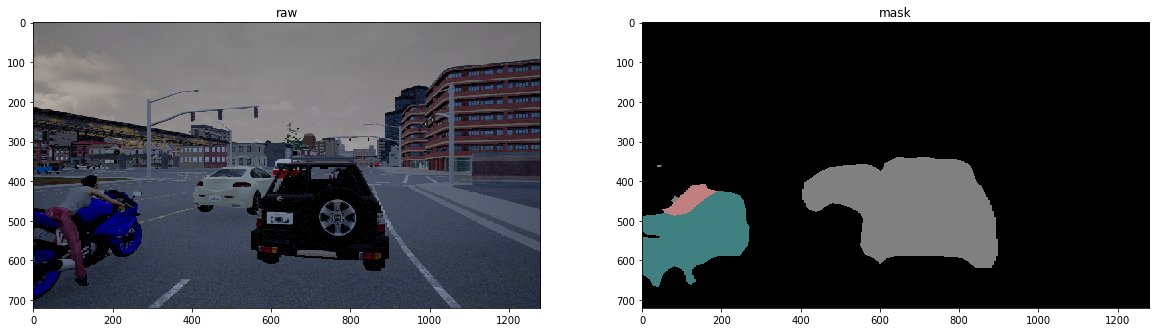

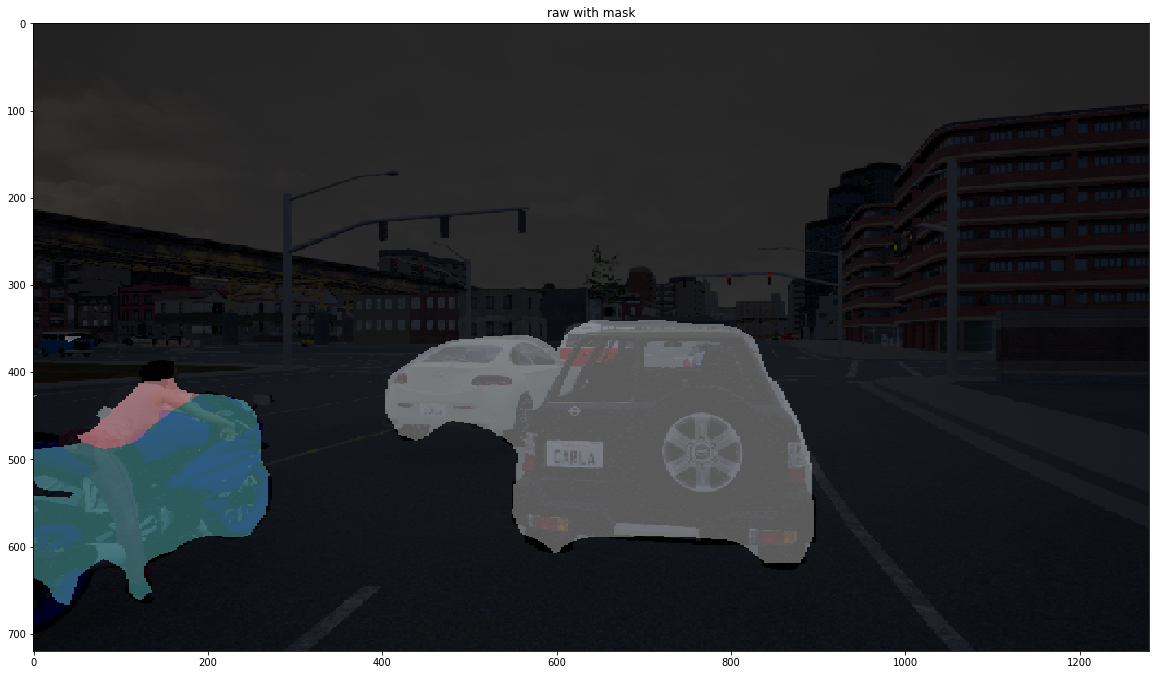

In [27]:
import matplotlib.pyplot as plt
import time
import cv2

test_img = Image.open('./data/test_img/test.png').convert("RGB").resize((513,513))
test_img = np.asarray(test_img)

image_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_in = image_transforms(test_img)

###set timer for excuting time
start_time = time.time()
test_in = Variable(test_in.cuda())
test_out = model(test_in.unsqueeze(0))
_, test_pred = torch.max(test_out, 1)
test_pred = test_pred.data.cpu().numpy().squeeze().astype(np.uint8)
test_mask_pred = Image.fromarray(test_pred)
test_mask_pred.putpalette(cmap)
end_time = time.time()
print('run time: {} sec.'.format(end_time - start_time))

test_img = Image.fromarray(test_img, 'RGB')

plt.figure(figsize=(20,20)) 
plt.subplot(1,2,1)
plt.title('raw')
plt.imshow(test_img.resize((1280, 720)))
plt.subplot(1,2,2)
plt.title('mask')
plt.imshow(test_mask_pred.convert('RGB').resize((1280, 720)))
plt.show()

img_add = cv2.addWeighted(np.asarray(test_img), 0.3, np.asarray(test_mask_pred.convert('RGB')), 0.7, 0)

plt.figure(figsize=(20,20)) 
plt.title('raw with mask')
plt.imshow(Image.fromarray(img_add).resize((1280, 720)))
plt.show()

### iou calculation

In [12]:
iou = inter_meter.sum / (union_meter.sum + 1e-10)
for i, val in enumerate(iou):
    print('IoU {0}: {1:.2f}'.format(dataset.CLASSES[i], val * 100))
print('Mean IoU: {0:.2f}'.format(iou.mean() * 100))

IoU background: 95.59
IoU aeroplane: 89.97
IoU bicycle: 83.60
IoU bird: 90.96
IoU boat: 85.51
IoU bottle: 86.29
IoU bus: 95.70
IoU car: 93.04
IoU cat: 94.98
IoU chair: 76.77
IoU cow: 92.24
IoU diningtable: 86.16
IoU dog: 93.14
IoU horse: 89.61
IoU motorbike: 90.52
IoU person: 89.41
IoU potted-plant: 82.98
IoU sheep: 91.78
IoU sofa: 87.56
IoU train: 93.57
IoU tv/monitor: 89.39
Mean IoU: 89.47
